# Setup

In [247]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import cumsum
import matplotlib
import os, pickle
import pandas as pd
from itertools import accumulate
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.ticker as ticker
import matplotlib as mpl
import datetime
import json
import scipy.stats as stats
plt.rcParams.update({'font.size': 22})
plt.rcParams['font.family'] = 'Arial'

base_color_list = ['black', 'grey',  'darkblueviolet', 'gold', 'darkorange','teal', 'skyblue' ,'darkblue', 'darkblueviolet']
SYS_NAME = 'Andes'
BASE= 'vLLM'

mpl.rcParams['lines.linewidth'] = 2.3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['svg.fonttype'] = "none"
mpl.rcParams['svg.hashsalt'] = "42"
mpl.rcParams['pdf.fonttype'] = "42"
mpl.rcParams['ps.fonttype'] = "42"

In [ ]:
import matplotlib.pyplot as plt
import os

def custom_savefig(fname, *args, **kwargs):
    """
    Custom savefig function that replaces spaces with underscores in the filename.
    
    Args:
        fname (str): Filename to save the figure
        *args: Positional arguments to pass to original savefig
        **kwargs: Keyword arguments to pass to original savefig
    
    Returns:
        The result of the original savefig function
    """
    # Replace spaces with underscores
    modified_fname = fname.replace(' ', '_')
    modified_fname = fname.replace('$', '_')
    modified_fname = fname.replace('?', '_')
    modified_fname = fname.replace(')', '')
    modified_fname = fname.replace('()', '')
    
    # Use the built-in savefig method of the current figure
    plt.gca().figure.savefig(modified_fname, *args, **kwargs)

# Optionally replace the default savefig method
plt.savefig = custom_savefig

# Motivation

## BusrtGPT

### Burstiness - request rate CV CDF

### System status 1h

In [249]:

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.rcParams.update({'font.size': 20})
def plot_system_stats(timestamps, running, swapped, waiting, gpu_cache_usage, histogram_data, input_len=None, ymax = None, file_name = None):
    histogram_data = np.cumsum(histogram_data)
    running = moving_average(running, 10)
    swapped = moving_average(swapped, 10)
    waiting = moving_average(waiting, 10)
    gpu_cache_usage = [a if a < 1 else 0 for a in gpu_cache_usage ]
    gpu_cache_usage = moving_average(gpu_cache_usage, 10)

    # Plotting the data with different scales for GPU Cache Usage and other metrics
    if input_len is not None:
        fig, (ax1, ax3, ax4) = plt.subplots(3, 1, figsize=(12, 7.5), gridspec_kw={'height_ratios': [3, 1, 1]})
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]})
    timestamps = [t - timestamps[0] for t in timestamps]  # Normalize timestamps

    # Plot running, swapped, and waiting on the left y-axis (scale of 0 to 100)
    ax1.plot(timestamps, running, label='Running', color='green')
    # ax1.plot(timestamps, swapped, label='Swapped', color='red')
    ax1.plot(timestamps, waiting, label='Waiting', color='red')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_ylabel('Requests', color='black')
    if ymax is None:
      ymax = max(max(running), max(swapped), max(waiting)) + 1
    ax1.set_ylim([0, ymax])  # Scaling for running, swapped, and waiting
    ax1.set_xlim([0, 3600])
    ax1.set_xticklabels([])
    ax1.legend(loc='center right')

    # ====================== GPU memory utilization ======================
    ax2 = ax1.twinx()
    ax2.fill_between(timestamps, gpu_cache_usage, label='GPU Mem. Util.', color='lightblue', alpha=0.5)
    ax2.set_ylabel('GPU Mem. Util. (%)', color='black')
    ax2.set_ylim([0, 1])  # Scaling for GPU cache usage
    ax2.set_xlim([0, 3600])
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.grid(axis='y', linestyle='--', alpha=0)
    ax2.grid(axis='x', linestyle='--', alpha=0)
    ax2.set_yticks([0, 0.5, 1])  # Original tick values
    ax2.set_yticklabels([0, 50, 100])  # Custom labels corresponding to the ticks
    ax2.legend(loc='upper right')

    # ===================== Request arrival histogram =====================
    granularity = 120
    histogram_data_min = [(t+15)//30 for t in histogram_data]
    histogram_data_min = histogram_data_min+histogram_data_min
    ax3.hist(histogram_data_min, bins=granularity, color='grey', alpha=0.7)

    if input_len is None:
        ax3.set_xticks(range(0, granularity +  granularity//6, granularity//6))  # Set the tick positions
        ax3.set_xticklabels([*range(0,70,10)])  
        ax3.set_xlabel('Time (min)')
    else:
        ax3.set_xticklabels([])
    ax3.set_ylabel('Requests/\nmin')
    ax3.set_xlim([0, granularity])
    ax3.spines['top'].set_visible(False)
    ax3.grid(axis='y', linestyle='--', alpha=0.5)
    ax3.grid(axis='x', linestyle='--', alpha=0.5)

    if input_len is not None:
        granularity = 120
        arrival_hist, _ = np.histogram(histogram_data, bins=granularity)

        avg_tokens_per_bin = []
        index = 0
        for i in range(granularity):
            total_tokens = sum(input_len[index:index+arrival_hist[i]])
            avg_tokens_per_bin.append(total_tokens  / arrival_hist[i])
            # avg_tokens_per_bin.append(total_tokens  )
            index += arrival_hist[i]
        
        x_ticks = range(len(avg_tokens_per_bin))
        ax4.bar([x+ 60/granularity for x in x_ticks], avg_tokens_per_bin, color='grey', label='Average Tokens per Bin', width=1, alpha=0.7)
        ax4.set_xlabel('Time (min)')
        ax4.set_ylabel('Tokens/\nRequest')
        ax4.set_xlim([0, granularity])
        ax4.set_xticks(range(0, len(avg_tokens_per_bin) +  granularity//6, granularity//6))  # Set the tick positions
        ax4.set_xticklabels([*range(0,70,10)])  

        ax4.spines['top'].set_visible(False)
        ax4.grid(axis='y', linestyle='--', alpha=0.5)
        ax4.grid(axis='x', linestyle='--', alpha=0.5)
        ax4.set_yticks([0, 25000])  # Original tick values
        ax4.set_yticklabels(['0', '25k'])  # Custom labels corresponding to the ticks

    plt.grid(True)
    # Save the figure to file
    plt.tight_layout()
    plt.savefig(f'{file_name}.pdf')

import re
def extract_system_stats_from_log(file_path: str, start_time: float=0):
    # Lists to store extracted values
    timestamps = []
    running = []
    swapped = []
    waiting = []
    gpu_cache_usage = []
    
    # Regular expression to match the desired parts of the log lines
    pattern = re.compile(
        r'\[(\d+)\] System Stats: Running: (\d+),\s+- Swapped: (\d+),\s+- Waiting: (\d+),\s+- GPU Cache Usage: ([0-9.]+)'
    )
    
    # Read the file and extract data
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match and int(match.group(1) )> int(start_time):
                timestamps.append(int(match.group(1)))
                running.append(int(match.group(2)))
                swapped.append(int(match.group(3)))
                waiting.append(int(match.group(4)))
                gpu_cache_usage.append(float(match.group(5)))

    return timestamps, running, swapped, waiting, gpu_cache_usage



In [250]:
arrival_list=[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 5, 0, 0, 3, 1, 0, 1, 1, 1, 1, 1, 0, 2, 0, 5, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 5, 0, 0, 1, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 6, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 5, 0, 0, 1, 4, 0, 0, 1, 0, 1, 3, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 6, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 7, 0, 0, 1, 0, 1, 3, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 6, 0, 0, 1, 4, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 5, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 4, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 3, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 4, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 1, 0, 3, 1, 0, 1, 0, 0, 1, 0, 1, 3, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 3, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 3, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 3, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 3, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 3, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 3, 2, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 3, 3, 0, 2, 0, 1, 2, 4, 2, 2, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 2, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 3, 3, 1, 1, 1, 3, 1, 1, 0, 2, 1, 0, 3, 0, 1, 2, 3, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 4, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 3, 0, 2, 3, 3, 1, 1, 2, 1, 0, 3, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 3, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 4, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 4, 1, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1, 1, 1, 2, 5, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 0, 3, 1, 0, 1, 3, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0]

In [251]:
fcfs_burstgpt_file  = 'results/2024-10-24 03:59-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1760-hour-1189-fcfs.json'
qoe_burstgpt_file = 'results/2024-10-24 05:01-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1760-hour-1189-qoe-avg.json'


fcfs_burstgpt_file = '/Users/amberljc/Desktop/andes_logs-11-13/short-Phi-3.5-MoE-instruct-sharegpt-multi-burstgpt-2*8474-hour-1492-fcfs.json'
qoe_burstgpt_file = '/Users/amberljc/Desktop/andes_logs-11-13/short-Phi-3.5-MoE-instruct-sharegpt-multi-burstgpt-2*8474-hour-1492-qoe-avg.json'

def read_requests_logging(file):
    requests = []
    with open(file, 'r') as f:
        for line in f:
            requests.append(json.loads(line))
    return requests
 

In [252]:
from qoe_tracker import QoETracker
def get_request_info(requests):
    token_latency_p90_list = []
    token_latency_p50_list = []
    token_latency_list = []
    ttft_list = []
    qoe_list = []
    input_length_list = []
    for req in requests:
        if "time_list" in req:
            time_list = req["time_list"]
            token_latency = np.diff(time_list[1:])
            token_latency_p90 = np.percentile(token_latency, 90)
            token_latency_p90_list.append(token_latency_p90)
            token_latency_p50 = np.percentile(token_latency, 50)
            token_latency_p50_list.append(token_latency_p50)
            token_latency_list.append(np.mean(token_latency))
            ttft_list.append( time_list[1] - time_list[0])
            qoe_required = req["qoe"]
            rt = QoETracker(qoe_required)
            qoe = rt.get_QoE(np.array(time_list)-time_list[0])
            qoe_list.append(qoe)
            input_length_list.append(req["input"])

    return token_latency_p90_list, token_latency_p50_list, \
            token_latency_list, ttft_list, qoe_list, input_length_list

            

In [253]:
fcfs_token_latency_p90_list, fcfs_token_latency_p50_list, fcfs_token_latency, fcfs_ttft_list, fcfs_qoe_list, input_length_list = get_request_info(read_requests_logging(fcfs_burstgpt_file))
qoe_token_latency_p90_list, qoe_token_latency_p50_list, qoe_token_latency, qoe_ttft_list, qoe_qoe_list, input_length_list = get_request_info(read_requests_logging(qoe_burstgpt_file))

GPU utilization: 0.37437258799235895
286 0 286


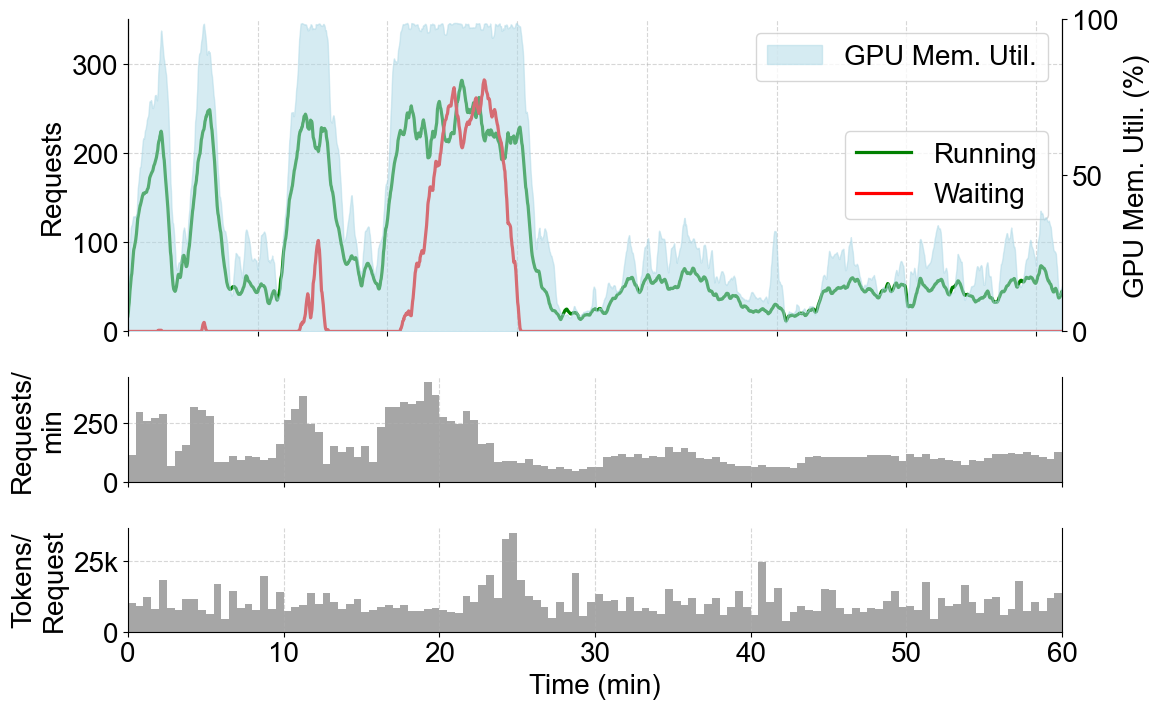

In [254]:
# sys_file = 'results/2024-10-24 03:58-sys-stats.txt'
sys_file = 'results/2024-11-08 22:28-sys-stats.txt'
timestamps, running, swapped, waiting, gpu_cache_usage = extract_system_stats_from_log(sys_file)
plot_system_stats(timestamps, running, swapped, waiting, gpu_cache_usage, arrival_list, input_length_list,ymax=350, file_name='burst-fcfs')
print(f'GPU utilization: {np.mean(gpu_cache_usage)}')
print(max(running), max(swapped), max(waiting))

GPU utilization: 0.38198250918993815
345 0 44


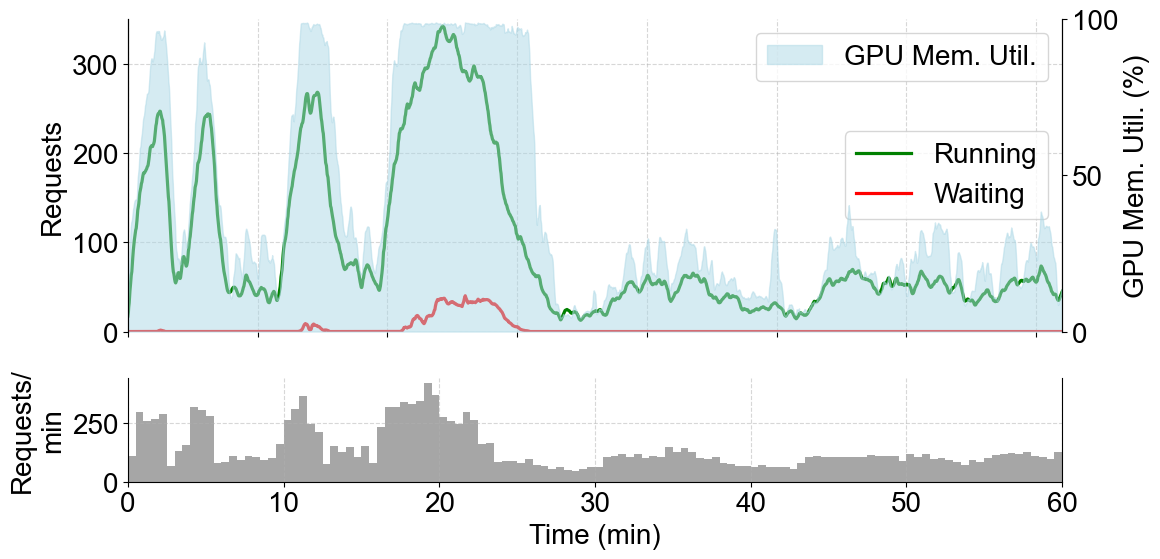

In [255]:

sys_file = 'results/2024-10-24 05:00-sys-stats.txt'
sys_file = 'results/2024-11-09 19:02-sys-stats.txt'

timestamps, running, swapped, waiting, gpu_cache_usage = extract_system_stats_from_log(sys_file)
plot_system_stats(timestamps, running, swapped, waiting, gpu_cache_usage, arrival_list, ymax=350, file_name='burst-qoe')
print(f'GPU utilization: {np.mean(gpu_cache_usage)}')
print(max(running), max(swapped), max(waiting))

### Breakdown

#### Input length over time

In [256]:
arrival_list = np.cumsum(arrival_list)


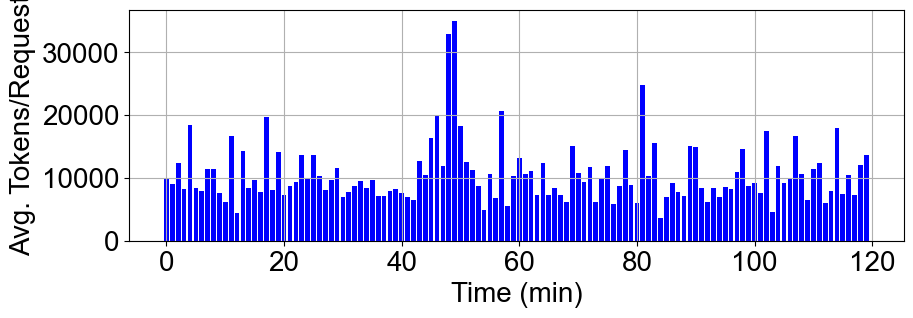

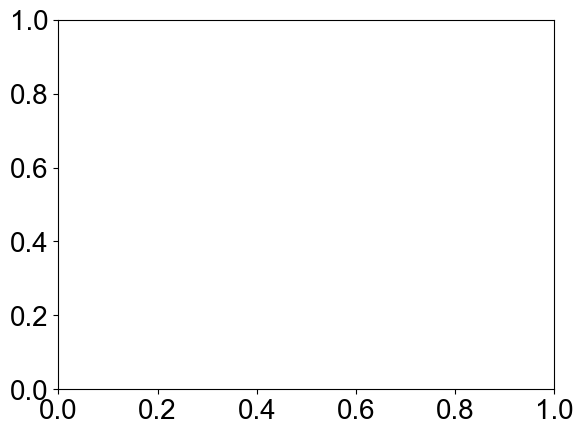

In [257]:
# calculate histgram of arrival_list
arrival_hist, arrival_bins = np.histogram(arrival_list, bins=120)
arrival_hist, arrival_bins
avg_tokens_per_bin = []
index = 0
for i in range(120):
    total_tokens = sum(input_length_list[index:index+arrival_hist[i]])
    avg_tokens_per_bin.append(total_tokens  / arrival_hist[i])
    # avg_tokens_per_bin.append(total_tokens  )
    index += arrival_hist[i]
 
plt.figure(figsize=(10, 3))
# plt.plot(avg_tokens_per_bin, marker='o', linestyle='-', color='b', label='Average Tokens per Bin')
plt.bar(range(len(avg_tokens_per_bin)), avg_tokens_per_bin, color='b', label='Average Tokens per Bin')

# Add labels and title
plt.xlabel('Time (min)')
plt.ylabel('Avg. Tokens/Request')
plt.grid(True)
# plt.xlim(0, 60)
# Show the plot
plt.show()
plt.savefig('avg_tokens_per_bin.pdf')

In [258]:
import seaborn as sns
plt.rcParams.update({'font.size': 22})
c_list = ['darkblue', 'orange', 'darkcyan', 'green', 'red', 'gray', 'brown', 'pink', 'olive', 'cyan']
l_list = ['--', '-', '-.']
def plot_cdf(data, ylabel='CDF', xlabel='CV of 1-hour Request Arrival', file_name = 'burst-cdf', 
             xmax=2.5, xmin=0, label=None, vline=None, loc=None, fig_size=(6, 3.6)):
  plt.figure(figsize=fig_size)
  if label is not None:
    for i in range(len(data)):
      sns.ecdfplot(data[i], label=label[i], color=c_list[i], linestyle=l_list[i])
    if loc is not None:
      plt.legend(loc = loc)
  else:
    sns.ecdfplot(data, color='darkblue')  
  if vline is not None:
    plt.axvline(x=vline, color='grey', linestyle='--')
    plt.text(vline-0.2, 1.05, f'{vline}', verticalalignment='center', fontsize=18)
  
  # Remove upper and right spines
  ax = plt.gca()  # Get current axes
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.xlim(xmin, xmax)
  plt.ylim(0, 1.01)
  plt.yticks([0,0.5,1])
  plt.tight_layout()
  plt.savefig(f'{file_name}.pdf', bbox_inches='tight')
  plt.show()


#### TDS

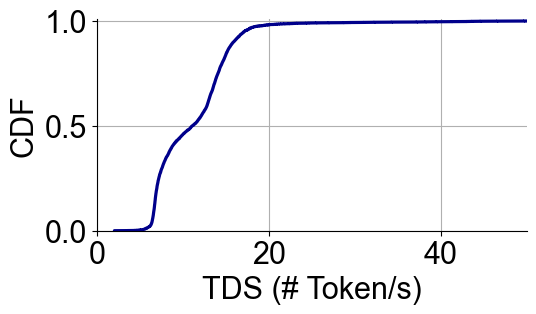

In [259]:
cdf_list = [1/t if t>0.01 else 20 for t in fcfs_token_latency]
plot_cdf(cdf_list, 'CDF', 'TDS (# Token/s)', 'tds-cdf', 50,0)


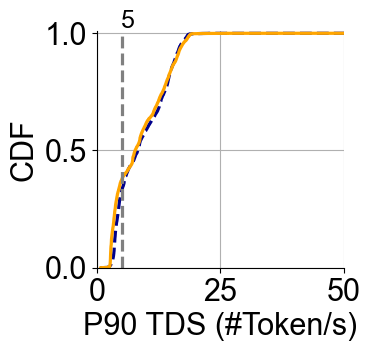

In [260]:
fcfs_p90_cdf_list = [1/t  for t in fcfs_token_latency_p90_list]
qoe_p90_cdf_list = [1/t  for t in qoe_token_latency_p90_list]
plot_cdf([fcfs_p90_cdf_list, qoe_p90_cdf_list], 'CDF', 'P90 TDS (#Token/s)', 
         'p90-tds-cdf', 50,0, label=['FCFS', 'QoE'], vline=5, fig_size=(4,4))

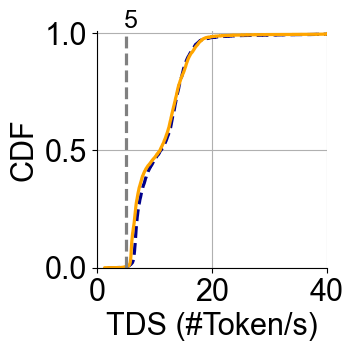

In [261]:
fcfs_avg_cdf_list = [1/t  for t in fcfs_token_latency]
qoe_avg_cdf_list = [1/t  for t in qoe_token_latency]
plot_cdf([fcfs_avg_cdf_list, qoe_avg_cdf_list], 'CDF', 'TDS (#Token/s)', 
         'avg-tds-cdf', 40,0, label=['FCFS', 'QoE'], vline=5, fig_size=(4,4))
# print(sorted(fcfs_avg_cdf_list)[::-1])
# print(sorted(qoe_avg_cdf_list)[::-1])
qoe_avg_cdf_list=[a for a in qoe_avg_cdf_list if a < 100 ]
fcfs_avg_cdf_list=[a for a in fcfs_avg_cdf_list if a < 100]
# print(np.mean(fcfs_avg_cdf_list))
# print(np.mean(qoe_avg_cdf_list))


#### TTFT

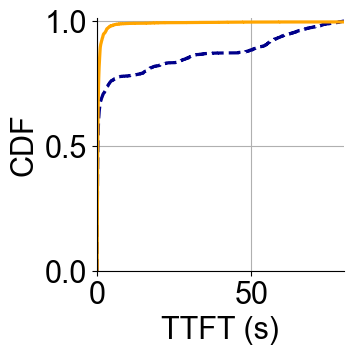

10.446877373852661
1.8027576154223939


In [262]:
plot_cdf([fcfs_ttft_list, qoe_ttft_list], 'CDF', 'TTFT (s)',
            'ttft-cdf', 80,0, [BASE,  SYS_NAME], fig_size=(4,4))

print(np.mean(fcfs_ttft_list))
print(np.mean(qoe_ttft_list))

#### QoE

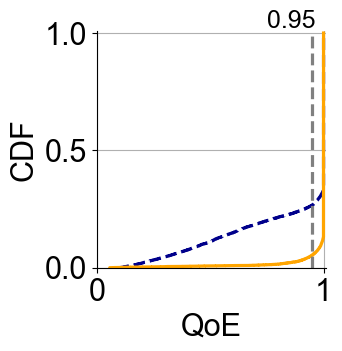

75.59594052395563
96.94359216426717
avg qoe: 0.88016999540866
avg qoe: 0.9868288403329386


In [263]:
plot_cdf([fcfs_qoe_list, qoe_qoe_list], 'CDF', 'QoE', 'qoe-cdf', 1.01,0, 
         [BASE,  SYS_NAME], vline=0.95, fig_size=(4,4))

def percentage_above_x(lst, x): 
    arr = np.array(lst) 
    count_above_x = np.sum(arr > x) 
    percentage = (count_above_x / len(arr)) * 100
    
    return percentage

print(percentage_above_x(fcfs_qoe_list, 0.9))
print(percentage_above_x(qoe_qoe_list, 0.9))
print(f'avg qoe: {np.mean(fcfs_qoe_list)}')
print(f'avg qoe: {np.mean(qoe_qoe_list)}')

### Visualization

In [264]:
pretty_colors = sns.color_palette('husl', 10) 
color_list = pretty_colors.as_hex()
clen=len(color_list)
print(color_list) 

['#f77189', '#dc8932', '#ae9d31', '#77ab31', '#33b07a', '#36ada4', '#38a9c5', '#6e9bf4', '#cc7af4', '#f565cc']


In [265]:

plt.rcParams.update({'font.size': 22})
def visualize_tdt(requests, file_name, xmax=None, ymax=None, keywords=['Amber'], assigned_input_list=None):
    plt.figure(figsize=(6,4.5))
    # max_ttlt = 0
    # 'believe you' 
    input_list = []
    for req in requests:
        if "time_list" in req:
            time_list = req["time_list"]
            if (assigned_input_list is not None and req['input'] in assigned_input_list  ) or \
                    (assigned_input_list is None and any(keyword in req['input'] for keyword in keywords) and  time_list[1] - time_list[0] < 100 and len(time_list)) > 10:
                group_time = np.array(time_list) - time_list[0]
                input_list.append(req['input'])
                # print(req['input'][:30])
                y = np.arange(1, len(time_list)+1)
                plt.plot(group_time, y, linestyle='-', markersize=1, color=color_list[len(time_list)%7])  
                # plt.text(group_time[1], 0, req['input'][0], fontsize=8, color='black')
    x = np.linspace(2, xmax, 100) 
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.plot(x, 5.1 * (x - 1) - 10, linestyle='--', markersize=2, label='Avg. Expected TDT', color='black')
    plt.xlim(xmin=0, xmax=xmax)
    plt.ylim(ymin=0, ymax=ymax)
    plt.xlabel('Time (s)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.ylabel('Tokens')
    # plt.legend(loc='upper left')    
    plt.tight_layout()  
    plt.savefig(f'{file_name}.pdf')
    plt.show()
    return input_list


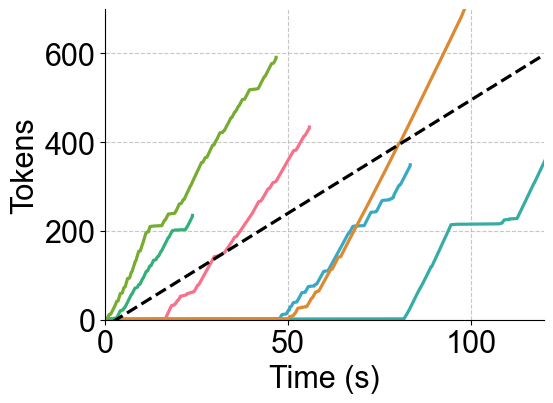

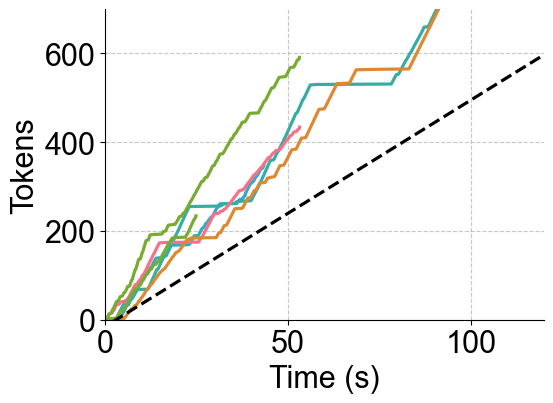

In [266]:
 
match_str = ['expected to do','好的。', 'онла', 'Hello helloHello! How can I he',  '薦事蹟標', 'trying to make a jest test' ]
# match_str = ['expected to do']
fcfs_burstgpt_file  = 'results/2024-10-24 03:59-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1760-hour-1189-fcfs.json'
qoe_burstgpt_file = 'results/2024-10-24 05:01-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1760-hour-1189-qoe-avg.json'

requests = read_requests_logging(fcfs_burstgpt_file)
input_list=visualize_tdt(requests, 'fcfs-tdt',120,700,keywords=match_str)

requests = read_requests_logging(qoe_burstgpt_file)
_=visualize_tdt(requests, 'qoe-tdt',120,700, assigned_input_list=input_list)


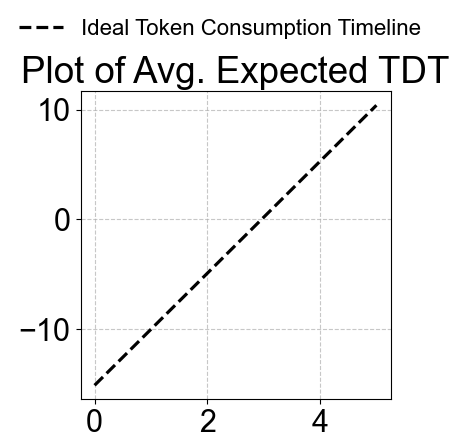

In [267]:
# Data
x = np.linspace(0, 5, 100)  # Generate x values
y = 5.1 * (x - 1) - 10      # Calculate y values

plt.figure(figsize=(4,4))
plt.plot(x, y, linestyle='--', markersize=2, label='Ideal Token Consumption Timeline', color='black')

# Adding legend on top
plt.legend(loc='upper center', bbox_to_anchor=(0.45, 1.3), frameon=False, fontsize=16)

plt.title('Plot of Avg. Expected TDT')
plt.grid(True, linestyle='--', alpha=0.7)

# Display plot
plt.savefig('expected-tdt-legend.pdf', bbox_inches='tight')
plt.show()


## Prompt dataset


In [268]:
sharegpt_input_len=[8087, 1841, 4278, 18, 62, 5915, 10809, 1541, 344, 181, 2604, 892, 1111, 846, 6701, 1705, 15752, 809, 1141, 12840, 349, 2372, 3979, 3328, 3050, 2833, 30273, 25920, 352, 2915, 568, 1267, 15, 1119, 907, 127, 1230, 868, 67846, 18160, 6459, 990, 4312, 3671, 380, 26, 1633, 2811, 323, 507, 1662, 19, 847, 685, 45, 1211, 2246, 1381, 18539, 1924, 19, 16, 946, 499, 4, 528, 458, 1490, 243, 26683, 4252, 12363, 4549, 569, 55, 7, 115, 3356, 113, 8083, 1130, 17, 6063, 1, 29, 82, 1455, 421, 7, 2593, 1830, 576, 3856, 335, 1203, 1636, 79, 1290, 50, 3246, 80, 276, 22, 2372, 2359, 140, 256, 16210, 4051, 30, 1543, 236, 5703, 166, 1066, 18, 4276, 6409, 13654, 11402, 83, 1306, 686, 170, 901, 1935, 514, 3121, 701, 17, 7336, 397, 49, 4249, 16, 1100, 18, 82, 57, 1371, 8, 421, 34, 8530, 2761, 1816, 369, 3465, 8435, 14, 4790, 39, 8, 3794, 13, 1008, 166, 22, 5359, 6893, 6, 44, 30, 4078, 106, 304, 1024, 20151, 13, 1245, 10, 9438, 24, 777, 24, 534, 1560, 3119, 87, 1191, 1160, 15, 6005, 43, 1943, 2473, 978, 480, 67765, 714, 21, 1630, 1494, 1394, 371, 12335, 27, 134, 953, 16, 70, 911, 17873, 11107, 4781, 312, 601, 1076, 64, 8508, 8, 662, 472, 1262, 3776, 31, 839, 63, 2014, 4789, 93, 25, 14, 1005, 2873, 22, 2745, 2541, 148, 783, 1662, 2814, 3599, 1264, 23, 11, 28, 754, 3535, 594, 1490, 27736, 8109, 2184, 26169, 75, 734, 4539, 10, 254, 7, 5025, 1052, 1797, 11347, 7, 1033, 37, 1023, 1324, 5445, 1344, 2018, 5468, 509, 811, 455, 37, 1730, 595, 1429, 799, 2029, 2072, 18365, 74, 869, 13074, 3424, 66, 41, 28, 378, 1202, 6480, 1790, 137, 311, 3807, 5332, 5, 941, 367, 301, 880, 2889, 25, 8696, 1224, 352, 30, 2881, 30555, 4631, 2675, 3912, 1467, 12751, 10, 21, 2809, 45, 190, 20, 2683, 14259, 131, 13157, 437, 25, 963, 107, 11354, 1383, 2282, 620, 1, 189, 86, 1718, 1048, 896, 10565, 2117, 176, 132, 1419, 176, 1997, 1956, 823, 11826, 4580, 407, 65, 878, 1666, 572, 14072, 148, 731, 34, 194, 107, 936, 43, 5282, 2, 437, 9110, 59, 1751, 15, 11643, 102, 45, 16630, 1022, 472, 574, 544, 25, 23, 2497, 6, 1760, 2923, 2747, 10, 3168, 57, 3241, 38, 1147, 525, 41303, 15, 94, 1906, 519, 568, 1576, 1545, 388, 589, 105, 179, 88, 5945, 14, 175, 5, 6119, 3698, 9, 1475, 3720, 1213, 5670, 13, 400, 260, 774, 335, 9596, 239, 66, 4243, 188, 64, 321, 289, 1059, 26, 4860, 97, 16787, 3055, 979, 654, 1364, 3981, 18, 521, 20, 948, 4978, 5157, 326, 1356, 313, 348, 856, 892, 615, 12, 9688, 1241, 5250, 20, 1139, 37, 7150, 5226, 3442, 2746, 3218, 28584, 801, 13614, 487, 154, 1270, 12, 178, 21350, 2, 1087, 6559, 71, 23, 3429, 32746, 1071, 18, 118, 1773, 124, 376, 1755, 75, 1869, 23615, 1348, 1461, 569, 122, 29, 458, 17, 3836, 20, 1249, 9229, 846, 766, 620, 10, 6110, 16748, 370, 3578, 1767, 968, 157, 225, 67, 1599, 5631, 480, 11, 1889, 1183, 1767, 10773, 2835, 311, 932, 397, 2749, 354, 3073, 492, 4931, 11445, 953, 169, 1550, 431, 59, 422, 595, 213, 6605, 396, 161, 8304, 470, 3003, 100000, 14, 117, 1048, 5434, 1941, 64, 5, 396, 10, 8727, 914, 1808, 1383, 64554, 984, 13, 34302, 651, 4568, 1148, 564, 170, 9, 130, 2027, 4, 2546, 5327, 1251, 21, 201, 20, 21, 505, 2774, 70, 3653, 3607, 1691, 413, 130, 17693, 21, 22, 4942, 664, 1279, 947, 356, 2374, 39, 165, 22, 3779, 9463, 1299, 765, 173, 39, 1394, 9044, 4393, 137, 25, 400, 429, 800, 90, 15, 52, 43, 14509, 1217, 3832, 6282, 6, 2453, 3849, 2246, 18542, 485, 875, 8, 9, 1461, 1264, 70, 288, 10967, 16459, 1196, 21, 998, 1471, 25, 1918, 10, 6419, 709, 4, 660, 197, 63, 9147, 431, 98, 2369, 1895, 3689, 5768, 2863, 17606, 1966, 2319, 16, 1033, 1440, 478, 68822, 2033, 1391, 16, 415, 2523, 7003, 1216, 350, 14, 542, 156, 25, 1432, 3012, 155, 817, 12, 96, 2237, 13982, 2066, 687, 112, 410, 3697, 7, 1398, 75, 5236, 8929, 699, 24, 20, 338, 44, 897, 527, 6246, 18, 81, 24854, 39, 1937, 758, 3241, 22, 2441, 7774, 1161, 1684, 899, 9, 3109, 4338, 645, 5556, 15, 6115, 3152, 3699, 1341, 194, 1605, 21, 475, 939, 114, 698, 1298, 264, 11, 3248, 1006, 1754, 241, 12303, 1361, 353, 3131, 1765, 7, 1707, 392, 27, 1418, 13133, 46, 9347, 14551, 8524, 3830, 1129, 40, 1772, 21, 61, 1462, 19, 1449, 2275, 1129, 1736, 1475, 7005, 194, 9030, 671, 3047, 8309, 33, 282, 189, 4938, 672, 410, 1478, 6, 27625, 18, 730, 245, 25, 3171, 14969, 5756, 19074, 723, 1501, 105, 1286, 40, 6681, 1803, 64, 698, 259, 1183, 199, 1041, 2274, 3995, 9040, 3293, 189, 1422, 17, 1062, 1443, 712, 4897, 2211, 136, 25, 316, 206, 144, 642, 216, 13, 469, 775, 3128, 10780, 17, 1847, 5336, 78156, 925, 24, 658, 158, 5063, 4738, 324, 5239, 19, 2859, 19, 1625, 4821, 5128, 5896, 5754, 4766, 94, 14, 773, 78, 10, 155, 435, 1474, 3566, 171, 2565, 151, 3837, 565, 1, 60, 248, 499, 3073, 9, 6850, 4560, 2130, 1493, 1665, 342, 1140, 22, 2413, 17, 141, 3725, 500, 1940, 2105, 371, 418, 19, 267, 6660, 3489, 4031, 1451, 21, 5983, 96, 5617, 206, 609, 16, 33261, 40, 2381, 22, 19, 432, 260, 2, 55, 5059, 2162, 3090, 11445, 4644, 516, 2595, 613, 18952, 536, 4731, 935, 2245, 96, 788, 29, 7, 145, 364, 13858, 7185, 7571, 1514, 1557, 29, 11099, 88, 878, 382, 1079, 10603, 476, 191, 711, 9, 2154, 2790, 1050, 213, 255, 12, 6545, 5486, 13951, 25, 34, 675, 1668, 12, 13, 489, 100000, 2855, 924, 68, 220, 1152, 4129, 8004, 54, 4894, 1407, 2035, 256, 4579, 91, 4192, 3348, 1510, 198, 15727, 7635, 7, 28, 3693, 6, 12541, 2934, 102, 3142, 8817, 2279, 469, 116, 447, 77, 5023, 127, 525, 2097, 1248, 19896, 3106, 18, 2645, 411, 8152, 3549, 11083, 318, 5395, 2481, 1239, 983, 4, 2049, 3574, 27, 240, 7988, 570, 362, 905, 538, 102, 10881, 11, 9604, 355, 1836, 22, 32, 8669, 430, 3211, 346, 5349, 1000, 1577, 2419, 12, 2403, 7, 102, 2301, 4859, 4037, 545, 88, 6973, 2223, 885, 1579, 132, 22, 197, 153, 14, 7, 4786, 87, 315, 895, 267, 2557, 11410, 537, 1250, 22746, 3093, 114, 30, 3718, 2720, 4500, 2138, 369, 1058, 56, 895, 4622, 460, 10132, 318, 116, 72, 8323, 221, 264, 59, 12, 346, 786, 7433, 749, 49, 7004, 14590, 12898, 539, 1986, 1633, 8888, 80, 661, 1581, 8599, 57, 22, 775, 4017, 5094, 2027, 46, 407, 1462, 2760, 1975, 2102, 725, 2752, 8, 1308, 5149, 40, 413, 3131, 4341, 4438, 587, 2677, 15, 21, 1165, 440, 1287, 510, 6658, 24276, 68, 14, 2728, 23, 866, 108, 1924, 5, 347, 1216, 7720, 2035, 477, 1524, 722, 961, 2457, 7327, 1820, 17, 127, 190, 142, 312, 359, 130, 4207, 2382, 2358, 10, 3587, 528, 10, 3022, 530, 426, 4389, 301, 15, 4279, 2034, 6191, 1632, 1529, 1285, 4244, 2495, 767, 710, 126, 1059, 4555, 13, 207, 10, 1434, 4981, 20049, 8285, 577, 1858, 1183, 2268, 11712, 858, 3, 6041, 803, 19, 5702, 1722, 1120, 64, 41, 677, 139, 266, 501, 3282, 1105, 3572, 1337, 31, 449, 1492, 2500, 711, 501, 7760, 28, 501, 24, 736, 19, 928, 1606, 2125, 168, 47, 1469, 620, 7458, 163, 11695, 10143, 233, 928, 657, 805, 23, 9, 1423, 1033, 7463, 18202, 208, 291, 21, 195, 1428, 11877, 17, 1803, 2063, 277, 833, 1109, 741, 457, 33, 10612, 4050, 166, 976, 147, 17803, 1355, 1178, 354, 103, 21, 145, 2432, 1061, 2660, 44, 40, 738, 145, 7938, 58, 31, 44, 56424, 20, 2546, 509, 414, 1755, 4204, 332, 2398, 91, 5226, 851, 651, 8, 1468, 194, 143, 1772, 354, 1874, 735, 2860, 1827, 244, 10181, 3852, 972, 1279, 3759, 3608, 17666, 13752, 124, 1873, 72, 385, 4152, 343, 5271, 86, 52, 25, 381, 528, 1155, 4450, 1859, 206, 3429, 2, 2028, 456, 2463, 202, 458, 48, 3930, 866, 552, 2222, 1495, 439, 428, 7452, 937, 2973, 3046, 1623, 223, 6955, 267, 9, 13, 16, 1741, 4, 199, 7731, 1036, 93, 13, 12, 586, 1466, 1186, 2869, 14133, 2198, 4919, 262, 1016, 5153, 94368, 153, 2533, 575, 21, 175, 2540, 6965, 3443, 270, 1453, 531, 2409, 26, 4314, 168, 18, 2673, 2545, 37, 1, 34, 2543, 241, 113, 1378, 2657, 5008, 5165, 165, 3350, 4302, 1055, 1048, 1538, 8358, 34, 1003, 22, 18557, 5674, 12, 198, 866, 783, 5390, 5454, 2708, 1257, 28, 6, 3116, 1990, 108, 40, 28, 502, 1060, 1974, 79982, 3943, 51, 7, 50, 29668, 2320, 287, 345, 8461, 11, 24, 2130, 431, 2895, 58, 1432, 4844, 7, 5517, 13373, 98, 473, 25, 40, 1290, 836, 104, 7997, 64, 1127, 1293, 1681, 66, 5165, 30, 13563, 863, 2939, 174, 562, 372, 5983, 624, 841, 133, 1968, 1543, 563, 563, 39, 324, 20, 354, 22, 2414, 1594, 2272, 2006, 1391, 7, 3290, 3260, 960, 5767, 16, 2202, 1156, 5054, 2124, 32, 4602, 7941, 1073, 6505, 7, 6005, 103, 1836, 3150, 1457, 171, 1751, 80, 6148, 11060, 199, 49, 42, 1053, 5859, 7917, 1412, 1199, 40, 211, 4334, 425, 4974, 19470, 197, 569, 1979, 2957, 949, 170, 100000, 619, 1346, 445, 23, 670, 154, 1198, 3514, 2495, 483, 71, 8045, 1482, 14272, 996, 8132, 36, 4864, 1228, 9148, 1562, 2303, 445, 8433, 2581, 13698, 21, 9789, 830, 1241, 260, 3270, 5310, 16, 5, 3465, 2304, 2511, 1245, 620, 436, 731, 1694, 2460, 8, 1240, 457, 287, 928, 11, 4482, 14789, 278, 839, 69, 972, 10210, 1316, 1525, 18419, 2348, 55, 494, 4474, 1630, 4526, 182, 10889, 890, 78, 727, 13, 13606, 1207, 1404, 5026, 1228, 38, 3908, 1956, 252, 1013, 20178, 864, 276, 2454, 5, 42740, 7388, 22, 567, 2553, 4, 4774, 548, 1369, 2469, 23, 28, 21, 296, 1756, 494, 407, 1471, 217, 31, 1089, 13862, 20, 3676, 43, 4315, 36, 65, 1068, 3382, 1334, 2103, 10, 3325, 7, 103, 2094, 17, 327, 6, 537, 370, 27, 19, 1720, 662, 2631, 168, 23, 8, 4463, 4267, 47, 768, 3224, 3084, 7151, 82, 3174, 48, 171, 61, 100000, 342, 11, 49, 1, 3031, 3282, 404, 747, 722, 2687, 381, 27, 3379, 261, 23, 1963, 765, 10235, 1327, 611, 10, 2494, 2, 353, 1292, 184, 334, 33, 2287, 869, 9159, 323, 566, 49, 6908, 22, 21, 2393, 46, 6074, 921, 7729, 4525, 1892, 8, 33, 1791, 15, 2511, 917, 33, 11, 1203, 7, 7525, 10, 778, 1095, 3088, 373, 22, 26134, 1313, 312, 2982, 15394, 7539, 1234, 965, 3, 2722, 18, 428, 426, 428, 29, 436, 17907, 2265, 809, 2208, 3192, 6256, 1661, 5378, 2839, 11609, 4298, 4434, 2267, 2716, 11, 358, 104, 381, 610, 243, 5247, 1483, 477, 15192, 1587, 1837, 3163, 3381, 1975, 108, 7495, 3186, 1517, 44716, 3257, 5824, 291, 89, 641, 1982, 2516, 1536, 1806, 8330, 694, 29932, 99, 355, 1, 344, 2255, 7408, 168, 1862, 43431, 263, 33, 36, 1627, 408, 20, 704, 5404, 2052, 782, 66, 9952, 649, 823, 1126, 1793, 2204, 20, 34, 3627, 339, 2792, 37, 48, 3853, 19216, 1139, 79, 663, 1874, 50798, 1473, 474, 17624, 3527, 69, 266, 11523, 3123, 3118, 2067, 3213, 1750, 1397, 686, 18, 4, 136, 5063, 9396, 14214, 34, 10128, 6, 128, 2048, 787, 7781, 1132, 48, 136, 7, 123, 285, 77, 1757, 152, 2657, 10415, 100, 1, 59, 472, 451, 400, 24, 1675, 2571, 1104, 31, 128, 327, 16349, 10414, 1358, 506, 10092, 3414, 16, 9, 408, 4, 1975, 648, 4359, 409, 1440, 173, 14, 425, 821, 47, 490, 33533, 28, 3685, 7, 555, 28, 183, 51837, 2930, 26415, 3577, 289, 5204, 361, 961, 928, 1189, 2623, 27, 419, 1035, 2735, 20, 9, 437, 839, 4134, 842, 3533, 28874, 2322, 152, 825, 2767, 14847, 36, 17399, 3249, 1320, 958, 25622, 1783, 856, 363, 17, 2531, 73, 139, 59, 189, 18421, 1752, 253, 16, 2810, 2354, 328, 3672, 665, 737, 24, 2932, 28501, 1, 26, 1605, 2184, 2056, 935, 984, 3978, 97, 701, 952, 2010, 99, 1797, 12117, 709, 652, 505, 47018, 3847, 15, 14578, 1, 339, 1709, 1227, 3988, 4940, 298, 481, 3116, 8090, 1239, 2690, 1279, 22, 36, 452, 2097, 261, 36, 16690, 2013, 421, 4269, 18, 1393, 26, 202, 1343, 17, 4358, 352, 8770, 965, 39, 19, 2553, 778, 2046, 1608, 335, 3202, 2209, 234, 7233, 919, 148, 373, 4, 422, 571, 1986, 5, 2151, 48, 9, 165, 9, 1113, 1514, 3740, 29, 865, 4950, 13619, 4891, 955, 1234, 52, 1946, 10, 5939, 3893, 1102, 617, 1022, 483, 600, 240, 9631, 1193, 919, 186, 1648, 3559, 499, 1960, 6847, 19, 7063, 903, 1413, 4323, 3084, 863, 9323, 1531, 40, 2257, 1602, 772, 3850, 2595, 17, 6998, 15348, 3854, 6575, 7480, 1067, 3995, 4318, 584, 2148, 210, 458, 43, 1435, 280, 22776, 889, 973, 882, 7, 645, 12210, 7439, 44, 914, 889, 484, 7, 26, 84, 7197, 5, 3296, 28, 2358, 6074, 52119, 724, 1, 3509, 23401, 3246, 584, 24, 152, 1289, 4993, 105, 532, 32, 237, 392, 33, 12, 6838, 33, 95, 5032, 466, 451, 1399, 143, 1486, 4812, 3, 18, 579, 1101, 5181, 1213, 2, 571, 1140, 2817, 2338, 8357, 467, 40, 24, 1446, 1863, 71, 2365, 751, 506, 2089, 212, 2237, 460, 937, 24, 4223, 820, 3361, 16, 3970, 374, 4051, 16270, 3198, 32335, 19, 269, 4672, 11173, 1502, 302, 100000, 7, 225, 858, 2850, 4477, 67452, 10, 3988, 393, 1332, 23, 1061, 1493, 1530, 3258, 1909, 1679, 69, 20396, 7898, 11, 8291, 466, 7727, 299, 321, 16530, 13, 626, 713, 35404, 1215, 626, 1547, 3758, 1467, 431, 796, 11, 391, 1426, 17, 407, 14092, 636, 849, 38, 3430, 293, 1128, 998, 5112, 9306, 3088, 2505, 1732, 4298, 7514, 1000, 308, 3530, 1557, 1835, 330, 1279, 439, 4184, 84, 47, 6092, 430, 3942, 50, 13476, 1759, 18, 5009, 1316, 664, 1653, 1965, 4397, 548, 16, 4098, 500, 585, 309, 96, 1361, 918, 49, 844, 2575, 17509, 275, 152, 1489, 1324, 957, 979, 3176, 89, 328, 322, 754, 798, 748, 18, 15, 2175, 72, 4249, 3371, 1199, 85, 138, 593, 308, 30, 10820, 3167, 38, 121, 138, 38, 17, 61, 2341, 5945, 14, 3, 10412, 439, 336, 3427, 45, 23, 11302, 4353, 23487, 2034, 16, 857, 311, 1912, 951, 5428, 24, 11199, 1201, 2532, 18, 3836, 1174, 2768, 16, 216, 11795, 26, 187, 4729, 2928, 3896, 56, 3312, 16206, 371, 430, 3545, 21, 443, 700, 7342, 763, 46, 400, 1127, 558, 23, 346, 7, 6562, 16, 372, 182, 785, 11, 4832, 526, 209, 5612, 738, 558, 79, 1029, 469, 13271, 1413, 1834, 4, 675, 53, 596, 100000, 118, 2885, 2059, 1175, 41, 2229, 512, 83, 2878, 20, 1234, 1489, 836, 2870, 2762, 11958, 63, 1880, 110, 833, 786, 2050, 530, 76, 10024, 1670, 1075, 3102, 5669, 493, 1803, 1584, 5137, 116, 32242, 41, 25, 9907, 1618, 12583, 129, 2077, 5763, 6925, 2072, 13902, 4616, 1437, 4475, 17337, 1727, 4325, 2294, 3090, 3223, 16, 7, 997, 6888, 1788, 368, 3750, 1948, 1301, 155, 4580, 7271, 2, 85, 1232, 272, 811, 1330, 414, 15, 4835, 4739, 789, 278, 456, 1132, 578, 3280, 751, 1814, 2039, 4762, 89, 2538, 459, 2, 13, 1340, 24253, 13613, 3066, 4746, 1678, 242, 12250, 1370, 359, 7619, 1734, 141, 71, 8, 7, 757, 96, 2010, 60, 84, 1709, 874, 12, 1608, 2084, 2585, 693, 1313, 2251, 3574, 36456, 13, 1543, 20799, 1129, 1085, 174, 2022, 933, 89, 618, 3227, 736, 220, 630, 463, 37, 527, 3673, 1640, 1127, 26, 8792, 3888, 831, 2526, 21, 177, 10547, 3754, 11588, 5029, 21372, 43, 4803, 1294, 2, 901, 34, 1962, 124, 6341, 73, 4062, 5771, 1227, 22852, 6288, 258, 851, 2561, 100, 600, 22909, 1143, 434, 27, 13, 684, 7466, 4580, 553, 2239, 944, 1399, 4306, 7, 12417, 67, 2654, 3027, 35907, 17958, 3532, 24, 16, 284, 14083, 775, 6221, 2772, 143, 50, 41, 481, 1735, 282, 12, 103, 5824, 21, 47, 1829, 1387, 64, 14, 669, 68, 9243, 33, 13235, 77, 351, 2931, 6, 4020, 5907, 666, 3348, 451, 348, 811, 11, 629, 2809, 2028, 2542, 474, 6495, 1689, 186, 11031, 84, 75, 524, 1534, 632, 72, 223, 1804, 125, 509, 894, 299, 463, 876, 5, 173, 1628, 60, 3506, 705, 8, 1771, 5304, 637, 5672, 9023, 11306, 10331, 1491, 1239, 12184, 22, 2215, 977, 825, 9189, 2772, 2447, 810, 60, 102, 665, 44, 3076, 4092, 123, 708, 366, 556, 290, 1933, 6418, 4508, 2284, 5066, 2945, 8369, 62331, 7, 13, 241, 158, 12577, 1784, 141, 308, 944, 5159, 14, 1208, 802, 2577, 210, 8, 13, 2168, 53, 1360, 864, 24, 4025, 15661, 3357, 3381, 1341, 1398, 100, 725, 1944, 13781, 276, 1582, 272, 21, 7139, 274, 1227, 4150, 678, 185, 584, 1508, 151, 20176, 243, 96, 2232, 1965, 25, 1524, 6141, 31, 4502, 499, 50, 6710, 7683, 7913, 169, 3456, 75, 15051, 347, 1034, 1247, 332, 54, 1055, 426, 21, 3483, 13, 89, 1974, 848, 9885, 55, 561, 30, 2176, 10705, 4029, 2639, 20, 7129, 10317, 132, 27, 253, 4461, 763, 222, 29, 81612, 769, 7, 485, 61, 30872, 909, 6393, 378, 5894, 7136, 3161, 1503, 6160, 11451, 1981, 4148, 217, 147, 1938, 64, 349, 5620, 146, 3150, 3468, 687, 427, 311, 5928, 325, 123, 5088, 1013, 1147, 2277, 607, 4633, 8662, 182, 18, 355, 59, 1576, 78, 5, 22, 3684, 570, 3443, 1136, 24, 18, 55, 182, 375, 5227, 1528, 2562, 1, 804, 922, 3429, 2409, 79, 12, 627, 14, 17, 141, 5248, 1021, 13, 2764, 19, 24, 100, 371, 2762, 1906, 2535, 21, 816, 16357, 128, 67425, 471, 17, 3, 16, 2212, 13, 3014, 9381, 64, 1802, 296, 21, 1352, 1607, 364, 2228, 393, 8, 841, 1998, 7307, 13, 159, 4621, 3161, 2235, 228, 516, 13, 24, 567, 2264, 11, 6840, 1071, 4895, 520, 1950, 3976, 589, 328, 1558, 221, 26, 1546, 4169, 821, 27, 1095, 11603, 1069, 11657, 7595, 153, 11884, 1792, 647, 3850, 287, 83, 147, 1250, 25, 890, 816, 1497, 3719, 3361, 2919, 2470, 5740, 2442, 1456, 95, 1652, 17, 6564, 3195, 1926, 2079, 206, 48, 1848, 2308, 4768, 571, 555, 6326, 26]
sharegpt_output_len=[523, 295, 729, 81, 481, 231, 5531, 292, 204, 673, 690, 690, 407, 13, 199, 286, 250, 573, 219, 102, 550, 944, 206, 127, 373, 23, 132, 237, 369, 489, 296, 329, 845, 63, 636, 456, 241, 253, 769, 395, 465, 732, 231, 706, 194, 659, 266, 90, 31, 437, 212, 226, 467, 767, 118, 351, 190, 580, 787, 2065, 309, 721, 848, 262, 319, 11, 539, 317, 134, 18, 285, 254, 812, 424, 449, 36, 274, 181, 381, 453, 144, 989, 1139, 9, 35, 496, 158, 384, 225, 160, 184, 264, 947, 344, 143, 253, 59, 295, 80, 362, 353, 314, 360, 180, 346, 165, 240, 239, 401, 180, 310, 267, 408, 906, 365, 779, 148, 963, 32, 298, 349, 5, 503, 473, 432, 199, 19, 946, 340, 583, 24, 97, 467, 571, 237, 604, 474, 659, 240, 71, 372, 207, 86, 786, 219, 447, 317, 567, 429, 179, 559, 92, 101, 61, 122, 838, 723, 157, 347, 982, 375, 34, 114, 274, 449, 439, 509, 380, 415, 468, 260, 299, 216, 146, 635, 321, 363, 101, 155, 358, 278, 678, 434, 264, 431, 235, 263, 276, 574, 206, 828, 366, 89, 10, 300, 2, 250, 111, 221, 430, 667, 510, 130, 2, 156, 403, 514, 261, 307, 705, 831, 56, 607, 673, 51, 328, 821, 452, 154, 204, 110, 360, 205, 348, 447, 577, 473, 31, 590, 40, 20, 76, 661, 439, 520, 511, 185, 522, 9, 325, 321, 791, 428, 509, 158, 140, 323, 709, 56, 151, 90, 24, 384, 295, 448, 90, 98, 510, 617, 266, 446, 524, 222, 517, 930, 226, 363, 166, 100, 131, 220, 689, 260, 2, 353, 240, 185, 485, 74, 270, 312, 243, 262, 392, 2, 341, 243, 156, 98, 446, 472, 342, 182, 385, 894, 957, 623, 58, 528, 95, 95, 833, 318, 309, 780, 885, 407, 1814, 276, 383, 139, 409, 441, 148, 394, 15, 610, 525, 331, 40, 927, 704, 560, 434, 193, 339, 9, 377, 369, 517, 270, 1491, 781, 21, 326, 771, 912, 462, 700, 529, 350, 233, 330, 635, 265, 41, 346, 224, 365, 212, 323, 222, 42, 84, 351, 475, 824, 60, 783, 774, 576, 222, 48, 342, 487, 384, 760, 881, 308, 455, 615, 232, 343, 529, 426, 471, 425, 140, 152, 318, 352, 306, 318, 25, 229, 93, 597, 282, 694, 731, 191, 338, 733, 288, 371, 192, 156, 326, 245, 17, 118, 17, 235, 768, 268, 620, 482, 255, 346, 332, 187, 432, 296, 230, 577, 82, 117, 2, 532, 302, 225, 281, 37, 563, 258, 302, 537, 498, 443, 304, 512, 2556, 108, 677, 128, 512, 132, 726, 560, 377, 234, 253, 362, 415, 470, 145, 167, 185, 162, 87, 612, 587, 52, 505, 409, 223, 40, 189, 381, 130, 234, 423, 99, 170, 167, 667, 32, 555, 344, 360, 406, 390, 101, 234, 488, 152, 188, 672, 392, 522, 211, 548, 811, 852, 219, 119, 804, 59, 262, 257, 393, 377, 304, 136, 73, 373, 347, 432, 2, 15, 399, 749, 358, 157, 481, 79, 657, 403, 28, 368, 197, 380, 29, 84, 485, 705, 168, 369, 271, 183, 45, 448, 489, 353, 202, 456, 202, 699, 81, 406, 713, 152, 40, 396, 230, 148, 649, 394, 394, 403, 96, 425, 180, 622, 501, 427, 91, 574, 93, 758, 2, 148, 352, 637, 527, 167, 272, 547, 130, 337, 714, 181, 173, 1469, 347, 27, 585, 318, 772, 156, 580, 308, 3, 513, 69, 352, 253, 3, 391, 277, 402, 357, 21, 441, 669, 202, 928, 555, 221, 520, 166, 29, 467, 1083, 32, 278, 121, 1, 342, 184, 501, 93, 68, 316, 9, 9, 512, 460, 376, 489, 405, 573, 430, 349, 34, 366, 364, 77, 303, 359, 295, 612, 93, 129, 302, 34, 15, 241, 219, 2, 343, 662, 216, 236, 187, 1034, 97, 363, 255, 24, 117, 174, 725, 314, 244, 651, 170, 311, 615, 582, 174, 856, 178, 519, 396, 1044, 499, 447, 12, 219, 192, 187, 312, 265, 541, 403, 196, 338, 251, 271, 280, 323, 303, 825, 909, 33, 116, 35, 169, 673, 503, 231, 768, 685, 295, 434, 2552, 115, 399, 356, 472, 662, 408, 18, 129, 314, 328, 271, 155, 381, 945, 227, 114, 46, 289, 2, 96, 280, 28, 261, 136, 810, 308, 144, 502, 777, 354, 1016, 396, 87, 347, 956, 151, 812, 477, 902, 380, 376, 242, 237, 24, 60, 847, 112, 32, 242, 120, 747, 628, 25, 356, 525, 526, 204, 746, 848, 547, 128, 663, 661, 181, 278, 1598, 282, 299, 57, 828, 871, 33, 25, 504, 622, 413, 119, 287, 693, 29, 643, 417, 44, 192, 445, 2, 249, 457, 263, 36, 371, 356, 115, 666, 60, 891, 411, 889, 442, 341, 641, 127, 269, 74, 936, 997, 26, 26, 322, 310, 412, 638, 317, 498, 339, 299, 612, 711, 316, 56, 415, 715, 110, 729, 3, 106, 274, 191, 52, 154, 167, 112, 198, 674, 194, 431, 858, 974, 919, 515, 257, 224, 594, 384, 431, 116, 16, 693, 410, 123, 6, 899, 613, 1, 325, 851, 443, 86, 14, 629, 298, 105, 195, 770, 247, 173, 427, 134, 280, 125, 9, 205, 72, 108, 459, 946, 334, 444, 765, 272, 1556, 283, 93, 264, 322, 512, 161, 144, 473, 287, 979, 307, 428, 93, 566, 351, 521, 599, 204, 866, 457, 60, 494, 34, 298, 198, 15, 352, 692, 116, 465, 350, 223, 13, 249, 368, 503, 272, 202, 527, 114, 1006, 876, 636, 294, 370, 452, 336, 866, 230, 480, 204, 663, 150, 58, 590, 64, 805, 32, 60, 285, 788, 866, 383, 389, 163, 325, 202, 622, 341, 860, 549, 800, 740, 181, 313, 884, 604, 139, 881, 797, 387, 993, 406, 589, 455, 259, 566, 462, 300, 350, 241, 372, 657, 276, 771, 422, 500, 198, 587, 267, 199, 313, 705, 9, 253, 373, 262, 213, 409, 803, 688, 84, 94, 250, 359, 504, 343, 116, 1116, 325, 940, 358, 434, 371, 401, 309, 61, 49, 326, 742, 25, 256, 859, 273, 365, 479, 565, 585, 44, 434, 215, 159, 397, 434, 335, 244, 224, 139, 838, 505, 368, 135, 484, 339, 514, 397, 936, 513, 824, 373, 135, 364, 211, 477, 475, 407, 361, 621, 279, 573, 96, 39, 925, 223, 2, 507, 408, 255, 702, 595, 465, 573, 203, 254, 412, 915, 652, 412, 397, 1099, 70, 234, 150, 182, 36, 385, 435, 379, 1003, 289, 142, 233, 193, 877, 744, 695, 138, 158, 102, 493, 425, 76, 259, 210, 203, 208, 57, 153, 104, 426, 432, 208, 516, 149, 1057, 232, 1010, 221, 193, 298, 411, 375, 275, 272, 514, 354, 154, 147, 781, 207, 637, 307, 396, 268, 33, 52, 17, 329, 860, 764, 925, 459, 1151, 92, 184, 360, 493, 293, 57, 169, 311, 388, 146, 238, 107, 591, 22, 617, 932, 513, 179, 104, 355, 277, 1058, 360, 276, 42, 109, 654, 432, 652, 527, 458, 542, 201, 130, 278, 37, 324, 554, 626, 233, 324, 367, 161, 588, 226, 574, 1098, 273, 511, 69, 249, 2, 53, 141, 441, 969, 436, 165, 241, 118, 149, 395, 99, 467, 315, 150, 510, 31, 370, 283, 579, 28, 382, 346, 356, 31, 276, 165, 350, 339, 354, 222, 503, 305, 135, 886, 708, 307, 664, 293, 383, 325, 658, 472, 638, 299, 539, 397, 219, 535, 231, 606, 644, 930, 257, 525, 427, 239, 2722, 127, 2, 315, 166, 494, 409, 513, 460, 406, 782, 577, 272, 585, 455, 861, 49, 9, 380, 241, 107, 132, 744, 429, 814, 206, 420, 222, 488, 515, 131, 552, 482, 365, 632, 569, 240, 211, 571, 547, 897, 403, 435, 54, 418, 384, 236, 916, 506, 200, 225, 2102, 112, 171, 707, 509, 52, 264, 181, 303, 835, 166, 229, 540, 283, 505, 813, 289, 86, 323, 390, 687, 706, 2, 261, 600, 278, 516, 829, 412, 836, 417, 491, 118, 418, 343, 177, 917, 256, 174, 947, 853, 671, 159, 482, 373, 467, 933, 412, 373, 194, 346, 328, 61, 36, 184, 230, 969, 400, 747, 292, 296, 711, 162, 244, 318, 135, 318, 880, 304, 552, 460, 179, 156, 2, 264, 561, 103, 435, 372, 858, 96, 227, 462, 273, 321, 198, 142, 859, 107, 83, 895, 702, 17, 32, 459, 1071, 376, 757, 117, 78, 653, 216, 478, 155, 946, 358, 920, 604, 249, 772, 382, 67, 256, 353, 1025, 199, 9, 442, 455, 433, 420, 276, 519, 414, 419, 35, 849, 776, 599, 348, 586, 867, 163, 1005, 610, 235, 248, 594, 137, 88, 665, 319, 430, 263, 390, 548, 375, 702, 192, 608, 565, 119, 185, 810, 120, 755, 15, 514, 252, 327, 252, 306, 397, 124, 353, 103, 284, 346, 124, 595, 509, 166, 280, 713, 204, 940, 361, 394, 544, 809, 581, 168, 392, 2, 905, 257, 351, 359, 1087, 102, 473, 163, 702, 260, 56, 145, 66, 316, 60, 476, 181, 505, 892, 281, 755, 79, 752, 477, 319, 169, 446, 553, 388, 1155, 457, 79, 283, 58, 277, 86, 667, 383, 250, 378, 264, 94, 25, 35, 420, 381, 189, 512, 103, 588, 837, 451, 110, 604, 205, 631, 657, 121, 24, 379, 613, 118, 456, 369, 52, 126, 284, 334, 394, 625, 402, 171, 49, 291, 121, 533, 163, 777, 432, 880, 416, 410, 9, 224, 397, 320, 269, 86, 58, 2, 897, 86, 453, 515, 525, 321, 362, 404, 803, 225, 432, 459, 302, 167, 775, 483, 66, 11, 913, 545, 539, 767, 261, 339, 260, 204, 548, 273, 244, 64, 339, 799, 274, 404, 1264, 144, 921, 350, 916, 56, 317, 383, 445, 477, 55, 130, 269, 906, 95, 183, 240, 240, 771, 136, 230, 273, 869, 160, 377, 254, 378, 380, 283, 245, 524, 291, 209, 632, 443, 741, 195, 119, 939, 227, 405, 77, 420, 59, 461, 296, 73, 811, 99, 357, 607, 731, 1038, 392, 358, 259, 589, 237, 435, 252, 148, 608, 302, 747, 585, 708, 345, 614, 664, 456, 829, 709, 719, 46, 770, 317, 407, 168, 2, 307, 257, 215, 70, 497, 344, 124, 313, 322, 725, 120, 213, 238, 575, 278, 333, 202, 878, 405, 818, 438, 133, 345, 1010, 332, 238, 178, 488, 9, 310, 383, 77, 344, 706, 356, 576, 259, 370, 157, 161, 2, 348, 658, 504, 566, 101, 392, 31, 39, 585, 1883, 167, 249, 69, 320, 19, 275, 804, 522, 923, 231, 297, 558, 31, 298, 131, 339, 581, 391, 309, 293, 431, 372, 222, 502, 258, 149, 481, 237, 770, 178, 277, 632, 550, 373, 426, 36, 954, 361, 295, 681, 515, 1487, 606, 47, 394, 185, 133, 219, 246, 263, 226, 750, 861, 231, 324, 18, 699, 235, 297, 497, 19, 118, 117, 345, 516, 87, 119, 881, 343, 274, 688, 582, 503, 106, 258, 722, 381, 439, 649, 560, 439, 890, 479, 211, 357, 278, 345, 264, 469, 469, 546, 277, 191, 590, 218, 9, 2, 241, 328, 33, 478, 692, 835, 49, 759, 580, 248, 664, 969, 762, 722, 327, 311, 520, 52, 370, 822, 388, 1248, 244, 412, 435, 392, 203, 849, 402, 305, 46, 65, 165, 452, 99, 206, 38, 183, 187, 41, 361, 15, 105, 297, 888, 170, 456, 103, 130, 341, 417, 628, 345, 241, 71, 49, 460, 175, 361, 688, 46, 28, 157, 453, 379, 364, 89, 522, 319, 263, 438, 794, 27, 135, 743, 98, 283, 713, 41, 13, 239, 17, 170, 509, 393, 816, 579, 381, 758, 427, 203, 74, 674, 7, 93, 343, 591, 389, 363, 515, 53, 943, 84, 327, 343, 250, 903, 207, 654, 2, 168, 91, 474, 171, 990, 811, 263, 142, 647, 825, 302, 22, 90, 2, 333, 57, 173, 1042, 571, 437, 605, 102, 840, 134, 284, 371, 458, 341, 480, 576, 2, 526, 37, 307, 621, 13, 627, 426, 776, 110, 2, 583, 325, 561, 563, 361, 328, 620, 429, 167, 73, 194, 567, 315, 90, 407, 824, 440, 450, 68, 825, 301, 334, 322, 43, 9, 286, 401, 241, 1023, 393, 757, 102, 691, 355, 333, 272, 730, 473, 501, 589, 4, 174, 127, 1177, 29, 275, 42, 412, 38, 632, 264, 511, 60, 521, 191, 746, 565, 699, 189, 365, 3, 11, 371, 300, 759, 157, 553, 354, 363, 57, 217, 76, 239, 295, 497, 609, 539, 98, 606, 869, 398, 378, 385, 182, 891, 740, 327, 88, 29, 752, 453, 194, 885, 30, 304, 311, 334, 230, 45, 433, 405, 193, 204, 831, 321, 711, 374, 576, 541, 783, 460, 220, 196, 452, 269, 481, 458, 381, 32, 395, 311, 383, 299, 49, 2, 353, 654, 481, 656, 835, 917, 17, 519, 324, 969, 388, 260, 283, 319, 370, 240, 380, 389, 662, 564, 8, 359, 631, 392, 998, 800, 249, 244, 90, 191, 23, 1067, 356, 247, 338, 517, 701, 257, 11, 541, 264, 664, 881, 32, 730, 407, 610, 34, 372, 1103, 100, 212, 301, 283, 308, 2, 197, 202, 1082, 810, 398, 211, 9, 495, 35, 220, 948, 377, 702, 400, 419, 532, 11, 483, 249, 392, 493, 125, 55, 616, 651, 421, 390, 276, 696, 528, 252, 504, 45, 64, 557, 71, 297, 357, 29, 429, 546, 48, 535, 794, 220, 108, 313, 11, 685, 2594, 267, 681, 480, 221, 183, 755, 274, 248, 31, 8, 153, 579, 339, 287, 109, 648, 534, 68, 922, 193, 47, 825, 971, 866, 263, 24, 45, 339, 563, 409, 57, 874, 513, 106, 165, 622, 396, 384, 403, 186, 242, 864, 283, 244, 558, 140, 408, 109, 106, 472, 444, 179, 281, 316, 283, 278, 62, 289, 347, 392, 405, 395, 30, 138, 193, 190, 784, 118, 49, 751, 360, 76, 185, 321, 84, 637, 600, 294, 1397, 159, 492, 263, 22, 359, 108, 93, 4, 434, 257, 134, 685, 11, 317, 107, 213, 2, 525, 565, 64, 439, 301, 99, 118, 350, 751, 250, 666, 104, 169, 265, 256, 10, 217, 277, 859, 572, 327, 325, 553, 353, 202, 107, 424, 55, 389, 290, 654, 566, 258, 208, 3, 49, 191, 19, 271, 1001, 570, 431, 174, 1064, 698, 96, 844, 240, 292, 446, 146, 480, 157, 553, 564, 387, 306, 275, 400, 54, 140, 42, 252, 442, 409, 230, 939, 297, 332, 386, 198, 301, 255, 415, 111, 15, 452, 16, 522, 447, 869, 174, 321, 975, 225, 837, 538, 183, 400, 326, 428, 902, 235, 369, 305, 472, 823, 289, 239, 844, 400, 351, 113, 584, 578, 579, 337, 296, 280, 46, 305, 42, 650, 698, 218, 411, 696, 349, 393, 217, 298, 984, 407, 587, 299, 341, 312, 521, 720, 421, 4, 399, 2, 442, 60, 390, 521, 244, 426, 151, 1089, 212, 322, 198, 737, 380, 361, 295, 416, 2, 491, 863, 584, 630, 248, 437, 491, 161, 869, 48, 292, 107, 320, 164, 626, 550, 93, 1769, 332, 916, 102, 230, 301, 586, 261, 834, 716, 446, 485, 383, 143, 449, 348, 40, 291, 298, 877, 245, 886, 364, 357, 734, 143, 131, 936, 957, 41, 759, 56, 241, 8, 2697, 33, 1013, 688, 383, 226, 105, 215, 774, 25, 563, 518, 414, 55, 100, 415, 256, 185, 503, 92, 698, 614, 317, 190, 9, 326, 353, 21, 78, 97, 422, 170, 253, 191, 580, 319, 2, 845, 69, 246, 316, 184, 468, 532, 220, 442, 647, 509, 64, 695, 1173, 275, 401, 351, 570, 548, 545, 531, 899, 243, 22, 113, 517, 953, 751, 2269, 720, 346, 535, 464, 178, 524, 32, 429, 276, 2, 221, 572, 392, 523, 736, 326, 630, 294, 143, 286, 517, 272, 572, 176, 164, 1593, 2, 35, 277, 979, 412, 536, 528, 481, 612, 497, 398, 285, 684, 5, 521, 225, 451, 131, 226, 265, 476, 80, 105, 686, 359, 353, 385, 385, 548, 573, 2, 318, 331, 632, 236, 589, 425, 411, 228, 524, 356, 242, 819, 413, 91, 25, 496, 135, 775, 127, 576, 256, 107, 127, 459, 153, 281, 370, 807, 765, 364, 382, 427, 282, 78, 119, 84, 360, 771, 10, 796, 665, 404, 875, 1233, 642, 204, 363, 205, 486, 527, 520, 107, 898, 298, 154, 177, 565, 17, 456, 882, 280, 459, 498, 222, 273, 216, 327, 1120, 146, 108, 373, 71, 346, 596, 594, 696, 97, 377, 94, 83, 107, 539, 646, 282, 903, 565, 528, 859, 922, 168, 47, 787, 247, 886, 361, 348, 48, 426, 278, 826, 103, 721, 782, 134, 244, 395, 538, 90, 230, 289, 361, 461, 238, 319, 245, 665, 2051, 486, 486, 903, 116, 575, 216, 290, 281, 431, 191, 278, 854, 293, 153, 686, 747, 642, 268, 296, 29, 968, 270, 463, 893, 372, 656, 101, 109, 418, 312, 102, 235, 511, 809, 170, 560, 269, 320, 310, 521, 226, 65, 99, 928, 764, 208, 303, 278, 502, 404, 791, 225, 354, 240, 522, 211, 133, 48, 448, 72, 419, 418, 238, 506, 319, 881, 336, 525, 856, 160, 809, 308, 694, 414, 129, 167, 805, 769, 878, 578, 524, 62, 539, 92, 112, 150, 80, 108, 53, 467, 513, 226, 944, 745, 576, 30, 354, 427, 45, 31, 152, 396, 89, 432, 559, 394, 568, 279, 334, 792, 543, 786, 66, 383, 515, 819, 837, 270, 304, 419, 107, 320, 351, 515, 914, 334, 517, 256, 706, 800, 290, 47, 207, 237, 281, 610, 821, 173, 135, 188, 57, 58, 915, 252, 291, 197, 154, 1816, 200, 460, 211, 9, 236, 555, 442, 249, 251, 97, 568, 209, 127, 186, 298, 225, 448, 746, 214, 134, 71, 266, 507, 339, 152, 209, 455, 35, 333, 714, 173, 369, 327, 354, 341, 271, 724, 284, 129, 903, 229, 620, 189, 924, 32, 28, 381, 295, 781, 232, 436, 210, 215, 363, 112, 142, 426, 232, 20, 390, 563, 713, 188, 283, 47, 392, 474, 44, 986, 112, 73, 90, 181, 170, 629, 434, 213, 118, 392, 377, 220, 288, 924, 663, 383, 304, 284, 224, 201, 79, 522, 549, 287, 367, 330, 743, 400, 365, 296, 223, 61, 695, 790, 300, 410, 42, 598, 295, 299, 93, 429, 284, 395, 228, 459, 650, 288, 211, 705]


In [269]:
from matplotlib.ticker import FuncFormatter
def plot_hist(data_list, file_name, ymax=2000):
  plt.rcParams.update({'font.size': 18})
  plt.figure(figsize=(6, 3.8))

    # Find the global range for both datasets to ensure uniform binning
  min_value = min([min(data) for data in data_list])
  max_value = max([max(data) for data in data_list])

  # Create consistent bin edges for both histograms
  bins = np.linspace(min_value, max_value, 500)
  label_list = ['Input', 'Output']
  for i, data in enumerate(data_list):
    avg = int( sum(data) / len(data))
    plt.hist(data, bins=bins, alpha=0.5, label=f'{label_list[i]} (mean: {avg})', density=True)
  plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 1e3:.0f}'))
  plt.ylabel('Density', fontsize=22)
  plt.xlabel('#Tokens ', fontsize=22)
  plt.xlim((0,ymax))
  plt.text(0.1, 1.05, r'$\times 10^{-3}$', ha='center', va='center', transform=plt.gca().transAxes)
  plt.legend()
  plt.tight_layout()
  plt.savefig(f'{file_name}-len-distribution.pdf')
  plt.show()

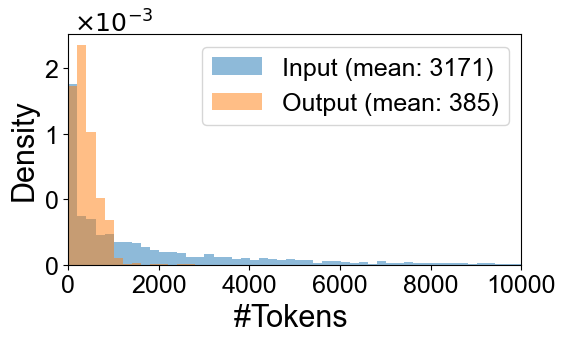

In [270]:
plot_hist( [sharegpt_input_len, sharegpt_output_len], 'sharegpt-multi', 10000)

## Recompute & Swap Overhead

In [271]:
plt.rcParams.update({'font.size': 18})
def plot_overhead_len(overhead_list, file_name, xrange=(0,10000), yrange=(0,1), scatter=True, legend=False): 
    plt.figure(figsize=(4,3))
    for length, overhead, label in overhead_list:
        if scatter:
            plt.scatter(length[1:], overhead[1:], marker='.', linestyle='-', label=label)
        else:
            plt.plot(length[1:], overhead[1:], marker='.', linestyle='-', label=label)
    plt.xlabel('# Tokens')
    plt.ylabel('Overhead (s)')
    if legend: 
        plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.3), ncol=3, frameon=False)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # plt.tight_layout()
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.savefig(f'{file_name}-overhead.pdf', bbox_inches='tight')
    plt.show()
    
def convert_block_token(block_list):
    return [b*16 for b in block_list]

### A40 - Phi-MoE

In [272]:
# Recompute overheads
ttft=[3.388199832290411, 0.2355598621070385, 0.5071729682385921, 0.06450297310948372, 0.06622843071818352, 0.696742232888937, 1.2977059334516525, 0.1990949660539627, 0.06988070532679558, 0.0656413696706295, 0.31670039519667625, 0.12788120657205582, 0.1529085859656334, 0.12310285493731499, 0.7786967940628529, 0.21850264444947243, 1.9290687590837479, 0.11905751377344131, 0.15497002005577087, 1.5652428269386292, 0.06853169202804565, 0.29328930005431175, 0.47148124128580093, 0.39825448766350746, 0.3690235912799835, 0.3475509397685528, 3.944665029644966, 3.3117403723299503, 0.06794454157352448, 0.3519597239792347, 0.09338629990816116, 0.17848759144544601, 0.06544835865497589, 0.15359459072351456, 0.13065249472856522, 0.06580245867371559, 0.16626077517867088, 0.12695682048797607, 2.2501938976347446, 0.75596609339118, 0.13903214037418365, 0.5175291821360588, 0.4387298561632633, 0.0713978037238121, 0.06581462174654007, 0.211192786693573, 0.3446166254580021, 0.0673871859908104, 0.08391094207763672, 0.2125103995203972, 0.06451787427067757, 0.12275519222021103, 0.1053665243089199, 0.06518618389964104, 0.16363830491900444, 0.28153232112526894, 0.18176094442605972, 2.3052938394248486, 0.24484505504369736, 0.06408363580703735, 0.06546414643526077, 0.1351683884859085, 0.08515316992998123, 0.06422735005617142, 0.08876427635550499, 0.08020306378602982, 0.1944291703402996, 0.06724287942051888, 3.425933178514242, 0.5094389617443085, 1.494463473558426, 0.5405777357518673, 0.09104624018073082, 0.06614959985017776, 0.06483082845807076, 0.0654228962957859, 0.4038166217505932, 0.06498034298419952, 0.9586885012686253, 0.1533900573849678, 0.0662064328789711, 0.7116416729986668, 0.06381412968039513, 0.0647396482527256, 0.06512785330414772, 0.19037608057260513, 0.07434793934226036, 0.06519045680761337, 0.3150812163949013, 0.23258128762245178, 0.09081468358635902, 0.46334563195705414, 0.06773095205426216, 0.1618967354297638, 0.21681858971714973, 0.064940445125103, 0.17329039052128792, 0.06469803676009178]
input_len=[8920, 1683, 1852, 18, 65, 5412, 12389, 612, 384, 104, 2883, 874, 1140, 787, 6670, 1454, 17234, 759, 1409, 13035, 309, 2343, 1961, 3875, 2637, 2743, 28148, 29923, 307, 1107, 587, 1591, 14, 991, 1007, 83, 1165, 861, 18200, 7636, 1086, 3774, 3217, 354, 25, 1550, 2598, 316, 495, 1462, 21, 892, 318, 44, 1422, 2062, 1951, 17238, 2133, 19, 16, 933, 477, 5, 485, 533, 1338, 286, 31361, 3849, 8504, 4191, 555, 50, 7, 44, 3242, 104, 7388, 1536, 11, 6520, 1, 17, 68, 1304, 222, 7, 3262, 1747, 510, 3479, 340, 1409, 1589, 74, 1335, 27]


In [273]:

swapin_blocks=[19, 19, 19, 19, 42, 42, 42, 42, 13, 13, 13, 13, 195, 195, 195, 195, 151, 151, 151, 151, 38, 38, 38, 38, 66, 66, 66, 66, 111, 111, 111, 111, 190, 190, 190, 190, 97, 97, 97, 97, 138, 138, 138, 138, 63, 63, 63, 63, 70, 70, 70, 70, 141, 141, 141, 141, 59, 59, 59, 59, 22, 22, 22, 22, 202, 202, 202, 202, 125, 125, 125, 125, 99, 99, 99, 99, 71, 71, 71, 71, 134, 134, 134, 134, 170, 170, 170, 170, 118, 118, 118, 118, 127, 127, 127, 127, 45, 45, 45, 45, 99, 99, 99, 99, 59, 59, 59, 59, 166, 166, 166, 166, 64, 64, 64, 64, 179, 179, 179, 179, 169, 169, 169, 169, 121, 121, 121, 121, 78, 78, 78, 78, 227, 227, 227, 227, 100, 100, 100, 100, 113, 113, 113, 113, 47, 47, 47, 47, 200, 200, 200, 200, 121, 121, 121, 121, 44, 44, 44, 44, 123, 123, 123, 123, 154, 154, 154, 154, 97, 97, 97, 97, 118, 118, 118, 118, 118, 118, 118, 118, 133, 133, 133, 133, 175, 175, 175, 175, 345, 345, 345, 345, 62, 62, 62, 62, 149, 149, 149, 149, 33, 33, 33, 33, 147, 147, 147, 147, 239, 239, 239, 239, 111, 111, 111, 111, 181, 181, 181, 181, 36, 36, 36, 36, 219, 219, 219, 219, 250, 250, 250, 250, 188, 188, 188, 188, 108, 108, 108, 108, 117, 117, 117, 117, 180, 180, 180, 180, 109, 109, 109, 109, 102, 102, 102, 102, 280, 280, 280, 280, 524, 524, 524, 524, 33, 33, 33, 33, 35, 35, 35, 35, 584, 584, 584, 584, 267, 267, 267, 267, 473, 473, 473, 473, 77, 77, 77, 77, 280, 280, 280, 280, 313, 313, 313, 313, 61, 61, 61, 61, 75, 75, 75, 75, 46, 46, 46, 46, 89, 89, 89, 89, 152, 152, 152, 152, 51, 51, 51, 51, 93, 93, 93, 93, 76, 76, 76, 76, 308, 308, 308, 308, 171, 171, 171, 171, 218, 218, 218, 218, 238, 238, 238, 238, 272, 272, 272, 272, 382, 382, 382, 382, 46, 46, 46, 46, 75, 75, 75, 75, 465, 465, 465, 465, 490, 490, 490, 490, 126, 126, 126, 126, 58, 58, 58, 58, 320, 320, 320, 320, 57, 57, 57, 57, 353, 353, 353, 353, 95, 95, 95, 95, 410, 410, 410, 410, 178, 178, 178, 178, 15, 15, 15, 15, 38, 38, 38, 38, 246, 246, 246, 246, 116, 116, 116, 116, 85, 85, 85, 85, 87, 87, 87, 87, 474, 474, 474, 474, 530, 530, 530, 530, 40, 40, 40, 40, 82, 82, 82, 82, 325, 325, 325, 325, 110, 110, 110, 110, 35, 35, 35, 35, 69, 69, 69, 69, 53, 53, 53, 53, 45, 45, 45, 45, 89, 89, 89, 89, 141, 141, 141, 141, 73, 73, 73, 73, 137, 137, 137, 137, 183, 183, 183, 183, 233, 233, 233, 233, 482, 482, 482, 482, 63, 63, 63, 63, 366, 366, 366, 366, 160, 160, 160, 160, 23, 23, 23, 23, 77, 77, 77, 77, 86, 86, 86, 86, 763, 763, 763, 763, 58, 58, 58, 58, 110, 110, 110, 110, 199, 199, 199, 199, 40, 40, 40, 40, 557, 557, 557, 557, 53, 53, 53, 53, 97, 97, 97, 97, 142, 142, 142, 142, 87, 87, 87, 87, 60, 60, 60, 60, 492, 492, 492, 492, 44, 44, 44, 44, 30, 30, 30, 30, 71, 71, 71, 71, 127, 127, 127, 127, 95, 95, 95, 95, 129, 129, 129, 129, 409, 409, 409, 409, 267, 267, 267, 267, 355, 355, 355, 355, 68, 68, 68, 68, 50, 50, 50, 50, 100, 100, 100, 100, 82, 82, 82, 82, 159, 159, 159, 159, 108, 108, 108, 108, 146, 146, 146, 146, 99, 99, 99, 99, 122, 122, 122, 122, 248, 248, 248, 248, 174, 174, 174, 174, 317, 317, 317, 317, 71, 71, 71, 71, 329, 329, 329, 329, 123, 123, 123, 123, 626, 626, 626, 626, 130, 130, 130, 130, 12, 12, 12, 12, 47, 47, 47, 47, 373, 373, 373, 373, 326, 326, 326, 326, 77, 77, 77, 77, 253, 253, 253, 253, 28, 28, 28, 28, 88, 88, 88, 88, 110, 110, 110, 110, 133, 133, 133, 133, 65, 65, 65, 65, 21, 21, 21, 21, 36, 36, 36, 36, 30, 30, 30, 30, 320, 320, 320, 320, 188, 188, 188, 188, 114, 114, 114, 114, 1190, 1190, 1190, 1190, 112, 112, 112, 112, 237, 237, 237, 237, 56, 56, 56, 56, 525, 525, 525, 525, 24, 24, 24, 24, 149, 149, 149, 149, 315, 315, 315, 315, 252, 252, 252, 252, 29, 29, 29, 29, 84, 84, 84, 84, 134, 134, 134, 134, 126, 126, 126, 126, 148, 148, 148, 148, 35, 35, 35, 35, 48, 48, 48, 48, 287, 287, 287, 287, 42, 42, 42, 42, 42, 42, 42, 42, 158, 158, 158, 158, 242, 242, 242, 242, 74, 74, 74, 74, 248, 248, 248, 248, 242, 242, 242, 242, 123, 123, 123, 123, 258, 258, 258, 258, 251, 251, 251, 251, 234, 234, 234, 234, 160, 160, 160, 160, 98, 98, 98, 98, 137, 137, 137, 137, 191, 191, 191, 191, 28, 28, 28, 28, 39, 39, 39, 39, 245, 245, 245, 245, 179, 179, 179, 179, 223, 223, 223, 223, 205, 205, 205, 205, 162, 162, 162, 162, 129, 129, 129, 129, 64, 64, 64, 64, 83, 83, 83, 83, 177, 177, 177, 177, 433, 433, 433, 433, 351, 351, 351, 351, 46, 46, 46, 46, 74, 74, 74, 74, 284, 284, 284, 284, 100, 100, 100, 100, 274, 274, 274, 274, 215, 215, 215, 215, 155, 155, 155, 155, 67, 67, 67, 67, 21, 21, 21, 21, 76, 76, 76, 76, 276, 276, 276, 276, 76, 76, 76, 76, 187, 187, 187, 187, 24, 24, 24, 24, 157, 157, 157, 157, 298, 298, 298, 298, 78, 78, 78, 78, 174, 174, 174, 174, 19, 19, 19, 19, 416, 416, 416, 416, 43, 43, 43, 43, 198, 198, 198, 198, 84, 84, 84, 84, 23, 23, 23, 23, 205, 205, 205, 205, 166, 166, 166, 166, 210, 210, 210, 210, 201, 201, 201, 201, 140, 140, 140, 140, 24, 24, 24, 24, 51, 51, 51, 51, 74, 74, 74, 74, 227, 227, 227, 227, 47, 47, 47, 47, 513, 513, 513, 513, 48, 48, 48, 48, 101, 101, 101, 101, 105, 105, 105, 105, 68, 68, 68, 68, 150, 150, 150, 150, 52, 52, 52, 52, 419, 419, 419, 419, 62, 62, 62, 62, 180, 180, 180, 180, 378, 378, 378, 378, 245, 245, 245, 245, 31, 31, 31, 31, 99, 99, 99, 99, 326, 326, 326, 326, 206, 206, 206, 206, 37, 37, 37, 37, 224, 224, 224, 224, 176, 176, 176, 176, 57, 57, 57, 57, 61, 61, 61, 61, 816, 816, 816, 816, 169, 169, 169, 169, 143, 143, 143, 143, 91, 91, 91, 91, 654, 654, 654, 654, 32, 32, 32, 32, 193, 193, 193, 193, 250, 250, 250, 250, 123, 123, 123, 123, 152, 152, 152, 152, 115, 115, 115, 115, 340, 340, 340, 340, 47, 47, 47, 47, 20, 20, 20, 20, 23, 23, 23, 23, 127, 127, 127, 127, 249, 249, 249, 249, 52, 52, 52, 52, 256, 256, 256, 256, 253, 253, 253, 253, 64, 64, 64, 64, 155, 155, 155, 155, 207, 207, 207, 207, 206, 206, 206, 206, 47, 47, 47, 47, 46, 46, 46, 46, 59, 59, 59, 59, 268, 268, 268, 268, 23, 23, 23, 23, 29, 29, 29, 29, 96, 96, 96, 96, 275, 275, 275, 275, 88, 88, 88, 88, 128, 128, 128, 128, 95, 95, 95, 95, 253, 253, 253, 253, 28, 28, 28, 28, 26, 26, 26, 26, 135, 135, 135, 135, 91, 91, 91, 91, 37, 37, 37, 37, 77, 77, 77, 77, 48, 48, 48, 48, 135, 135, 135, 135, 234, 234, 234, 234, 395, 395, 395, 395, 126, 126, 126, 126, 76, 76, 76, 76, 224, 224, 224, 224, 44, 44, 44, 44, 190, 190, 190, 190, 116, 116, 116, 116, 168, 168, 168, 168, 56, 56, 56, 56, 96, 96, 96, 96, 35, 35, 35, 35, 42, 42, 42, 42, 56, 56, 56, 56, 597, 597, 597, 597, 71, 71, 71, 71, 65, 65, 65, 65, 186, 186, 186, 186, 178, 178, 178, 178, 108, 108, 108, 108, 19, 19, 19, 19, 35, 35, 35, 35, 94, 94, 94, 94, 188, 188, 188, 188, 56, 56, 56, 56, 140, 140, 140, 140, 43, 43, 43, 43, 91, 91, 91, 91, 133, 133, 133, 133, 141, 141, 141, 141, 119, 119, 119, 119, 204, 204, 204, 204, 199, 199, 199, 199, 173, 173, 173, 173, 535, 535, 535, 535, 64, 64, 64, 64, 36, 36, 36, 36, 57, 57, 57, 57, 195, 195, 195, 195, 133, 133, 133, 133, 225, 225, 225, 225, 109, 109, 109, 109, 167, 167, 167, 167, 89, 89, 89, 89, 1107, 1107, 1107, 1107, 105, 105, 105, 105, 334, 334, 334, 334, 102, 102, 102, 102, 40, 40, 40, 40, 101, 101, 101, 101, 112, 112, 112, 112, 289, 289, 289, 289, 145, 145, 145, 145, 785, 785, 785, 785, 209, 209, 209, 209, 50, 50, 50, 50, 26, 26, 26, 26, 117, 117, 117, 117, 100, 100, 100, 100, 248, 248, 248, 248, 44, 44, 44, 44, 152, 152, 152, 152, 299, 299, 299, 299, 93, 93, 93, 93, 72, 72, 72, 72, 163, 163, 163, 163, 220, 220, 220, 220, 55, 55, 55, 55, 387, 387, 387, 387, 136, 136, 136, 136, 58, 58, 58, 58, 79, 79, 79, 79, 78, 78, 78, 78, 191, 191, 191, 191, 12, 12, 12, 12, 72, 72, 72, 72, 66, 66, 66, 66, 38, 38, 38, 38, 69, 69, 69, 69, 43, 43, 43, 43, 114, 114, 114, 114, 20, 20, 20, 20, 609, 609, 609, 609, 49, 49, 49, 49, 128, 128, 128, 128, 134, 134, 134, 134, 52, 52, 52, 52, 264, 264, 264, 264, 120, 120, 120, 120, 79, 79, 79, 79, 44, 44, 44, 44, 51, 51, 51, 51, 81, 81, 81, 81, 132, 132, 132, 132, 268, 268, 268, 268, 37, 37, 37, 37, 39, 39, 39, 39, 33, 33, 33, 33, 79, 79, 79, 79, 271, 271, 271, 271, 220, 220, 220, 220, 76, 76, 76, 76, 206, 206, 206, 206, 124, 124, 124, 124, 219, 219, 219, 219, 116, 116, 116, 116, 319, 319, 319, 319, 133, 133, 133, 133, 54, 54, 54, 54, 617, 617, 617, 617, 124, 124, 124, 124, 85, 85, 85, 85, 173, 173, 173, 173, 591, 591, 591, 591, 165, 165, 165, 165, 16, 16, 16, 16, 180, 180, 180, 180, 38, 38, 38, 38, 1213, 1213, 1213, 1213, 149, 149, 149, 149, 1220, 1220, 1220, 1220, 33, 33, 33, 33, 408, 408, 408, 408, 1240, 1240, 1240, 1240, 54, 54, 54, 54, 91, 91, 91, 91, 49, 49, 49, 49, 358, 358, 358, 358, 63, 63, 63, 63, 160, 160, 160, 160, 317, 317, 317, 317, 92, 92, 92, 92, 79, 79, 79, 79, 50, 50, 50, 50, 480, 480, 480, 480, 192, 192, 192, 192, 67, 67, 67, 67, 86, 86, 86, 86, 70, 70, 70, 70, 200, 200, 200, 200, 233, 233, 233, 233, 132, 132, 132, 132, 88, 88, 88, 88, 98, 98, 98, 98, 60, 60, 60, 60, 429, 429, 429, 429, 137, 137, 137, 137, 154, 154, 154, 154, 50, 50, 50, 50, 262, 262, 262, 262, 82, 82, 82, 82, 434, 434, 434, 434, 319, 319, 319, 319, 45, 45, 45, 45, 303, 303, 303, 303, 279, 279, 279, 279, 281, 281, 281, 281, 217, 217, 217, 217, 121, 121, 121, 121, 143, 143, 143, 143, 98, 98, 98, 98, 161, 161, 161, 161, 511, 511, 511, 511, 312, 312, 312, 312, 404, 404, 404, 404, 118, 118, 118, 118, 105, 105, 105, 105, 380, 380, 380, 380, 443, 443, 443, 443, 54, 54, 54, 54, 486, 486, 486, 486, 49, 49, 49, 49, 138, 138, 138, 138, 244, 244, 244, 244, 97, 97, 97, 97, 105, 105, 105, 105, 63, 63, 63, 63, 96, 96, 96, 96, 67, 67, 67, 67, 62, 62, 62, 62, 49, 49, 49, 49, 254, 254, 254, 254, 37, 37, 37, 37, 280, 280, 280, 280, 32, 32, 32, 32, 196, 196, 196, 196, 87, 87, 87, 87]
swapin_overheads=[0.004864931106567383, 0.004900932312011719, 0.005171298980712891, 0.005219221115112305, 0.010102987289428711, 0.010166168212890625, 0.010577917098999023, 0.010789632797241211, 0.003475189208984375, 0.0034945011138916016, 0.0037267208099365234, 0.003755807876586914, 0.044297218322753906, 0.04445219039916992, 0.0469663143157959, 0.04756331443786621, 0.034508466720581055, 0.034568071365356445, 0.036507368087768555, 0.03758668899536133, 0.009096860885620117, 0.009154319763183594, 0.00965428352355957, 0.009807825088500977, 0.015385866165161133, 0.01537775993347168, 0.016238927841186523, 0.016561508178710938, 0.025420665740966797, 0.025429964065551758, 0.02692389488220215, 0.027469396591186523, 0.04368019104003906, 0.04551124572753906, 0.04668068885803223, 0.0480039119720459, 0.022255659103393555, 0.023542165756225586, 0.024227380752563477, 0.026822328567504883, 0.03149247169494629, 0.03349494934082031, 0.03415656089782715, 0.03625655174255371, 0.014640569686889648, 0.014762163162231445, 0.015503883361816406, 0.015851974487304688, 0.016227006912231445, 0.017156124114990234, 0.017647266387939453, 0.02081155776977539, 0.032151222229003906, 0.03227734565734863, 0.03423810005187988, 0.034620046615600586, 0.013805627822875977, 0.013864755630493164, 0.014869928359985352, 0.014880657196044922, 0.005509138107299805, 0.005648374557495117, 0.005911350250244141, 0.005893230438232422, 0.04578137397766113, 0.045970916748046875, 0.049639225006103516, 0.0501711368560791, 0.02858901023864746, 0.0286715030670166, 0.030445575714111328, 0.030668258666992188, 0.02280902862548828, 0.022786855697631836, 0.024085521697998047, 0.025317668914794922, 0.016546249389648438, 0.016691923141479492, 0.017904281616210938, 0.018306732177734375, 0.030623912811279297, 0.03061819076538086, 0.032669782638549805, 0.03304576873779297, 0.038741111755371094, 0.03892707824707031, 0.041080474853515625, 0.041852712631225586, 0.0270383358001709, 0.027050495147705078, 0.029335975646972656, 0.029504776000976562, 0.02922534942626953, 0.029361248016357422, 0.0315248966217041, 0.032090187072753906, 0.01073765754699707, 0.010782241821289062, 0.011354207992553711, 0.011484861373901367, 0.022939443588256836, 0.022919178009033203, 0.02449822425842285, 0.02480340003967285, 0.013871192932128906, 0.013898849487304688, 0.014720439910888672, 0.014945268630981445, 0.03777360916137695, 0.03802347183227539, 0.04049086570739746, 0.04079246520996094, 0.015054702758789062, 0.015038490295410156, 0.015917301177978516, 0.016126632690429688, 0.04095959663391113, 0.04099535942077637, 0.04326605796813965, 0.04421710968017578, 0.038590192794799805, 0.038629770278930664, 0.04075765609741211, 0.04143571853637695, 0.027677297592163086, 0.02764105796813965, 0.029285430908203125, 0.030006885528564453, 0.01822352409362793, 0.018172740936279297, 0.019705772399902344, 0.02009868621826172, 0.05136609077453613, 0.05151629447937012, 0.05449414253234863, 0.05611896514892578, 0.02297067642211914, 0.022949695587158203, 0.02431035041809082, 0.024893760681152344, 0.025839805603027344, 0.025878190994262695, 0.0276796817779541, 0.028033971786499023, 0.011140584945678711, 0.01118326187133789, 0.011815309524536133, 0.012217283248901367, 0.045418500900268555, 0.0454103946685791, 0.04808783531188965, 0.04901528358459473, 0.027801990509033203, 0.0278167724609375, 0.02937936782836914, 0.030007123947143555, 0.010472297668457031, 0.01052546501159668, 0.011211872100830078, 0.011365890502929688, 0.028209686279296875, 0.0282742977142334, 0.030144691467285156, 0.03047037124633789, 0.035151004791259766, 0.035303592681884766, 0.03737068176269531, 0.03812861442565918, 0.022313594818115234, 0.022392749786376953, 0.023777246475219727, 0.024346113204956055, 0.027187108993530273, 0.027149438858032227, 0.028702974319458008, 0.02942824363708496, 0.027079105377197266, 0.027161121368408203, 0.028667688369750977, 0.029211997985839844, 0.030555009841918945, 0.030478477478027344, 0.03243613243103027, 0.03277301788330078, 0.03980541229248047, 0.03975415229797363, 0.04270195960998535, 0.04282641410827637, 0.0782172679901123, 0.07833743095397949, 0.0824272632598877, 0.08394169807434082, 0.014789581298828125, 0.014931678771972656, 0.015469074249267578, 0.01573967933654785, 0.03416180610656738, 0.03680825233459473, 0.05237436294555664, 0.05292630195617676, 0.007997274398803711, 0.008039474487304688, 0.008556365966796875, 0.008704662322998047, 0.033649444580078125, 0.033731698989868164, 0.03635144233703613, 0.03624463081359863, 0.0541384220123291, 0.05394124984741211, 0.057698726654052734, 0.05847001075744629, 0.02517533302307129, 0.025552034378051758, 0.027187108993530273, 0.02759075164794922, 0.041187286376953125, 0.04130244255065918, 0.04374575614929199, 0.04432034492492676, 0.00865316390991211, 0.00863027572631836, 0.009442806243896484, 0.009311199188232422, 0.04960966110229492, 0.04982161521911621, 0.052645206451416016, 0.055106401443481445, 0.056310415267944336, 0.05652737617492676, 0.05987071990966797, 0.06267714500427246, 0.04242348670959473, 0.042584896087646484, 0.04522895812988281, 0.046205997467041016, 0.024588584899902344, 0.024866104125976562, 0.02642989158630371, 0.02676534652709961, 0.026763200759887695, 0.026790142059326172, 0.02900099754333496, 0.028943777084350586, 0.04072999954223633, 0.04126739501953125, 0.04348349571228027, 0.044329166412353516, 0.0249025821685791, 0.025115013122558594, 0.026837825775146484, 0.026806354522705078, 0.02384209632873535, 0.02390265464782715, 0.02529430389404297, 0.025778532028198242, 0.06308960914611816, 0.06311345100402832, 0.06751251220703125, 0.06829833984375, 0.11676478385925293, 0.11773800849914551, 0.12897324562072754, 0.1291053295135498, 0.007939338684082031, 0.008102893829345703, 0.008505582809448242, 0.008654594421386719, 0.008367061614990234, 0.008402824401855469, 0.009111404418945312, 0.00907754898071289, 0.13095426559448242, 0.13112163543701172, 0.13915705680847168, 0.14079689979553223, 0.060443878173828125, 0.06081533432006836, 0.06427407264709473, 0.06553888320922852, 0.10681271553039551, 0.10717892646789551, 0.11321687698364258, 0.11517906188964844, 0.017818450927734375, 0.017917871475219727, 0.01904582977294922, 0.01975727081298828, 0.06292605400085449, 0.06300234794616699, 0.06699562072753906, 0.0688161849975586, 0.07042241096496582, 0.07062101364135742, 0.07521176338195801, 0.07804250717163086, 0.014296293258666992, 0.014306306838989258, 0.015113353729248047, 0.015579462051391602, 0.01737070083618164, 0.017335176467895508, 0.018768310546875, 0.01882481575012207, 0.010832071304321289, 0.010880231857299805, 0.011555194854736328, 0.011871576309204102, 0.020487070083618164, 0.02048802375793457, 0.022034645080566406, 0.022388696670532227, 0.034654855728149414, 0.03458714485168457, 0.036637067794799805, 0.03772306442260742, 0.01197052001953125, 0.012054920196533203, 0.012810230255126953, 0.013108968734741211, 0.021583080291748047, 0.021567344665527344, 0.022700071334838867, 0.0231015682220459, 0.01773667335510254, 0.017709732055664062, 0.018903493881225586, 0.019011259078979492, 0.06948280334472656, 0.07378244400024414, 0.0732886791229248, 0.07474517822265625, 0.03882622718811035, 0.04118752479553223, 0.04174971580505371, 0.043093204498291016, 0.04956245422363281, 0.049475669860839844, 0.05246376991271973, 0.05301523208618164, 0.05456256866455078, 0.05447530746459961, 0.057672739028930664, 0.05896329879760742, 0.06192898750305176, 0.061805009841918945, 0.06580615043640137, 0.06804656982421875, 0.0861823558807373, 0.0863962173461914, 0.09232521057128906, 0.09415078163146973, 0.010976314544677734, 0.01108860969543457, 0.011673212051391602, 0.011842489242553711, 0.017558574676513672, 0.018642425537109375, 0.018421411514282227, 0.020602703094482422, 0.10619425773620605, 0.10610175132751465, 0.11144137382507324, 0.11319160461425781, 0.11121034622192383, 0.11112427711486816, 0.11748266220092773, 0.11970210075378418, 0.029183387756347656, 0.029151439666748047, 0.030917644500732422, 0.031195640563964844, 0.013793230056762695, 0.013906240463256836, 0.014735937118530273, 0.014975547790527344, 0.07286930084228516, 0.07275223731994629, 0.07660198211669922, 0.07783055305480957, 0.01370382308959961, 0.01367807388305664, 0.014487028121948242, 0.014653444290161133, 0.08029532432556152, 0.08024120330810547, 0.08478975296020508, 0.08592438697814941, 0.022081375122070312, 0.02225637435913086, 0.02362799644470215, 0.023648500442504883, 0.09319901466369629, 0.09326386451721191, 0.09898805618286133, 0.09974884986877441, 0.0409548282623291, 0.04096555709838867, 0.04314851760864258, 0.043807268142700195, 0.003990888595581055, 0.004072904586791992, 0.004246950149536133, 0.004300832748413086, 0.009371757507324219, 0.009354829788208008, 0.009818553924560547, 0.010007619857788086, 0.05585122108459473, 0.05597233772277832, 0.059653282165527344, 0.060155630111694336, 0.026847124099731445, 0.026807308197021484, 0.028428316116333008, 0.0287628173828125, 0.01977086067199707, 0.019896268844604492, 0.020954370498657227, 0.021432876586914062, 0.02039813995361328, 0.020386934280395508, 0.02169966697692871, 0.02182936668395996, 0.10761547088623047, 0.10747647285461426, 0.11403155326843262, 0.11530542373657227, 0.12022852897644043, 0.12028861045837402, 0.126969575881958, 0.1287250518798828, 0.00970602035522461, 0.009677886962890625, 0.010463714599609375, 0.01093149185180664, 0.01921987533569336, 0.0192263126373291, 0.02034759521484375, 0.020470619201660156, 0.07403135299682617, 0.07422113418579102, 0.07819938659667969, 0.07984066009521484, 0.025330066680908203, 0.025609254837036133, 0.02694249153137207, 0.027498245239257812, 0.008560419082641602, 0.008592367172241211, 0.009058237075805664, 0.009335756301879883, 0.01613306999206543, 0.016187191009521484, 0.01715993881225586, 0.017560958862304688, 0.012644052505493164, 0.012817621231079102, 0.013588905334472656, 0.013713836669921875, 0.010924339294433594, 0.011052608489990234, 0.011599063873291016, 0.011661767959594727, 0.020653724670410156, 0.020802736282348633, 0.02200770378112793, 0.022479534149169922, 0.03227376937866211, 0.03265833854675293, 0.03459811210632324, 0.034836530685424805, 0.01698160171508789, 0.017154932022094727, 0.018091678619384766, 0.018451929092407227, 0.03142094612121582, 0.03162550926208496, 0.03353285789489746, 0.03385329246520996, 0.04214787483215332, 0.04297351837158203, 0.04540395736694336, 0.04575753211975098, 0.05313682556152344, 0.05303049087524414, 0.056464195251464844, 0.05738520622253418, 0.10884594917297363, 0.10924887657165527, 0.11548733711242676, 0.11693978309631348, 0.014706850051879883, 0.014976739883422852, 0.015837669372558594, 0.016110658645629883, 0.08268475532531738, 0.0832526683807373, 0.08815503120422363, 0.08913373947143555, 0.037085533142089844, 0.03720545768737793, 0.03891253471374512, 0.0392916202545166, 0.005850076675415039, 0.00619196891784668, 0.006323575973510742, 0.005988121032714844, 0.01793837547302246, 0.017970800399780273, 0.019142866134643555, 0.019378185272216797, 0.01994490623474121, 0.02005171775817871, 0.02116703987121582, 0.021851062774658203, 0.17157697677612305, 0.17212247848510742, 0.18202924728393555, 0.18591713905334473, 0.01368260383605957, 0.013632774353027344, 0.014509201049804688, 0.01474761962890625, 0.025592327117919922, 0.02556920051574707, 0.02692413330078125, 0.02787613868713379, 0.04551339149475098, 0.045720577239990234, 0.04812026023864746, 0.04931521415710449, 0.009645462036132812, 0.009648323059082031, 0.01023244857788086, 0.010413169860839844, 0.12506842613220215, 0.12518000602722168, 0.1335904598236084, 0.13590598106384277, 0.012521505355834961, 0.012562036514282227, 0.013311147689819336, 0.01370549201965332, 0.022567033767700195, 0.022737741470336914, 0.024031400680541992, 0.024918794631958008, 0.03273153305053711, 0.03267168998718262, 0.03453850746154785, 0.03521299362182617, 0.020260334014892578, 0.02016925811767578, 0.021483898162841797, 0.02184152603149414, 0.014181375503540039, 0.014144182205200195, 0.01504206657409668, 0.015429019927978516, 0.11033368110656738, 0.11050295829772949, 0.11772394180297852, 0.11973762512207031, 0.010521173477172852, 0.010556936264038086, 0.011155128479003906, 0.011358976364135742, 0.007455110549926758, 0.007540464401245117, 0.00782012939453125, 0.007981538772583008, 0.016709089279174805, 0.016729354858398438, 0.017646074295043945, 0.017956256866455078, 0.029273033142089844, 0.029466867446899414, 0.031088590621948242, 0.0315554141998291, 0.021945476531982422, 0.022095680236816406, 0.02329707145690918, 0.0239717960357666, 0.029712915420532227, 0.029755592346191406, 0.03204846382141113, 0.03209829330444336, 0.09199810028076172, 0.09233975410461426, 0.09803533554077148, 0.10071873664855957, 0.061167240142822266, 0.061382293701171875, 0.0649259090423584, 0.06540989875793457, 0.08046579360961914, 0.08074140548706055, 0.0853269100189209, 0.0865020751953125, 0.015955686569213867, 0.015899658203125, 0.016941308975219727, 0.017255067825317383, 0.012175321578979492, 0.012148141860961914, 0.012668609619140625, 0.013386011123657227, 0.023158550262451172, 0.023387670516967773, 0.024710416793823242, 0.024988174438476562, 0.01926589012145996, 0.019280672073364258, 0.020355701446533203, 0.02090620994567871, 0.03660941123962402, 0.036475181579589844, 0.038838863372802734, 0.039443016052246094, 0.025156259536743164, 0.025082111358642578, 0.026513099670410156, 0.027057886123657227, 0.033616065979003906, 0.03361153602600098, 0.03565859794616699, 0.03634905815124512, 0.02311992645263672, 0.02308821678161621, 0.02446770668029785, 0.025174617767333984, 0.028055191040039062, 0.028183698654174805, 0.02993154525756836, 0.030498266220092773, 0.05641889572143555, 0.05676555633544922, 0.06008291244506836, 0.060640811920166016, 0.03981184959411621, 0.04008126258850098, 0.042504310607910156, 0.04294443130493164, 0.07190847396850586, 0.07238435745239258, 0.07652544975280762, 0.07825040817260742, 0.016562461853027344, 0.016772031784057617, 0.017675399780273438, 0.017860889434814453, 0.0747685432434082, 0.07480573654174805, 0.07895445823669434, 0.08139729499816895, 0.02830958366394043, 0.02829742431640625, 0.030063629150390625, 0.030490398406982422, 0.14083337783813477, 0.14082074165344238, 0.1487874984741211, 0.15505194664001465, 0.029953718185424805, 0.029968976974487305, 0.03167843818664551, 0.03226304054260254, 0.003345489501953125, 0.0035047531127929688, 0.0033659934997558594, 0.0036597251892089844, 0.011173486709594727, 0.0113067626953125, 0.011877059936523438, 0.01207590103149414, 0.08435559272766113, 0.08437728881835938, 0.08940744400024414, 0.09146380424499512, 0.07410621643066406, 0.07408857345581055, 0.07855534553527832, 0.07986640930175781, 0.018200397491455078, 0.018274545669555664, 0.01926445960998535, 0.019561767578125, 0.0575261116027832, 0.05755901336669922, 0.06107378005981445, 0.06276392936706543, 0.006879091262817383, 0.007048130035400391, 0.0073375701904296875, 0.0074901580810546875, 0.0204470157623291, 0.020488500595092773, 0.021776199340820312, 0.022398948669433594, 0.025328636169433594, 0.025446414947509766, 0.02693963050842285, 0.027427196502685547, 0.0305936336517334, 0.030505895614624023, 0.03238558769226074, 0.03342938423156738, 0.015341758728027344, 0.015299320220947266, 0.016315460205078125, 0.01667332649230957, 0.005332469940185547, 0.005442142486572266, 0.005671262741088867, 0.005787372589111328, 0.00867772102355957, 0.008772850036621094, 0.009258031845092773, 0.009449958801269531, 0.0075206756591796875, 0.007489919662475586, 0.007930755615234375, 0.007998466491699219, 0.07229256629943848, 0.07244253158569336, 0.07708168029785156, 0.07890987396240234, 0.04318523406982422, 0.04329180717468262, 0.046326637268066406, 0.04763031005859375, 0.026308298110961914, 0.02655506134033203, 0.027912616729736328, 0.028537988662719727, 0.26688194274902344, 0.26703310012817383, 0.283191442489624, 0.28907275199890137, 0.025885343551635742, 0.026001930236816406, 0.027496337890625, 0.02820134162902832, 0.053965091705322266, 0.05402779579162598, 0.05720043182373047, 0.05857372283935547, 0.013290882110595703, 0.013421773910522461, 0.014133930206298828, 0.014507293701171875, 0.11846423149108887, 0.11856842041015625, 0.125777006149292, 0.12889766693115234, 0.0060100555419921875, 0.006102323532104492, 0.006400108337402344, 0.006642818450927734, 0.03420138359069824, 0.03442263603210449, 0.036313533782958984, 0.03719639778137207, 0.07104730606079102, 0.07151627540588379, 0.07580423355102539, 0.07763361930847168, 0.05730032920837402, 0.0572209358215332, 0.061052799224853516, 0.06200551986694336, 0.007166147232055664, 0.0071184635162353516, 0.007599830627441406, 0.0077114105224609375, 0.019558429718017578, 0.01950526237487793, 0.020688533782958984, 0.02119612693786621, 0.03093862533569336, 0.031056642532348633, 0.03262186050415039, 0.03347420692443848, 0.028960466384887695, 0.029083728790283203, 0.030933856964111328, 0.03148674964904785, 0.03410816192626953, 0.03432750701904297, 0.035976409912109375, 0.03741097450256348, 0.008537530899047852, 0.008593082427978516, 0.009068012237548828, 0.009272336959838867, 0.011466503143310547, 0.011509418487548828, 0.012070178985595703, 0.012560367584228516, 0.06526732444763184, 0.06541991233825684, 0.06942343711853027, 0.07117676734924316, 0.01010894775390625, 0.010153532028198242, 0.0107269287109375, 0.010933876037597656, 0.010155916213989258, 0.010249853134155273, 0.010705232620239258, 0.011016845703125, 0.036618947982788086, 0.036666154861450195, 0.03852725028991699, 0.03962087631225586, 0.05507373809814453, 0.055237770080566406, 0.05825495719909668, 0.059925079345703125, 0.017310619354248047, 0.017357826232910156, 0.018412351608276367, 0.01886272430419922, 0.05670666694641113, 0.05669546127319336, 0.060274600982666016, 0.061759233474731445, 0.05525088310241699, 0.05539584159851074, 0.058893680572509766, 0.05991077423095703, 0.028606653213500977, 0.028497695922851562, 0.030264616012573242, 0.030743837356567383, 0.05894827842712402, 0.059082984924316406, 0.06218266487121582, 0.06378340721130371, 0.057259559631347656, 0.057190895080566406, 0.06053638458251953, 0.061724185943603516, 0.05334615707397461, 0.05330514907836914, 0.05654263496398926, 0.0574798583984375, 0.036646366119384766, 0.036801815032958984, 0.03874921798706055, 0.03992176055908203, 0.022761821746826172, 0.022745370864868164, 0.024060964584350586, 0.024572372436523438, 0.03131985664367676, 0.03149700164794922, 0.033334970474243164, 0.03435564041137695, 0.043612003326416016, 0.043602943420410156, 0.04693746566772461, 0.04752922058105469, 0.006899595260620117, 0.0069773197174072266, 0.007485151290893555, 0.0075588226318359375, 0.009529829025268555, 0.009602069854736328, 0.010029792785644531, 0.010268926620483398, 0.05604696273803711, 0.055938005447387695, 0.059201955795288086, 0.06026768684387207, 0.040997982025146484, 0.041043758392333984, 0.04366612434387207, 0.04430580139160156, 0.051004648208618164, 0.05097794532775879, 0.0539398193359375, 0.05485820770263672, 0.04673886299133301, 0.046790361404418945, 0.0495152473449707, 0.050453901290893555, 0.037050724029541016, 0.037190914154052734, 0.03930211067199707, 0.04002714157104492, 0.029640674591064453, 0.029760360717773438, 0.0314183235168457, 0.03199577331542969, 0.01503896713256836, 0.015170097351074219, 0.01601576805114746, 0.01660919189453125, 0.019383668899536133, 0.019528865814208984, 0.02056574821472168, 0.021039247512817383, 0.040496110916137695, 0.04063892364501953, 0.042870521545410156, 0.04361295700073242, 0.09817385673522949, 0.09830474853515625, 0.10363006591796875, 0.10630154609680176, 0.07939648628234863, 0.0795431137084961, 0.0843963623046875, 0.08591246604919434, 0.01095890998840332, 0.011057615280151367, 0.011615514755249023, 0.011875391006469727, 0.017270803451538086, 0.017377138137817383, 0.018290042877197266, 0.018674135208129883, 0.06464529037475586, 0.06525611877441406, 0.06822872161865234, 0.06957483291625977, 0.02315998077392578, 0.02345132827758789, 0.024669170379638672, 0.024983644485473633, 0.06253981590270996, 0.06291413307189941, 0.06612586975097656, 0.06837940216064453, 0.04897665977478027, 0.04904818534851074, 0.05229520797729492, 0.05263161659240723, 0.035474538803100586, 0.03542804718017578, 0.03762936592102051, 0.037847042083740234, 0.01580357551574707, 0.015790939331054688, 0.01667189598083496, 0.01750040054321289, 0.005425214767456055, 0.005350589752197266, 0.005657672882080078, 0.005682229995727539, 0.017634153366088867, 0.017806053161621094, 0.018807649612426758, 0.01920175552368164, 0.06248140335083008, 0.06314611434936523, 0.06635284423828125, 0.06787896156311035, 0.017839908599853516, 0.018079519271850586, 0.018970489501953125, 0.019305944442749023, 0.04270648956298828, 0.04303598403930664, 0.045479536056518555, 0.0461885929107666, 0.006051540374755859, 0.006075143814086914, 0.006510496139526367, 0.006528377532958984, 0.036131858825683594, 0.03629922866821289, 0.03818178176879883, 0.03895401954650879, 0.06798434257507324, 0.06781911849975586, 0.07246112823486328, 0.07335448265075684, 0.018083810806274414, 0.01826953887939453, 0.019446611404418945, 0.019573211669921875, 0.039886474609375, 0.039975643157958984, 0.04308748245239258, 0.043292999267578125, 0.0049381256103515625, 0.004995822906494141, 0.00524139404296875, 0.005273342132568359, 0.09444427490234375, 0.09465217590332031, 0.10045027732849121, 0.10282230377197266, 0.010364532470703125, 0.010444402694702148, 0.011017322540283203, 0.011298179626464844, 0.04552721977233887, 0.04540610313415527, 0.04814863204956055, 0.04855823516845703, 0.01955556869506836, 0.019957542419433594, 0.0208127498626709, 0.021062850952148438, 0.005845308303833008, 0.005900859832763672, 0.006166696548461914, 0.006327152252197266, 0.04708576202392578, 0.04730558395385742, 0.05038595199584961, 0.05061841011047363, 0.038257598876953125, 0.0383296012878418, 0.0404810905456543, 0.040946245193481445, 0.04793071746826172, 0.04825949668884277, 0.05077314376831055, 0.05145621299743652, 0.045896053314208984, 0.046122074127197266, 0.04906916618347168, 0.04954099655151367, 0.03200411796569824, 0.03222393989562988, 0.03397512435913086, 0.034482717514038086, 0.006019115447998047, 0.006120443344116211, 0.006417512893676758, 0.006495952606201172, 0.01225733757019043, 0.01225423812866211, 0.012904882431030273, 0.013167619705200195, 0.01746511459350586, 0.01738715171813965, 0.018417835235595703, 0.01863574981689453, 0.05149555206298828, 0.05176854133605957, 0.0548555850982666, 0.055548667907714844, 0.011467218399047852, 0.011529684066772461, 0.012104988098144531, 0.012375593185424805, 0.11562609672546387, 0.11578941345214844, 0.12297201156616211, 0.1253068447113037, 0.011477231979370117, 0.011554241180419922, 0.012201786041259766, 0.012422323226928711, 0.02329421043395996, 0.023456573486328125, 0.02466893196105957, 0.025225162506103516, 0.024304628372192383, 0.024721622467041016, 0.025840282440185547, 0.026412248611450195, 0.015656709671020508, 0.015877246856689453, 0.016975879669189453, 0.01731109619140625, 0.03390145301818848, 0.034426212310791016, 0.036577463150024414, 0.03752255439758301, 0.012350082397460938, 0.013069868087768555, 0.013391494750976562, 0.01335763931274414, 0.09437680244445801, 0.09512543678283691, 0.10105371475219727, 0.10176587104797363, 0.01458120346069336, 0.014685392379760742, 0.015532255172729492, 0.01577281951904297, 0.041368722915649414, 0.04178142547607422, 0.04383540153503418, 0.04463696479797363, 0.08547282218933105, 0.08577513694763184, 0.09072589874267578, 0.09201431274414062, 0.05499148368835449, 0.05617523193359375, 0.05952620506286621, 0.06046724319458008, 0.007666587829589844, 0.007729291915893555, 0.008161306381225586, 0.00823211669921875, 0.023133277893066406, 0.023655176162719727, 0.0247042179107666, 0.024771690368652344, 0.07370710372924805, 0.07383918762207031, 0.07877683639526367, 0.07949638366699219, 0.04695892333984375, 0.04699540138244629, 0.0500178337097168, 0.050836801528930664, 0.008963584899902344, 0.009045124053955078, 0.009598970413208008, 0.009718894958496094, 0.0509796142578125, 0.05108141899108887, 0.05440831184387207, 0.0550539493560791, 0.04013538360595703, 0.040290117263793945, 0.042891502380371094, 0.04337787628173828, 0.013521671295166016, 0.013659954071044922, 0.014379501342773438, 0.014730691909790039, 0.01452946662902832, 0.015086174011230469, 0.015558481216430664, 0.015722274780273438, 0.18331122398376465, 0.1843433380126953, 0.19571161270141602, 0.19823622703552246, 0.038565874099731445, 0.03876042366027832, 0.04119729995727539, 0.041730403900146484, 0.03291797637939453, 0.03297829627990723, 0.0349273681640625, 0.035460710525512695, 0.021334171295166016, 0.021325111389160156, 0.022692203521728516, 0.022984981536865234, 0.14710021018981934, 0.1477985382080078, 0.1573643684387207, 0.1594555377960205, 0.007830381393432617, 0.007891416549682617, 0.008363723754882812, 0.008437633514404297, 0.04394936561584473, 0.0441896915435791, 0.04685568809509277, 0.04738306999206543, 0.05654549598693848, 0.05674123764038086, 0.06048154830932617, 0.061022043228149414, 0.028553247451782227, 0.028722047805786133, 0.03045487403869629, 0.030638694763183594, 0.03496813774108887, 0.03501534461975098, 0.037225961685180664, 0.037509918212890625, 0.026558637619018555, 0.026737689971923828, 0.028296232223510742, 0.02871084213256836, 0.07728743553161621, 0.07723879814147949, 0.08222460746765137, 0.08273124694824219, 0.011219501495361328, 0.011353015899658203, 0.011957168579101562, 0.012085914611816406, 0.005128145217895508, 0.005152463912963867, 0.005557537078857422, 0.005534172058105469, 0.0058057308197021484, 0.005842924118041992, 0.006206989288330078, 0.0062713623046875, 0.02945089340209961, 0.02938365936279297, 0.031304359436035156, 0.0315859317779541, 0.05672621726989746, 0.0567934513092041, 0.06114792823791504, 0.06106901168823242, 0.012268543243408203, 0.01240992546081543, 0.013161420822143555, 0.013313770294189453, 0.05834245681762695, 0.05839800834655762, 0.06233811378479004, 0.06446123123168945, 0.05770158767700195, 0.05796623229980469, 0.06150627136230469, 0.06219673156738281, 0.01517343521118164, 0.01508188247680664, 0.01616811752319336, 0.018346786499023438, 0.035416364669799805, 0.035410404205322266, 0.037957191467285156, 0.038877248764038086, 0.04704546928405762, 0.047357797622680664, 0.050461769104003906, 0.05222892761230469, 0.04726719856262207, 0.047566890716552734, 0.05018949508666992, 0.05188465118408203, 0.011261224746704102, 0.011279106140136719, 0.011985540390014648, 0.012275934219360352, 0.01102590560913086, 0.011142730712890625, 0.011729717254638672, 0.013120889663696289, 0.01410675048828125, 0.014095067977905273, 0.014989376068115234, 0.015261411666870117, 0.060872793197631836, 0.061608314514160156, 0.06471085548400879, 0.06638979911804199, 0.0058460235595703125, 0.0058972835540771484, 0.006116628646850586, 0.006180286407470703, 0.007199764251708984, 0.007167339324951172, 0.007599830627441406, 0.007644176483154297, 0.022551298141479492, 0.022690296173095703, 0.023662567138671875, 0.02431201934814453, 0.06262016296386719, 0.06295251846313477, 0.06661772727966309, 0.06879401206970215, 0.020712614059448242, 0.020798206329345703, 0.021858692169189453, 0.02298259735107422, 0.029392004013061523, 0.029789447784423828, 0.03126049041748047, 0.03229236602783203, 0.022227764129638672, 0.022220611572265625, 0.02338409423828125, 0.024636268615722656, 0.057585716247558594, 0.05768251419067383, 0.06126880645751953, 0.06344938278198242, 0.006888389587402344, 0.006947517395019531, 0.007313728332519531, 0.007470369338989258, 0.006574153900146484, 0.006512641906738281, 0.006841421127319336, 0.007081508636474609, 0.031047344207763672, 0.031019210815429688, 0.032961130142211914, 0.033506155014038086, 0.021277189254760742, 0.021291255950927734, 0.022398948669433594, 0.02282094955444336, 0.00923466682434082, 0.009546041488647461, 0.009211301803588867, 0.009851217269897461, 0.018090009689331055, 0.018032073974609375, 0.019124746322631836, 0.019730091094970703, 0.011503219604492188, 0.011637210845947266, 0.012269258499145508, 0.01304483413696289, 0.03100109100341797, 0.03101825714111328, 0.0330655574798584, 0.03385734558105469, 0.053391218185424805, 0.05402016639709473, 0.057153940200805664, 0.05861806869506836, 0.08952522277832031, 0.09021449089050293, 0.09555816650390625, 0.09937167167663574, 0.029103994369506836, 0.02920985221862793, 0.031108617782592773, 0.0319366455078125, 0.01785731315612793, 0.017892837524414062, 0.018929481506347656, 0.019428491592407227, 0.05116009712219238, 0.05117964744567871, 0.05466508865356445, 0.05535078048706055, 0.010605335235595703, 0.010597944259643555, 0.011225223541259766, 0.011712789535522461, 0.04337120056152344, 0.043509483337402344, 0.04652523994445801, 0.0468297004699707, 0.02671360969543457, 0.02695298194885254, 0.028542041778564453, 0.029074668884277344, 0.038658857345581055, 0.03853583335876465, 0.040972232818603516, 0.041788578033447266, 0.013254165649414062, 0.013267040252685547, 0.014258623123168945, 0.01430368423461914, 0.022231340408325195, 0.022208452224731445, 0.02373337745666504, 0.024152278900146484, 0.008545637130737305, 0.008629560470581055, 0.009092092514038086, 0.009332418441772461, 0.010109424591064453, 0.010143518447875977, 0.010876655578613281, 0.011032342910766602, 0.013272285461425781, 0.013240814208984375, 0.014129877090454102, 0.014422178268432617, 0.1347048282623291, 0.13514995574951172, 0.14367198944091797, 0.14596962928771973, 0.016970157623291016, 0.017568111419677734, 0.017689943313598633, 0.01817798614501953, 0.015345096588134766, 0.01561117172241211, 0.01624131202697754, 0.016567230224609375, 0.04276776313781738, 0.0428929328918457, 0.04514360427856445, 0.04603099822998047, 0.04061722755432129, 0.04095935821533203, 0.04335665702819824, 0.04394268989562988, 0.024912357330322266, 0.025120019912719727, 0.02721405029296875, 0.02706003189086914, 0.0049076080322265625, 0.005210399627685547, 0.0051212310791015625, 0.005331993103027344, 0.008500337600708008, 0.008632183074951172, 0.00901937484741211, 0.00922846794128418, 0.021828889846801758, 0.021890878677368164, 0.023291587829589844, 0.02373194694519043, 0.04331803321838379, 0.04327392578125, 0.04567098617553711, 0.04639720916748047, 0.013301849365234375, 0.013488531112670898, 0.014106035232543945, 0.014383554458618164, 0.03234601020812988, 0.03247880935668945, 0.03435516357421875, 0.03491353988647461, 0.010343074798583984, 0.010438203811645508, 0.010947942733764648, 0.011110544204711914, 0.021258115768432617, 0.021399736404418945, 0.022546768188476562, 0.02283501625061035, 0.03054046630859375, 0.030751466751098633, 0.03268146514892578, 0.03325176239013672, 0.032472848892211914, 0.03261399269104004, 0.03431868553161621, 0.03505134582519531, 0.027584314346313477, 0.027505874633789062, 0.0291750431060791, 0.02965712547302246, 0.04677414894104004, 0.04665851593017578, 0.04945707321166992, 0.05043935775756836, 0.04540205001831055, 0.04541182518005371, 0.04818320274353027, 0.04893898963928223, 0.039676666259765625, 0.039834022521972656, 0.04196476936340332, 0.04275918006896973, 0.12050294876098633, 0.12102007865905762, 0.1281898021697998, 0.13046598434448242, 0.015170812606811523, 0.015249252319335938, 0.01611328125, 0.016354084014892578, 0.008830785751342773, 0.009035825729370117, 0.00943899154663086, 0.009695768356323242, 0.013647794723510742, 0.013712882995605469, 0.014342784881591797, 0.01466226577758789, 0.04447174072265625, 0.04476451873779297, 0.047565460205078125, 0.047968387603759766, 0.030928850173950195, 0.031017780303955078, 0.032708168029785156, 0.03423595428466797, 0.05164957046508789, 0.05160951614379883, 0.05435013771057129, 0.05697917938232422, 0.025078773498535156, 0.025324106216430664, 0.026688575744628906, 0.02713179588317871, 0.038394927978515625, 0.03849482536315918, 0.04069828987121582, 0.04153752326965332, 0.02076101303100586, 0.020885229110717773, 0.021961212158203125, 0.02245187759399414, 0.24714446067810059, 0.2500112056732178, 0.2650613784790039, 0.2701890468597412, 0.023944854736328125, 0.02434086799621582, 0.025922775268554688, 0.026160478591918945, 0.07523441314697266, 0.07613992691040039, 0.08054137229919434, 0.0820932388305664, 0.023552656173706055, 0.023849964141845703, 0.025110721588134766, 0.02565479278564453, 0.009692668914794922, 0.009653091430664062, 0.01032400131225586, 0.010386466979980469, 0.0232694149017334, 0.023516178131103516, 0.025282621383666992, 0.025557994842529297, 0.025656461715698242, 0.025780200958251953, 0.0274813175201416, 0.02800774574279785, 0.06553983688354492, 0.06669878959655762, 0.06962132453918457, 0.07108473777770996, 0.033200740814208984, 0.03340554237365723, 0.03545951843261719, 0.03610086441040039, 0.17637252807617188, 0.17629766464233398, 0.1890251636505127, 0.19041013717651367, 0.04769635200500488, 0.04769277572631836, 0.050855398178100586, 0.05174064636230469, 0.011898279190063477, 0.011895179748535156, 0.012710094451904297, 0.0128326416015625, 0.006461381912231445, 0.007100582122802734, 0.006974458694458008, 0.006953239440917969, 0.027114152908325195, 0.027477502822875977, 0.028986454010009766, 0.02990865707397461, 0.023127079010009766, 0.02313685417175293, 0.024894237518310547, 0.025147199630737305, 0.05632209777832031, 0.05635881423950195, 0.060210227966308594, 0.06141519546508789, 0.010542631149291992, 0.010538816452026367, 0.011267900466918945, 0.011482715606689453, 0.034604787826538086, 0.034731149673461914, 0.03701329231262207, 0.03758883476257324, 0.0679621696472168, 0.06826233863830566, 0.07238125801086426, 0.07333755493164062, 0.02146291732788086, 0.021575927734375, 0.02308368682861328, 0.023286104202270508, 0.01679372787475586, 0.016965627670288086, 0.017978668212890625, 0.01826000213623047, 0.037247419357299805, 0.037186622619628906, 0.03981137275695801, 0.04018282890319824, 0.05010342597961426, 0.05010533332824707, 0.05341768264770508, 0.05428147315979004, 0.012914419174194336, 0.012937784194946289, 0.013942241668701172, 0.014025449752807617, 0.08770418167114258, 0.08828115463256836, 0.09338498115539551, 0.09454345703125, 0.03131389617919922, 0.031305789947509766, 0.033344268798828125, 0.033754587173461914, 0.013584136962890625, 0.013653278350830078, 0.014731407165527344, 0.014670848846435547, 0.01852250099182129, 0.018558979034423828, 0.019637346267700195, 0.019873619079589844, 0.01832103729248047, 0.01839900016784668, 0.019415616989135742, 0.019704341888427734, 0.043618202209472656, 0.043602705001831055, 0.0467371940612793, 0.046964168548583984, 0.0033180713653564453, 0.0033402442932128906, 0.003551483154296875, 0.0036160945892333984, 0.01685357093811035, 0.016936779022216797, 0.017947673797607422, 0.01848006248474121, 0.015579938888549805, 0.015623092651367188, 0.016686677932739258, 0.016774892807006836, 0.00921320915222168, 0.009238958358764648, 0.009856224060058594, 0.00995492935180664, 0.016338586807250977, 0.016505956649780273, 0.01731133460998535, 0.01766061782836914, 0.010305166244506836, 0.010316133499145508, 0.011015653610229492, 0.011129379272460938, 0.02622199058532715, 0.026335477828979492, 0.028124332427978516, 0.028679847717285156, 0.005151033401489258, 0.005456209182739258, 0.005195140838623047, 0.005528688430786133, 0.13726186752319336, 0.1374368667602539, 0.14745759963989258, 0.14791607856750488, 0.011719226837158203, 0.011804580688476562, 0.012405633926391602, 0.012674093246459961, 0.029471874237060547, 0.029712677001953125, 0.03131604194641113, 0.03176140785217285, 0.031000375747680664, 0.031034231185913086, 0.03275179862976074, 0.03323554992675781, 0.012331724166870117, 0.012385129928588867, 0.013154029846191406, 0.013263940811157227, 0.060096025466918945, 0.06005263328552246, 0.06409406661987305, 0.0657494068145752, 0.027656078338623047, 0.027785062789916992, 0.02956843376159668, 0.029673099517822266, 0.018572092056274414, 0.018582820892333984, 0.019644498825073242, 0.01997065544128418, 0.010627269744873047, 0.01066899299621582, 0.011247396469116211, 0.01140904426574707, 0.01220560073852539, 0.012207269668579102, 0.012962818145751953, 0.013332366943359375, 0.018776416778564453, 0.018964290618896484, 0.020098209381103516, 0.020578622817993164, 0.030323266983032227, 0.030568838119506836, 0.03255915641784668, 0.03285717964172363, 0.060709476470947266, 0.06081438064575195, 0.06511664390563965, 0.0654911994934082, 0.008928537368774414, 0.00896906852722168, 0.009537220001220703, 0.009644746780395508, 0.009437322616577148, 0.009505033493041992, 0.010039806365966797, 0.01020503044128418, 0.008134603500366211, 0.008115053176879883, 0.008612871170043945, 0.008732080459594727, 0.018452882766723633, 0.018396854400634766, 0.019671916961669922, 0.019771814346313477, 0.061669349670410156, 0.061531782150268555, 0.06565690040588379, 0.06610751152038574, 0.050179481506347656, 0.050244808197021484, 0.053621768951416016, 0.054154396057128906, 0.017966747283935547, 0.017879486083984375, 0.019005775451660156, 0.01926898956298828, 0.04707169532775879, 0.047089576721191406, 0.050345659255981445, 0.05092453956604004, 0.028609275817871094, 0.028887271881103516, 0.030461549758911133, 0.030768394470214844, 0.05004572868347168, 0.05005526542663574, 0.05322861671447754, 0.0538935661315918, 0.026942968368530273, 0.026957273483276367, 0.028699874877929688, 0.0288546085357666, 0.0722503662109375, 0.07213950157165527, 0.07754850387573242, 0.07818388938903809, 0.030315876007080078, 0.03043079376220703, 0.03264975547790527, 0.03284406661987305, 0.012819290161132812, 0.012837648391723633, 0.013810157775878906, 0.01391291618347168, 0.13859224319458008, 0.13855409622192383, 0.1480405330657959, 0.14925813674926758, 0.028664827346801758, 0.02860116958618164, 0.030521631240844727, 0.03095388412475586, 0.019833087921142578, 0.019793987274169922, 0.021116971969604492, 0.021409034729003906, 0.03969597816467285, 0.039632558822631836, 0.04225516319274902, 0.042798757553100586, 0.13316106796264648, 0.13336920738220215, 0.14236783981323242, 0.14360618591308594, 0.03773331642150879, 0.037670135498046875, 0.04001951217651367, 0.04059123992919922, 0.004210948944091797, 0.0044956207275390625, 0.004263877868652344, 0.00465083122253418, 0.04115033149719238, 0.0412907600402832, 0.04355144500732422, 0.04444718360900879, 0.009161233901977539, 0.00915837287902832, 0.009654045104980469, 0.009871959686279297, 0.27142763137817383, 0.2713770866394043, 0.2893812656402588, 0.2948155403137207, 0.033919334411621094, 0.03403735160827637, 0.03639578819274902, 0.03701519966125488, 0.2727019786834717, 0.27311253547668457, 0.2911818027496338, 0.2949352264404297, 0.00806736946105957, 0.008108139038085938, 0.00856471061706543, 0.008748292922973633, 0.0917351245880127, 0.09185576438903809, 0.09748291969299316, 0.09889054298400879, 0.2782280445098877, 0.2785935401916504, 0.2945070266723633, 0.30162835121154785, 0.012816190719604492, 0.013005971908569336, 0.013589859008789062, 0.013893365859985352, 0.021249771118164062, 0.021178483963012695, 0.0224306583404541, 0.022778749465942383, 0.011666297912597656, 0.011897802352905273, 0.012444734573364258, 0.012643575668334961, 0.08080267906188965, 0.08128237724304199, 0.08595085144042969, 0.08719396591186523, 0.014782905578613281, 0.014842987060546875, 0.01574397087097168, 0.01607990264892578, 0.036682844161987305, 0.036778926849365234, 0.03900575637817383, 0.03963136672973633, 0.07199478149414062, 0.0718989372253418, 0.07643628120422363, 0.07780933380126953, 0.02118515968322754, 0.02130722999572754, 0.022686243057250977, 0.023051738739013672, 0.01837944984436035, 0.01843881607055664, 0.019510984420776367, 0.019942283630371094, 0.011914253234863281, 0.012000322341918945, 0.012662410736083984, 0.012891530990600586, 0.10806536674499512, 0.10821199417114258, 0.11497020721435547, 0.11712408065795898, 0.044003963470458984, 0.046895503997802734, 0.04722881317138672, 0.04857015609741211, 0.0157468318939209, 0.01580190658569336, 0.01685047149658203, 0.016939640045166016, 0.020094633102416992, 0.0212552547454834, 0.02155017852783203, 0.022449731826782227, 0.016385555267333984, 0.016413211822509766, 0.01743912696838379, 0.017725706100463867, 0.045569419860839844, 0.04583144187927246, 0.04839015007019043, 0.04932260513305664, 0.053095340728759766, 0.05378532409667969, 0.05632519721984863, 0.05798053741455078, 0.030508756637573242, 0.03040146827697754, 0.03224921226501465, 0.0329136848449707, 0.02063441276550293, 0.02169060707092285, 0.02200794219970703, 0.0229337215423584, 0.022893190383911133, 0.024146318435668945, 0.024649381637573242, 0.025449275970458984, 0.014209270477294922, 0.014341115951538086, 0.015478372573852539, 0.01634979248046875, 0.09683585166931152, 0.09696698188781738, 0.10266637802124023, 0.10527467727661133, 0.03158426284790039, 0.03156852722167969, 0.0333404541015625, 0.033895254135131836, 0.03535795211791992, 0.0355684757232666, 0.03759336471557617, 0.03804445266723633, 0.011914253234863281, 0.011985063552856445, 0.01281285285949707, 0.012851953506469727, 0.059285879135131836, 0.05960702896118164, 0.06318902969360352, 0.06583929061889648, 0.019315481185913086, 0.02034282684326172, 0.02083301544189453, 0.02292323112487793, 0.09804439544677734, 0.10412812232971191, 0.10582709312438965, 0.1061561107635498, 0.07242155075073242, 0.07527041435241699, 0.07677674293518066, 0.07796478271484375, 0.010990381240844727, 0.011070489883422852, 0.011465072631835938, 0.011744976043701172, 0.0687403678894043, 0.06896734237670898, 0.07294511795043945, 0.07416296005249023, 0.06322503089904785, 0.06328129768371582, 0.06747031211853027, 0.06815290451049805, 0.06388568878173828, 0.06393837928771973, 0.06782102584838867, 0.06931447982788086, 0.049657344818115234, 0.04974794387817383, 0.05232405662536621, 0.05339312553405762, 0.028147220611572266, 0.029604673385620117, 0.02999114990234375, 0.031174421310424805, 0.033052682876586914, 0.03400897979736328, 0.0350804328918457, 0.035555124282836914, 0.02269577980041504, 0.022799968719482422, 0.024271249771118164, 0.02479386329650879, 0.03692317008972168, 0.03932499885559082, 0.03986334800720215, 0.04099249839782715, 0.11535882949829102, 0.1155540943145752, 0.12300300598144531, 0.1240088939666748, 0.07073092460632324, 0.0708916187286377, 0.07522201538085938, 0.07607555389404297, 0.09127473831176758, 0.09183573722839355, 0.09701061248779297, 0.09804129600524902, 0.02738642692565918, 0.027315855026245117, 0.029047489166259766, 0.029398441314697266, 0.02428579330444336, 0.024348020553588867, 0.025939226150512695, 0.026276350021362305, 0.08594942092895508, 0.08644318580627441, 0.09150481224060059, 0.09257698059082031, 0.10035276412963867, 0.10064482688903809, 0.10633015632629395, 0.1085965633392334, 0.012731313705444336, 0.012834310531616211, 0.01359248161315918, 0.013813018798828125, 0.1101377010345459, 0.11083650588989258, 0.116424560546875, 0.11902046203613281, 0.011691093444824219, 0.011786699295043945, 0.012418985366821289, 0.012644529342651367, 0.031754255294799805, 0.03180670738220215, 0.03367948532104492, 0.0342860221862793, 0.05555367469787598, 0.055666208267211914, 0.05906033515930176, 0.06030774116516113, 0.02253580093383789, 0.022686243057250977, 0.02387833595275879, 0.024430036544799805, 0.024323701858520508, 0.024425029754638672, 0.025817394256591797, 0.026447057723999023, 0.014864206314086914, 0.014897823333740234, 0.015749692916870117, 0.01605224609375, 0.022446393966674805, 0.022478580474853516, 0.02359938621520996, 0.024121522903442383, 0.01580953598022461, 0.01578831672668457, 0.01680159568786621, 0.017186880111694336, 0.014655113220214844, 0.014716625213623047, 0.015543937683105469, 0.0159909725189209, 0.011667251586914062, 0.011780023574829102, 0.012407064437866211, 0.012594938278198242, 0.05780982971191406, 0.05781054496765137, 0.061605215072631836, 0.06247544288635254, 0.008878946304321289, 0.009009361267089844, 0.009517908096313477, 0.009750604629516602, 0.06379270553588867, 0.06400108337402344, 0.06745171546936035, 0.06864643096923828, 0.007935523986816406, 0.007940530776977539, 0.008301734924316406, 0.008436918258666992, 0.04477119445800781, 0.04514503479003906, 0.047539472579956055, 0.04851484298706055, 0.0202789306640625, 0.02037334442138672, 0.021416187286376953, 0.021849870681762695]
swapout_blocks=[19, 19, 19, 19, 42, 42, 42, 42, 13, 13, 13, 13, 119, 119, 119, 119, 53, 53, 53, 53, 23, 23, 23, 23, 113, 113, 113, 113, 20, 20, 20, 20, 18, 18, 18, 18, 38, 38, 38, 38, 39, 39, 39, 39, 27, 27, 27, 27, 72, 72, 72, 72, 39, 39, 39, 39, 128, 128, 128, 128, 20, 20, 20, 20, 42, 42, 42, 42, 97, 97, 97, 97, 114, 114, 114, 114, 24, 24, 24, 24, 29, 29, 29, 29, 34, 34, 34, 34, 70, 70, 70, 70, 97, 97, 97, 97, 44, 44, 44, 44, 39, 39, 39, 39, 20, 20, 20, 20, 22, 22, 22, 22, 116, 116, 116, 116, 28, 28, 28, 28, 58, 58, 58, 58, 125, 125, 125, 125, 99, 99, 99, 99, 46, 46, 46, 46, 25, 25, 25, 25, 134, 134, 134, 134, 73, 73, 73, 73, 37, 37, 37, 37, 32, 32, 32, 32, 28, 28, 28, 28, 118, 118, 118, 118, 85, 85, 85, 85, 42, 42, 42, 42, 45, 45, 45, 45, 99, 99, 99, 99, 59, 59, 59, 59, 41, 41, 41, 41, 104, 104, 104, 104, 21, 21, 21, 21, 41, 41, 41, 41, 23, 23, 23, 23, 101, 101, 101, 101, 78, 78, 78, 78, 74, 74, 74, 74, 62, 62, 62, 62, 33, 33, 33, 33, 121, 121, 121, 121, 78, 78, 78, 78, 101, 101, 101, 101, 126, 126, 126, 126, 100, 100, 100, 100, 87, 87, 87, 87, 26, 26, 26, 26, 47, 47, 47, 47, 136, 136, 136, 136, 30, 30, 30, 30, 34, 34, 34, 34, 121, 121, 121, 121, 44, 44, 44, 44, 80, 80, 80, 80, 43, 43, 43, 43, 101, 101, 101, 101, 53, 53, 53, 53, 97, 97, 97, 97, 118, 118, 118, 118, 118, 118, 118, 118, 133, 133, 133, 133, 23, 23, 23, 23, 25, 25, 25, 25, 43, 43, 43, 43, 84, 84, 84, 84, 121, 121, 121, 121, 120, 120, 120, 120, 104, 104, 104, 104, 62, 62, 62, 62, 56, 56, 56, 56, 93, 93, 93, 93, 20, 20, 20, 20, 13, 13, 13, 13, 93, 93, 93, 93, 54, 54, 54, 54, 68, 68, 68, 68, 70, 70, 70, 70, 50, 50, 50, 50, 51, 51, 51, 51, 35, 35, 35, 35, 42, 42, 42, 42, 34, 34, 34, 34, 59, 59, 59, 59, 122, 122, 122, 122, 36, 36, 36, 36, 45, 45, 45, 45, 38, 38, 38, 38, 57, 57, 57, 57, 79, 79, 79, 79, 78, 78, 78, 78, 66, 66, 66, 66, 106, 106, 106, 106, 124, 124, 124, 124, 64, 64, 64, 64, 108, 108, 108, 108, 117, 117, 117, 117, 180, 180, 180, 180, 109, 109, 109, 109, 22, 22, 22, 22, 25, 25, 25, 25, 55, 55, 55, 55, 54, 54, 54, 54, 18, 18, 18, 18, 18, 18, 18, 18, 67, 67, 67, 67, 61, 61, 61, 61, 32, 32, 32, 32, 30, 30, 30, 30, 524, 524, 524, 524, 33, 33, 33, 33, 35, 35, 35, 35, 531, 531, 531, 531, 53, 53, 53, 53, 15, 15, 15, 15, 27, 27, 27, 27, 41, 41, 41, 41, 17, 17, 17, 17, 47, 47, 47, 47, 59, 59, 59, 59, 36, 36, 36, 36, 25, 25, 25, 25, 94, 94, 94, 94, 28, 28, 28, 28, 39, 39, 39, 39, 64, 64, 64, 64, 55, 55, 55, 55, 25, 25, 25, 25, 50, 50, 50, 50, 37, 37, 37, 37, 30, 30, 30, 30, 51, 51, 51, 51, 77, 77, 77, 77, 51, 51, 51, 51, 53, 53, 53, 53, 25, 25, 25, 25, 19, 19, 19, 19, 88, 88, 88, 88, 44, 44, 44, 44, 47, 47, 47, 47, 92, 92, 92, 92, 25, 25, 25, 25, 31, 31, 31, 31, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 75, 75, 75, 75, 19, 19, 19, 19, 27, 27, 27, 27, 19, 19, 19, 19, 70, 70, 70, 70, 152, 152, 152, 152, 29, 29, 29, 29, 22, 22, 22, 22, 93, 93, 93, 93, 76, 76, 76, 76, 155, 155, 155, 155, 25, 25, 25, 25, 33, 33, 33, 33, 95, 95, 95, 95, 98, 98, 98, 98, 73, 73, 73, 73, 91, 91, 91, 91, 127, 127, 127, 127, 140, 140, 140, 140, 98, 98, 98, 98, 80, 80, 80, 80, 81, 81, 81, 81, 111, 111, 111, 111, 131, 131, 131, 131, 102, 102, 102, 102, 149, 149, 149, 149, 46, 46, 46, 46, 37, 37, 37, 37, 38, 38, 38, 38, 161, 161, 161, 161, 44, 44, 44, 44, 45, 45, 45, 45, 58, 58, 58, 58, 157, 157, 157, 157, 145, 145, 145, 145, 161, 161, 161, 161, 68, 68, 68, 68, 57, 57, 57, 57, 59, 59, 59, 59, 63, 63, 63, 63, 63, 63, 63, 63, 15, 15, 15, 15, 43, 43, 43, 43, 34, 34, 34, 34, 32, 32, 32, 32, 46, 46, 46, 46, 46, 46, 46, 46, 20, 20, 20, 20, 54, 54, 54, 54, 27, 27, 27, 27, 37, 37, 37, 37, 24, 24, 24, 24, 57, 57, 57, 57, 43, 43, 43, 43, 27, 27, 27, 27, 43, 43, 43, 43, 34, 34, 34, 34, 62, 62, 62, 62, 30, 30, 30, 30, 56, 56, 56, 56, 58, 58, 58, 58, 46, 46, 46, 46, 49, 49, 49, 49, 82, 82, 82, 82, 98, 98, 98, 98, 62, 62, 62, 62, 61, 61, 61, 61, 37, 37, 37, 37, 70, 70, 70, 70, 41, 41, 41, 41, 31, 31, 31, 31, 27, 27, 27, 27, 79, 79, 79, 79, 15, 15, 15, 15, 19, 19, 19, 19, 19, 19, 19, 19, 29, 29, 29, 29, 49, 49, 49, 49, 32, 32, 32, 32, 41, 41, 41, 41, 43, 43, 43, 43, 52, 52, 52, 52, 19, 19, 19, 19, 60, 60, 60, 60, 37, 37, 37, 37, 46, 46, 46, 46, 39, 39, 39, 39, 63, 63, 63, 63, 24, 24, 24, 24, 55, 55, 55, 55, 53, 53, 53, 53, 220, 220, 220, 220, 29, 29, 29, 29, 69, 69, 69, 69, 48, 48, 48, 48, 56, 56, 56, 56, 51, 51, 51, 51, 57, 57, 57, 57, 66, 66, 66, 66, 74, 74, 74, 74, 64, 64, 64, 64, 87, 87, 87, 87, 75, 75, 75, 75, 40, 40, 40, 40, 82, 82, 82, 82, 23, 23, 23, 23, 84, 84, 84, 84, 103, 103, 103, 103, 38, 38, 38, 38, 34, 34, 34, 34, 43, 43, 43, 43, 58, 58, 58, 58, 19, 19, 19, 19, 33, 33, 33, 33, 35, 35, 35, 35, 34, 34, 34, 34, 35, 35, 35, 35, 53, 53, 53, 53, 45, 45, 45, 45, 53, 53, 53, 53, 36, 36, 36, 36, 38, 38, 38, 38, 26, 26, 26, 26, 39, 39, 39, 39, 38, 38, 38, 38, 73, 73, 73, 73, 137, 137, 137, 137, 57, 57, 57, 57, 126, 126, 126, 126, 40, 40, 40, 40, 58, 58, 58, 58, 55, 55, 55, 55, 80, 80, 80, 80, 49, 49, 49, 49, 51, 51, 51, 51, 40, 40, 40, 40, 54, 54, 54, 54, 141, 141, 141, 141, 84, 84, 84, 84, 63, 63, 63, 63, 63, 63, 63, 63, 170, 170, 170, 170, 67, 67, 67, 67, 51, 51, 51, 51, 78, 78, 78, 78, 160, 160, 160, 160, 23, 23, 23, 23, 41, 41, 41, 41, 36, 36, 36, 36, 20, 20, 20, 20, 26, 26, 26, 26, 40, 40, 40, 40, 44, 44, 44, 44, 38, 38, 38, 38, 75, 75, 75, 75, 27, 27, 27, 27, 35, 35, 35, 35, 77, 77, 77, 77, 109, 109, 109, 109, 179, 179, 179, 179, 39, 39, 39, 39, 45, 45, 45, 45, 60, 60, 60, 60, 35, 35, 35, 35, 58, 58, 58, 58, 61, 61, 61, 61, 49, 49, 49, 49, 199, 199, 199, 199, 40, 40, 40, 40, 66, 66, 66, 66, 52, 52, 52, 52, 48, 48, 48, 48, 189, 189, 189, 189, 202, 202, 202, 202, 53, 53, 53, 53, 21, 21, 21, 21, 13, 13, 13, 13, 31, 31, 31, 31, 32, 32, 32, 32, 25, 25, 25, 25, 17, 17, 17, 17, 32, 32, 32, 32, 17, 17, 17, 17, 23, 23, 23, 23, 28, 28, 28, 28, 48, 48, 48, 48, 39, 39, 39, 39, 39, 39, 39, 39, 21, 21, 21, 21, 32, 32, 32, 32, 48, 48, 48, 48, 37, 37, 37, 37, 70, 70, 70, 70, 33, 33, 33, 33, 91, 91, 91, 91, 41, 41, 41, 41, 52, 52, 52, 52, 34, 34, 34, 34, 29, 29, 29, 29, 25, 25, 25, 25, 44, 44, 44, 44, 30, 30, 30, 30, 31, 31, 31, 31, 40, 40, 40, 40, 66, 66, 66, 66, 28, 28, 28, 28, 33, 33, 33, 33, 38, 38, 38, 38, 57, 57, 57, 57, 48, 48, 48, 48, 32, 32, 32, 32, 49, 49, 49, 49, 109, 109, 109, 109, 44, 44, 44, 44, 36, 36, 36, 36, 57, 57, 57, 57, 96, 96, 96, 96, 67, 67, 67, 67, 80, 80, 80, 80, 37, 37, 37, 37, 54, 54, 54, 54, 39, 39, 39, 39, 57, 57, 57, 57, 71, 71, 71, 71, 55, 55, 55, 55, 53, 53, 53, 53, 72, 72, 72, 72, 104, 104, 104, 104, 68, 68, 68, 68, 50, 50, 50, 50, 43, 43, 43, 43, 57, 57, 57, 57, 82, 82, 82, 82, 22, 22, 22, 22, 38, 38, 38, 38, 41, 41, 41, 41, 24, 24, 24, 24, 34, 34, 34, 34, 52, 52, 52, 52, 56, 56, 56, 56, 75, 75, 75, 75, 40, 40, 40, 40, 31, 31, 31, 31, 50, 50, 50, 50, 49, 49, 49, 49, 62, 62, 62, 62, 60, 60, 60, 60, 44, 44, 44, 44, 95, 95, 95, 95, 53, 53, 53, 53, 56, 56, 56, 56, 45, 45, 45, 45, 62, 62, 62, 62, 67, 67, 67, 67, 72, 72, 72, 72, 111, 111, 111, 111, 61, 61, 61, 61, 73, 73, 73, 73, 71, 71, 71, 71, 61, 61, 61, 61, 120, 120, 120, 120, 78, 78, 78, 78, 70, 70, 70, 70, 123, 123, 123, 123, 91, 91, 91, 91, 97, 97, 97, 97, 224, 224, 224, 224, 130, 130, 130, 130, 84, 84, 84, 84, 40, 40, 40, 40, 31, 31, 31, 31, 59, 59, 59, 59, 12, 12, 12, 12, 47, 47, 47, 47, 26, 26, 26, 26, 42, 42, 42, 42, 70, 70, 70, 70, 45, 45, 45, 45, 57, 57, 57, 57, 115, 115, 115, 115, 18, 18, 18, 18, 167, 167, 167, 167, 30, 30, 30, 30, 129, 129, 129, 129, 77, 77, 77, 77, 69, 69, 69, 69, 97, 97, 97, 97, 87, 87, 87, 87, 28, 28, 28, 28, 59, 59, 59, 59, 14, 14, 14, 14, 15, 15, 15, 15, 54, 54, 54, 54, 36, 36, 36, 36, 20, 20, 20, 20, 32, 32, 32, 32, 30, 30, 30, 30, 15, 15, 15, 15, 29, 29, 29, 29, 27, 27, 27, 27, 38, 38, 38, 38, 27, 27, 27, 27, 21, 21, 21, 21, 36, 36, 36, 36, 30, 30, 30, 30, 42, 42, 42, 42, 40, 40, 40, 40, 31, 31, 31, 31, 37, 37, 37, 37, 24, 24, 24, 24, 58, 58, 58, 58, 49, 49, 49, 49, 39, 39, 39, 39, 149, 149, 149, 149, 20, 20, 20, 20, 19, 19, 19, 19, 71, 71, 71, 71, 43, 43, 43, 43, 63, 63, 63, 63, 56, 56, 56, 56, 90, 90, 90, 90, 97, 97, 97, 97, 226, 226, 226, 226, 29, 29, 29, 29, 32, 32, 32, 32, 18, 18, 18, 18, 35, 35, 35, 35, 37, 37, 37, 37, 29, 29, 29, 29, 45, 45, 45, 45, 64, 64, 64, 64, 30, 30, 30, 30, 42, 42, 42, 42, 25, 25, 25, 25, 144, 144, 144, 144, 42, 42, 42, 42, 86, 86, 86, 86, 112, 112, 112, 112, 95, 95, 95, 95, 98, 98, 98, 98, 44, 44, 44, 44, 56, 56, 56, 56, 67, 67, 67, 67, 35, 35, 35, 35, 42, 42, 42, 42, 54, 54, 54, 54, 47, 47, 47, 47, 76, 76, 76, 76, 28, 28, 28, 28, 31, 31, 31, 31, 93, 93, 93, 93, 52, 52, 52, 52, 24, 24, 24, 24, 34, 34, 34, 34, 29, 29, 29, 29, 46, 46, 46, 46, 14, 14, 14, 14, 26, 26, 26, 26, 39, 39, 39, 39, 19, 19, 19, 19, 34, 34, 34, 34, 59, 59, 59, 59, 28, 28, 28, 28, 16, 16, 16, 16, 49, 49, 49, 49, 33, 33, 33, 33, 38, 38, 38, 38, 141, 141, 141, 141, 26, 26, 26, 26, 39, 39, 39, 39, 46, 46, 46, 46, 29, 29, 29, 29, 84, 84, 84, 84, 56, 56, 56, 56, 45, 45, 45, 45, 33, 33, 33, 33, 50, 50, 50, 50, 44, 44, 44, 44, 32, 32, 32, 32, 148, 148, 148, 148, 35, 35, 35, 35, 48, 48, 48, 48, 60, 60, 60, 60, 150, 150, 150, 150, 37, 37, 37, 37, 40, 40, 40, 40, 42, 42, 42, 42, 42, 42, 42, 42, 158, 158, 158, 158, 44, 44, 44, 44, 70, 70, 70, 70, 61, 61, 61, 61, 67, 67, 67, 67, 74, 74, 74, 74, 116, 116, 116, 116, 46, 46, 46, 46, 86, 86, 86, 86, 82, 82, 82, 82, 70, 70, 70, 70, 90, 90, 90, 90, 123, 123, 123, 123, 87, 87, 87, 87, 80, 80, 80, 80, 91, 91, 91, 91, 68, 68, 68, 68, 183, 183, 183, 183, 139, 139, 139, 139, 95, 95, 95, 95, 74, 74, 74, 74, 86, 86, 86, 86, 31, 31, 31, 31, 26, 26, 26, 26, 20, 20, 20, 20, 21, 21, 21, 21, 24, 24, 24, 24, 22, 22, 22, 22, 24, 24, 24, 24, 23, 23, 23, 23, 24, 24, 24, 24, 20, 20, 20, 20, 41, 41, 41, 41, 35, 35, 35, 35, 25, 25, 25, 25, 66, 66, 66, 66, 24, 24, 24, 24, 28, 28, 28, 28, 39, 39, 39, 39, 87, 87, 87, 87, 20, 20, 20, 20, 38, 38, 38, 38, 25, 25, 25, 25, 75, 75, 75, 75, 111, 111, 111, 111, 68, 68, 68, 68, 34, 34, 34, 34, 23, 23, 23, 23, 26, 26, 26, 26, 27, 27, 27, 27, 26, 26, 26, 26, 29, 29, 29, 29, 26, 26, 26, 26, 32, 32, 32, 32, 74, 74, 74, 74, 34, 34, 34, 34, 45, 45, 45, 45, 52, 52, 52, 52, 19, 19, 19, 19, 55, 55, 55, 55, 49, 49, 49, 49, 39, 39, 39, 39, 24, 24, 24, 24, 13, 13, 13, 13, 34, 34, 34, 34, 27, 27, 27, 27, 31, 31, 31, 31, 34, 34, 34, 34, 30, 30, 30, 30, 37, 37, 37, 37, 17, 17, 17, 17, 29, 29, 29, 29, 64, 64, 64, 64, 20, 20, 20, 20, 27, 27, 27, 27, 28, 28, 28, 28, 38, 38, 38, 38, 175, 175, 175, 175, 34, 34, 34, 34, 38, 38, 38, 38, 61, 61, 61, 61, 79, 79, 79, 79, 46, 46, 46, 46, 107, 107, 107, 107, 32, 32, 32, 32, 23, 23, 23, 23, 43, 43, 43, 43, 75, 75, 75, 75, 71, 71, 71, 71, 46, 46, 46, 46, 37, 37, 37, 37, 37, 37, 37, 37, 31, 31, 31, 31, 76, 76, 76, 76, 87, 87, 87, 87, 90, 90, 90, 90, 100, 100, 100, 100, 193, 193, 193, 193, 40, 40, 40, 40, 41, 41, 41, 41, 51, 51, 51, 51, 78, 78, 78, 78, 86, 86, 86, 86, 57, 57, 57, 57, 98, 98, 98, 98, 29, 29, 29, 29, 38, 38, 38, 38, 21, 21, 21, 21, 42, 42, 42, 42, 34, 34, 34, 34, 138, 138, 138, 138, 24, 24, 24, 24, 114, 114, 114, 114, 76, 76, 76, 76, 109, 109, 109, 109, 78, 78, 78, 78, 24, 24, 24, 24, 28, 28, 28, 28, 43, 43, 43, 43, 86, 86, 86, 86, 93, 93, 93, 93, 56, 56, 56, 56, 42, 42, 42, 42, 107, 107, 107, 107, 46, 46, 46, 46, 32, 32, 32, 32, 37, 37, 37, 37, 64, 64, 64, 64, 21, 21, 21, 21, 52, 52, 52, 52, 19, 19, 19, 19, 216, 216, 216, 216, 56, 56, 56, 56, 27, 27, 27, 27, 71, 71, 71, 71, 46, 46, 46, 46, 43, 43, 43, 43, 47, 47, 47, 47, 33, 33, 33, 33, 60, 60, 60, 60, 58, 58, 58, 58, 22, 22, 22, 22, 62, 62, 62, 62, 23, 23, 23, 23, 205, 205, 205, 205, 64, 64, 64, 64, 29, 29, 29, 29, 73, 73, 73, 73, 31, 31, 31, 31, 15, 15, 15, 15, 29, 29, 29, 29, 40, 40, 40, 40, 13, 13, 13, 13, 33, 33, 33, 33, 49, 49, 49, 49, 28, 28, 28, 28, 60, 60, 60, 60, 50, 50, 50, 50, 44, 44, 44, 44, 19, 19, 19, 19, 13, 13, 13, 13, 26, 26, 26, 26, 58, 58, 58, 58, 43, 43, 43, 43, 24, 24, 24, 24, 51, 51, 51, 51, 29, 29, 29, 29, 45, 45, 45, 45, 48, 48, 48, 48, 99, 99, 99, 99, 58, 58, 58, 58, 22, 22, 22, 22, 47, 47, 47, 47, 55, 55, 55, 55, 66, 66, 66, 66, 36, 36, 36, 36, 105, 105, 105, 105, 251, 251, 251, 251, 48, 48, 48, 48, 65, 65, 65, 65, 36, 36, 36, 36, 56, 56, 56, 56, 49, 49, 49, 49, 34, 34, 34, 34, 34, 34, 34, 34, 51, 51, 51, 51, 31, 31, 31, 31, 68, 68, 68, 68, 52, 52, 52, 52, 257, 257, 257, 257, 71, 71, 71, 71, 36, 36, 36, 36, 55, 55, 55, 55, 62, 62, 62, 62, 49, 49, 49, 49, 57, 57, 57, 57, 74, 74, 74, 74, 98, 98, 98, 98, 79, 79, 79, 79, 65, 65, 65, 65, 59, 59, 59, 59, 77, 77, 77, 77, 28, 28, 28, 28, 45, 45, 45, 45, 16, 16, 16, 16, 80, 80, 80, 80, 32, 32, 32, 32, 44, 44, 44, 44, 31, 31, 31, 31, 99, 99, 99, 99, 42, 42, 42, 42, 34, 34, 34, 34, 103, 103, 103, 103, 102, 102, 102, 102, 45, 45, 45, 45, 59, 59, 59, 59, 49, 49, 49, 49, 98, 98, 98, 98, 37, 37, 37, 37, 69, 69, 69, 69, 54, 54, 54, 54, 101, 101, 101, 101, 54, 54, 54, 54, 66, 66, 66, 66, 56, 56, 56, 56, 57, 57, 57, 57, 61, 61, 61, 61, 78, 78, 78, 78, 68, 68, 68, 68, 117, 117, 117, 117, 76, 76, 76, 76, 93, 93, 93, 93, 145, 145, 145, 145, 151, 151, 151, 151, 88, 88, 88, 88, 62, 62, 62, 62, 107, 107, 107, 107, 143, 143, 143, 143, 91, 91, 91, 91, 147, 147, 147, 147, 100, 100, 100, 100, 129, 129, 129, 129, 90, 90, 90, 90, 188, 188, 188, 188, 32, 32, 32, 32, 193, 193, 193, 193, 103, 103, 103, 103, 147, 147, 147, 147, 123, 123, 123, 123, 152, 152, 152, 152, 115, 115, 115, 115, 212, 212, 212, 212, 128, 128, 128, 128, 47, 47, 47, 47, 20, 20, 20, 20, 23, 23, 23, 23, 21, 21, 21, 21, 32, 32, 32, 32, 42, 42, 42, 42, 32, 32, 32, 32, 63, 63, 63, 63, 68, 68, 68, 68, 47, 47, 47, 47, 40, 40, 40, 40, 31, 31, 31, 31, 32, 32, 32, 32, 20, 20, 20, 20, 69, 69, 69, 69, 46, 46, 46, 46, 59, 59, 59, 59, 30, 30, 30, 30, 52, 52, 52, 52, 128, 128, 128, 128, 26, 26, 26, 26, 38, 38, 38, 38, 61, 61, 61, 61, 64, 64, 64, 64, 78, 78, 78, 78, 40, 40, 40, 40, 37, 37, 37, 37, 51, 51, 51, 51, 34, 34, 34, 34, 28, 28, 28, 28, 51, 51, 51, 51, 43, 43, 43, 43, 37, 37, 37, 37, 86, 86, 86, 86, 83, 83, 83, 83, 47, 47, 47, 47, 46, 46, 46, 46, 59, 59, 59, 59, 98, 98, 98, 98, 62, 62, 62, 62, 108, 108, 108, 108, 23, 23, 23, 23, 29, 29, 29, 29, 53, 53, 53, 53, 43, 43, 43, 43, 119, 119, 119, 119, 129, 129, 129, 129, 27, 27, 27, 27, 88, 88, 88, 88, 128, 128, 128, 128, 95, 95, 95, 95, 145, 145, 145, 145, 108, 108, 108, 108, 28, 28, 28, 28, 26, 26, 26, 26, 29, 29, 29, 29, 68, 68, 68, 68, 38, 38, 38, 38, 38, 38, 38, 38, 29, 29, 29, 29, 24, 24, 24, 24, 37, 37, 37, 37, 77, 77, 77, 77, 48, 48, 48, 48, 80, 80, 80, 80, 55, 55, 55, 55, 69, 69, 69, 69, 53, 53, 53, 53, 28, 28, 28, 28, 37, 37, 37, 37, 47, 47, 47, 47, 124, 124, 124, 124, 42, 42, 42, 42, 90, 90, 90, 90, 84, 84, 84, 84, 55, 55, 55, 55, 45, 45, 45, 45, 81, 81, 81, 81, 37, 37, 37, 37, 39, 39, 39, 39, 33, 33, 33, 33, 21, 21, 21, 21, 25, 25, 25, 25, 101, 101, 101, 101, 44, 44, 44, 44, 44, 44, 44, 44, 89, 89, 89, 89, 49, 49, 49, 49, 52, 52, 52, 52, 24, 24, 24, 24, 92, 92, 92, 92, 30, 30, 30, 30, 18, 18, 18, 18, 30, 30, 30, 30, 37, 37, 37, 37, 53, 53, 53, 53, 56, 56, 56, 56, 40, 40, 40, 40, 33, 33, 33, 33, 23, 23, 23, 23, 35, 35, 35, 35, 42, 42, 42, 42, 56, 56, 56, 56, 59, 59, 59, 59, 25, 25, 25, 25, 36, 36, 36, 36, 44, 44, 44, 44, 62, 62, 62, 62, 53, 53, 53, 53, 49, 49, 49, 49, 64, 64, 64, 64, 46, 46, 46, 46, 59, 59, 59, 59, 47, 47, 47, 47, 53, 53, 53, 53, 41, 41, 41, 41, 30, 30, 30, 30, 65, 65, 65, 65, 57, 57, 57, 57, 38, 38, 38, 38, 61, 61, 61, 61, 30, 30, 30, 30, 19, 19, 19, 19, 34, 34, 34, 34, 24, 24, 24, 24, 63, 63, 63, 63, 38, 38, 38, 38, 64, 64, 64, 64, 44, 44, 44, 44, 19, 19, 19, 19, 35, 35, 35, 35, 39, 39, 39, 39, 25, 25, 25, 25, 30, 30, 30, 30, 34, 34, 34, 34, 29, 29, 29, 29, 44, 44, 44, 44, 81, 81, 81, 81, 56, 56, 56, 56, 82, 82, 82, 82, 58, 58, 58, 58, 43, 43, 43, 43, 91, 91, 91, 91, 84, 84, 84, 84, 49, 49, 49, 49, 36, 36, 36, 36, 42, 42, 42, 42, 63, 63, 63, 63, 119, 119, 119, 119, 61, 61, 61, 61, 50, 50, 50, 50, 93, 93, 93, 93, 103, 103, 103, 103, 96, 96, 96, 96, 54, 54, 54, 54, 69, 69, 69, 69, 50, 50, 50, 50, 124, 124, 124, 124, 100, 100, 100, 100, 110, 110, 110, 110, 55, 55, 55, 55, 79, 79, 79, 79, 67, 67, 67, 67, 20, 20, 20, 20, 25, 25, 25, 25, 19, 19, 19, 19, 36, 36, 36, 36, 57, 57, 57, 57, 134, 134, 134, 134, 61, 61, 61, 61, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 66, 66, 66, 66, 37, 37, 37, 37, 51, 51, 51, 51, 71, 71, 71, 71, 109, 109, 109, 109, 74, 74, 74, 74, 93, 93, 93, 93, 89, 89, 89, 89, 60, 60, 60, 60, 68, 68, 68, 68, 62, 62, 62, 62, 57, 57, 57, 57, 89, 89, 89, 89, 69, 69, 69, 69, 64, 64, 64, 64, 140, 140, 140, 140, 47, 47, 47, 47, 49, 49, 49, 49, 52, 52, 52, 52, 95, 95, 95, 95, 75, 75, 75, 75, 57, 57, 57, 57, 46, 46, 46, 46, 77, 77, 77, 77, 105, 105, 105, 105, 220, 220, 220, 220, 114, 114, 114, 114, 102, 102, 102, 102, 40, 40, 40, 40, 40, 40, 40, 40, 61, 61, 61, 61, 48, 48, 48, 48, 27, 27, 27, 27, 18, 18, 18, 18, 19, 19, 19, 19, 55, 55, 55, 55, 51, 51, 51, 51, 55, 55, 55, 55, 128, 128, 128, 128, 145, 145, 145, 145, 256, 256, 256, 256, 131, 131, 131, 131, 63, 63, 63, 63, 60, 60, 60, 60, 67, 67, 67, 67, 156, 156, 156, 156, 52, 52, 52, 52, 97, 97, 97, 97, 40, 40, 40, 40, 72, 72, 72, 72, 50, 50, 50, 50, 26, 26, 26, 26, 74, 74, 74, 74, 43, 43, 43, 43, 100, 100, 100, 100, 45, 45, 45, 45, 77, 77, 77, 77, 31, 31, 31, 31, 59, 59, 59, 59, 36, 36, 36, 36, 44, 44, 44, 44, 43, 43, 43, 43, 41, 41, 41, 41, 68, 68, 68, 68, 54, 54, 54, 54, 41, 41, 41, 41, 36, 36, 36, 36, 54, 54, 54, 54, 70, 70, 70, 70, 44, 44, 44, 44, 47, 47, 47, 47, 46, 46, 46, 46, 72, 72, 72, 72, 50, 50, 50, 50, 51, 51, 51, 51, 62, 62, 62, 62, 44, 44, 44, 44, 51, 51, 51, 51, 64, 64, 64, 64, 61, 61, 61, 61, 55, 55, 55, 55, 79, 79, 79, 79, 55, 55, 55, 55, 103, 103, 103, 103, 74, 74, 74, 74, 76, 76, 76, 76, 136, 136, 136, 136, 58, 58, 58, 58, 79, 79, 79, 79, 78, 78, 78, 78, 110, 110, 110, 110, 81, 81, 81, 81, 12, 12, 12, 12, 58, 58, 58, 58, 14, 14, 14, 14, 66, 66, 66, 66, 38, 38, 38, 38, 69, 69, 69, 69, 43, 43, 43, 43, 45, 45, 45, 45, 69, 69, 69, 69, 20, 20, 20, 20, 65, 65, 65, 65, 70, 70, 70, 70, 35, 35, 35, 35, 49, 49, 49, 49, 38, 38, 38, 38, 47, 47, 47, 47, 40, 40, 40, 40, 57, 57, 57, 57, 65, 65, 65, 65, 72, 72, 72, 72, 71, 71, 71, 71, 49, 49, 49, 49, 49, 49, 49, 49, 79, 79, 79, 79, 134, 134, 134, 134, 52, 52, 52, 52, 77, 77, 77, 77, 31, 31, 31, 31, 35, 35, 35, 35, 26, 26, 26, 26, 53, 53, 53, 53, 42, 42, 42, 42, 45, 45, 45, 45, 75, 75, 75, 75, 79, 79, 79, 79, 44, 44, 44, 44, 51, 51, 51, 51, 81, 81, 81, 81, 47, 47, 47, 47, 85, 85, 85, 85, 54, 54, 54, 54, 59, 59, 59, 59, 58, 58, 58, 58, 44, 44, 44, 44, 53, 53, 53, 53, 37, 37, 37, 37, 39, 39, 39, 39, 33, 33, 33, 33, 36, 36, 36, 36, 43, 43, 43, 43, 65, 65, 65, 65, 57, 57, 57, 57, 73, 73, 73, 73, 76, 76, 76, 76, 72, 72, 72, 72, 37, 37, 37, 37, 111, 111, 111, 111, 76, 76, 76, 76, 117, 117, 117, 117, 89, 89, 89, 89, 124, 124, 124, 124, 219, 219, 219, 219, 116, 116, 116, 116, 96, 96, 96, 96, 49, 49, 49, 49, 45, 45, 45, 45, 129, 129, 129, 129, 133, 133, 133, 133, 54, 54, 54, 54, 59, 59, 59, 59, 108, 108, 108, 108, 253, 253, 253, 253, 57, 57, 57, 57, 140, 140, 140, 140, 34, 34, 34, 34, 21, 21, 21, 21, 20, 20, 20, 20, 49, 49, 49, 49, 44, 44, 44, 44, 41, 41, 41, 41, 44, 44, 44, 44, 15, 15, 15, 15, 31, 31, 31, 31, 21, 21, 21, 21, 62, 62, 62, 62, 32, 32, 32, 32, 49, 49, 49, 49, 53, 53, 53, 53, 28, 28, 28, 28, 31, 31, 31, 31, 42, 42, 42, 42, 94, 94, 94, 94, 96, 96, 96, 96, 100, 100, 100, 100, 66, 66, 66, 66, 39, 39, 39, 39, 33, 33, 33, 33, 28, 28, 28, 28, 65, 65, 65, 65, 16, 16, 16, 16, 67, 67, 67, 67, 31, 31, 31, 31, 38, 38, 38, 38, 44, 44, 44, 44, 38, 38, 38, 38, 1213, 1213, 1213, 1213, 24, 24, 24, 24, 35, 35, 35, 35, 15, 15, 15, 15, 75, 75, 75, 75, 1220, 1220, 1220, 1220, 33, 33, 33, 33, 50, 50, 50, 50, 31, 31, 31, 31, 39, 39, 39, 39, 56, 56, 56, 56, 27, 27, 27, 27, 29, 29, 29, 29, 31, 31, 31, 31, 28, 28, 28, 28, 40, 40, 40, 40, 77, 77, 77, 77, 1240, 1240, 1240, 1240, 9, 9, 9, 9, 45, 45, 45, 45, 32, 32, 32, 32, 47, 47, 47, 47, 12, 12, 12, 12, 34, 34, 34, 34, 15, 15, 15, 15, 49, 49, 49, 49, 35, 35, 35, 35, 42, 42, 42, 42, 26, 26, 26, 26, 39, 39, 39, 39, 51, 51, 51, 51, 49, 49, 49, 49, 67, 67, 67, 67, 63, 63, 63, 63, 76, 76, 76, 76, 10, 10, 10, 10, 31, 31, 31, 31, 43, 43, 43, 43, 204, 204, 204, 204, 65, 65, 65, 65, 48, 48, 48, 48, 26, 26, 26, 26, 66, 66, 66, 66, 36, 36, 36, 36, 43, 43, 43, 43, 50, 50, 50, 50, 50, 50, 50, 50, 67, 67, 67, 67, 207, 207, 207, 207, 44, 44, 44, 44, 40, 40, 40, 40, 72, 72, 72, 72, 19, 19, 19, 19, 27, 27, 27, 27, 44, 44, 44, 44, 47, 47, 47, 47, 55, 55, 55, 55, 47, 47, 47, 47, 20, 20, 20, 20, 86, 86, 86, 86, 26, 26, 26, 26, 44, 44, 44, 44, 29, 29, 29, 29, 27, 27, 27, 27, 87, 87, 87, 87, 57, 57, 57, 57, 50, 50, 50, 50, 47, 47, 47, 47, 32, 32, 32, 32, 24, 24, 24, 24, 51, 51, 51, 51, 29, 29, 29, 29, 132, 132, 132, 132, 88, 88, 88, 88, 98, 98, 98, 98, 60, 60, 60, 60, 91, 91, 91, 91, 33, 33, 33, 33, 35, 35, 35, 35, 51, 51, 51, 51, 34, 34, 34, 34, 80, 80, 80, 80, 105, 105, 105, 105, 137, 137, 137, 137, 44, 44, 44, 44, 68, 68, 68, 68, 42, 42, 42, 42, 50, 50, 50, 50, 67, 67, 67, 67, 94, 94, 94, 94, 101, 101, 101, 101, 82, 82, 82, 82, 131, 131, 131, 131, 64, 64, 64, 64, 128, 128, 128, 128, 111, 111, 111, 111, 179, 179, 179, 179, 140, 140, 140, 140, 45, 45, 45, 45, 72, 72, 72, 72, 54, 54, 54, 54, 54, 54, 54, 54, 123, 123, 123, 123, 73, 73, 73, 73, 105, 105, 105, 105, 101, 101, 101, 101, 77, 77, 77, 77, 86, 86, 86, 86, 118, 118, 118, 118, 138, 138, 138, 138, 79, 79, 79, 79, 29, 29, 29, 29, 16, 16, 16, 16, 76, 76, 76, 76, 80, 80, 80, 80, 22, 22, 22, 22, 41, 41, 41, 41, 98, 98, 98, 98, 161, 161, 161, 161, 90, 90, 90, 90, 44, 44, 44, 44, 30, 30, 30, 30, 21, 21, 21, 21, 129, 129, 129, 129, 55, 55, 55, 55, 26, 26, 26, 26, 51, 51, 51, 51, 65, 65, 65, 65, 181, 181, 181, 181, 72, 72, 72, 72, 59, 59, 59, 59, 36, 36, 36, 36, 66, 66, 66, 66, 142, 142, 142, 142, 38, 38, 38, 38, 53, 53, 53, 53, 69, 69, 69, 69, 118, 118, 118, 118, 15, 15, 15, 15, 90, 90, 90, 90, 29, 29, 29, 29, 24, 24, 24, 24, 65, 65, 65, 65, 71, 71, 71, 71, 60, 60, 60, 60, 46, 46, 46, 46, 40, 40, 40, 40, 45, 45, 45, 45, 56, 56, 56, 56, 31, 31, 31, 31, 47, 47, 47, 47, 43, 43, 43, 43, 50, 50, 50, 50, 66, 66, 66, 66, 77, 77, 77, 77, 73, 73, 73, 73, 31, 31, 31, 31, 23, 23, 23, 23, 176, 176, 176, 176, 25, 25, 25, 25, 33, 33, 33, 33, 83, 83, 83, 83, 89, 89, 89, 89, 80, 80, 80, 80, 49, 49, 49, 49, 52, 52, 52, 52, 86, 86, 86, 86, 88, 88, 88, 88, 56, 56, 56, 56, 100, 100, 100, 100, 97, 97, 97, 97, 105, 105, 105, 105, 63, 63, 63, 63, 96, 96, 96, 96, 67, 67, 67, 67, 62, 62, 62, 62, 49, 49, 49, 49, 77, 77, 77, 77, 65, 65, 65, 65, 112, 112, 112, 112, 23, 23, 23, 23, 14, 14, 14, 14, 20, 20, 20, 20, 36, 36, 36, 36, 146, 146, 146, 146, 17, 17, 17, 17, 26, 26, 26, 26, 35, 35, 35, 35, 32, 32, 32, 32, 53, 53, 53, 53, 39, 39, 39, 39, 54, 54, 54, 54, 50, 50, 50, 50, 37, 37, 37, 37, 29, 29, 29, 29, 21, 21, 21, 21, 151, 151, 151, 151, 53, 53, 53, 53, 59, 59, 59, 59, 45, 45, 45, 45, 61, 61, 61, 61, 51, 51, 51, 51]
swapout_overheads=[0.0050122737884521484, 0.005209207534790039, 0.005109548568725586, 0.00538182258605957, 0.009638071060180664, 0.009698152542114258, 0.016832828521728516, 0.016895771026611328, 0.0033283233642578125, 0.0033416748046875, 0.0035371780395507812, 0.003584623336791992, 0.031891584396362305, 0.031893253326416016, 0.08736348152160645, 0.08789300918579102, 0.011974573135375977, 0.01198434829711914, 0.025414228439331055, 0.025672435760498047, 0.0055048465728759766, 0.005535602569580078, 0.0058286190032958984, 0.005945920944213867, 0.029282808303833008, 0.029276132583618164, 0.07732129096984863, 0.07768106460571289, 0.00489044189453125, 0.004925727844238281, 0.005160331726074219, 0.005197763442993164, 0.004416465759277344, 0.0044231414794921875, 0.004680156707763672, 0.0047359466552734375, 0.00879359245300293, 0.008799314498901367, 0.01255655288696289, 0.012821435928344727, 0.008945226669311523, 0.008946657180786133, 0.01398777961730957, 0.014200210571289062, 0.006372928619384766, 0.0063974857330322266, 0.008039474487304688, 0.008239984512329102, 0.016771554946899414, 0.016785383224487305, 0.04214739799499512, 0.04270815849304199, 0.009037256240844727, 0.009095907211303711, 0.01552271842956543, 0.015787839889526367, 0.03563547134399414, 0.03564715385437012, 0.09149861335754395, 0.09146618843078613, 0.004893302917480469, 0.004899501800537109, 0.005160331726074219, 0.005209445953369141, 0.009653806686401367, 0.009670019149780273, 0.01698780059814453, 0.017127513885498047, 0.02160334587097168, 0.021877527236938477, 0.06278324127197266, 0.06332182884216309, 0.029698848724365234, 0.029697418212890625, 0.07897686958312988, 0.0792698860168457, 0.005743265151977539, 0.00574493408203125, 0.006056785583496094, 0.006105184555053711, 0.0068056583404541016, 0.0068225860595703125, 0.008150100708007812, 0.008239030838012695, 0.007901191711425781, 0.00800633430480957, 0.011742115020751953, 0.0119171142578125, 0.015726566314697266, 0.015719890594482422, 0.04212045669555664, 0.04252886772155762, 0.024112462997436523, 0.024115800857543945, 0.06223130226135254, 0.06264734268188477, 0.010175943374633789, 0.010371685028076172, 0.02049851417541504, 0.02090764045715332, 0.009078741073608398, 0.009795904159545898, 0.01727747917175293, 0.017602205276489258, 0.004922628402709961, 0.0049092769622802734, 0.005159616470336914, 0.005175590515136719, 0.005319356918334961, 0.0053157806396484375, 0.0055844783782958984, 0.005669593811035156, 0.0299072265625, 0.02992081642150879, 0.0834808349609375, 0.08392882347106934, 0.006655216217041016, 0.006857156753540039, 0.010930299758911133, 0.011238813400268555, 0.013164758682250977, 0.013205289840698242, 0.030503273010253906, 0.03101944923400879, 0.03038811683654785, 0.030433177947998047, 0.08948922157287598, 0.0896916389465332, 0.022359371185302734, 0.02277517318725586, 0.06783628463745117, 0.06826639175415039, 0.01056528091430664, 0.010625362396240234, 0.0199432373046875, 0.020105600357055664, 0.006039857864379883, 0.006306648254394531, 0.006400108337402344, 0.008320331573486328, 0.03583335876464844, 0.03584122657775879, 0.10106921195983887, 0.10106396675109863, 0.016551494598388672, 0.020081043243408203, 0.04536128044128418, 0.04580330848693848, 0.008569478988647461, 0.008573770523071289, 0.013436079025268555, 0.0182647705078125, 0.0074481964111328125, 0.0074503421783447266, 0.009452581405639648, 0.015862226486206055, 0.0065975189208984375, 0.0067822933197021484, 0.008331775665283203, 0.01422572135925293, 0.028104782104492188, 0.02815866470336914, 0.07909560203552246, 0.07935357093811035, 0.019330501556396484, 0.02247023582458496, 0.05313420295715332, 0.053272247314453125, 0.009673118591308594, 0.009882688522338867, 0.016790390014648438, 0.01696920394897461, 0.010445594787597656, 0.010435819625854492, 0.021892547607421875, 0.022304773330688477, 0.022237300872802734, 0.02225494384765625, 0.06576824188232422, 0.0662374496459961, 0.013496160507202148, 0.013545989990234375, 0.031206846237182617, 0.03133368492126465, 0.009458065032958984, 0.009517431259155273, 0.01889324188232422, 0.019205331802368164, 0.023359060287475586, 0.02350020408630371, 0.07321667671203613, 0.07384681701660156, 0.0051004886627197266, 0.005399942398071289, 0.005481243133544922, 0.00557255744934082, 0.009521722793579102, 0.009516239166259766, 0.014495134353637695, 0.014692544937133789, 0.005524635314941406, 0.005575895309448242, 0.0059070587158203125, 0.005921602249145508, 0.02593231201171875, 0.025921344757080078, 0.06734466552734375, 0.0676732063293457, 0.017625093460083008, 0.01763772964477539, 0.048081398010253906, 0.04834485054016113, 0.016674041748046875, 0.0167388916015625, 0.04323315620422363, 0.04349493980407715, 0.01417851448059082, 0.014843225479125977, 0.036855220794677734, 0.03742790222167969, 0.007781982421875, 0.007815837860107422, 0.010796785354614258, 0.011322736740112305, 0.02696990966796875, 0.027281761169433594, 0.08075904846191406, 0.08123302459716797, 0.017735719680786133, 0.01769280433654785, 0.050240516662597656, 0.050446271896362305, 0.02262735366821289, 0.0234372615814209, 0.06986546516418457, 0.07032155990600586, 0.028870344161987305, 0.028897762298583984, 0.0839548110961914, 0.08411359786987305, 0.022513389587402344, 0.022587060928344727, 0.06392145156860352, 0.06446981430053711, 0.019570112228393555, 0.019561767578125, 0.0556488037109375, 0.05608320236206055, 0.0062978267669677734, 0.006330013275146484, 0.007010221481323242, 0.007261753082275391, 0.010993242263793945, 0.010936260223388672, 0.024379730224609375, 0.02483677864074707, 0.030388593673706055, 0.030464649200439453, 0.10175299644470215, 0.10171699523925781, 0.00713038444519043, 0.0072574615478515625, 0.008595705032348633, 0.008745431900024414, 0.008037328720092773, 0.008082389831542969, 0.010966300964355469, 0.011450052261352539, 0.026972293853759766, 0.026897907257080078, 0.08226275444030762, 0.08278155326843262, 0.010178804397583008, 0.010251522064208984, 0.02099299430847168, 0.021424293518066406, 0.018106460571289062, 0.01804828643798828, 0.04991006851196289, 0.050002336502075195, 0.010088205337524414, 0.01055288314819336, 0.018764019012451172, 0.0189211368560791, 0.022663116455078125, 0.02292346954345703, 0.06805157661437988, 0.06884360313415527, 0.012200593948364258, 0.012271881103515625, 0.025029420852661133, 0.025371313095092773, 0.021930932998657227, 0.022567272186279297, 0.06331014633178711, 0.06387829780578613, 0.026541471481323242, 0.027157306671142578, 0.08579325675964355, 0.0861978530883789, 0.02645730972290039, 0.02641129493713379, 0.0825338363647461, 0.08321142196655273, 0.03321957588195801, 0.03322935104370117, 0.09990215301513672, 0.09986162185668945, 0.005550384521484375, 0.005619049072265625, 0.005883216857910156, 0.00598907470703125, 0.0060253143310546875, 0.006096363067626953, 0.0064144134521484375, 0.0065076351165771484, 0.01000833511352539, 0.010113239288330078, 0.0185396671295166, 0.018869876861572266, 0.0205838680267334, 0.020557641983032227, 0.05615496635437012, 0.05633544921875, 0.027499914169311523, 0.02757859230041504, 0.08800029754638672, 0.08848142623901367, 0.027999162673950195, 0.0280611515045166, 0.08413314819335938, 0.0844426155090332, 0.023411273956298828, 0.023329734802246094, 0.06563448905944824, 0.06637358665466309, 0.01411747932434082, 0.015021324157714844, 0.03448319435119629, 0.03472733497619629, 0.01279759407043457, 0.012856721878051758, 0.02861166000366211, 0.02898430824279785, 0.02085733413696289, 0.021019935607910156, 0.052050113677978516, 0.05246710777282715, 0.0050923824310302734, 0.00503087043762207, 0.005379438400268555, 0.005370616912841797, 0.0033953189849853516, 0.0034186840057373047, 0.0035791397094726562, 0.003664731979370117, 0.021164655685424805, 0.021116971969604492, 0.05794930458068848, 0.05812263488769531, 0.012542009353637695, 0.012620925903320312, 0.03541254997253418, 0.03595113754272461, 0.015590190887451172, 0.01559901237487793, 0.036798954010009766, 0.03728365898132324, 0.015961647033691406, 0.015985727310180664, 0.04545307159423828, 0.04619026184082031, 0.011657476425170898, 0.01184535026550293, 0.02181410789489746, 0.0220644474029541, 0.011803388595581055, 0.011853456497192383, 0.02981257438659668, 0.03032660484313965, 0.00823974609375, 0.008325338363647461, 0.013850688934326172, 0.014240264892578125, 0.009805440902709961, 0.009917736053466797, 0.02097773551940918, 0.021352767944335938, 0.008048295974731445, 0.008124828338623047, 0.011089563369750977, 0.011587858200073242, 0.013597249984741211, 0.013654947280883789, 0.035794973373413086, 0.03629636764526367, 0.027519702911376953, 0.027825117111206055, 0.0805966854095459, 0.08085250854492188, 0.008424997329711914, 0.008405923843383789, 0.017073631286621094, 0.0174252986907959, 0.010344266891479492, 0.010369062423706055, 0.021330833435058594, 0.02166461944580078, 0.00881195068359375, 0.00881814956665039, 0.018229961395263672, 0.018595218658447266, 0.012947797775268555, 0.01299142837524414, 0.0352323055267334, 0.03579878807067871, 0.018733978271484375, 0.018729686737060547, 0.04347419738769531, 0.04410862922668457, 0.017613887786865234, 0.017753124237060547, 0.04107809066772461, 0.041608333587646484, 0.015323877334594727, 0.015324831008911133, 0.03688454627990723, 0.03725314140319824, 0.02361321449279785, 0.023639917373657227, 0.0625615119934082, 0.0631105899810791, 0.027699947357177734, 0.027725696563720703, 0.08329343795776367, 0.0834505558013916, 0.014514684677124023, 0.014509201049804688, 0.03520655632019043, 0.035558462142944336, 0.02406024932861328, 0.024087905883789062, 0.0760202407836914, 0.0765533447265625, 0.02613210678100586, 0.02623128890991211, 0.0845479965209961, 0.08511042594909668, 0.04873514175415039, 0.0487215518951416, 0.13313889503479004, 0.13361573219299316, 0.024459123611450195, 0.02493429183959961, 0.07227087020874023, 0.07316827774047852, 0.005594968795776367, 0.005548000335693359, 0.005829572677612305, 0.005915164947509766, 0.005970001220703125, 0.006029605865478516, 0.006354570388793945, 0.0065460205078125, 0.012454032897949219, 0.012884140014648438, 0.027923107147216797, 0.028340578079223633, 0.01251673698425293, 0.012887001037597656, 0.029869794845581055, 0.030468463897705078, 0.004477500915527344, 0.0045337677001953125, 0.004739284515380859, 0.004861354827880859, 0.004415750503540039, 0.004444599151611328, 0.004808187484741211, 0.004831075668334961, 0.015020132064819336, 0.01522207260131836, 0.03389453887939453, 0.03467726707458496, 0.013795614242553711, 0.013919591903686523, 0.03867006301879883, 0.039353370666503906, 0.007469892501831055, 0.00759434700012207, 0.0089569091796875, 0.009320974349975586, 0.007134675979614258, 0.007147073745727539, 0.009155750274658203, 0.009612083435058594, 0.14226198196411133, 0.1423778533935547, 0.44311070442199707, 0.44353151321411133, 0.007788896560668945, 0.007843971252441406, 0.014861822128295898, 0.015549898147583008, 0.008365154266357422, 0.00846409797668457, 0.010550260543823242, 0.010816574096679688, 0.1408379077911377, 0.14106154441833496, 0.4454646110534668, 0.4460761547088623, 0.012330293655395508, 0.012276887893676758, 0.025242328643798828, 0.025455474853515625, 0.0038824081420898438, 0.004185676574707031, 0.0041065216064453125, 0.0042836666107177734, 0.006580352783203125, 0.006778717041015625, 0.006986141204833984, 0.007226705551147461, 0.009768009185791016, 0.00970149040222168, 0.015845537185668945, 0.016127586364746094, 0.004288196563720703, 0.0044705867767333984, 0.004354238510131836, 0.004549264907836914, 0.010853290557861328, 0.011087417602539062, 0.025037288665771484, 0.025497913360595703, 0.013505697250366211, 0.013763666152954102, 0.034256696701049805, 0.0348966121673584, 0.00847482681274414, 0.00873422622680664, 0.015204668045043945, 0.015808582305908203, 0.0060346126556396484, 0.006314992904663086, 0.00614476203918457, 0.0064885616302490234, 0.021159648895263672, 0.02137589454650879, 0.05939912796020508, 0.0600132942199707, 0.0067713260650634766, 0.0069866180419921875, 0.008023738861083984, 0.008402585983276367, 0.009200334548950195, 0.009226083755493164, 0.019958972930908203, 0.020354747772216797, 0.01451873779296875, 0.014711618423461914, 0.03637409210205078, 0.03696703910827637, 0.01258397102355957, 0.012769460678100586, 0.028169870376586914, 0.028655290603637695, 0.006139993667602539, 0.00632786750793457, 0.006245136260986328, 0.0065195560455322266, 0.011539697647094727, 0.011672496795654297, 0.028879642486572266, 0.029332399368286133, 0.00871729850769043, 0.008775472640991211, 0.013975381851196289, 0.014623641967773438, 0.007197856903076172, 0.007426738739013672, 0.010856389999389648, 0.011064767837524414, 0.011759281158447266, 0.012103796005249023, 0.028494834899902344, 0.028995037078857422, 0.017595767974853516, 0.017594099044799805, 0.044593095779418945, 0.04493236541748047, 0.011828899383544922, 0.011896848678588867, 0.02440023422241211, 0.02457594871520996, 0.012172937393188477, 0.01226043701171875, 0.024759292602539062, 0.025159597396850586, 0.005967617034912109, 0.00606083869934082, 0.0063321590423583984, 0.0064547061920166016, 0.004657745361328125, 0.0046880245208740234, 0.005007743835449219, 0.005003690719604492, 0.019745349884033203, 0.019850492477416992, 0.051578521728515625, 0.05182814598083496, 0.010247230529785156, 0.010269880294799805, 0.019730329513549805, 0.020046234130859375, 0.010891199111938477, 0.010907411575317383, 0.02095174789428711, 0.021309852600097656, 0.020603179931640625, 0.020702600479125977, 0.057230234146118164, 0.057363271713256836, 0.006020069122314453, 0.0068700313568115234, 0.006888866424560547, 0.007081031799316406, 0.00729823112487793, 0.0073511600494384766, 0.012718677520751953, 0.013024091720581055, 0.013508081436157227, 0.013489246368408203, 0.026465892791748047, 0.026653051376342773, 0.013442277908325195, 0.013455390930175781, 0.031519174575805664, 0.03184914588928223, 0.01392984390258789, 0.013930320739746094, 0.03326153755187988, 0.033414363861083984, 0.016949892044067383, 0.016945600509643555, 0.044889211654663086, 0.044966936111450195, 0.00471043586730957, 0.00486302375793457, 0.005169391632080078, 0.005194187164306641, 0.006425619125366211, 0.006505489349365234, 0.008571863174438477, 0.008800268173217773, 0.0046994686126708984, 0.0047550201416015625, 0.005017757415771484, 0.005078554153442383, 0.015784025192260742, 0.01591181755065918, 0.04471898078918457, 0.04498457908630371, 0.0337984561920166, 0.03424215316772461, 0.10854601860046387, 0.10890531539916992, 0.006900787353515625, 0.0069599151611328125, 0.008694648742675781, 0.008957386016845703, 0.005371570587158203, 0.005418062210083008, 0.005672454833984375, 0.005814790725708008, 0.02084040641784668, 0.02091217041015625, 0.058296918869018555, 0.05854439735412598, 0.017227888107299805, 0.01718878746032715, 0.04985308647155762, 0.05016279220581055, 0.03436923027038574, 0.034449100494384766, 0.1092226505279541, 0.1096200942993164, 0.006013631820678711, 0.00611567497253418, 0.006608486175537109, 0.006821632385253906, 0.007741451263427734, 0.007837295532226562, 0.011962413787841797, 0.012285470962524414, 0.02137446403503418, 0.02145218849182129, 0.055866241455078125, 0.05654263496398926, 0.021996021270751953, 0.02196645736694336, 0.0614013671875, 0.061655521392822266, 0.01641988754272461, 0.01678299903869629, 0.0421903133392334, 0.042870521545410156, 0.02062082290649414, 0.02069830894470215, 0.05108928680419922, 0.05140233039855957, 0.0283966064453125, 0.02855968475341797, 0.08172106742858887, 0.0818016529083252, 0.03135538101196289, 0.03145194053649902, 0.10465192794799805, 0.10458755493164062, 0.022165775299072266, 0.022067546844482422, 0.05736207962036133, 0.05779314041137695, 0.018254518508911133, 0.018155336380004883, 0.05238962173461914, 0.05263972282409668, 0.018508195877075195, 0.018502235412597656, 0.049761056900024414, 0.04983687400817871, 0.024870872497558594, 0.025011539459228516, 0.0716094970703125, 0.07215023040771484, 0.029480695724487305, 0.0295259952545166, 0.0810554027557373, 0.08112835884094238, 0.023302316665649414, 0.023291349411010742, 0.061710357666015625, 0.06197071075439453, 0.03338432312011719, 0.03370165824890137, 0.09645533561706543, 0.0973665714263916, 0.010771036148071289, 0.010901212692260742, 0.017855405807495117, 0.018190622329711914, 0.008707523345947266, 0.008769989013671875, 0.01455831527709961, 0.01499176025390625, 0.009055376052856445, 0.009006261825561523, 0.015760421752929688, 0.016427278518676758, 0.03616905212402344, 0.03644251823425293, 0.11183476448059082, 0.11234402656555176, 0.010370016098022461, 0.010438919067382812, 0.024672985076904297, 0.02512359619140625, 0.01061868667602539, 0.010631084442138672, 0.018511295318603516, 0.01879596710205078, 0.013448715209960938, 0.013449430465698242, 0.027600765228271484, 0.02783989906311035, 0.03515219688415527, 0.035063982009887695, 0.10002636909484863, 0.10088324546813965, 0.03261685371398926, 0.03258061408996582, 0.09764242172241211, 0.09971380233764648, 0.036271095275878906, 0.03628134727478027, 0.10314559936523438, 0.10393357276916504, 0.01576709747314453, 0.015970945358276367, 0.035382747650146484, 0.036008358001708984, 0.013199567794799805, 0.013365030288696289, 0.0315549373626709, 0.032007694244384766, 0.013712882995605469, 0.01374506950378418, 0.03269481658935547, 0.033158063888549805, 0.014803171157836914, 0.014876604080200195, 0.036269187927246094, 0.03679347038269043, 0.014592409133911133, 0.014627695083618164, 0.035007476806640625, 0.035440921783447266, 0.004171848297119141, 0.004046440124511719, 0.004096269607543945, 0.00430607795715332, 0.010060548782348633, 0.010213851928710938, 0.017122268676757812, 0.017461061477661133, 0.008106708526611328, 0.008094310760498047, 0.009745597839355469, 0.009874105453491211, 0.007704019546508789, 0.007682323455810547, 0.008842706680297852, 0.009130477905273438, 0.010797739028930664, 0.01076197624206543, 0.01731133460998535, 0.017809629440307617, 0.010781288146972656, 0.010910749435424805, 0.020060300827026367, 0.02029705047607422, 0.0051081180572509766, 0.00519251823425293, 0.005049467086791992, 0.005357027053833008, 0.012592315673828125, 0.012539386749267578, 0.023056745529174805, 0.023362398147583008, 0.00651240348815918, 0.006691455841064453, 0.009234189987182617, 0.009753227233886719, 0.008835315704345703, 0.008833885192871094, 0.016538381576538086, 0.016875028610229492, 0.0058612823486328125, 0.005918979644775391, 0.006229400634765625, 0.006251335144042969, 0.013150453567504883, 0.013185977935791016, 0.02852320671081543, 0.02898263931274414, 0.01012110710144043, 0.010219097137451172, 0.023451805114746094, 0.023873329162597656, 0.006681680679321289, 0.006970882415771484, 0.00730133056640625, 0.007672309875488281, 0.010106086730957031, 0.010227441787719727, 0.016126155853271484, 0.016440391540527344, 0.008050918579101562, 0.008112907409667969, 0.011029720306396484, 0.011355400085449219, 0.014271259307861328, 0.014325380325317383, 0.02951979637145996, 0.029883623123168945, 0.007196664810180664, 0.0072841644287109375, 0.00786733627319336, 0.008085489273071289, 0.012949466705322266, 0.013116121292114258, 0.03097987174987793, 0.03164410591125488, 0.013353109359741211, 0.01348114013671875, 0.032430410385131836, 0.0329740047454834, 0.010862588882446289, 0.01082921028137207, 0.021242380142211914, 0.021548748016357422, 0.011404752731323242, 0.01144719123840332, 0.02136826515197754, 0.02165675163269043, 0.018700599670410156, 0.018748044967651367, 0.04631829261779785, 0.046770334243774414, 0.022221803665161133, 0.02236461639404297, 0.05360126495361328, 0.05413413047790527, 0.014467000961303711, 0.014503002166748047, 0.03305196762084961, 0.03348517417907715, 0.014195442199707031, 0.014166116714477539, 0.03384113311767578, 0.03436779975891113, 0.00890040397644043, 0.008814334869384766, 0.012460708618164062, 0.012861490249633789, 0.01613306999206543, 0.016095638275146484, 0.034765005111694336, 0.03536343574523926, 0.009784698486328125, 0.00983738899230957, 0.012545585632324219, 0.012818574905395508, 0.007328987121582031, 0.007773637771606445, 0.007473468780517578, 0.008353233337402344, 0.006544828414916992, 0.0065462589263916016, 0.006842136383056641, 0.006957054138183594, 0.018100500106811523, 0.018216609954833984, 0.038318634033203125, 0.03864693641662598, 0.004007101058959961, 0.004201412200927734, 0.0041046142578125, 0.004285335540771484, 0.0048716068267822266, 0.0051305294036865234, 0.004865407943725586, 0.005106210708618164, 0.004787445068359375, 0.0048198699951171875, 0.004999876022338867, 0.005061626434326172, 0.0069658756256103516, 0.007000923156738281, 0.00741124153137207, 0.0076944828033447266, 0.011423826217651367, 0.011417627334594727, 0.02237701416015625, 0.022596359252929688, 0.007808208465576172, 0.007729530334472656, 0.008001089096069336, 0.008241653442382812, 0.009560823440551758, 0.009671688079833984, 0.016516447067260742, 0.01682114601135254, 0.009970664978027344, 0.010087251663208008, 0.016162633895874023, 0.01661992073059082, 0.011932849884033203, 0.012177705764770508, 0.025539875030517578, 0.02592921257019043, 0.00506138801574707, 0.004901885986328125, 0.0050449371337890625, 0.005260467529296875, 0.013660192489624023, 0.013791084289550781, 0.028800487518310547, 0.029296875, 0.008644819259643555, 0.00876927375793457, 0.011879444122314453, 0.012143373489379883, 0.01067495346069336, 0.010759115219116211, 0.01596236228942871, 0.01641702651977539, 0.009151458740234375, 0.00940394401550293, 0.013713359832763672, 0.013908147811889648, 0.014389514923095703, 0.014567852020263672, 0.030139446258544922, 0.030609130859375, 0.005850791931152344, 0.0061490535736083984, 0.005982875823974609, 0.006317853927612305, 0.012597799301147461, 0.012737751007080078, 0.024399280548095703, 0.024788856506347656, 0.012289047241210938, 0.01238250732421875, 0.0262908935546875, 0.026749849319458008, 0.050188302993774414, 0.050321102142333984, 0.15589594841003418, 0.15658164024353027, 0.007112264633178711, 0.007388114929199219, 0.008217334747314453, 0.008499383926391602, 0.015893936157226562, 0.015999794006347656, 0.031450510025024414, 0.03195595741271973, 0.011265754699707031, 0.011319637298583984, 0.01881861686706543, 0.019249439239501953, 0.013022184371948242, 0.013123035430908203, 0.02861166000366211, 0.029065370559692383, 0.011896610260009766, 0.011976242065429688, 0.02859640121459961, 0.029069185256958008, 0.013129711151123047, 0.013345956802368164, 0.03550457954406738, 0.036080121994018555, 0.015269041061401367, 0.015424489974975586, 0.0337519645690918, 0.034272193908691406, 0.016988754272460938, 0.017126798629760742, 0.040177106857299805, 0.04090452194213867, 0.014894723892211914, 0.015001296997070312, 0.03841519355773926, 0.0391077995300293, 0.01985764503479004, 0.020026206970214844, 0.05020618438720703, 0.05068325996398926, 0.017232656478881836, 0.0173187255859375, 0.04152274131774902, 0.042130231857299805, 0.009624719619750977, 0.009683609008789062, 0.01329946517944336, 0.013437986373901367, 0.018735408782958984, 0.018790245056152344, 0.04654264450073242, 0.04700517654418945, 0.005700588226318359, 0.0059888362884521484, 0.005789995193481445, 0.006056547164916992, 0.019073963165283203, 0.01922464370727539, 0.05217337608337402, 0.05259299278259277, 0.0234224796295166, 0.023498058319091797, 0.060082435607910156, 0.06084036827087402, 0.009043693542480469, 0.009095907211303711, 0.014370203018188477, 0.015061616897583008, 0.008086442947387695, 0.008160591125488281, 0.011907815933227539, 0.012401342391967773, 0.010115861892700195, 0.010136842727661133, 0.016445159912109375, 0.01716756820678711, 0.013381242752075195, 0.013607978820800781, 0.03540635108947754, 0.035952091217041016, 0.004824638366699219, 0.004922151565551758, 0.004784584045410156, 0.00505375862121582, 0.007906913757324219, 0.007971763610839844, 0.009290218353271484, 0.009555339813232422, 0.00832676887512207, 0.008378267288208008, 0.010436534881591797, 0.010855436325073242, 0.008105039596557617, 0.008162498474121094, 0.00928187370300293, 0.009621858596801758, 0.008300304412841797, 0.008318424224853516, 0.010728836059570312, 0.011108160018920898, 0.0123138427734375, 0.012367963790893555, 0.03184366226196289, 0.032460927963256836, 0.010526418685913086, 0.010592937469482422, 0.017012596130371094, 0.017488479614257812, 0.012235879898071289, 0.012349128723144531, 0.029070138931274414, 0.02959585189819336, 0.008625507354736328, 0.008606672286987305, 0.011424064636230469, 0.01168680191040039, 0.008866071701049805, 0.00899195671081543, 0.014000892639160156, 0.014365196228027344, 0.006253719329833984, 0.006338357925415039, 0.006935596466064453, 0.007134914398193359, 0.00924229621887207, 0.009363889694213867, 0.014592170715332031, 0.014963388442993164, 0.00886845588684082, 0.008991241455078125, 0.013059616088867188, 0.013303756713867188, 0.01663994789123535, 0.016767024993896484, 0.03707098960876465, 0.03737235069274902, 0.03074479103088379, 0.03090810775756836, 0.08111214637756348, 0.08129096031188965, 0.013301372528076172, 0.013258934020996094, 0.02770066261291504, 0.028057575225830078, 0.028437376022338867, 0.02813887596130371, 0.07765960693359375, 0.07778549194335938, 0.009642839431762695, 0.009687662124633789, 0.015111446380615234, 0.01553487777709961, 0.013287782669067383, 0.013359785079956055, 0.031785011291503906, 0.03238105773925781, 0.012639045715332031, 0.013031005859375, 0.02434682846069336, 0.024595975875854492, 0.018399715423583984, 0.018566608428955078, 0.042842864990234375, 0.0434575080871582, 0.011446475982666016, 0.011558771133422852, 0.023764848709106445, 0.024129629135131836, 0.01186227798461914, 0.011970281600952148, 0.02160048484802246, 0.022012948989868164, 0.009418725967407227, 0.00952601432800293, 0.015207290649414062, 0.015476226806640625, 0.012491941452026367, 0.012745141983032227, 0.03423333168029785, 0.034754276275634766, 0.031780242919921875, 0.03196573257446289, 0.08258962631225586, 0.08332276344299316, 0.01921987533569336, 0.019295930862426758, 0.047431230545043945, 0.04820537567138672, 0.014719009399414062, 0.014646530151367188, 0.03242802619934082, 0.0328824520111084, 0.014654874801635742, 0.014592170715332031, 0.0302431583404541, 0.030565500259399414, 0.03784489631652832, 0.0380549430847168, 0.1127021312713623, 0.11313581466674805, 0.015335798263549805, 0.015502214431762695, 0.03281831741333008, 0.03336763381958008, 0.011929512023925781, 0.011996984481811523, 0.0218808650970459, 0.02223348617553711, 0.017850637435913086, 0.01801443099975586, 0.041837453842163086, 0.04225778579711914, 0.03594255447387695, 0.035839080810546875, 0.10807919502258301, 0.1085820198059082, 0.005673408508300781, 0.005781412124633789, 0.006060361862182617, 0.006142377853393555, 0.009543657302856445, 0.009700775146484375, 0.014484167098999023, 0.01490926742553711, 0.008473396301269531, 0.008557558059692383, 0.013106822967529297, 0.013775348663330078, 0.004911184310913086, 0.0051915645599365234, 0.005041837692260742, 0.00530242919921875, 0.006256103515625, 0.006340503692626953, 0.0073015689849853516, 0.007773637771606445, 0.009317874908447266, 0.009447574615478516, 0.021128177642822266, 0.021509647369384766, 0.010216236114501953, 0.010377645492553711, 0.015317916870117188, 0.015681743621826172, 0.008956432342529297, 0.00901937484741211, 0.011277914047241211, 0.011452436447143555, 0.017185449600219727, 0.01717090606689453, 0.036501169204711914, 0.03703665733337402, 0.0065860748291015625, 0.006684780120849609, 0.0075070858001708984, 0.007840394973754883, 0.008282661437988281, 0.008382320404052734, 0.010873794555664062, 0.011318683624267578, 0.017482280731201172, 0.01764702796936035, 0.041265010833740234, 0.0416569709777832, 0.024832487106323242, 0.024808645248413086, 0.0665886402130127, 0.06711697578430176, 0.04021263122558594, 0.04039454460144043, 0.11039876937866211, 0.11163210868835449, 0.009218454360961914, 0.009301424026489258, 0.01665186882019043, 0.01699042320251465, 0.010468482971191406, 0.010643720626831055, 0.026072978973388672, 0.026543378829956055, 0.013989686965942383, 0.014182567596435547, 0.03282308578491211, 0.033356666564941406, 0.008315086364746094, 0.008473634719848633, 0.01177358627319336, 0.01219630241394043, 0.013326883316040039, 0.013572216033935547, 0.038619279861450195, 0.03925681114196777, 0.014028549194335938, 0.014056921005249023, 0.03388476371765137, 0.03460526466369629, 0.01145315170288086, 0.01149439811706543, 0.029934167861938477, 0.030473947525024414, 0.04668092727661133, 0.04672074317932129, 0.15355706214904785, 0.15433263778686523, 0.009542703628540039, 0.009505510330200195, 0.014734268188476562, 0.015268087387084961, 0.015127182006835938, 0.015590429306030273, 0.03315138816833496, 0.03356480598449707, 0.012255430221557617, 0.012173891067504883, 0.025509357452392578, 0.025949478149414062, 0.011185407638549805, 0.01123189926147461, 0.020422697067260742, 0.0206756591796875, 0.05074453353881836, 0.0506441593170166, 0.11729049682617188, 0.11810660362243652, 0.044774770736694336, 0.04526972770690918, 0.1515657901763916, 0.1522054672241211, 0.012331962585449219, 0.012413740158081055, 0.025525569915771484, 0.025986433029174805, 0.005184650421142578, 0.005228996276855469, 0.005498170852661133, 0.005696535110473633, 0.003472566604614258, 0.0034554004669189453, 0.0038132667541503906, 0.00446009635925293, 0.0074007511138916016, 0.007509946823120117, 0.009418010711669922, 0.009763002395629883, 0.007695436477661133, 0.0076944828033447266, 0.009500741958618164, 0.00980687141418457, 0.0061397552490234375, 0.006342411041259766, 0.006140947341918945, 0.006503105163574219, 0.004286050796508789, 0.004327535629272461, 0.004491090774536133, 0.004658937454223633, 0.007588624954223633, 0.007638692855834961, 0.010598897933959961, 0.010976076126098633, 0.004297018051147461, 0.004480123519897461, 0.004296302795410156, 0.004615068435668945, 0.005620241165161133, 0.005857944488525391, 0.0056438446044921875, 0.006014347076416016, 0.0067255496978759766, 0.0067636966705322266, 0.008429288864135742, 0.008824586868286133, 0.011128902435302734, 0.011099100112915039, 0.020853042602539062, 0.021387100219726562, 0.009171485900878906, 0.009179115295410156, 0.01287984848022461, 0.013052701950073242, 0.009181976318359375, 0.009161233901977539, 0.014202594757080078, 0.014431953430175781, 0.0052831172943115234, 0.005385875701904297, 0.005554676055908203, 0.005832672119140625, 0.007695674896240234, 0.007719755172729492, 0.014092445373535156, 0.014402151107788086, 0.011159658432006836, 0.011159658432006836, 0.01880669593811035, 0.018964290618896484, 0.008731365203857422, 0.008745431900024414, 0.01143789291381836, 0.011743545532226562, 0.015811443328857422, 0.01604008674621582, 0.041760921478271484, 0.04237961769104004, 0.007818222045898438, 0.007849931716918945, 0.011276006698608398, 0.011459827423095703, 0.020531892776489258, 0.02059650421142578, 0.05384707450866699, 0.05441451072692871, 0.009614944458007812, 0.009682416915893555, 0.01795029640197754, 0.018290281295776367, 0.012065887451171875, 0.012042999267578125, 0.02481842041015625, 0.02547764778137207, 0.008073806762695312, 0.008054971694946289, 0.012503623962402344, 0.012903928756713867, 0.006900310516357422, 0.00692439079284668, 0.0074536800384521484, 0.007573843002319336, 0.006209850311279297, 0.0064127445220947266, 0.00623011589050293, 0.006636857986450195, 0.010292768478393555, 0.010312557220458984, 0.016115427017211914, 0.01655125617980957, 0.0071752071380615234, 0.0072362422943115234, 0.008208513259887695, 0.008574962615966797, 0.007395505905151367, 0.007453203201293945, 0.009187698364257812, 0.009574413299560547, 0.009363651275634766, 0.009340047836303711, 0.012994050979614258, 0.013252496719360352, 0.015131950378417969, 0.015096902847290039, 0.03317117691040039, 0.033709049224853516, 0.00676727294921875, 0.006861448287963867, 0.007078409194946289, 0.007279396057128906, 0.007811069488525391, 0.007916688919067383, 0.010226011276245117, 0.01043558120727539, 0.00890207290649414, 0.008979082107543945, 0.016625642776489258, 0.01689767837524414, 0.013071060180664062, 0.013229131698608398, 0.03444790840148926, 0.03500485420227051, 0.011185884475708008, 0.011305093765258789, 0.023267507553100586, 0.0235903263092041, 0.007651329040527344, 0.007729530334472656, 0.008792877197265625, 0.00909113883972168, 0.011332273483276367, 0.011352300643920898, 0.024091482162475586, 0.02441239356994629, 0.024677515029907227, 0.024613380432128906, 0.06326508522033691, 0.06384587287902832, 0.010422945022583008, 0.01051783561706543, 0.017612218856811523, 0.01793670654296875, 0.008487701416015625, 0.0086212158203125, 0.01093292236328125, 0.011404752731323242, 0.013153553009033203, 0.01311492919921875, 0.030350923538208008, 0.03080439567565918, 0.02169346809387207, 0.02185678482055664, 0.049310922622680664, 0.04971504211425781, 0.0155029296875, 0.01539301872253418, 0.03792166709899902, 0.038707733154296875, 0.018117666244506836, 0.01825857162475586, 0.045499563217163086, 0.04575634002685547, 0.00889444351196289, 0.008880853652954102, 0.01430058479309082, 0.014505386352539062, 0.012621164321899414, 0.012617826461791992, 0.028229713439941406, 0.028585195541381836, 0.009135007858276367, 0.009194135665893555, 0.021250247955322266, 0.02160191535949707, 0.013071775436401367, 0.013240814208984375, 0.0301516056060791, 0.03061985969543457, 0.016336679458618164, 0.016289949417114258, 0.03903818130493164, 0.03935980796813965, 0.012786626815795898, 0.012704133987426758, 0.026078224182128906, 0.02637648582458496, 0.012283563613891602, 0.01243138313293457, 0.034203529357910156, 0.03470015525817871, 0.016576766967773438, 0.01669025421142578, 0.03426551818847656, 0.034631967544555664, 0.023470401763916016, 0.023615598678588867, 0.057840585708618164, 0.05805492401123047, 0.015633106231689453, 0.0158998966217041, 0.037992238998413086, 0.03853273391723633, 0.011607646942138672, 0.011670827865600586, 0.0201568603515625, 0.020418167114257812, 0.010054349899291992, 0.010199785232543945, 0.015986204147338867, 0.01630854606628418, 0.013163089752197266, 0.013315916061401367, 0.030280590057373047, 0.030779123306274414, 0.018680095672607422, 0.018662691116333008, 0.04623818397521973, 0.04666924476623535, 0.005487680435180664, 0.005486965179443359, 0.0058383941650390625, 0.005959033966064453, 0.009053707122802734, 0.008949756622314453, 0.011835336685180664, 0.012327432632446289, 0.009679794311523438, 0.009847879409790039, 0.01710200309753418, 0.01735067367553711, 0.005899667739868164, 0.005918741226196289, 0.006230592727661133, 0.006263256072998047, 0.00810694694519043, 0.008085489273071289, 0.016336917877197266, 0.016656160354614258, 0.012048006057739258, 0.01202082633972168, 0.02359914779663086, 0.024043798446655273, 0.013053178787231445, 0.013115406036376953, 0.02126908302307129, 0.021821975708007812, 0.016972064971923828, 0.017130613327026367, 0.04351091384887695, 0.04407358169555664, 0.009557723999023438, 0.00954747200012207, 0.014061450958251953, 0.014594078063964844, 0.00744318962097168, 0.007462978363037109, 0.008124113082885742, 0.00835871696472168, 0.011584043502807617, 0.011646509170532227, 0.025251388549804688, 0.02566814422607422, 0.011420726776123047, 0.011677026748657227, 0.019817113876342773, 0.02010965347290039, 0.014275074005126953, 0.01438760757446289, 0.028946638107299805, 0.02936553955078125, 0.013869524002075195, 0.013922691345214844, 0.02472400665283203, 0.024926424026489258, 0.010315179824829102, 0.010309934616088867, 0.016122817993164062, 0.016578197479248047, 0.021462440490722656, 0.02145862579345703, 0.05096316337585449, 0.051512718200683594, 0.012346506118774414, 0.012347936630249023, 0.023195743560791016, 0.023558855056762695, 0.012976884841918945, 0.013010263442993164, 0.026472091674804688, 0.02682781219482422, 0.01049041748046875, 0.010744094848632812, 0.01989126205444336, 0.020253419876098633, 0.014368772506713867, 0.014597177505493164, 0.027032852172851562, 0.027414321899414062, 0.015479326248168945, 0.015660524368286133, 0.029449939727783203, 0.029888153076171875, 0.016402006149291992, 0.01657271385192871, 0.03448677062988281, 0.03494763374328613, 0.025146484375, 0.025396347045898438, 0.06386637687683105, 0.06415915489196777, 0.014009237289428711, 0.01429128646850586, 0.03142142295837402, 0.032161712646484375, 0.01739788055419922, 0.017642736434936523, 0.029820919036865234, 0.02998828887939453, 0.016271114349365234, 0.01640033721923828, 0.03559279441833496, 0.03625297546386719, 0.014101982116699219, 0.014223098754882812, 0.02819967269897461, 0.028454303741455078, 0.026916027069091797, 0.027167320251464844, 0.07229065895080566, 0.0728597640991211, 0.01788020133972168, 0.017833471298217773, 0.04051041603088379, 0.041107177734375, 0.016026020050048828, 0.016127824783325195, 0.03594660758972168, 0.03606820106506348, 0.027626514434814453, 0.027872085571289062, 0.07481598854064941, 0.07514691352844238, 0.0206453800201416, 0.021251678466796875, 0.04355144500732422, 0.0437321662902832, 0.02203536033630371, 0.022162914276123047, 0.05498099327087402, 0.05545353889465332, 0.049897193908691406, 0.050000905990600586, 0.1426851749420166, 0.14345860481262207, 0.02920055389404297, 0.029302358627319336, 0.07809996604919434, 0.07813000679016113, 0.0191648006439209, 0.019199132919311523, 0.04633283615112305, 0.04667162895202637, 0.009447097778320312, 0.009549617767333984, 0.015518426895141602, 0.015825510025024414, 0.00739598274230957, 0.007413387298583984, 0.009137630462646484, 0.009367942810058594, 0.013617515563964844, 0.01365351676940918, 0.028712987899780273, 0.02920055389404297, 0.0032351016998291016, 0.003476381301879883, 0.003442525863647461, 0.0037469863891601562, 0.010877847671508789, 0.011033058166503906, 0.02019214630126953, 0.020511388778686523, 0.006246089935302734, 0.006571054458618164, 0.006480693817138672, 0.0069599151611328125, 0.009830951690673828, 0.009829998016357422, 0.01924872398376465, 0.01956486701965332, 0.01601243019104004, 0.016031980514526367, 0.034967660903930664, 0.03525567054748535, 0.010567665100097656, 0.010654926300048828, 0.01736903190612793, 0.017644405364990234, 0.013056039810180664, 0.013184785842895508, 0.027082443237304688, 0.027789831161499023, 0.025919198989868164, 0.025851726531982422, 0.06563925743103027, 0.0661466121673584, 0.004650592803955078, 0.004830598831176758, 0.004691362380981445, 0.005070686340332031, 0.03711962699890137, 0.037282705307006836, 0.10692977905273438, 0.10734677314758301, 0.0073626041412353516, 0.007457733154296875, 0.009199142456054688, 0.009644031524658203, 0.02884197235107422, 0.029036521911621094, 0.07577824592590332, 0.07590866088867188, 0.01764369010925293, 0.017795801162719727, 0.04281353950500488, 0.04325222969055176, 0.015870332717895508, 0.015976905822753906, 0.03637957572937012, 0.03684878349304199, 0.02187323570251465, 0.02211451530456543, 0.058338165283203125, 0.05877256393432617, 0.01991748809814453, 0.020031213760375977, 0.03944802284240723, 0.03993415832519531, 0.00690460205078125, 0.0071828365325927734, 0.0069522857666015625, 0.007408618927001953, 0.01352238655090332, 0.013593196868896484, 0.032625436782836914, 0.03317403793334961, 0.003598928451538086, 0.0038847923278808594, 0.003655672073364258, 0.003882884979248047, 0.003815174102783203, 0.004014253616333008, 0.003874063491821289, 0.004086971282958984, 0.012382030487060547, 0.012458086013793945, 0.025407791137695312, 0.025701284408569336, 0.008648395538330078, 0.008625030517578125, 0.010262489318847656, 0.010590791702270508, 0.004912853240966797, 0.005212068557739258, 0.005042314529418945, 0.005303859710693359, 0.0076045989990234375, 0.00762176513671875, 0.007966995239257812, 0.008145332336425781, 0.007153749465942383, 0.007185935974121094, 0.007528066635131836, 0.007686138153076172, 0.003821849822998047, 0.0040187835693359375, 0.003859281539916992, 0.0041315555572509766, 0.006876945495605469, 0.006943225860595703, 0.007756471633911133, 0.00814199447631836, 0.006362199783325195, 0.0064449310302734375, 0.008481979370117188, 0.009824991226196289, 0.008886337280273438, 0.008957624435424805, 0.01580357551574707, 0.016103029251098633, 0.006515026092529297, 0.006465435028076172, 0.007456779479980469, 0.00787353515625, 0.005127668380737305, 0.005420684814453125, 0.005301952362060547, 0.005534172058105469, 0.008492708206176758, 0.00865030288696289, 0.009949207305908203, 0.010146379470825195, 0.007133007049560547, 0.007222890853881836, 0.007523059844970703, 0.007673978805541992, 0.009780406951904297, 0.009883880615234375, 0.013863325119018555, 0.014170646667480469, 0.00943303108215332, 0.009562253952026367, 0.013846874237060547, 0.01411747932434082, 0.007386445999145508, 0.007737636566162109, 0.007927656173706055, 0.007439136505126953, 0.008632421493530273, 0.00874948501586914, 0.013721466064453125, 0.014286518096923828, 0.005909919738769531, 0.005872488021850586, 0.006193637847900391, 0.006336688995361328, 0.013213634490966797, 0.013419866561889648, 0.031838417053222656, 0.032412052154541016, 0.011343955993652344, 0.011430025100708008, 0.018725156784057617, 0.019203901290893555, 0.009148359298706055, 0.009342670440673828, 0.011084318161010742, 0.011439800262451172, 0.03316497802734375, 0.0332789421081543, 0.08819198608398438, 0.0884859561920166, 0.00504612922668457, 0.005176544189453125, 0.005076169967651367, 0.005520343780517578, 0.004689931869506836, 0.004954099655151367, 0.0047948360443115234, 0.005053997039794922, 0.016225099563598633, 0.01645493507385254, 0.03321123123168945, 0.0336146354675293, 0.010061264038085938, 0.010258913040161133, 0.0140533447265625, 0.01453089714050293, 0.014367103576660156, 0.014550924301147461, 0.026384353637695312, 0.02663397789001465, 0.012849807739257812, 0.01297450065612793, 0.025856971740722656, 0.026319026947021484, 0.02045464515686035, 0.020517826080322266, 0.050290822982788086, 0.05083823204040527, 0.02186417579650879, 0.021971940994262695, 0.06406450271606445, 0.06457257270812988, 0.05634808540344238, 0.05633878707885742, 0.17397809028625488, 0.17486166954040527, 0.007031917572021484, 0.0070037841796875, 0.0074346065521240234, 0.0076999664306640625, 0.007576465606689453, 0.007743120193481445, 0.010840415954589844, 0.011331319808959961, 0.004534006118774414, 0.004727602005004883, 0.00455164909362793, 0.004945993423461914, 0.008254766464233398, 0.008400440216064453, 0.010808467864990234, 0.011084556579589844, 0.008699417114257812, 0.008725643157958984, 0.011429309844970703, 0.011754035949707031, 0.006941080093383789, 0.007008790969848633, 0.007628679275512695, 0.008012771606445312, 0.010542154312133789, 0.010648012161254883, 0.018027067184448242, 0.01851511001586914, 0.014698266983032227, 0.014754533767700195, 0.038388729095458984, 0.03894305229187012, 0.007229804992675781, 0.0073702335357666016, 0.009263038635253906, 0.009698629379272461, 0.009839057922363281, 0.010354995727539062, 0.014168262481689453, 0.014632225036621094, 0.006163358688354492, 0.006383419036865234, 0.006231069564819336, 0.006647586822509766, 0.03203010559082031, 0.032120704650878906, 0.1059715747833252, 0.10619950294494629, 0.010005474090576172, 0.010032892227172852, 0.01657414436340332, 0.017049312591552734, 0.019686222076416016, 0.019818782806396484, 0.05484580993652344, 0.05562019348144531, 0.02857518196105957, 0.02857232093811035, 0.07827425003051758, 0.07909846305847168, 0.02150440216064453, 0.02155303955078125, 0.06349325180053711, 0.06456112861633301, 0.02293705940246582, 0.022992610931396484, 0.06587100028991699, 0.0665276050567627, 0.010388851165771484, 0.010476827621459961, 0.015748023986816406, 0.016071796417236328, 0.012866497039794922, 0.01290273666381836, 0.028819561004638672, 0.029250383377075195, 0.01524209976196289, 0.015412092208862305, 0.031389713287353516, 0.03162741661071777, 0.008236885070800781, 0.008318662643432617, 0.010735034942626953, 0.010877609252929688, 0.009742259979248047, 0.009862899780273438, 0.01570296287536621, 0.015896320343017578, 0.01248621940612793, 0.012613296508789062, 0.02358388900756836, 0.024211645126342773, 0.011037826538085938, 0.011050701141357422, 0.015990495681762695, 0.016249418258666992, 0.017375946044921875, 0.017468929290771484, 0.03455924987792969, 0.035012006759643555, 0.00693821907043457, 0.007097721099853516, 0.006929874420166016, 0.007422447204589844, 0.0074198246002197266, 0.007558107376098633, 0.00926065444946289, 0.009640932083129883, 0.021288156509399414, 0.021343231201171875, 0.0552520751953125, 0.05583930015563965, 0.012172460556030273, 0.01227712631225586, 0.020316600799560547, 0.020661354064941406, 0.006185293197631836, 0.006008625030517578, 0.006045103073120117, 0.006356000900268555, 0.008132696151733398, 0.008208751678466797, 0.011216402053833008, 0.01147603988647461, 0.006921052932739258, 0.006945133209228516, 0.008197784423828125, 0.008418798446655273, 0.01072072982788086, 0.010749101638793945, 0.019999980926513672, 0.02041935920715332, 0.0036230087280273438, 0.003842592239379883, 0.0036346912384033203, 0.0038747787475585938, 0.0062601566314697266, 0.006288766860961914, 0.0075719356536865234, 0.008032560348510742, 0.009137630462646484, 0.009222984313964844, 0.014154195785522461, 0.014421701431274414, 0.004722118377685547, 0.004976034164428711, 0.004761219024658203, 0.0050601959228515625, 0.008140325546264648, 0.008038759231567383, 0.008847236633300781, 0.009302377700805664, 0.013563394546508789, 0.013574838638305664, 0.024451494216918945, 0.02469658851623535, 0.006768226623535156, 0.006924629211425781, 0.008906841278076172, 0.009483814239501953, 0.004094362258911133, 0.004266500473022461, 0.004105091094970703, 0.004415750503540039, 0.011358261108398438, 0.011383056640625, 0.030193090438842773, 0.030733823776245117, 0.007834434509277344, 0.007961750030517578, 0.008210897445678711, 0.008434295654296875, 0.008890628814697266, 0.008948802947998047, 0.013946294784545898, 0.01436614990234375, 0.03148484230041504, 0.03161215782165527, 0.08613729476928711, 0.0865330696105957, 0.006315708160400391, 0.0063495635986328125, 0.006615877151489258, 0.006773948669433594, 0.00928187370300293, 0.009328126907348633, 0.013704776763916016, 0.013967275619506836, 0.010682821273803711, 0.010769128799438477, 0.02355480194091797, 0.023971080780029297, 0.007098197937011719, 0.007092475891113281, 0.008008956909179688, 0.008289098739624023, 0.019056081771850586, 0.019216299057006836, 0.04599332809448242, 0.04667520523071289, 0.012911558151245117, 0.013005733489990234, 0.035027265548706055, 0.03560209274291992, 0.010599613189697266, 0.010679960250854492, 0.020508527755737305, 0.021007537841796875, 0.007898092269897461, 0.00788569450378418, 0.01042032241821289, 0.010846853256225586, 0.011539936065673828, 0.011465072631835938, 0.02958846092224121, 0.030104875564575195, 0.010312795639038086, 0.01030111312866211, 0.014484882354736328, 0.01469278335571289, 0.007645606994628906, 0.007623195648193359, 0.009444475173950195, 0.00990915298461914, 0.03307652473449707, 0.03339195251464844, 0.08779358863830566, 0.0881505012512207, 0.008387327194213867, 0.008464574813842773, 0.011269569396972656, 0.011666536331176758, 0.011185407638549805, 0.011188745498657227, 0.02220296859741211, 0.02277541160583496, 0.013814210891723633, 0.013893604278564453, 0.036107540130615234, 0.03667187690734863, 0.033674001693725586, 0.033765316009521484, 0.08989405632019043, 0.09060072898864746, 0.008728504180908203, 0.008836030960083008, 0.011986494064331055, 0.012285947799682617, 0.009410858154296875, 0.009471416473388672, 0.012570619583129883, 0.012928247451782227, 0.00998687744140625, 0.010075569152832031, 0.012805700302124023, 0.01295018196105957, 0.009888887405395508, 0.00999760627746582, 0.013707160949707031, 0.014038562774658203, 0.03543734550476074, 0.03565526008605957, 0.09877777099609375, 0.09940862655639648, 0.010448932647705078, 0.010678529739379883, 0.01792144775390625, 0.01823592185974121, 0.01598358154296875, 0.016045808792114258, 0.04984617233276367, 0.0506587028503418, 0.014006376266479492, 0.01412653923034668, 0.03442263603210449, 0.03492856025695801, 0.015311956405639648, 0.01535487174987793, 0.040566444396972656, 0.0411839485168457, 0.016965389251708984, 0.01688528060913086, 0.03425478935241699, 0.03464245796203613, 0.026160717010498047, 0.02631688117980957, 0.06554007530212402, 0.06656908988952637, 0.010865926742553711, 0.01103830337524414, 0.017990589141845703, 0.018263578414916992, 0.01969766616821289, 0.019858598709106445, 0.04337286949157715, 0.04367804527282715, 0.018714189529418945, 0.018682479858398438, 0.04262065887451172, 0.04290962219238281, 0.016082048416137695, 0.016138553619384766, 0.0438385009765625, 0.04447317123413086, 0.020481348037719727, 0.0205843448638916, 0.04170846939086914, 0.04201507568359375, 0.027705669403076172, 0.027822017669677734, 0.08140897750854492, 0.0818185806274414, 0.019840002059936523, 0.020073890686035156, 0.04558587074279785, 0.04594016075134277, 0.01838827133178711, 0.018517732620239258, 0.04425668716430664, 0.044956207275390625, 0.020711421966552734, 0.02095651626586914, 0.05097031593322754, 0.05175137519836426, 0.015712261199951172, 0.016098976135253906, 0.0332026481628418, 0.03345823287963867, 0.042755842208862305, 0.04271101951599121, 0.12151432037353516, 0.12135648727416992, 0.03132462501525879, 0.03157782554626465, 0.10016751289367676, 0.10020995140075684, 0.02162909507751465, 0.022840499877929688, 0.05044960975646973, 0.05079078674316406, 0.017003774642944336, 0.017049074172973633, 0.03466796875, 0.03507709503173828, 0.01953864097595215, 0.019608736038208008, 0.04831433296203613, 0.049146175384521484, 0.007573843002319336, 0.007628440856933594, 0.009729862213134766, 0.010249853134155273, 0.006281137466430664, 0.006569385528564453, 0.00653076171875, 0.007220745086669922, 0.004946708679199219, 0.005150794982910156, 0.005021333694458008, 0.0052869319915771484, 0.005176067352294922, 0.005208730697631836, 0.005440473556518555, 0.005523204803466797, 0.005884885787963867, 0.006149768829345703, 0.005923032760620117, 0.0063934326171875, 0.0054094791412353516, 0.00565791130065918, 0.005426645278930664, 0.005772590637207031, 0.005872488021850586, 0.005884408950805664, 0.0060999393463134766, 0.006235361099243164, 0.00561070442199707, 0.005852699279785156, 0.005652904510498047, 0.00599360466003418, 0.00582575798034668, 0.0059850215911865234, 0.006137847900390625, 0.00636744499206543, 0.0049626827239990234, 0.005051374435424805, 0.00519561767578125, 0.005281209945678711, 0.009552478790283203, 0.009694337844848633, 0.016262054443359375, 0.016543865203857422, 0.008287429809570312, 0.008330345153808594, 0.010829925537109375, 0.01114654541015625, 0.006140947341918945, 0.006167411804199219, 0.0064504146575927734, 0.0064356327056884766, 0.015074968338012695, 0.015127897262573242, 0.03893399238586426, 0.039372920989990234, 0.005906581878662109, 0.005911111831665039, 0.006161689758300781, 0.0062160491943359375, 0.0066983699798583984, 0.006749629974365234, 0.007059812545776367, 0.007372856140136719, 0.009191274642944336, 0.009215354919433594, 0.017234325408935547, 0.017543315887451172, 0.01990675926208496, 0.019925832748413086, 0.04681849479675293, 0.0471186637878418, 0.004973173141479492, 0.005003929138183594, 0.0052530765533447266, 0.00537872314453125, 0.008913040161132812, 0.008924245834350586, 0.013359785079956055, 0.01398777961730957, 0.006065845489501953, 0.006219387054443359, 0.007544517517089844, 0.008063316345214844, 0.017111778259277344, 0.017094135284423828, 0.038993120193481445, 0.039338111877441406, 0.02496623992919922, 0.025075674057006836, 0.06294107437133789, 0.0633695125579834, 0.015609979629516602, 0.015537738800048828, 0.037601470947265625, 0.0387575626373291, 0.007917165756225586, 0.008080482482910156, 0.01004648208618164, 0.010253190994262695, 0.0056073665618896484, 0.005663871765136719, 0.00589442253112793, 0.006128072738647461, 0.006281614303588867, 0.006301164627075195, 0.0065958499908447266, 0.0067901611328125, 0.006615161895751953, 0.0066394805908203125, 0.008411645889282227, 0.008954524993896484, 0.006163358688354492, 0.006252765655517578, 0.0067195892333984375, 0.006728410720825195, 0.0068378448486328125, 0.00699925422668457, 0.00738072395324707, 0.007575511932373047, 0.0062558650970458984, 0.006638050079345703, 0.0064640045166015625, 0.00688934326171875, 0.0077664852142333984, 0.007811784744262695, 0.010709524154663086, 0.011040449142456055, 0.016866683959960938, 0.016875028610229492, 0.04926347732543945, 0.04990386962890625, 0.008095979690551758, 0.008156299591064453, 0.014792680740356445, 0.015540838241577148, 0.010422706604003906, 0.010520219802856445, 0.0172574520111084, 0.017599821090698242, 0.012018203735351562, 0.012217521667480469, 0.02139878273010254, 0.021761417388916016, 0.00482630729675293, 0.004975795745849609, 0.004864215850830078, 0.005191326141357422, 0.012729883193969727, 0.012728691101074219, 0.026469707489013672, 0.026858091354370117, 0.011416196823120117, 0.01136922836303711, 0.019998550415039062, 0.020660877227783203, 0.009146928787231445, 0.009379386901855469, 0.014148235321044922, 0.014609098434448242, 0.005997419357299805, 0.006237983703613281, 0.0069315433502197266, 0.0073125362396240234, 0.0033881664276123047, 0.0035703182220458984, 0.003420591354370117, 0.003682851791381836, 0.008043289184570312, 0.008087635040283203, 0.011207342147827148, 0.011575698852539062, 0.006502389907836914, 0.006527423858642578, 0.006838083267211914, 0.0070323944091796875, 0.007366180419921875, 0.007462978363037109, 0.00796818733215332, 0.008157014846801758, 0.008097171783447266, 0.008106231689453125, 0.009748697280883789, 0.0101470947265625, 0.007147550582885742, 0.007248640060424805, 0.008316516876220703, 0.008716106414794922, 0.008701562881469727, 0.008721113204956055, 0.013347148895263672, 0.01361083984375, 0.004302024841308594, 0.0044765472412109375, 0.0044515132904052734, 0.004568338394165039, 0.0069408416748046875, 0.006989717483520508, 0.007307291030883789, 0.0075261592864990234, 0.014646768569946289, 0.0147552490234375, 0.03647804260253906, 0.03705024719238281, 0.005015373229980469, 0.005230903625488281, 0.0053479671478271484, 0.005301475524902344, 0.006387948989868164, 0.00646519660949707, 0.00683283805847168, 0.007062435150146484, 0.006628274917602539, 0.006734371185302734, 0.007086515426635742, 0.007166385650634766, 0.00897216796875, 0.008982181549072266, 0.014609813690185547, 0.015191793441772461, 0.038967132568359375, 0.03921389579772949, 0.09496521949768066, 0.09606409072875977, 0.008076190948486328, 0.008284568786621094, 0.010175228118896484, 0.010502815246582031, 0.008927345275878906, 0.009109973907470703, 0.012230396270751953, 0.012414216995239258, 0.013965845108032227, 0.014176368713378906, 0.02566981315612793, 0.02599048614501953, 0.01794600486755371, 0.01818060874938965, 0.04173111915588379, 0.04222726821899414, 0.010792970657348633, 0.011082172393798828, 0.018581390380859375, 0.019198179244995117, 0.024139404296875, 0.024236202239990234, 0.057142019271850586, 0.05812335014343262, 0.007647037506103516, 0.008026838302612305, 0.007819652557373047, 0.00823831558227539, 0.005700111389160156, 0.0060024261474609375, 0.005800485610961914, 0.006127834320068359, 0.010080575942993164, 0.010201215744018555, 0.01913905143737793, 0.019513845443725586, 0.017098665237426758, 0.017303943634033203, 0.0399012565612793, 0.0404362678527832, 0.016194581985473633, 0.01630711555480957, 0.04207587242126465, 0.04265284538269043, 0.01088714599609375, 0.011044502258300781, 0.0179595947265625, 0.018362045288085938, 0.008755207061767578, 0.008840322494506836, 0.011322259902954102, 0.011529684066772461, 0.008684158325195312, 0.008801460266113281, 0.012276649475097656, 0.012875556945800781, 0.00737762451171875, 0.008000373840332031, 0.01082301139831543, 0.011432647705078125, 0.017354726791381836, 0.0179135799407959, 0.0377194881439209, 0.03807854652404785, 0.019768476486206055, 0.020345211029052734, 0.05097174644470215, 0.05135154724121094, 0.020536184310913086, 0.020495891571044922, 0.055051326751708984, 0.05556082725524902, 0.022843122482299805, 0.022912263870239258, 0.058205604553222656, 0.05866599082946777, 0.04306602478027344, 0.04331851005554199, 0.12330150604248047, 0.1241302490234375, 0.00963139533996582, 0.009515762329101562, 0.013163328170776367, 0.013521671295166016, 0.009729385375976562, 0.009654045104980469, 0.01683330535888672, 0.01725935935974121, 0.011862516403198242, 0.012074470520019531, 0.023808956146240234, 0.024157285690307617, 0.01795482635498047, 0.0178372859954834, 0.04213404655456543, 0.042685508728027344, 0.019667863845825195, 0.019807815551757812, 0.04790997505187988, 0.04845547676086426, 0.013269424438476562, 0.014136075973510742, 0.02590203285217285, 0.026477813720703125, 0.022176265716552734, 0.022400617599487305, 0.05491304397583008, 0.055704355239868164, 0.007195711135864258, 0.007393598556518555, 0.0072062015533447266, 0.007721662521362305, 0.00902414321899414, 0.009022235870361328, 0.014414787292480469, 0.014687538146972656, 0.005408048629760742, 0.0053331851959228516, 0.0053997039794921875, 0.005634784698486328, 0.009825944900512695, 0.00988626480102539, 0.019279003143310547, 0.019561052322387695, 0.008165359497070312, 0.008094549179077148, 0.012006521224975586, 0.012247085571289062, 0.03105759620666504, 0.03126716613769531, 0.0794382095336914, 0.07961153984069824, 0.005865812301635742, 0.005913972854614258, 0.0061609745025634766, 0.006267547607421875, 0.025638103485107422, 0.02592778205871582, 0.06696367263793945, 0.06727313995361328, 0.017428874969482422, 0.01770949363708496, 0.03672456741333008, 0.03692507743835449, 0.024507999420166016, 0.02454066276550293, 0.06332969665527344, 0.0637359619140625, 0.017816543579101562, 0.0178525447845459, 0.04363894462585449, 0.043967485427856445, 0.005976676940917969, 0.006148338317871094, 0.005987644195556641, 0.006297588348388672, 0.00706171989440918, 0.006849765777587891, 0.006919145584106445, 0.007442951202392578, 0.01001882553100586, 0.01012110710144043, 0.02451181411743164, 0.02494072914123535, 0.01956939697265625, 0.019794702529907227, 0.050084829330444336, 0.05060720443725586, 0.021341562271118164, 0.021275043487548828, 0.053525686264038086, 0.05402660369873047, 0.013120174407958984, 0.013136625289916992, 0.02680659294128418, 0.0270383358001709, 0.009859323501586914, 0.010343313217163086, 0.016451120376586914, 0.016746997833251953, 0.024234294891357422, 0.024150371551513672, 0.05486154556274414, 0.05529022216796875, 0.010804414749145508, 0.01083064079284668, 0.01957392692565918, 0.019932985305786133, 0.0075604915618896484, 0.007638692855834961, 0.008002042770385742, 0.00808572769165039, 0.00870966911315918, 0.008762598037719727, 0.009819984436035156, 0.010127067565917969, 0.014582395553588867, 0.014692068099975586, 0.031786441802978516, 0.03227090835571289, 0.005265951156616211, 0.005510807037353516, 0.005357027053833008, 0.00555872917175293, 0.011953115463256836, 0.012061595916748047, 0.030866384506225586, 0.03144264221191406, 0.0047533512115478516, 0.004822731018066406, 0.005064964294433594, 0.0050373077392578125, 0.04793572425842285, 0.04811882972717285, 0.14194154739379883, 0.14266133308410645, 0.013028621673583984, 0.013205528259277344, 0.02760910987854004, 0.028093814849853516, 0.006604194641113281, 0.006802082061767578, 0.006646156311035156, 0.0070149898529052734, 0.016277790069580078, 0.01637744903564453, 0.03670239448547363, 0.037261962890625, 0.010742664337158203, 0.010833501815795898, 0.018505096435546875, 0.018756389617919922, 0.010049581527709961, 0.010117530822753906, 0.015941381454467773, 0.01621413230895996, 0.011128664016723633, 0.011205196380615234, 0.020098209381103516, 0.020397663116455078, 0.007946014404296875, 0.007990837097167969, 0.009990215301513672, 0.010121583938598633, 0.013875722885131836, 0.013984203338623047, 0.02848958969116211, 0.02884650230407715, 0.013451576232910156, 0.01354527473449707, 0.02785634994506836, 0.028098344802856445, 0.005460500717163086, 0.005445003509521484, 0.005759239196777344, 0.0057489871978759766, 0.01429128646850586, 0.01439809799194336, 0.027637243270874023, 0.027959108352661133, 0.005609989166259766, 0.005982398986816406, 0.0057833194732666016, 0.0061492919921875, 0.05812573432922363, 0.05815267562866211, 0.12341451644897461, 0.12411665916442871, 0.01485753059387207, 0.014788150787353516, 0.03034067153930664, 0.03070831298828125, 0.007070779800415039, 0.007024288177490234, 0.007861614227294922, 0.00823664665222168, 0.016696453094482422, 0.016817331314086914, 0.03626441955566406, 0.03681802749633789, 0.007348537445068359, 0.00762176513671875, 0.009276628494262695, 0.009777307510375977, 0.0037953853607177734, 0.004033803939819336, 0.0038957595825195312, 0.004148244857788086, 0.006913900375366211, 0.007249593734741211, 0.0071201324462890625, 0.00738835334777832, 0.009303092956542969, 0.009453296661376953, 0.01378941535949707, 0.01411128044128418, 0.0033779144287109375, 0.003576517105102539, 0.003463268280029297, 0.0036513805389404297, 0.007802724838256836, 0.007925987243652344, 0.008589506149291992, 0.008918285369873047, 0.011315345764160156, 0.011537551879882812, 0.021844863891601562, 0.022188901901245117, 0.00675511360168457, 0.007034778594970703, 0.006993293762207031, 0.007169961929321289, 0.013912200927734375, 0.013914823532104492, 0.028914213180541992, 0.02931976318359375, 0.011508464813232422, 0.01170969009399414, 0.01910400390625, 0.019875526428222656, 0.010321855545043945, 0.01033639907836914, 0.015229940414428711, 0.015532493591308594, 0.004708766937255859, 0.004780292510986328, 0.004984855651855469, 0.0050525665283203125, 0.0033721923828125, 0.003578662872314453, 0.0034554004669189453, 0.003630399703979492, 0.006235837936401367, 0.0063495635986328125, 0.0066378116607666016, 0.007014036178588867, 0.013287067413330078, 0.013476371765136719, 0.025793790817260742, 0.02614903450012207, 0.01001286506652832, 0.010066986083984375, 0.015610933303833008, 0.0158236026763916, 0.005926370620727539, 0.005900859832763672, 0.006158590316772461, 0.006188154220581055, 0.011738777160644531, 0.011859655380249023, 0.026129961013793945, 0.026561737060546875, 0.007119655609130859, 0.007049083709716797, 0.007338285446166992, 0.0076258182525634766, 0.010572195053100586, 0.01051640510559082, 0.017094135284423828, 0.01740574836730957, 0.011260271072387695, 0.011224746704101562, 0.024079322814941406, 0.02442026138305664, 0.022358179092407227, 0.022582530975341797, 0.06076645851135254, 0.0612788200378418, 0.013338565826416016, 0.013522148132324219, 0.027483463287353516, 0.027860403060913086, 0.005476474761962891, 0.005666494369506836, 0.005492210388183594, 0.00586247444152832, 0.010892152786254883, 0.01110696792602539, 0.020884275436401367, 0.021198749542236328, 0.012741327285766602, 0.012992143630981445, 0.026842594146728516, 0.027307748794555664, 0.015069961547851562, 0.015201330184936523, 0.031667232513427734, 0.032025814056396484, 0.0085296630859375, 0.008653402328491211, 0.013160467147827148, 0.013402700424194336, 0.023793458938598633, 0.0238950252532959, 0.06377911567687988, 0.06391382217407227, 0.055864810943603516, 0.056546688079833984, 0.15486931800842285, 0.15564250946044922, 0.01138615608215332, 0.011348247528076172, 0.016750812530517578, 0.01695394515991211, 0.014928102493286133, 0.015042781829833984, 0.031183719635009766, 0.031577348709106445, 0.008738279342651367, 0.00873255729675293, 0.013774633407592773, 0.014125585556030273, 0.01316976547241211, 0.013095855712890625, 0.02569580078125, 0.02596259117126465, 0.0115966796875, 0.011813640594482422, 0.020054101943969727, 0.02018260955810547, 0.008024215698242188, 0.00810861587524414, 0.012381553649902344, 0.012704849243164062, 0.008054971694946289, 0.008073806762695312, 0.009788990020751953, 0.009984493255615234, 0.012031078338623047, 0.012002706527709961, 0.018914461135864258, 0.019213438034057617, 0.0074269771575927734, 0.007539987564086914, 0.008766412734985352, 0.009014368057250977, 0.015457630157470703, 0.01570749282836914, 0.033724308013916016, 0.03421187400817871, 0.012106895446777344, 0.012622833251953125, 0.020897388458251953, 0.02117633819580078, 0.05706596374511719, 0.05706214904785156, 0.1598191261291504, 0.16084742546081543, 0.016457319259643555, 0.016397714614868164, 0.03603982925415039, 0.03655266761779785, 0.008489847183227539, 0.008600950241088867, 0.012356281280517578, 0.012562274932861328, 0.012851953506469727, 0.012980222702026367, 0.02180647850036621, 0.02206897735595703, 0.014342546463012695, 0.014954566955566406, 0.02929544448852539, 0.029708385467529297, 0.011291027069091797, 0.011395692825317383, 0.019387245178222656, 0.01962113380432129, 0.013290882110595703, 0.0133819580078125, 0.022580623626708984, 0.022784948348999023, 0.01695537567138672, 0.01708388328552246, 0.038100481033325195, 0.03861117362976074, 0.022237062454223633, 0.023282527923583984, 0.05789685249328613, 0.05828213691711426, 0.018145322799682617, 0.018209457397460938, 0.042470455169677734, 0.04281210899353027, 0.014861106872558594, 0.015013456344604492, 0.03255915641784668, 0.03302645683288574, 0.013651609420776367, 0.013710975646972656, 0.027887821197509766, 0.02827739715576172, 0.017502784729003906, 0.01773691177368164, 0.03397560119628906, 0.03430008888244629, 0.006944179534912109, 0.006967067718505859, 0.007254123687744141, 0.0073888301849365234, 0.010536909103393555, 0.01064753532409668, 0.019966602325439453, 0.020301342010498047, 0.004118204116821289, 0.004277944564819336, 0.004160165786743164, 0.004315376281738281, 0.01815199851989746, 0.01839613914489746, 0.04225564002990723, 0.042589664459228516, 0.007635593414306641, 0.007785797119140625, 0.009260416030883789, 0.009457826614379883, 0.010297060012817383, 0.010311365127563477, 0.015334367752075195, 0.015683889389038086, 0.007328987121582031, 0.0074422359466552734, 0.010106563568115234, 0.010356426239013672, 0.023455142974853516, 0.023410797119140625, 0.05555367469787598, 0.055876970291137695, 0.009774208068847656, 0.009848356246948242, 0.014988183975219727, 0.01532602310180664, 0.008059263229370117, 0.007988691329956055, 0.009355306625366211, 0.009744405746459961, 0.023797988891601562, 0.023790836334228516, 0.051789283752441406, 0.05183124542236328, 0.023186922073364258, 0.023171663284301758, 0.05385112762451172, 0.05471539497375488, 0.010634422302246094, 0.010761737823486328, 0.01592564582824707, 0.016345500946044922, 0.013576745986938477, 0.01379537582397461, 0.02856135368347168, 0.028844356536865234, 0.011451005935668945, 0.011539220809936523, 0.02496051788330078, 0.025307893753051758, 0.02229785919189453, 0.02247142791748047, 0.05600690841674805, 0.05651974678039551, 0.00878143310546875, 0.008780717849731445, 0.011702299118041992, 0.012082099914550781, 0.01576709747314453, 0.015824556350708008, 0.03566789627075195, 0.03605484962463379, 0.012438535690307617, 0.012804031372070312, 0.026111364364624023, 0.026697158813476562, 0.02285623550415039, 0.02297830581665039, 0.05785012245178223, 0.05834794044494629, 0.012448787689208984, 0.012612581253051758, 0.022235631942749023, 0.022612333297729492, 0.015144824981689453, 0.015247344970703125, 0.03514575958251953, 0.0356135368347168, 0.012932062149047852, 0.013030767440795898, 0.031043291091918945, 0.03154253959655762, 0.01311802864074707, 0.013298988342285156, 0.03587841987609863, 0.03655433654785156, 0.014046669006347656, 0.014090538024902344, 0.03159737586975098, 0.03204488754272461, 0.017926931381225586, 0.017843008041381836, 0.04092121124267578, 0.04123067855834961, 0.01568770408630371, 0.015766143798828125, 0.033388614654541016, 0.03379678726196289, 0.026411771774291992, 0.026524066925048828, 0.06034255027770996, 0.06100177764892578, 0.017220020294189453, 0.017456531524658203, 0.03629589080810547, 0.03813028335571289, 0.021151304244995117, 0.021140098571777344, 0.0477290153503418, 0.04805922508239746, 0.03268599510192871, 0.03285050392150879, 0.08383774757385254, 0.08420324325561523, 0.03369331359863281, 0.033831119537353516, 0.09738969802856445, 0.09817266464233398, 0.020002126693725586, 0.020076513290405273, 0.05131387710571289, 0.05217695236206055, 0.014464616775512695, 0.014439105987548828, 0.03078293800354004, 0.03136420249938965, 0.0240323543548584, 0.024297475814819336, 0.05953574180603027, 0.06028556823730469, 0.03209710121154785, 0.03224682807922363, 0.07683730125427246, 0.07702994346618652, 0.020806550979614258, 0.020856857299804688, 0.046500205993652344, 0.04714846611022949, 0.0331730842590332, 0.03408241271972656, 0.08105063438415527, 0.08152580261230469, 0.0227205753326416, 0.022878408432006836, 0.0551304817199707, 0.055542945861816406, 0.029071331024169922, 0.030106544494628906, 0.07466363906860352, 0.07475733757019043, 0.0204620361328125, 0.02162003517150879, 0.05279040336608887, 0.053229570388793945, 0.042070865631103516, 0.041990041732788086, 0.1229407787322998, 0.12373161315917969, 0.00781559944152832, 0.007767915725708008, 0.008705615997314453, 0.009125947952270508, 0.04297971725463867, 0.04333019256591797, 0.12914156913757324, 0.12964510917663574, 0.023449420928955078, 0.023561716079711914, 0.06134772300720215, 0.061824798583984375, 0.03288769721984863, 0.03295731544494629, 0.08426952362060547, 0.08461523056030273, 0.027788877487182617, 0.02799248695373535, 0.07062482833862305, 0.07101607322692871, 0.034372568130493164, 0.03534412384033203, 0.0872502326965332, 0.08786749839782715, 0.02616715431213379, 0.026159048080444336, 0.06762433052062988, 0.0681920051574707, 0.04741668701171875, 0.047681570053100586, 0.13949251174926758, 0.14027714729309082, 0.02903294563293457, 0.029926061630249023, 0.07667160034179688, 0.07671809196472168, 0.01095438003540039, 0.011061906814575195, 0.019814729690551758, 0.020258188247680664, 0.005073070526123047, 0.004991769790649414, 0.0052034854888916016, 0.005327463150024414, 0.0056383609771728516, 0.005652904510498047, 0.0059871673583984375, 0.006106376647949219, 0.005255937576293945, 0.0052449703216552734, 0.005480051040649414, 0.00558924674987793, 0.007697105407714844, 0.007726430892944336, 0.008839130401611328, 0.009171724319458008, 0.009839534759521484, 0.009995222091674805, 0.01910996437072754, 0.019371747970581055, 0.007760047912597656, 0.007741212844848633, 0.009378194808959961, 0.009676456451416016, 0.014541387557983398, 0.014482975006103516, 0.027921676635742188, 0.028261423110961914, 0.015613794326782227, 0.015524625778198242, 0.033599853515625, 0.03391838073730469, 0.011047601699829102, 0.011105775833129883, 0.022252559661865234, 0.02259683609008789, 0.009409904479980469, 0.009571313858032227, 0.01380300521850586, 0.014101505279541016, 0.007324695587158203, 0.007412433624267578, 0.009788990020751953, 0.010156869888305664, 0.007753133773803711, 0.007837772369384766, 0.009716987609863281, 0.010083675384521484, 0.004915952682495117, 0.0049593448638916016, 0.005205392837524414, 0.005256175994873047, 0.015544652938842773, 0.01579451560974121, 0.031407833099365234, 0.03179359436035156, 0.01064300537109375, 0.010665416717529297, 0.019850492477416992, 0.02012157440185547, 0.013542890548706055, 0.013561725616455078, 0.02837681770324707, 0.028905391693115234, 0.0071527957916259766, 0.007176876068115234, 0.007577657699584961, 0.007786750793457031, 0.012011289596557617, 0.012072563171386719, 0.02947545051574707, 0.029936552047729492, 0.028976917266845703, 0.02893805503845215, 0.07448577880859375, 0.07455849647521973, 0.00641322135925293, 0.006606101989746094, 0.006470680236816406, 0.006845712661743164, 0.00884699821472168, 0.008914947509765625, 0.017206192016601562, 0.017578840255737305, 0.014046907424926758, 0.014065027236938477, 0.031136751174926758, 0.031719207763671875, 0.014818191528320312, 0.014822244644165039, 0.027823448181152344, 0.02826547622680664, 0.0178530216217041, 0.01798105239868164, 0.040198564529418945, 0.04078173637390137, 0.009496212005615234, 0.009522438049316406, 0.01384592056274414, 0.014223575592041016, 0.00876927375793457, 0.009135246276855469, 0.012812376022338867, 0.013149023056030273, 0.011841535568237305, 0.01184844970703125, 0.021818161010742188, 0.02213764190673828, 0.008033990859985352, 0.008131742477416992, 0.009031295776367188, 0.009164094924926758, 0.006708860397338867, 0.00671839714050293, 0.007071495056152344, 0.007294893264770508, 0.011855125427246094, 0.011905908584594727, 0.029610395431518555, 0.030135393142700195, 0.010009765625, 0.010038137435913086, 0.015416622161865234, 0.015774011611938477, 0.008683919906616211, 0.008758783340454102, 0.015788555145263672, 0.016013383865356445, 0.019497156143188477, 0.019687414169311523, 0.04626965522766113, 0.04678535461425781, 0.018894433975219727, 0.019093036651611328, 0.039700984954833984, 0.04021763801574707, 0.01091623306274414, 0.011014223098754883, 0.017340660095214844, 0.017551183700561523, 0.010821819305419922, 0.010789155960083008, 0.017533540725708008, 0.017843246459960938, 0.013675451278686523, 0.013686180114746094, 0.02401447296142578, 0.024424076080322266, 0.02224111557006836, 0.02273392677307129, 0.051203012466430664, 0.05176806449890137, 0.014277458190917969, 0.014337539672851562, 0.025323867797851562, 0.025744915008544922, 0.024573326110839844, 0.024660587310791016, 0.060166120529174805, 0.06051516532897949, 0.0059642791748046875, 0.00580596923828125, 0.005911111831665039, 0.0061800479888916016, 0.007117509841918945, 0.007048368453979492, 0.009665966033935547, 0.010108232498168945, 0.012370824813842773, 0.012279748916625977, 0.02341938018798828, 0.023774385452270508, 0.010219573974609375, 0.010287284851074219, 0.013602018356323242, 0.013782262802124023, 0.026915550231933594, 0.026984691619873047, 0.06351590156555176, 0.0641164779663086, 0.029389381408691406, 0.029451847076416016, 0.07465744018554688, 0.07474851608276367, 0.006642580032348633, 0.0068552494049072266, 0.006625175476074219, 0.0069732666015625, 0.020209074020385742, 0.020121097564697266, 0.04845571517944336, 0.048828840255737305, 0.029074668884277344, 0.02903580665588379, 0.07767844200134277, 0.07773876190185547, 0.02185201644897461, 0.021916866302490234, 0.0503697395324707, 0.050693511962890625, 0.0327756404876709, 0.03299403190612793, 0.0761258602142334, 0.07655787467956543, 0.024773597717285156, 0.02485942840576172, 0.061104536056518555, 0.06145763397216797, 0.00684666633605957, 0.006934404373168945, 0.007426738739013672, 0.007750511169433594, 0.0063478946685791016, 0.006427764892578125, 0.008619546890258789, 0.008867502212524414, 0.007049560546875, 0.007271289825439453, 0.007192373275756836, 0.0076215267181396484, 0.01556706428527832, 0.01570415496826172, 0.030972957611083984, 0.031213760375976562, 0.008844614028930664, 0.008945941925048828, 0.013522148132324219, 0.013764381408691406, 0.009051799774169922, 0.009160995483398438, 0.011824607849121094, 0.011889934539794922, 0.00696563720703125, 0.007327079772949219, 0.006974935531616211, 0.007465839385986328, 0.005842685699462891, 0.005937337875366211, 0.006687641143798828, 0.00688934326171875, 0.008578777313232422, 0.008715152740478516, 0.014425277709960938, 0.016901731491088867, 0.017495393753051758, 0.0176541805267334, 0.0354924201965332, 0.035980224609375, 0.011186838150024414, 0.011225461959838867, 0.018916606903076172, 0.019221067428588867, 0.018138647079467773, 0.018279314041137695, 0.03908801078796387, 0.039628028869628906, 0.012717723846435547, 0.01286458969116211, 0.027674198150634766, 0.028085947036743164, 0.015874385833740234, 0.01600790023803711, 0.034226179122924805, 0.03477025032043457, 0.01243901252746582, 0.01238703727722168, 0.02296733856201172, 0.02329730987548828, 0.0069425106048583984, 0.007183074951171875, 0.006941318511962891, 0.007455110549926758, 0.008829593658447266, 0.008949756622314453, 0.011884450912475586, 0.012024402618408203, 0.010973215103149414, 0.011081695556640625, 0.017158985137939453, 0.017636537551879883, 0.028059959411621094, 0.028608322143554688, 0.07328248023986816, 0.0735635757446289, 0.009995460510253906, 0.009989261627197266, 0.015015125274658203, 0.015250921249389648, 0.0203249454498291, 0.020316600799560547, 0.04268312454223633, 0.04372358322143555, 0.01939535140991211, 0.019447803497314453, 0.04154634475708008, 0.0417788028717041, 0.012914180755615234, 0.013006448745727539, 0.022718429565429688, 0.023000478744506836, 0.010692834854125977, 0.010712862014770508, 0.015099287033081055, 0.014996528625488281, 0.01854085922241211, 0.020256519317626953, 0.040946006774902344, 0.04114794731140137, 0.008824825286865234, 0.008810997009277344, 0.01089024543762207, 0.011083364486694336, 0.009205341339111328, 0.009255409240722656, 0.011964797973632812, 0.012009382247924805, 0.007886886596679688, 0.007992029190063477, 0.009938240051269531, 0.010079145431518555, 0.0052721500396728516, 0.00520634651184082, 0.005543947219848633, 0.005631923675537109, 0.006110668182373047, 0.006089210510253906, 0.00640106201171875, 0.0065081119537353516, 0.022982120513916016, 0.0229494571685791, 0.05401778221130371, 0.05437517166137695, 0.010497808456420898, 0.011210441589355469, 0.013964414596557617, 0.014138936996459961, 0.010317802429199219, 0.010384321212768555, 0.015080451965332031, 0.015303611755371094, 0.020172119140625, 0.021008968353271484, 0.04173898696899414, 0.0421137809753418, 0.011624574661254883, 0.011546134948730469, 0.016478300094604492, 0.01683807373046875, 0.012103557586669922, 0.012113332748413086, 0.022019386291503906, 0.02226424217224121, 0.005853176116943359, 0.006018161773681641, 0.006254673004150391, 0.006522178649902344, 0.020816802978515625, 0.020721912384033203, 0.044988155364990234, 0.045548200607299805, 0.007338523864746094, 0.0072286128997802734, 0.0076596736907958984, 0.008028984069824219, 0.004479169845581055, 0.004514455795288086, 0.0047681331634521484, 0.004819154739379883, 0.007191181182861328, 0.0071563720703125, 0.00768280029296875, 0.00791311264038086, 0.008680343627929688, 0.008799314498901367, 0.011757373809814453, 0.011981725692749023, 0.012188434600830078, 0.012765645980834961, 0.025497913360595703, 0.025870561599731445, 0.012907981872558594, 0.012994050979614258, 0.022350549697875977, 0.02265763282775879, 0.009349346160888672, 0.009472370147705078, 0.013750553131103516, 0.01407480239868164, 0.007829666137695312, 0.00783085823059082, 0.008254766464233398, 0.008388042449951172, 0.005616426467895508, 0.0056612491607666016, 0.005883216857910156, 0.006028890609741211, 0.008237838745117188, 0.008323192596435547, 0.008866071701049805, 0.009200811386108398, 0.00980687141418457, 0.00982046127319336, 0.013322591781616211, 0.013587713241577148, 0.01299428939819336, 0.012977361679077148, 0.026349306106567383, 0.02668905258178711, 0.013683319091796875, 0.013616561889648438, 0.024847030639648438, 0.0251007080078125, 0.006091117858886719, 0.006373882293701172, 0.006219148635864258, 0.006514787673950195, 0.008544445037841797, 0.008466482162475586, 0.01131439208984375, 0.011618852615356445, 0.010239601135253906, 0.010232925415039062, 0.015268802642822266, 0.015436410903930664, 0.014159917831420898, 0.01423954963684082, 0.0279996395111084, 0.028411149978637695, 0.012334823608398438, 0.012263298034667969, 0.021461963653564453, 0.02166581153869629, 0.011506080627441406, 0.011493921279907227, 0.03036189079284668, 0.030806779861450195, 0.01453542709350586, 0.014651775360107422, 0.02717423439025879, 0.027511119842529297, 0.010817766189575195, 0.010787248611450195, 0.0248260498046875, 0.025356054306030273, 0.013594388961791992, 0.013738393783569336, 0.025144100189208984, 0.02547597885131836, 0.010876893997192383, 0.011077165603637695, 0.01830005645751953, 0.01861095428466797, 0.012135028839111328, 0.012340545654296875, 0.028121232986450195, 0.028783082962036133, 0.00974583625793457, 0.009909629821777344, 0.015038490295410156, 0.015484094619750977, 0.0071637630462646484, 0.0072116851806640625, 0.007635593414306641, 0.007632732391357422, 0.014829874038696289, 0.015012264251708984, 0.029700040817260742, 0.030244112014770508, 0.01314234733581543, 0.013338804244995117, 0.02252674102783203, 0.022778987884521484, 0.008881330490112305, 0.009036779403686523, 0.011200189590454102, 0.011684656143188477, 0.013895750045776367, 0.014149904251098633, 0.02667546272277832, 0.027039766311645508, 0.00714111328125, 0.007253885269165039, 0.007641315460205078, 0.007883310317993164, 0.004755735397338867, 0.004792213439941406, 0.0049440860748291016, 0.005057096481323242, 0.008019685745239258, 0.008126258850097656, 0.009473562240600586, 0.009702920913696289, 0.00579524040222168, 0.005898952484130859, 0.00614166259765625, 0.006245136260986328, 0.014434814453125, 0.014531373977661133, 0.030286073684692383, 0.0305325984954834, 0.009188175201416016, 0.009183645248413086, 0.01189565658569336, 0.01204371452331543, 0.014986515045166016, 0.014858722686767578, 0.027782917022705078, 0.028092145919799805, 0.010320663452148438, 0.010372400283813477, 0.0158693790435791, 0.016086578369140625, 0.004751682281494141, 0.004984378814697266, 0.005109310150146484, 0.0050127506256103516, 0.008254528045654297, 0.00849151611328125, 0.010061502456665039, 0.010204792022705078, 0.009293317794799805, 0.009437084197998047, 0.011676311492919922, 0.011895179748535156, 0.006070852279663086, 0.006369113922119141, 0.006243228912353516, 0.006502628326416016, 0.007166624069213867, 0.007477283477783203, 0.007231712341308594, 0.0076334476470947266, 0.00802922248840332, 0.00815439224243164, 0.010606050491333008, 0.010973691940307617, 0.0069065093994140625, 0.00729823112487793, 0.0074231624603271484, 0.0074460506439208984, 0.01015782356262207, 0.010244369506835938, 0.0150146484375, 0.015511274337768555, 0.01843738555908203, 0.01845860481262207, 0.03525376319885254, 0.03562331199645996, 0.013010263442993164, 0.013009071350097656, 0.02133345603942871, 0.021654129028320312, 0.01864933967590332, 0.019366741180419922, 0.03631448745727539, 0.03667640686035156, 0.013446807861328125, 0.013554096221923828, 0.025994062423706055, 0.02638530731201172, 0.010057449340820312, 0.010233402252197266, 0.0172879695892334, 0.01756739616394043, 0.02066516876220703, 0.020779132843017578, 0.04842519760131836, 0.04882621765136719, 0.019176483154296875, 0.0192108154296875, 0.03754997253417969, 0.03775668144226074, 0.011365175247192383, 0.011619806289672852, 0.019568443298339844, 0.01984691619873047, 0.008452892303466797, 0.00862574577331543, 0.009835243225097656, 0.010144472122192383, 0.009696722030639648, 0.009869575500488281, 0.02359318733215332, 0.02403116226196289, 0.014528751373291016, 0.014680147171020508, 0.025800466537475586, 0.026182174682617188, 0.02671504020690918, 0.02700352668762207, 0.0687716007232666, 0.0691838264465332, 0.013966083526611328, 0.01424264907836914, 0.027929067611694336, 0.02830052375793457, 0.01178121566772461, 0.012037992477416992, 0.020547151565551758, 0.02096080780029297, 0.02112603187561035, 0.021225452423095703, 0.04765176773071289, 0.04791998863220215, 0.02324509620666504, 0.023447036743164062, 0.05518651008605957, 0.055802345275878906, 0.02172374725341797, 0.022072792053222656, 0.05249834060668945, 0.05291104316711426, 0.01267552375793457, 0.012765645980834961, 0.020437240600585938, 0.02086043357849121, 0.016077756881713867, 0.0161130428314209, 0.031763315200805664, 0.03218674659729004, 0.01165318489074707, 0.011789560317993164, 0.023037433624267578, 0.02356886863708496, 0.027837276458740234, 0.028286218643188477, 0.06770586967468262, 0.06795549392700195, 0.0226900577545166, 0.0228421688079834, 0.05582475662231445, 0.056118011474609375, 0.024871349334716797, 0.0248715877532959, 0.05633711814880371, 0.056912899017333984, 0.012814760208129883, 0.013004302978515625, 0.0222775936126709, 0.022674560546875, 0.01821732521057129, 0.01824498176574707, 0.0397794246673584, 0.04035139083862305, 0.015374898910522461, 0.015504598617553711, 0.027324438095092773, 0.027580976486206055, 0.005143880844116211, 0.005172252655029297, 0.005434751510620117, 0.005357027053833008, 0.006078243255615234, 0.006107807159423828, 0.006389617919921875, 0.006451845169067383, 0.004763603210449219, 0.00497746467590332, 0.004868984222412109, 0.0053174495697021484, 0.008559465408325195, 0.008584737777709961, 0.009294986724853516, 0.009634733200073242, 0.013185262680053711, 0.013288259506225586, 0.025528669357299805, 0.025791406631469727, 0.030118942260742188, 0.030199527740478516, 0.0740513801574707, 0.07411313056945801, 0.014175653457641602, 0.014079570770263672, 0.024471282958984375, 0.02491903305053711, 0.010603904724121094, 0.010552406311035156, 0.016530752182006836, 0.01690983772277832, 0.010287761688232422, 0.010399580001831055, 0.024967670440673828, 0.025415897369384766, 0.010309696197509766, 0.01029658317565918, 0.016025066375732422, 0.016363143920898438, 0.015203714370727539, 0.015338659286499023, 0.03530168533325195, 0.03562116622924805, 0.008820772171020508, 0.00883936882019043, 0.011046648025512695, 0.011256217956542969, 0.01190495491027832, 0.011914968490600586, 0.01930379867553711, 0.019631147384643555, 0.016282081604003906, 0.016309738159179688, 0.03474617004394531, 0.03517794609069824, 0.024689912796020508, 0.02477884292602539, 0.05620527267456055, 0.056586503982543945, 0.01704883575439453, 0.01715087890625, 0.03344082832336426, 0.0337977409362793, 0.021343708038330078, 0.022020816802978516, 0.0443875789642334, 0.044798851013183594, 0.020145177841186523, 0.02048492431640625, 0.052611589431762695, 0.05306673049926758, 0.014097452163696289, 0.014072179794311523, 0.025927066802978516, 0.026240110397338867, 0.01566338539123535, 0.016086101531982422, 0.0339968204498291, 0.03430795669555664, 0.01453089714050293, 0.014470100402832031, 0.03034687042236328, 0.030667781829833984, 0.013222217559814453, 0.013221979141235352, 0.026319026947021484, 0.02673816680908203, 0.02005910873413086, 0.02032923698425293, 0.04460477828979492, 0.04503607749938965, 0.015857219696044922, 0.016033172607421875, 0.03303384780883789, 0.03344368934631348, 0.01468205451965332, 0.015384197235107422, 0.040138959884643555, 0.040854454040527344, 0.0315091609954834, 0.03168487548828125, 0.0771493911743164, 0.07720732688903809, 0.011182785034179688, 0.011112689971923828, 0.019427776336669922, 0.01978445053100586, 0.01147150993347168, 0.011467218399047852, 0.022124290466308594, 0.02248859405517578, 0.01218724250793457, 0.01230931282043457, 0.019728899002075195, 0.020007848739624023, 0.0217897891998291, 0.021727323532104492, 0.04537510871887207, 0.04591822624206543, 0.017090559005737305, 0.017459392547607422, 0.03696846961975098, 0.0373682975769043, 0.01325225830078125, 0.013328790664672852, 0.02256464958190918, 0.022937536239624023, 0.010828971862792969, 0.010856151580810547, 0.017476797103881836, 0.017720460891723633, 0.017533063888549805, 0.017995119094848633, 0.040143728256225586, 0.04041457176208496, 0.02364969253540039, 0.02383565902709961, 0.06942224502563477, 0.07004308700561523, 0.05078744888305664, 0.050805091857910156, 0.17052841186523438, 0.1711127758026123, 0.025812864303588867, 0.025962114334106445, 0.060912370681762695, 0.06120705604553223, 0.023131132125854492, 0.02341485023498535, 0.0488436222076416, 0.04901933670043945, 0.00944662094116211, 0.009615898132324219, 0.013399839401245117, 0.013770341873168945, 0.009243965148925781, 0.00951838493347168, 0.01687145233154297, 0.017168283462524414, 0.013883829116821289, 0.014125347137451172, 0.028675317764282227, 0.029186010360717773, 0.011161565780639648, 0.011360406875610352, 0.025634050369262695, 0.026188373565673828, 0.0064241886138916016, 0.006529331207275391, 0.006779909133911133, 0.006918907165527344, 0.004414558410644531, 0.00449824333190918, 0.004828929901123047, 0.00470423698425293, 0.004652738571166992, 0.004728555679321289, 0.005061149597167969, 0.005033254623413086, 0.01260828971862793, 0.012861013412475586, 0.022103548049926758, 0.0224001407623291, 0.01191258430480957, 0.012271881103515625, 0.02057170867919922, 0.02084660530090332, 0.0125885009765625, 0.012763500213623047, 0.029906034469604492, 0.030447006225585938, 0.0306398868560791, 0.030642271041870117, 0.08585810661315918, 0.08591437339782715, 0.032369136810302734, 0.03249549865722656, 0.11066532135009766, 0.11095356941223145, 0.05694246292114258, 0.057128190994262695, 0.1551804542541504, 0.15567636489868164, 0.029611825942993164, 0.029561281204223633, 0.08830022811889648, 0.08834481239318848, 0.01469564437866211, 0.014600515365600586, 0.033667564392089844, 0.03405427932739258, 0.013864278793334961, 0.013809919357299805, 0.0400691032409668, 0.04070281982421875, 0.015270471572875977, 0.015574455261230469, 0.030783891677856445, 0.031096696853637695, 0.035332679748535156, 0.03536224365234375, 0.10969138145446777, 0.1107473373413086, 0.012265205383300781, 0.012269735336303711, 0.019974946975708008, 0.020357608795166016, 0.022135019302368164, 0.022734880447387695, 0.0523378849029541, 0.05306100845336914, 0.00940394401550293, 0.009372711181640625, 0.014708995819091797, 0.01509714126586914, 0.016415119171142578, 0.017269372940063477, 0.04306936264038086, 0.04354143142700195, 0.011612653732299805, 0.012599945068359375, 0.028638362884521484, 0.02918243408203125, 0.006502866744995117, 0.0064656734466552734, 0.007490396499633789, 0.007982254028320312, 0.016893863677978516, 0.01689291000366211, 0.04461097717285156, 0.045343637466430664, 0.010143756866455078, 0.010063648223876953, 0.015132904052734375, 0.015318632125854492, 0.022469043731689453, 0.02260875701904297, 0.04602551460266113, 0.04639244079589844, 0.010547637939453125, 0.010501384735107422, 0.01484823226928711, 0.01518702507019043, 0.017496109008789062, 0.017708301544189453, 0.04751181602478027, 0.048165082931518555, 0.007437705993652344, 0.007487058639526367, 0.010069847106933594, 0.010514259338378906, 0.013614892959594727, 0.013617277145385742, 0.0392603874206543, 0.03986549377441406, 0.008516311645507812, 0.009065628051757812, 0.009978771209716797, 0.010188102722167969, 0.010229110717773438, 0.010268449783325195, 0.0218198299407959, 0.022178173065185547, 0.009982824325561523, 0.010027408599853516, 0.016190767288208008, 0.016379594802856445, 0.009577274322509766, 0.009585142135620117, 0.01615118980407715, 0.016741275787353516, 0.015465497970581055, 0.015495538711547852, 0.03307366371154785, 0.033423662185668945, 0.01243901252746582, 0.01242518424987793, 0.02420806884765625, 0.024538516998291016, 0.00960230827331543, 0.009597301483154297, 0.01639270782470703, 0.016604900360107422, 0.008594751358032227, 0.008533239364624023, 0.008968591690063477, 0.009066343307495117, 0.01242208480834961, 0.01246786117553711, 0.02741074562072754, 0.02772355079650879, 0.015876054763793945, 0.015990257263183594, 0.03312420845031738, 0.03363490104675293, 0.010191202163696289, 0.010241270065307617, 0.015215396881103516, 0.01563286781311035, 0.010848283767700195, 0.01087188720703125, 0.018912792205810547, 0.019440889358520508, 0.010663270950317383, 0.01073145866394043, 0.019347190856933594, 0.019324064254760742, 0.016435623168945312, 0.016511917114257812, 0.0348055362701416, 0.03516364097595215, 0.011662483215332031, 0.01178598403930664, 0.018935441970825195, 0.019381046295166016, 0.011823654174804688, 0.011814594268798828, 0.028104782104492188, 0.02856135368347168, 0.014209270477294922, 0.014230728149414062, 0.028825998306274414, 0.029332399368286133, 0.01026773452758789, 0.010205745697021484, 0.01463460922241211, 0.01489400863647461, 0.011783361434936523, 0.011767148971557617, 0.023539066314697266, 0.02397775650024414, 0.014660358428955078, 0.01470184326171875, 0.030566692352294922, 0.030936479568481445, 0.013942718505859375, 0.013986825942993164, 0.027142763137817383, 0.02752685546875, 0.012662172317504883, 0.012630939483642578, 0.03581643104553223, 0.03640890121459961, 0.017937183380126953, 0.017962217330932617, 0.04949307441711426, 0.05028128623962402, 0.012732982635498047, 0.012748479843139648, 0.02151012420654297, 0.022043466567993164, 0.023116111755371094, 0.02309131622314453, 0.05166506767272949, 0.05210685729980469, 0.016852855682373047, 0.01699519157409668, 0.03814339637756348, 0.03863263130187988, 0.017255544662475586, 0.01737070083618164, 0.03232741355895996, 0.03266119956970215, 0.030478477478027344, 0.030503511428833008, 0.07369375228881836, 0.07380867004394531, 0.013421773910522461, 0.01346135139465332, 0.03718113899230957, 0.03775668144226074, 0.017916202545166016, 0.018056154251098633, 0.037836313247680664, 0.038289785385131836, 0.017810583114624023, 0.017772436141967773, 0.039786338806152344, 0.040204763412475586, 0.024772167205810547, 0.02481555938720703, 0.058034420013427734, 0.05846047401428223, 0.018366098403930664, 0.018425941467285156, 0.036577463150024414, 0.03693985939025879, 0.0032308101654052734, 0.003423929214477539, 0.003421306610107422, 0.0035321712493896484, 0.013251543045043945, 0.013506412506103516, 0.02399587631225586, 0.024304628372192383, 0.003851175308227539, 0.0036478042602539062, 0.003755807876586914, 0.003864765167236328, 0.015076637268066406, 0.01508331298828125, 0.03062915802001953, 0.030948400497436523, 0.008918523788452148, 0.00893545150756836, 0.013149023056030273, 0.013414144515991211, 0.015732526779174805, 0.01578688621520996, 0.032515525817871094, 0.033039093017578125, 0.009978294372558594, 0.009967803955078125, 0.01825714111328125, 0.01867508888244629, 0.01044917106628418, 0.010444164276123047, 0.01767444610595703, 0.0180816650390625, 0.015831947326660156, 0.0157773494720459, 0.030252456665039062, 0.030582189559936523, 0.004965543746948242, 0.004961729049682617, 0.005226850509643555, 0.00530242919921875, 0.014891386032104492, 0.014923810958862305, 0.026506900787353516, 0.026708364486694336, 0.01586008071899414, 0.015976905822753906, 0.03548598289489746, 0.03575897216796875, 0.00836181640625, 0.008273601531982422, 0.01218867301940918, 0.012533426284790039, 0.011416435241699219, 0.011528253555297852, 0.021710634231567383, 0.022046804428100586, 0.008892536163330078, 0.0088958740234375, 0.01409006118774414, 0.014601469039916992, 0.01085519790649414, 0.011013269424438477, 0.02549433708190918, 0.02593064308166504, 0.009406089782714844, 0.009408712387084961, 0.011046648025512695, 0.011339902877807617, 0.013090133666992188, 0.013100147247314453, 0.025333404541015625, 0.0254671573638916, 0.014966487884521484, 0.014883995056152344, 0.03305339813232422, 0.033582448959350586, 0.016328811645507812, 0.016520023345947266, 0.030408143997192383, 0.030626296997070312, 0.01629471778869629, 0.016485214233398438, 0.03216099739074707, 0.032472848892211914, 0.011281013488769531, 0.011466741561889648, 0.03035140037536621, 0.03079533576965332, 0.011332511901855469, 0.011455774307250977, 0.021585464477539062, 0.02186274528503418, 0.017786264419555664, 0.018079280853271484, 0.03854799270629883, 0.03903961181640625, 0.030297279357910156, 0.030411481857299805, 0.08294677734375, 0.08306598663330078, 0.012130022048950195, 0.012151241302490234, 0.022623777389526367, 0.022932767868041992, 0.017638444900512695, 0.01764965057373047, 0.04088401794433594, 0.041133880615234375, 0.007508754730224609, 0.007424592971801758, 0.007811069488525391, 0.00787663459777832, 0.008280754089355469, 0.008269548416137695, 0.010549068450927734, 0.01074671745300293, 0.006290912628173828, 0.00646662712097168, 0.006681919097900391, 0.006657838821411133, 0.012341022491455078, 0.012214183807373047, 0.02968454360961914, 0.030233383178710938, 0.009874582290649414, 0.009870052337646484, 0.015114068984985352, 0.015385627746582031, 0.010435104370117188, 0.011181831359863281, 0.016548633575439453, 0.01701188087463379, 0.017061710357666016, 0.017168283462524414, 0.031403303146362305, 0.031610965728759766, 0.017916440963745117, 0.018079519271850586, 0.0383450984954834, 0.03891158103942871, 0.010363578796386719, 0.010473966598510742, 0.025353670120239258, 0.025807619094848633, 0.01195383071899414, 0.011922359466552734, 0.019321918487548828, 0.019716739654541016, 0.018506288528442383, 0.018625497817993164, 0.0385589599609375, 0.03896522521972656, 0.01091146469116211, 0.010985374450683594, 0.019738197326660156, 0.01998114585876465, 0.019257783889770508, 0.019343852996826172, 0.048119306564331055, 0.04842782020568848, 0.012584686279296875, 0.012501955032348633, 0.02124643325805664, 0.021471738815307617, 0.013484716415405273, 0.013581275939941406, 0.03513455390930176, 0.035676002502441406, 0.013370275497436523, 0.013373851776123047, 0.024718761444091797, 0.02492809295654297, 0.010212421417236328, 0.010256290435791016, 0.014829158782958984, 0.015141725540161133, 0.012165307998657227, 0.012367963790893555, 0.020676851272583008, 0.020937204360961914, 0.008832216262817383, 0.008850812911987305, 0.013269186019897461, 0.013529062271118164, 0.009144783020019531, 0.009440422058105469, 0.012744426727294922, 0.01311039924621582, 0.007939577102661133, 0.008179426193237305, 0.00911259651184082, 0.009635448455810547, 0.008503198623657227, 0.008507728576660156, 0.011257410049438477, 0.01155710220336914, 0.009998083114624023, 0.010039329528808594, 0.017014741897583008, 0.017208337783813477, 0.014854669570922852, 0.014983177185058594, 0.02972698211669922, 0.030171871185302734, 0.013125896453857422, 0.013160228729248047, 0.0280306339263916, 0.02840280532836914, 0.016740798950195312, 0.016754150390625, 0.0350496768951416, 0.035413265228271484, 0.017453670501708984, 0.017369985580444336, 0.03573203086853027, 0.03597664833068848, 0.016527414321899414, 0.01666879653930664, 0.03261208534240723, 0.03293800354003906, 0.008726119995117188, 0.00881338119506836, 0.011294841766357422, 0.011571168899536133, 0.02502298355102539, 0.024979591369628906, 0.060617685317993164, 0.06114339828491211, 0.017328262329101562, 0.017400026321411133, 0.03487873077392578, 0.03513455390930176, 0.026645660400390625, 0.026599645614624023, 0.059128522872924805, 0.05957818031311035, 0.020226001739501953, 0.020416975021362305, 0.04620480537414551, 0.0469059944152832, 0.028124332427978516, 0.028020858764648438, 0.06264948844909668, 0.0628817081451416, 0.04889488220214844, 0.049152374267578125, 0.12488746643066406, 0.12553668022155762, 0.02620840072631836, 0.026422977447509766, 0.06719160079956055, 0.06768035888671875, 0.021824359893798828, 0.022001266479492188, 0.055471181869506836, 0.05588221549987793, 0.011456727981567383, 0.011479377746582031, 0.02084040641784668, 0.021036863327026367, 0.010482311248779297, 0.010454177856445312, 0.018570423126220703, 0.01885080337524414, 0.028971195220947266, 0.0289764404296875, 0.07392454147338867, 0.07393121719360352, 0.029756546020507812, 0.029879093170166016, 0.06873416900634766, 0.06879377365112305, 0.012439727783203125, 0.012574434280395508, 0.023084402084350586, 0.023453235626220703, 0.013541460037231445, 0.013510942459106445, 0.02620553970336914, 0.02657341957092285, 0.02422499656677246, 0.024426937103271484, 0.05863332748413086, 0.059035539627075195, 0.05610179901123047, 0.05610013008117676, 0.14504671096801758, 0.14586687088012695, 0.013118743896484375, 0.013157129287719727, 0.02451491355895996, 0.02490997314453125, 0.03143191337585449, 0.031369924545288086, 0.0755147933959961, 0.0755469799041748, 0.008060455322265625, 0.008171558380126953, 0.009705543518066406, 0.010430335998535156, 0.0052106380462646484, 0.005194187164306641, 0.005431413650512695, 0.0055272579193115234, 0.004996776580810547, 0.0052831172943115234, 0.005170106887817383, 0.005419731140136719, 0.011302471160888672, 0.011384725570678711, 0.016571044921875, 0.016857385635375977, 0.010334253311157227, 0.010242223739624023, 0.013692855834960938, 0.014075279235839844, 0.009568929672241211, 0.009551048278808594, 0.013930797576904297, 0.01408076286315918, 0.010344505310058594, 0.010480642318725586, 0.01597881317138672, 0.016376018524169922, 0.0038530826568603516, 0.003873109817504883, 0.00405573844909668, 0.004207134246826172, 0.007452726364135742, 0.007407426834106445, 0.007894515991210938, 0.007873773574829102, 0.005171537399291992, 0.00543975830078125, 0.005204916000366211, 0.005570173263549805, 0.014307260513305664, 0.014228105545043945, 0.03122544288635254, 0.031707763671875, 0.0076291561126708984, 0.007780313491821289, 0.009174346923828125, 0.009544849395751953, 0.011347055435180664, 0.011498212814331055, 0.025141477584838867, 0.025661706924438477, 0.012267112731933594, 0.01233530044555664, 0.03216838836669922, 0.03271055221557617, 0.006757497787475586, 0.007066011428833008, 0.00682830810546875, 0.007210493087768555, 0.007382392883300781, 0.007396221160888672, 0.007822513580322266, 0.008007526397705078, 0.009818553924560547, 0.009896039962768555, 0.015085935592651367, 0.015335559844970703, 0.02128291130065918, 0.021206140518188477, 0.04491019248962402, 0.04539990425109863, 0.02176046371459961, 0.021705150604248047, 0.05208134651184082, 0.052866458892822266, 0.022596359252929688, 0.022686004638671875, 0.0583341121673584, 0.059255123138427734, 0.015083789825439453, 0.015294551849365234, 0.02829599380493164, 0.028559207916259766, 0.009283065795898438, 0.00926518440246582, 0.011979818344116211, 0.012458562850952148, 0.007842302322387695, 0.007881402969360352, 0.008605718612670898, 0.008796930313110352, 0.00672149658203125, 0.007042884826660156, 0.007134199142456055, 0.007150173187255859, 0.014786005020141602, 0.014899253845214844, 0.03623199462890625, 0.03687119483947754, 0.004078865051269531, 0.004239082336425781, 0.004201173782348633, 0.004354953765869141, 0.015394926071166992, 0.015357255935668945, 0.0446624755859375, 0.045394182205200195, 0.007379770278930664, 0.00747990608215332, 0.008047342300415039, 0.00834512710571289, 0.008889436721801758, 0.008949995040893555, 0.01035618782043457, 0.010546445846557617, 0.010251045227050781, 0.010335445404052734, 0.015676021575927734, 0.01580643653869629, 0.00909280776977539, 0.00913095474243164, 0.011897563934326172, 0.012163639068603516, 0.28052663803100586, 0.2805941104888916, 0.8593404293060303, 0.8596422672271729, 0.0059587955474853516, 0.0058825016021728516, 0.006864786148071289, 0.007272958755493164, 0.008249759674072266, 0.00826263427734375, 0.008618831634521484, 0.008796453475952148, 0.003815174102783203, 0.0040531158447265625, 0.003873586654663086, 0.0040972232818603516, 0.01706409454345703, 0.01706862449645996, 0.038611412048339844, 0.03894996643066406, 0.2934074401855469, 0.29343247413635254, 0.8747773170471191, 0.8749833106994629, 0.007836341857910156, 0.007874250411987305, 0.009346246719360352, 0.009492635726928711, 0.011616945266723633, 0.011656522750854492, 0.020300626754760742, 0.02070331573486328, 0.007349967956542969, 0.007478237152099609, 0.008317708969116211, 0.008444547653198242, 0.009216070175170898, 0.009302854537963867, 0.012302875518798828, 0.0125885009765625, 0.012859821319580078, 0.012960195541381836, 0.026034832000732422, 0.026435136795043945, 0.006567239761352539, 0.006798267364501953, 0.006651878356933594, 0.007053375244140625, 0.006883859634399414, 0.007222414016723633, 0.007008075714111328, 0.007477998733520508, 0.007429838180541992, 0.00745081901550293, 0.008632898330688477, 0.009053707122802734, 0.006713390350341797, 0.0067174434661865234, 0.007001161575317383, 0.0071790218353271484, 0.009374380111694336, 0.009325981140136719, 0.015506744384765625, 0.015786409378051758, 0.017378568649291992, 0.0174560546875, 0.03591203689575195, 0.03640627861022949, 0.2913398742675781, 0.2914278507232666, 0.8899405002593994, 0.8901796340942383, 0.0025634765625, 0.002761363983154297, 0.002725839614868164, 0.002851247787475586, 0.010428667068481445, 0.010552644729614258, 0.0168609619140625, 0.017043590545654297, 0.007623434066772461, 0.008048057556152344, 0.007740974426269531, 0.00811910629272461, 0.010833740234375, 0.011003971099853516, 0.019269943237304688, 0.019524812698364258, 0.00313568115234375, 0.003322601318359375, 0.0032291412353515625, 0.0033600330352783203, 0.008048295974731445, 0.008137941360473633, 0.009543895721435547, 0.009849786758422852, 0.003889799118041992, 0.004062175750732422, 0.0039331912994384766, 0.004124641418457031, 0.01130533218383789, 0.011451005935668945, 0.017555952072143555, 0.0179898738861084, 0.008233785629272461, 0.008295774459838867, 0.010441303253173828, 0.010729074478149414, 0.009778022766113281, 0.009850740432739258, 0.014183282852172852, 0.014386892318725586, 0.00627589225769043, 0.00656437873840332, 0.0063588619232177734, 0.006787538528442383, 0.009160518646240234, 0.009268045425415039, 0.01336526870727539, 0.013826847076416016, 0.011720657348632812, 0.011880874633789062, 0.021909713745117188, 0.0221865177154541, 0.011359930038452148, 0.011423349380493164, 0.025297880172729492, 0.025804996490478516, 0.01529383659362793, 0.015459060668945312, 0.03084874153137207, 0.031282901763916016, 0.014600276947021484, 0.014565229415893555, 0.028986215591430664, 0.029448509216308594, 0.017267227172851562, 0.01737499237060547, 0.03543400764465332, 0.03576087951660156, 0.0027039051055908203, 0.0028526782989501953, 0.0027756690979003906, 0.0028862953186035156, 0.007349729537963867, 0.0074329376220703125, 0.009253978729248047, 0.009539604187011719, 0.010003328323364258, 0.01007699966430664, 0.01775336265563965, 0.01806044578552246, 0.04526162147521973, 0.04531550407409668, 0.12534832954406738, 0.1260216236114502, 0.014864444732666016, 0.014918804168701172, 0.030070066452026367, 0.0304412841796875, 0.01122283935546875, 0.011255741119384766, 0.01762223243713379, 0.018111705780029297, 0.006245851516723633, 0.006286144256591797, 0.0066945552825927734, 0.0070362091064453125, 0.015166759490966797, 0.015147686004638672, 0.038973093032836914, 0.03969573974609375, 0.008602619171142578, 0.008535623550415039, 0.010012388229370117, 0.010278940200805664, 0.010129213333129883, 0.010083913803100586, 0.01380014419555664, 0.014039039611816406, 0.011594057083129883, 0.011573076248168945, 0.021497249603271484, 0.02191925048828125, 0.011667013168334961, 0.01172018051147461, 0.019171476364135742, 0.019755125045776367, 0.015321731567382812, 0.015439987182617188, 0.03138232231140137, 0.031736135482788086, 0.04602670669555664, 0.04604339599609375, 0.12195134162902832, 0.12242555618286133, 0.010213375091552734, 0.010326385498046875, 0.014485597610473633, 0.014921903610229492, 0.009414434432983398, 0.00953817367553711, 0.01108407974243164, 0.011460304260253906, 0.016344785690307617, 0.01662755012512207, 0.037358999252319336, 0.037888526916503906, 0.004751682281494141, 0.004990577697753906, 0.004805326461791992, 0.0050830841064453125, 0.006484508514404297, 0.006551027297973633, 0.006879568099975586, 0.0070421695709228516, 0.010266542434692383, 0.01044464111328125, 0.0161898136138916, 0.016505956649780273, 0.010982036590576172, 0.012990713119506836, 0.01809382438659668, 0.018359899520874023, 0.012980937957763672, 0.014765739440917969, 0.026097774505615234, 0.026496171951293945, 0.011068105697631836, 0.013027191162109375, 0.018896818161010742, 0.01925206184387207, 0.005196332931518555, 0.005043506622314453, 0.005254507064819336, 0.007079601287841797, 0.019769668579101562, 0.021516799926757812, 0.045229196548461914, 0.04562711715698242, 0.006377220153808594, 0.006696939468383789, 0.006857395172119141, 0.00829625129699707, 0.010435819625854492, 0.01218557357788086, 0.015727519989013672, 0.016083717346191406, 0.007281064987182617, 0.007107734680175781, 0.007398843765258789, 0.008736371994018555, 0.006630420684814453, 0.00694727897644043, 0.006926059722900391, 0.0084075927734375, 0.020143985748291016, 0.021593332290649414, 0.04459953308105469, 0.044962406158447266, 0.013295412063598633, 0.01513981819152832, 0.02670741081237793, 0.027088403701782227, 0.011606931686401367, 0.011723756790161133, 0.01851630210876465, 0.018787145614624023, 0.01095890998840332, 0.011002063751220703, 0.02780604362487793, 0.02827286720275879, 0.00770878791809082, 0.007693290710449219, 0.010248422622680664, 0.010734319686889648, 0.006150484085083008, 0.006025552749633789, 0.006388664245605469, 0.00784158706665039, 0.01189422607421875, 0.013628005981445312, 0.02165389060974121, 0.021998167037963867, 0.007005214691162109, 0.007532835006713867, 0.007896661758422852, 0.008708715438842773, 0.029936790466308594, 0.03125429153442383, 0.07317852973937988, 0.0731813907623291, 0.019963979721069336, 0.020148277282714844, 0.046416282653808594, 0.04674696922302246, 0.022216081619262695, 0.02282571792602539, 0.048110008239746094, 0.04848170280456543, 0.013892889022827148, 0.015558004379272461, 0.026238203048706055, 0.026602506637573242, 0.02060985565185547, 0.022097349166870117, 0.046174049377441406, 0.04651761054992676, 0.008016824722290039, 0.008941888809204102, 0.009686470031738281, 0.010083436965942383, 0.008305788040161133, 0.010014772415161133, 0.012764692306518555, 0.013505697250366211, 0.011921882629394531, 0.013381719589233398, 0.03170347213745117, 0.03224635124206543, 0.008087396621704102, 0.009729385375976562, 0.010338783264160156, 0.010719060897827148, 0.018219470977783203, 0.019752025604248047, 0.03968405723571777, 0.03999066352844238, 0.023827075958251953, 0.0246584415435791, 0.05126476287841797, 0.051601409912109375, 0.030791759490966797, 0.031186819076538086, 0.07026529312133789, 0.07037520408630371, 0.010469913482666016, 0.010455846786499023, 0.015860795974731445, 0.016322612762451172, 0.015525102615356445, 0.015587091445922852, 0.031036853790283203, 0.03122091293334961, 0.00989079475402832, 0.010880470275878906, 0.014886856079101562, 0.014879703521728516, 0.011623620986938477, 0.01292276382446289, 0.0192415714263916, 0.019452571868896484, 0.015332937240600586, 0.017060279846191406, 0.03502058982849121, 0.03580665588378906, 0.021538496017456055, 0.022356033325195312, 0.048891544342041016, 0.04946708679199219, 0.023209095001220703, 0.023548603057861328, 0.04840493202209473, 0.048822879791259766, 0.01890277862548828, 0.018838882446289062, 0.06098628044128418, 0.06189680099487305, 0.029602527618408203, 0.029706954956054688, 0.06894874572753906, 0.06910514831542969, 0.014818429946899414, 0.01479196548461914, 0.032282352447509766, 0.03276348114013672, 0.028706073760986328, 0.02877020835876465, 0.06990551948547363, 0.07005620002746582, 0.025107145309448242, 0.025403261184692383, 0.05806446075439453, 0.05842280387878418, 0.039916276931762695, 0.04009604454040527, 0.1059727668762207, 0.10655713081359863, 0.031388282775878906, 0.03151726722717285, 0.076263427734375, 0.0762929916381836, 0.010543107986450195, 0.01057291030883789, 0.016859054565429688, 0.017222881317138672, 0.01650834083557129, 0.016511201858520508, 0.03134870529174805, 0.03172636032104492, 0.012479066848754883, 0.012682914733886719, 0.021826982498168945, 0.022103309631347656, 0.012607336044311523, 0.013219594955444336, 0.02316117286682129, 0.023581504821777344, 0.027688264846801758, 0.02787017822265625, 0.06128835678100586, 0.061530351638793945, 0.016721725463867188, 0.016924142837524414, 0.03273892402648926, 0.033170223236083984, 0.023610353469848633, 0.023913860321044922, 0.05084705352783203, 0.05141043663024902, 0.022974491119384766, 0.02319025993347168, 0.05472874641418457, 0.05497622489929199, 0.0176084041595459, 0.0189361572265625, 0.03920698165893555, 0.03943800926208496, 0.019820690155029297, 0.020040035247802734, 0.03912854194641113, 0.03945493698120117, 0.02671074867248535, 0.026961565017700195, 0.06094837188720703, 0.06129622459411621, 0.031260013580322266, 0.0313115119934082, 0.07660460472106934, 0.0767359733581543, 0.018250226974487305, 0.018263816833496094, 0.04129195213317871, 0.0418243408203125, 0.007100105285644531, 0.007436513900756836, 0.007171630859375, 0.0075795650482177734, 0.004270792007446289, 0.004155397415161133, 0.004388093948364258, 0.004803895950317383, 0.017498254776000977, 0.018029451370239258, 0.034802913665771484, 0.03522682189941406, 0.018230199813842773, 0.019063949584960938, 0.03647041320800781, 0.036856651306152344, 0.005778074264526367, 0.005628824234008789, 0.005986213684082031, 0.0060710906982421875, 0.009662389755249023, 0.010156631469726562, 0.012803792953491211, 0.013325691223144531, 0.02248549461364746, 0.02263641357421875, 0.05932283401489258, 0.06018781661987305, 0.036054372787475586, 0.0371551513671875, 0.08484864234924316, 0.08532285690307617, 0.02067732810974121, 0.021486759185791016, 0.04146146774291992, 0.041802406311035156, 0.0102996826171875, 0.011157751083374023, 0.01950359344482422, 0.019746065139770508, 0.0072062015533447266, 0.0075969696044921875, 0.007824897766113281, 0.007719278335571289, 0.005399465560913086, 0.005200386047363281, 0.005533933639526367, 0.005791187286376953, 0.029310941696166992, 0.029427289962768555, 0.07185482978820801, 0.07205748558044434, 0.012929439544677734, 0.013202905654907227, 0.025061845779418945, 0.02544116973876953, 0.0064198970794677734, 0.006727457046508789, 0.0066738128662109375, 0.006757497787475586, 0.01187586784362793, 0.012400627136230469, 0.029065370559692383, 0.0296173095703125, 0.01487874984741211, 0.015882492065429688, 0.03781294822692871, 0.03821206092834473, 0.04073953628540039, 0.04082536697387695, 0.10570716857910156, 0.10623788833618164, 0.01653766632080078, 0.016510725021362305, 0.034194231033325195, 0.0344851016998291, 0.013691902160644531, 0.01357412338256836, 0.03888893127441406, 0.03954291343688965, 0.008502960205078125, 0.008532524108886719, 0.009390115737915039, 0.009481668472290039, 0.015084505081176758, 0.01513814926147461, 0.0296628475189209, 0.030033588409423828, 0.03183126449584961, 0.031792402267456055, 0.07424116134643555, 0.07497596740722656, 0.009134769439697266, 0.009165048599243164, 0.009820222854614258, 0.010107755661010742, 0.012422561645507812, 0.012444257736206055, 0.023710250854492188, 0.024092912673950195, 0.01578521728515625, 0.01585102081298828, 0.03007364273071289, 0.030334949493408203, 0.02654576301574707, 0.026843786239624023, 0.058991432189941406, 0.0593714714050293, 0.004029989242553711, 0.004209756851196289, 0.004106044769287109, 0.004308938980102539, 0.020408153533935547, 0.020572900772094727, 0.04248929023742676, 0.042883872985839844, 0.006979942321777344, 0.007033348083496094, 0.007355451583862305, 0.007428169250488281, 0.005831718444824219, 0.0059244632720947266, 0.006127834320068359, 0.006195068359375, 0.014887332916259766, 0.014957427978515625, 0.026960134506225586, 0.027331113815307617, 0.01621866226196289, 0.016304731369018555, 0.036371469497680664, 0.03697848320007324, 0.013861656188964844, 0.014011144638061523, 0.028339862823486328, 0.028805971145629883, 0.010743856430053711, 0.010776042938232422, 0.02585744857788086, 0.02635335922241211, 0.009359121322631836, 0.009477853775024414, 0.01797962188720703, 0.01841139793395996, 0.010619163513183594, 0.010704755783081055, 0.019856691360473633, 0.02018570899963379, 0.012929201126098633, 0.01300501823425293, 0.024417877197265625, 0.024733781814575195, 0.007380247116088867, 0.0077571868896484375, 0.007635593414306641, 0.007946252822875977, 0.010918140411376953, 0.010980367660522461, 0.018208980560302734, 0.01840686798095703, 0.010009765625, 0.010081768035888672, 0.014194965362548828, 0.014402389526367188, 0.011666536331176758, 0.011607885360717773, 0.029060840606689453, 0.029530048370361328, 0.015096902847290039, 0.015143871307373047, 0.029912948608398438, 0.03082561492919922, 0.018077850341796875, 0.01801300048828125, 0.03213620185852051, 0.03310561180114746, 0.01661229133605957, 0.016820907592773438, 0.03358745574951172, 0.033956289291381836, 0.007371187210083008, 0.0075266361236572266, 0.008496999740600586, 0.008717536926269531, 0.0055773258209228516, 0.005856513977050781, 0.005658388137817383, 0.0060465335845947266, 0.03921079635620117, 0.03973984718322754, 0.09745907783508301, 0.09804892539978027, 0.006179332733154297, 0.006150484085083008, 0.006349802017211914, 0.006519794464111328, 0.007745981216430664, 0.007852315902709961, 0.008208036422729492, 0.0083770751953125, 0.018734455108642578, 0.018903732299804688, 0.040198326110839844, 0.04064536094665527, 0.0200650691986084, 0.020123720169067383, 0.043645381927490234, 0.043891191482543945, 0.018235206604003906, 0.018298625946044922, 0.039864540100097656, 0.040225982666015625, 0.011403799057006836, 0.011414527893066406, 0.020001888275146484, 0.020334959030151367, 0.012018918991088867, 0.012106180191040039, 0.020323514938354492, 0.020575761795043945, 0.0194244384765625, 0.01962876319885254, 0.03969717025756836, 0.04033327102661133, 0.019991636276245117, 0.02026057243347168, 0.04361462593078613, 0.044054508209228516, 0.012952327728271484, 0.013045549392700195, 0.023166656494140625, 0.02353215217590332, 0.022614717483520508, 0.02265167236328125, 0.0506746768951416, 0.051126718521118164, 0.02203202247619629, 0.022089004516601562, 0.04550457000732422, 0.04612541198730469, 0.023776769638061523, 0.023875951766967773, 0.049816131591796875, 0.05055689811706543, 0.014567375183105469, 0.014690876007080078, 0.02623128890991211, 0.02658557891845703, 0.02174854278564453, 0.02194690704345703, 0.044989585876464844, 0.04564189910888672, 0.015397310256958008, 0.015389442443847656, 0.03076481819152832, 0.031203746795654297, 0.014216184616088867, 0.014403820037841797, 0.02721691131591797, 0.027573823928833008, 0.011420249938964844, 0.011451482772827148, 0.022497892379760742, 0.02268362045288086, 0.017551422119140625, 0.01768946647644043, 0.036370277404785156, 0.03666257858276367, 0.014915227890014648, 0.01500558853149414, 0.02683115005493164, 0.027199506759643555, 0.025128602981567383, 0.025432348251342773, 0.058690786361694336, 0.05907773971557617, 0.005746126174926758, 0.005919933319091797, 0.0056951045989990234, 0.006125926971435547, 0.003584146499633789, 0.0037775039672851562, 0.0036797523498535156, 0.003950595855712891, 0.004948854446411133, 0.0050046443939208984, 0.0051538944244384766, 0.005245685577392578, 0.008449792861938477, 0.00851297378540039, 0.010329008102416992, 0.010612964630126953, 0.03270697593688965, 0.03289604187011719, 0.07660889625549316, 0.07690143585205078, 0.004253387451171875, 0.004361629486083984, 0.004651308059692383, 0.00466609001159668, 0.006213665008544922, 0.0065920352935791016, 0.006356000900268555, 0.006677389144897461, 0.008292913436889648, 0.008886575698852539, 0.011401653289794922, 0.011569499969482422, 0.007582187652587891, 0.007939338684082031, 0.010097503662109375, 0.010404348373413086, 0.012210607528686523, 0.012377738952636719, 0.01972365379333496, 0.01989889144897461, 0.009122371673583984, 0.009301424026489258, 0.012808084487915039, 0.013002872467041016, 0.012637138366699219, 0.012610912322998047, 0.022271394729614258, 0.02257537841796875, 0.011706352233886719, 0.011639595031738281, 0.024028778076171875, 0.024410486221313477, 0.008798837661743164, 0.009296417236328125, 0.011115074157714844, 0.011434793472290039, 0.006873369216918945, 0.0069751739501953125, 0.008396387100219727, 0.008997440338134766, 0.005143642425537109, 0.005369901657104492, 0.005216360092163086, 0.0055255889892578125, 0.033735036849975586, 0.03403878211975098, 0.08174562454223633, 0.08215761184692383, 0.012335777282714844, 0.012362957000732422, 0.018871545791625977, 0.01920461654663086, 0.01357579231262207, 0.013676166534423828, 0.026016950607299805, 0.026401519775390625, 0.010510921478271484, 0.010709285736083984, 0.017290592193603516, 0.017565488815307617, 0.01396322250366211, 0.014137029647827148, 0.024053096771240234, 0.024253129959106445, 0.011797428131103516, 0.011869430541992188, 0.01768779754638672, 0.018050193786621094]


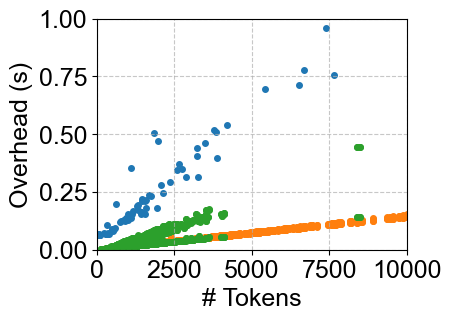

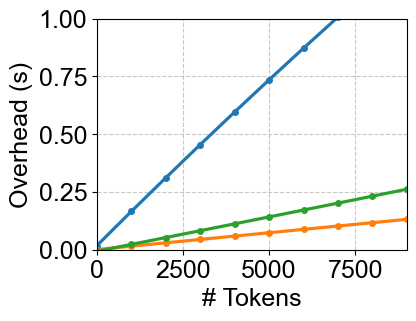

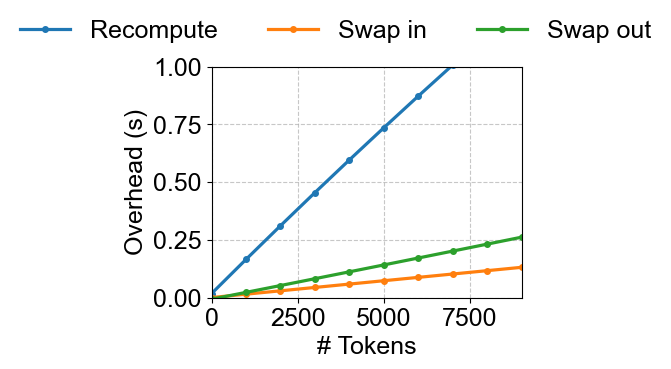

In [274]:

swapin_tokens = convert_block_token(swapin_blocks)
swapout_tokens = convert_block_token(swapout_blocks)
                                     
overhead_list = [(input_len, ttft, 'Recompute-A40'), 
                 (swapin_tokens, swapin_overheads, 'Swap in-A40'), 
                 (swapout_tokens, swapout_overheads, 'Swap out-A40')]
plot_overhead_len(overhead_list, 'real-phi-moe-a40')

num_tokens = range(-1000, 10000, 1000)
coefficients = np.polyfit(input_len, ttft, 2)
polynomial = np.poly1d(coefficients)
recompute_fit = polynomial(num_tokens)

coefficients = np.polyfit(swapin_tokens, swapin_overheads, 2)
polynomial = np.poly1d(coefficients)
swapin_fit = polynomial(num_tokens)

coefficients = np.polyfit(swapout_tokens, swapout_overheads, 2)
polynomial = np.poly1d(coefficients)
swapout_fit = polynomial(num_tokens)

overhead_list = [(num_tokens, recompute_fit, 'Recompute'), 
                 (num_tokens, swapin_fit, 'Swap in'), 
                 (num_tokens, swapout_fit, 'Swap out')]
plot_overhead_len(overhead_list, 'fit-phi-moe-a40', scatter=False, xrange=(0, 9000) )
plot_overhead_len(overhead_list, 'fit-phi-moe-a40-legend', scatter=False, xrange=(0, 9000), legend=True)



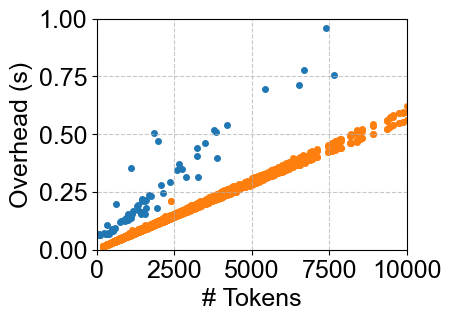

In [275]:
# not useful in the paper
swap_tokens=convert_block_token(swapin_blocks)
swap_overheads=[a*4 for a in swapin_overheads]
overhead_list = [(input_len, ttft, 'Recompute-A40'), ( swap_tokens, swap_overheads,'Swap-A40')]
plot_overhead_len(overhead_list, 'tmp-real-phi-moe-a40')



### A100 - Phi-MoE

In [276]:
ttft=[3.4969012120000116, 0.17820223399940005, 0.09578855200015823, 0.09564129299906199, 0.2208449859990651, 0.39164119199995184, 0.09377649599991855, 0.08576653499949316, 0.08543075999841676, 0.12197693599955528, 0.08791577299962228, 0.09557057100028032, 0.08936936999998579, 0.24142396800016286, 0.10048773000016809, 0.5397090599999501, 0.08953687900066143, 0.10233995899943693, 0.4762772819995007, 0.09818139799972414, 0.11807128299915348, 0.16018911600076535, 0.14429939799993008, 0.13949154399961117, 0.133361280999452, 0.9957470919998741, 0.8332660899995972, 0.09802553900044586, 0.13936225900033605, 0.100092749000396, 0.10514868100108288, 0.09397841999998491, 0.1014364860002388, 0.09839935200034233, 0.09351926199997251, 0.10171286400145618, 0.09907654400012689, 0.6213098850003007, 0.23447026500070933, 0.09603136000077939, 0.179573495999648, 0.1542179030002444, 0.09554408700023487, 0.0936813570006052, 0.10041995999927167, 0.12918559500030824, 0.09345395099990128, 0.12923944700014545, 0.13504261699927156, 0.12593083499996283, 0.12911010599964357, 0.12785805500061542, 0.12476121199870249, 0.13412041700030386, 0.13639405499998247, 0.13250503000017488, 0.6518467059995601, 0.10623427500104299, 0.0963186749995657, 0.09526813100092113, 0.09826663999956509, 0.09622233800109825, 0.09316252200005692, 0.09816514499834739, 0.09681902800002717, 0.1017930880007043, 0.09530546099995263, 0.8795799569998053, 0.17683078999834834, 0.45766854399880685, 0.18580655000005208, 0.10081986499972118, 0.0976347399991937, 0.09600959299859824, 0.09184571500009042, 0.1479119849991548, 0.09439711500090198, 0.29470552900056646, 0.10363641600088158, 0.09537245599858579, 0.22276025300016045, 0.09447344600084762, 0.09368343599999207, 0.09629555399988021, 0.10114201999931538, 0.09631871300007333, 0.09315982500083919, 0.12225983700045617, 0.1014489320004941, 0.0970045760004723, 0.16565687300135323, 0.09659534400088887, 0.100184752000132, 0.10270269799912057, 0.0948929180012783, 0.1024700269990717, 0.09277401200051827]
input_len=[1841, 4278, 18, 62, 5915, 10809, 1541, 344, 181, 2604, 892, 1111, 846, 6701, 1705, 15752, 809, 1141, 12840, 349, 2372, 3979, 3328, 3050, 2833, 30273, 25920, 352, 2915, 568, 1267, 15, 1119, 907, 127, 1230, 868, 18160, 6459, 990, 4312, 3671, 380, 26, 1633, 2811, 323, 507, 1662, 19, 847, 685, 45, 1211, 2246, 1381, 18539, 1924, 19, 16, 946, 499, 4, 528, 458, 1490, 243, 26683, 4252, 12363, 4549, 569, 55, 7, 115, 3356, 113, 8083, 1130, 17, 6063, 1, 29, 82, 1455, 421, 7, 2593, 1830, 576, 3856, 335, 1203, 1636, 79, 1290, 50]
swapin_blocks=[50, 50, 50, 50, 50, 50, 50, 50, 40, 40, 40, 40, 40, 40, 40, 40, 116, 116, 116, 116, 116, 116, 116, 116, 37, 37, 37, 37, 37, 37, 37, 37, 129, 129, 129, 129, 129, 129, 129, 129, 40, 40, 40, 40, 40, 40, 40, 40, 204, 204, 204, 204, 204, 204, 204, 204, 122, 122, 122, 122, 122, 122, 122, 122, 185, 185, 185, 185, 185, 185, 185, 185, 45, 45, 45, 45, 45, 45, 45, 45, 160, 160, 160, 160, 160, 160, 160, 160, 119, 119, 119, 119, 119, 119, 119, 119, 50, 50, 50, 50, 50, 50, 50, 50, 159, 159, 159, 159, 159, 159, 159, 159, 58, 58, 58, 58, 58, 58, 58, 58, 52, 52, 52, 52, 52, 52, 52, 52, 131, 131, 131, 131, 131, 131, 131, 131, 92, 92, 92, 92, 92, 92, 92, 92, 133, 133, 133, 133, 133, 133, 133, 133, 45, 45, 45, 45, 45, 45, 45, 45, 135, 135, 135, 135, 135, 135, 135, 135, 187, 187, 187, 187, 187, 187, 187, 187, 125, 125, 125, 125, 125, 125, 125, 125, 164, 164, 164, 164, 164, 164, 164, 164, 89, 89, 89, 89, 89, 89, 89, 89, 256, 256, 256, 256, 256, 256, 256, 256, 259, 259, 259, 259, 259, 259, 259, 259, 78, 78, 78, 78, 78, 78, 78, 78, 221, 221, 221, 221, 221, 221, 221, 221, 131, 131, 131, 131, 131, 131, 131, 131, 151, 151, 151, 151, 151, 151, 151, 151, 137, 137, 137, 137, 137, 137, 137, 137, 58, 58, 58, 58, 58, 58, 58, 58, 452, 452, 452, 452, 452, 452, 452, 452, 200, 200, 200, 200, 200, 200, 200, 200, 113, 113, 113, 113, 113, 113, 113, 113, 185, 185, 185, 185, 185, 185, 185, 185, 150, 150, 150, 150, 150, 150, 150, 150, 207, 207, 207, 207, 207, 207, 207, 207, 270, 270, 270, 270, 270, 270, 270, 270, 247, 247, 247, 247, 247, 247, 247, 247, 54, 54, 54, 54, 54, 54, 54, 54, 68, 68, 68, 68, 68, 68, 68, 68, 226, 226, 226, 226, 226, 226, 226, 226, 36, 36, 36, 36, 36, 36, 36, 36, 44, 44, 44, 44, 44, 44, 44, 44, 367, 367, 367, 367, 367, 367, 367, 367, 271, 271, 271, 271, 271, 271, 271, 271, 99, 99, 99, 99, 99, 99, 99, 99, 23, 23, 23, 23, 23, 23, 23, 23, 50, 50, 50, 50, 50, 50, 50, 50, 222, 222, 222, 222, 222, 222, 222, 222, 48, 48, 48, 48, 48, 48, 48, 48, 284, 284, 284, 284, 284, 284, 284, 284, 79, 79, 79, 79, 79, 79, 79, 79, 209, 209, 209, 209, 209, 209, 209, 209, 44, 44, 44, 44, 44, 44, 44, 44, 287, 287, 287, 287, 287, 287, 287, 287, 38, 38, 38, 38, 38, 38, 38, 38, 91, 91, 91, 91, 91, 91, 91, 91, 189, 189, 189, 189, 189, 189, 189, 189, 83, 83, 83, 83, 83, 83, 83, 83, 192, 192, 192, 192, 192, 192, 192, 192, 82, 82, 82, 82, 82, 82, 82, 82, 126, 126, 126, 126, 126, 126, 126, 126, 87, 87, 87, 87, 87, 87, 87, 87, 129, 129, 129, 129, 129, 129, 129, 129, 72, 72, 72, 72, 72, 72, 72, 72, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 239, 239, 239, 239, 239, 239, 239, 239, 200, 200, 200, 200, 200, 200, 200, 200, 144, 144, 144, 144, 144, 144, 144, 144, 75, 75, 75, 75, 75, 75, 75, 75, 138, 138, 138, 138, 138, 138, 138, 138, 312, 312, 312, 312, 312, 312, 312, 312, 74, 74, 74, 74, 74, 74, 74, 74, 127, 127, 127, 127, 127, 127, 127, 127, 45, 45, 45, 45, 45, 45, 45, 45, 74, 74, 74, 74, 74, 74, 74, 74, 153, 153, 153, 153, 153, 153, 153, 153, 101, 101, 101, 101, 101, 101, 101, 101, 243, 243, 243, 243, 243, 243, 243, 243, 144, 144, 144, 144, 144, 144, 144, 144, 79, 79, 79, 79, 79, 79, 79, 79, 56, 56, 56, 56, 56, 56, 56, 56, 135, 135, 135, 135, 135, 135, 135, 135, 38, 38, 38, 38, 38, 38, 38, 38, 99, 99, 99, 99, 99, 99, 99, 99, 257, 257, 257, 257, 257, 257, 257, 257, 124, 124, 124, 124, 124, 124, 124, 124, 159, 159, 159, 159, 159, 159, 159, 159, 105, 105, 105, 105, 105, 105, 105, 105, 79, 79, 79, 79, 79, 79, 79, 79, 196, 196, 196, 196, 196, 196, 196, 196, 62, 62, 62, 62, 62, 62, 62, 62, 96, 96, 96, 96, 96, 96, 96, 96]
swapin_overheads=[0.012584686279296875, 0.012631654739379883, 0.012626886367797852, 0.012706756591796875, 0.013626337051391602, 0.01347804069519043, 0.01356196403503418, 0.013556718826293945, 0.010279655456542969, 0.010269403457641602, 0.01032710075378418, 0.010327816009521484, 0.011034250259399414, 0.011299371719360352, 0.011089801788330078, 0.01102137565612793, 0.027975797653198242, 0.028041601181030273, 0.029535531997680664, 0.02949237823486328, 0.030455589294433594, 0.030431032180786133, 0.03034234046936035, 0.030471086502075195, 0.009525299072265625, 0.00952911376953125, 0.009595870971679688, 0.00958395004272461, 0.01025247573852539, 0.010213851928710938, 0.010187387466430664, 0.010355949401855469, 0.03106403350830078, 0.031117677688598633, 0.03126835823059082, 0.031410932540893555, 0.03352212905883789, 0.033377647399902344, 0.03363442420959473, 0.03374886512756348, 0.010293960571289062, 0.010323524475097656, 0.010335206985473633, 0.01026010513305664, 0.011150598526000977, 0.010931253433227539, 0.011069297790527344, 0.011193275451660156, 0.050230979919433594, 0.0503544807434082, 0.050540924072265625, 0.0513150691986084, 0.05215620994567871, 0.05273103713989258, 0.05261635780334473, 0.05261373519897461, 0.02920675277709961, 0.029477357864379883, 0.029434680938720703, 0.029724836349487305, 0.03184700012207031, 0.03168845176696777, 0.0315861701965332, 0.03334808349609375, 0.045122385025024414, 0.04524707794189453, 0.04571819305419922, 0.04625558853149414, 0.047678232192993164, 0.0474855899810791, 0.047603607177734375, 0.04780983924865723, 0.01132345199584961, 0.011409759521484375, 0.01152944564819336, 0.011530399322509766, 0.012315750122070312, 0.012273311614990234, 0.01231074333190918, 0.012360095977783203, 0.03851056098937988, 0.0387880802154541, 0.03902578353881836, 0.03964424133300781, 0.04124093055725098, 0.04118537902832031, 0.04137992858886719, 0.042398691177368164, 0.028806209564208984, 0.028922080993652344, 0.028977155685424805, 0.029039621353149414, 0.031116962432861328, 0.030936002731323242, 0.031202316284179688, 0.032808780670166016, 0.012564897537231445, 0.012509346008300781, 0.012699127197265625, 0.01262664794921875, 0.013617753982543945, 0.013545751571655273, 0.013605833053588867, 0.013703346252441406, 0.038268089294433594, 0.038368940353393555, 0.03852200508117676, 0.03873562812805176, 0.04138445854187012, 0.04131150245666504, 0.041347503662109375, 0.04152512550354004, 0.014312982559204102, 0.014481306076049805, 0.014592409133911133, 0.014487981796264648, 0.015524864196777344, 0.015552997589111328, 0.015700817108154297, 0.01739668846130371, 0.013051748275756836, 0.012938499450683594, 0.013091564178466797, 0.013234615325927734, 0.014096736907958984, 0.014110803604125977, 0.014141559600830078, 0.014292001724243164, 0.03168034553527832, 0.03179049491882324, 0.03179526329040527, 0.032221078872680664, 0.034047842025756836, 0.03389859199523926, 0.034064531326293945, 0.0342402458190918, 0.022280454635620117, 0.02231287956237793, 0.02263498306274414, 0.022960424423217773, 0.024170875549316406, 0.024120569229125977, 0.024240970611572266, 0.024247407913208008, 0.03197073936462402, 0.03203868865966797, 0.03228497505187988, 0.03220248222351074, 0.034300804138183594, 0.03460192680358887, 0.034661054611206055, 0.03466367721557617, 0.011437177658081055, 0.01133584976196289, 0.011424779891967773, 0.011438369750976562, 0.012317657470703125, 0.01218271255493164, 0.012316703796386719, 0.012388467788696289, 0.03232002258300781, 0.03259754180908203, 0.03277158737182617, 0.032792091369628906, 0.03487253189086914, 0.0353703498840332, 0.0354464054107666, 0.035446882247924805, 0.0460505485534668, 0.046051740646362305, 0.046486616134643555, 0.04646492004394531, 0.04803872108459473, 0.048505544662475586, 0.04855608940124512, 0.05043339729309082, 0.029980182647705078, 0.030184030532836914, 0.030283212661743164, 0.030895709991455078, 0.03261446952819824, 0.03243589401245117, 0.03265118598937988, 0.03271746635437012, 0.03977060317993164, 0.03977656364440918, 0.04007840156555176, 0.040348052978515625, 0.0420079231262207, 0.04228520393371582, 0.04252052307128906, 0.04375004768371582, 0.021587133407592773, 0.021703481674194336, 0.021749019622802734, 0.021860361099243164, 0.023479223251342773, 0.023367643356323242, 0.023378849029541016, 0.02332282066345215, 0.06454062461853027, 0.06468462944030762, 0.06499099731445312, 0.06553125381469727, 0.0654909610748291, 0.06534481048583984, 0.06643915176391602, 0.06642746925354004, 0.06535887718200684, 0.06538271903991699, 0.06632494926452637, 0.06613850593566895, 0.06659173965454102, 0.06679320335388184, 0.06746935844421387, 0.08910584449768066, 0.01915454864501953, 0.01919388771057129, 0.019158601760864258, 0.019469738006591797, 0.020548582077026367, 0.02067112922668457, 0.020630836486816406, 0.020919322967529297, 0.05510258674621582, 0.05513453483581543, 0.05550217628479004, 0.055806875228881836, 0.05675816535949707, 0.056966543197631836, 0.05716514587402344, 0.05734753608703613, 0.031546592712402344, 0.03170657157897949, 0.03178715705871582, 0.03194713592529297, 0.03410458564758301, 0.034174203872680664, 0.03426098823547363, 0.034340620040893555, 0.03636670112609863, 0.03647160530090332, 0.03662919998168945, 0.036798715591430664, 0.039046525955200195, 0.03904223442077637, 0.03917431831359863, 0.039244651794433594, 0.03278064727783203, 0.033023834228515625, 0.03302764892578125, 0.03338360786437988, 0.035527706146240234, 0.03583669662475586, 0.03562140464782715, 0.03577399253845215, 0.014460086822509766, 0.014538049697875977, 0.014485836029052734, 0.014506816864013672, 0.015636920928955078, 0.015683412551879883, 0.015605688095092773, 0.015834331512451172, 0.11687946319580078, 0.11678028106689453, 0.11671161651611328, 0.11757922172546387, 0.11746788024902344, 0.11772322654724121, 0.11797523498535156, 0.11820387840270996, 0.04966926574707031, 0.04990792274475098, 0.050214529037475586, 0.05052518844604492, 0.051453351974487305, 0.05152487754821777, 0.05169320106506348, 0.05233907699584961, 0.027140140533447266, 0.027359485626220703, 0.027418851852416992, 0.027446269989013672, 0.02960038185119629, 0.029527664184570312, 0.02960991859436035, 0.029999732971191406, 0.04547572135925293, 0.04557323455810547, 0.04571676254272461, 0.04622483253479004, 0.04765033721923828, 0.04757046699523926, 0.047844648361206055, 0.04966449737548828, 0.03604888916015625, 0.03608393669128418, 0.036325693130493164, 0.036470651626586914, 0.03878927230834961, 0.03912234306335449, 0.03891110420227051, 0.038923025131225586, 0.05119800567626953, 0.05135035514831543, 0.0516664981842041, 0.05199313163757324, 0.0531620979309082, 0.05325031280517578, 0.053794145584106445, 0.05494213104248047, 0.06811070442199707, 0.06853342056274414, 0.06890368461608887, 0.06906414031982422, 0.0695180892944336, 0.0695505142211914, 0.06976842880249023, 0.070404052734375, 0.06195235252380371, 0.062001943588256836, 0.06235790252685547, 0.06269693374633789, 0.06339478492736816, 0.06366348266601562, 0.06380748748779297, 0.0653543472290039, 0.01336669921875, 0.013529300689697266, 0.013456344604492188, 0.013530492782592773, 0.014572858810424805, 0.014508485794067383, 0.014605283737182617, 0.014506340026855469, 0.016631364822387695, 0.01674675941467285, 0.01683521270751953, 0.016865015029907227, 0.017973899841308594, 0.01809978485107422, 0.01817917823791504, 0.018069744110107422, 0.05625748634338379, 0.05638432502746582, 0.05670499801635742, 0.05695772171020508, 0.058063507080078125, 0.05838751792907715, 0.05845475196838379, 0.06017446517944336, 0.009287118911743164, 0.009321212768554688, 0.009282112121582031, 0.010023832321166992, 0.009968996047973633, 0.010061264038085938, 0.010117530822753906, 0.01373600959777832, 0.011099576950073242, 0.01120901107788086, 0.011156320571899414, 0.012019634246826172, 0.012360095977783203, 0.012212991714477539, 0.012124776840209961, 0.01650404930114746, 0.09468650817871094, 0.09443354606628418, 0.09460020065307617, 0.09451413154602051, 0.09527063369750977, 0.09549736976623535, 0.09581780433654785, 0.1256420612335205, 0.06856060028076172, 0.06873941421508789, 0.06937551498413086, 0.06937956809997559, 0.06961297988891602, 0.06949520111083984, 0.07127141952514648, 0.09298205375671387, 0.02400970458984375, 0.02414727210998535, 0.024302005767822266, 0.02439141273498535, 0.02606821060180664, 0.026149988174438477, 0.02601933479309082, 0.03722524642944336, 0.006197214126586914, 0.0062448978424072266, 0.006231546401977539, 0.0062830448150634766, 0.006690502166748047, 0.006613016128540039, 0.00669407844543457, 0.006746530532836914, 0.012585163116455078, 0.012649059295654297, 0.012666940689086914, 0.012660503387451172, 0.013483047485351562, 0.013716936111450195, 0.013690710067749023, 0.013633966445922852, 0.0558323860168457, 0.056250572204589844, 0.05647420883178711, 0.055883169174194336, 0.05712532997131348, 0.05740094184875488, 0.05768942832946777, 0.05909156799316406, 0.012129545211791992, 0.012219667434692383, 0.012124776840209961, 0.013179779052734375, 0.01305246353149414, 0.013079643249511719, 0.013026952743530273, 0.013804912567138672, 0.07278823852539062, 0.07283663749694824, 0.07311511039733887, 0.07322478294372559, 0.07346320152282715, 0.07357501983642578, 0.07401394844055176, 0.0757746696472168, 0.019182682037353516, 0.01942920684814453, 0.01951909065246582, 0.019559144973754883, 0.020859956741333008, 0.02072763442993164, 0.020848512649536133, 0.02089238166809082, 0.052529096603393555, 0.05266261100769043, 0.05289816856384277, 0.05317282676696777, 0.05364203453063965, 0.0539860725402832, 0.05431318283081055, 0.054197072982788086, 0.011167526245117188, 0.011147499084472656, 0.011181354522705078, 0.011273860931396484, 0.01204228401184082, 0.011978387832641602, 0.012159109115600586, 0.012024402618408203, 0.07358980178833008, 0.0738217830657959, 0.07399559020996094, 0.07399487495422363, 0.07429361343383789, 0.0741424560546875, 0.07472443580627441, 0.07457780838012695, 0.009644508361816406, 0.009703397750854492, 0.009786128997802734, 0.009783744812011719, 0.010549783706665039, 0.010468244552612305, 0.010495901107788086, 0.010468721389770508, 0.022045612335205078, 0.02202630043029785, 0.022246599197387695, 0.022486209869384766, 0.024109840393066406, 0.02384185791015625, 0.02401137351989746, 0.024202585220336914, 0.046944618225097656, 0.04702615737915039, 0.04726362228393555, 0.047464847564697266, 0.048786163330078125, 0.04884600639343262, 0.04923510551452637, 0.04889273643493652, 0.020166635513305664, 0.02025771141052246, 0.02044510841369629, 0.020460844039916992, 0.021923303604125977, 0.021968364715576172, 0.021865367889404297, 0.022182226181030273, 0.04758143424987793, 0.0476679801940918, 0.04793691635131836, 0.04820537567138672, 0.04939436912536621, 0.049814701080322266, 0.05002951622009277, 0.05019378662109375, 0.020105838775634766, 0.020201444625854492, 0.020168781280517578, 0.02026844024658203, 0.021622180938720703, 0.02201676368713379, 0.021728515625, 0.021909713745117188, 0.030165672302246094, 0.030314922332763672, 0.030535459518432617, 0.030870914459228516, 0.03257870674133301, 0.0328364372253418, 0.03293204307556152, 0.03313636779785156, 0.02117323875427246, 0.02127361297607422, 0.021411418914794922, 0.021637678146362305, 0.02296590805053711, 0.022854328155517578, 0.023050785064697266, 0.023157596588134766, 0.031008481979370117, 0.031219005584716797, 0.031380414962768555, 0.031311750411987305, 0.033548593521118164, 0.033532142639160156, 0.03384971618652344, 0.034011125564575195, 0.017846345901489258, 0.017752408981323242, 0.017849206924438477, 0.018009185791015625, 0.01915144920349121, 0.019165515899658203, 0.019145965576171875, 0.01927924156188965, 0.022477149963378906, 0.022525548934936523, 0.02248835563659668, 0.0225222110748291, 0.02413630485534668, 0.024077177047729492, 0.024213075637817383, 0.024367094039916992, 0.02260875701904297, 0.022866010665893555, 0.022814512252807617, 0.02301764488220215, 0.02441120147705078, 0.024866342544555664, 0.024874210357666016, 0.026238203048706055, 0.06035423278808594, 0.06052803993225098, 0.061708927154541016, 0.061666250228881836, 0.06167435646057129, 0.06209969520568848, 0.06361770629882812, 0.06569862365722656, 0.04953169822692871, 0.0500645637512207, 0.05047178268432617, 0.050582170486450195, 0.05188608169555664, 0.05169486999511719, 0.05163931846618652, 0.05174088478088379, 0.03460693359375, 0.03469133377075195, 0.03488445281982422, 0.03501391410827637, 0.037226200103759766, 0.03748297691345215, 0.03761792182922363, 0.03806471824645996, 0.018590688705444336, 0.01855635643005371, 0.01861119270324707, 0.018644332885742188, 0.019971609115600586, 0.019912242889404297, 0.020060300827026367, 0.019941329956054688, 0.03324174880981445, 0.033237457275390625, 0.03347492218017578, 0.033643484115600586, 0.03600430488586426, 0.03579115867614746, 0.03596973419189453, 0.03629779815673828, 0.08065176010131836, 0.08039975166320801, 0.08053874969482422, 0.08072257041931152, 0.0808870792388916, 0.08115291595458984, 0.08139181137084961, 0.08144974708557129, 0.018075227737426758, 0.0181272029876709, 0.01826333999633789, 0.018294095993041992, 0.01963329315185547, 0.019682645797729492, 0.019722700119018555, 0.019809722900390625, 0.03067779541015625, 0.030622005462646484, 0.03082895278930664, 0.031033992767333984, 0.03319740295410156, 0.03311896324157715, 0.03339028358459473, 0.03327655792236328, 0.011417150497436523, 0.011392593383789062, 0.0115966796875, 0.011522293090820312, 0.012168169021606445, 0.012498140335083008, 0.01222538948059082, 0.012401342391967773, 0.01791524887084961, 0.01826643943786621, 0.01837944984436035, 0.018349647521972656, 0.019722938537597656, 0.01957535743713379, 0.019709110260009766, 0.01981663703918457, 0.037056922912597656, 0.03720235824584961, 0.03739666938781738, 0.037444353103637695, 0.03960299491882324, 0.03978753089904785, 0.03952193260192871, 0.0400700569152832, 0.024498939514160156, 0.024562358856201172, 0.024705171585083008, 0.024750471115112305, 0.026595354080200195, 0.026391267776489258, 0.02669358253479004, 0.026593685150146484, 0.061640024185180664, 0.06203722953796387, 0.06238102912902832, 0.06261920928955078, 0.0627589225769043, 0.06322526931762695, 0.06450724601745605, 0.06610250473022461, 0.03479909896850586, 0.03502058982849121, 0.03499579429626465, 0.035401344299316406, 0.03714179992675781, 0.03734254837036133, 0.03744149208068848, 0.0377650260925293, 0.019377708435058594, 0.019306659698486328, 0.019441843032836914, 0.019465923309326172, 0.02108907699584961, 0.020899295806884766, 0.020920991897583008, 0.020916223526000977, 0.013960599899291992, 0.013994693756103516, 0.013991594314575195, 0.01405954360961914, 0.014998674392700195, 0.014942646026611328, 0.015244007110595703, 0.015039920806884766, 0.03256821632385254, 0.03257870674133301, 0.032643795013427734, 0.03277134895324707, 0.035068511962890625, 0.03511667251586914, 0.03514266014099121, 0.03513908386230469, 0.009694099426269531, 0.009721755981445312, 0.009910345077514648, 0.009836435317993164, 0.010602474212646484, 0.010439872741699219, 0.010478973388671875, 0.01044011116027832, 0.024049758911132812, 0.024271249771118164, 0.02422928810119629, 0.02439713478088379, 0.026142120361328125, 0.026062965393066406, 0.026089906692504883, 0.026173114776611328, 0.06537199020385742, 0.0658118724822998, 0.06586360931396484, 0.06633353233337402, 0.0662224292755127, 0.06637120246887207, 0.06687593460083008, 0.06696844100952148, 0.02997446060180664, 0.030039548873901367, 0.030158519744873047, 0.030278444290161133, 0.03238058090209961, 0.032585859298706055, 0.03243279457092285, 0.032536983489990234, 0.0384981632232666, 0.03904318809509277, 0.03874564170837402, 0.03893399238586426, 0.04111623764038086, 0.04128265380859375, 0.04134392738342285, 0.04168128967285156, 0.0254361629486084, 0.02541184425354004, 0.02555537223815918, 0.02565455436706543, 0.02759385108947754, 0.027510643005371094, 0.02752089500427246, 0.027637720108032227, 0.01934027671813965, 0.0194394588470459, 0.019387245178222656, 0.019387483596801758, 0.020771026611328125, 0.02091073989868164, 0.021087169647216797, 0.020923614501953125, 0.04903888702392578, 0.04922008514404297, 0.04949140548706055, 0.049727678298950195, 0.05075573921203613, 0.050954341888427734, 0.05083966255187988, 0.05108165740966797, 0.01533961296081543, 0.015416383743286133, 0.01537322998046875, 0.015542984008789062, 0.016565322875976562, 0.016688108444213867, 0.016602516174316406, 0.016766786575317383, 0.023250102996826172, 0.02338576316833496, 0.0234982967376709, 0.0235440731048584, 0.02528834342956543, 0.02520298957824707, 0.025358200073242188, 0.025492429733276367]
swapout_blocks=[18, 18, 18, 18, 18, 18, 18, 18, 32, 32, 32, 32, 32, 32, 32, 32, 40, 40, 40, 40, 40, 40, 40, 40, 116, 116, 116, 116, 116, 116, 116, 116, 37, 37, 37, 37, 37, 37, 37, 37, 129, 129, 129, 129, 129, 129, 129, 129, 40, 40, 40, 40, 40, 40, 40, 40, 50, 50, 50, 50, 50, 50, 50, 50, 21, 21, 21, 21, 21, 21, 21, 21, 133, 133, 133, 133, 133, 133, 133, 133, 122, 122, 122, 122, 122, 122, 122, 122, 46, 46, 46, 46, 46, 46, 46, 46, 52, 52, 52, 52, 52, 52, 52, 52, 87, 87, 87, 87, 87, 87, 87, 87, 26, 26, 26, 26, 26, 26, 26, 26, 19, 19, 19, 19, 19, 19, 19, 19, 38, 38, 38, 38, 38, 38, 38, 38, 29, 29, 29, 29, 29, 29, 29, 29, 22, 22, 22, 22, 22, 22, 22, 22, 71, 71, 71, 71, 71, 71, 71, 71, 66, 66, 66, 66, 66, 66, 66, 66, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 31, 31, 31, 31, 31, 31, 31, 31, 19, 19, 19, 19, 19, 19, 19, 19, 67, 67, 67, 67, 67, 67, 67, 67, 92, 92, 92, 92, 92, 92, 92, 92, 58, 58, 58, 58, 58, 58, 58, 58, 52, 52, 52, 52, 52, 52, 52, 52, 74, 74, 74, 74, 74, 74, 74, 74, 25, 25, 25, 25, 25, 25, 25, 25, 32, 32, 32, 32, 32, 32, 32, 32, 41, 41, 41, 41, 41, 41, 41, 41, 22, 22, 22, 22, 22, 22, 22, 22, 29, 29, 29, 29, 29, 29, 29, 29, 133, 133, 133, 133, 133, 133, 133, 133, 45, 45, 45, 45, 45, 45, 45, 45, 135, 135, 135, 135, 135, 135, 135, 135, 138, 138, 138, 138, 138, 138, 138, 138, 49, 49, 49, 49, 49, 49, 49, 49, 40, 40, 40, 40, 40, 40, 40, 40, 33, 33, 33, 33, 33, 33, 33, 33, 52, 52, 52, 52, 52, 52, 52, 52, 43, 43, 43, 43, 43, 43, 43, 43, 36, 36, 36, 36, 36, 36, 36, 36, 85, 85, 85, 85, 85, 85, 85, 85, 25, 25, 25, 25, 25, 25, 25, 25, 64, 64, 64, 64, 64, 64, 64, 64, 33, 33, 33, 33, 33, 33, 33, 33, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 65, 65, 65, 65, 65, 65, 65, 65, 27, 27, 27, 27, 27, 27, 27, 27, 45, 45, 45, 45, 45, 45, 45, 45, 27, 27, 27, 27, 27, 27, 27, 27, 86, 86, 86, 86, 86, 86, 86, 86, 41, 41, 41, 41, 41, 41, 41, 41, 102, 102, 102, 102, 102, 102, 102, 102, 30, 30, 30, 30, 30, 30, 30, 30, 48, 48, 48, 48, 48, 48, 48, 48, 30, 30, 30, 30, 30, 30, 30, 30, 69, 69, 69, 69, 69, 69, 69, 69, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 39, 39, 39, 39, 39, 39, 39, 39, 43, 43, 43, 43, 43, 43, 43, 43, 45, 45, 45, 45, 45, 45, 45, 45, 54, 54, 54, 54, 54, 54, 54, 54, 32, 32, 32, 32, 32, 32, 32, 32, 105, 105, 105, 105, 105, 105, 105, 105, 46, 46, 46, 46, 46, 46, 46, 46, 91, 91, 91, 91, 91, 91, 91, 91, 46, 46, 46, 46, 46, 46, 46, 46, 58, 58, 58, 58, 58, 58, 58, 58, 78, 78, 78, 78, 78, 78, 78, 78, 47, 47, 47, 47, 47, 47, 47, 47, 51, 51, 51, 51, 51, 51, 51, 51, 74, 74, 74, 74, 74, 74, 74, 74, 63, 63, 63, 63, 63, 63, 63, 63, 139, 139, 139, 139, 139, 139, 139, 139, 50, 50, 50, 50, 50, 50, 50, 50, 111, 111, 111, 111, 111, 111, 111, 111, 39, 39, 39, 39, 39, 39, 39, 39, 61, 61, 61, 61, 61, 61, 61, 61, 52, 52, 52, 52, 52, 52, 52, 52, 29, 29, 29, 29, 29, 29, 29, 29, 64, 64, 64, 64, 64, 64, 64, 64, 56, 56, 56, 56, 56, 56, 56, 56, 36, 36, 36, 36, 36, 36, 36, 36, 59, 59, 59, 59, 59, 59, 59, 59, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 30, 30, 20, 20, 20, 20, 20, 20, 20, 20, 58, 58, 58, 58, 58, 58, 58, 58, 30, 30, 30, 30, 30, 30, 30, 30, 27, 27, 27, 27, 27, 27, 27, 27, 36, 36, 36, 36, 36, 36, 36, 36, 56, 56, 56, 56, 56, 56, 56, 56, 61, 61, 61, 61, 61, 61, 61, 61, 47, 47, 47, 47, 47, 47, 47, 47, 21, 21, 21, 21, 21, 21, 21, 21, 35, 35, 35, 35, 35, 35, 35, 35, 47, 47, 47, 47, 47, 47, 47, 47, 59, 59, 59, 59, 59, 59, 59, 59, 22, 22, 22, 22, 22, 22, 22, 22, 41, 41, 41, 41, 41, 41, 41, 41, 63, 63, 63, 63, 63, 63, 63, 63, 53, 53, 53, 53, 53, 53, 53, 53, 41, 41, 41, 41, 41, 41, 41, 41, 27, 27, 27, 27, 27, 27, 27, 27, 54, 54, 54, 54, 54, 54, 54, 54, 68, 68, 68, 68, 68, 68, 68, 68, 54, 54, 54, 54, 54, 54, 54, 54, 130, 130, 130, 130, 130, 130, 130, 130, 42, 42, 42, 42, 42, 42, 42, 42, 36, 36, 36, 36, 36, 36, 36, 36, 44, 44, 44, 44, 44, 44, 44, 44, 132, 132, 132, 132, 132, 132, 132, 132, 57, 57, 57, 57, 57, 57, 57, 57, 34, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 54, 54, 54, 54, 54, 54, 54, 54, 22, 22, 22, 22, 22, 22, 22, 22, 35, 35, 35, 35, 35, 35, 35, 35, 54, 54, 54, 54, 54, 54, 54, 54, 92, 92, 92, 92, 92, 92, 92, 92, 54, 54, 54, 54, 54, 54, 54, 54, 71, 71, 71, 71, 71, 71, 71, 71, 19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 59, 59, 59, 59, 59, 59, 59, 59, 23, 23, 23, 23, 23, 23, 23, 23, 19, 19, 19, 19, 19, 19, 19, 19, 13, 13, 13, 13, 13, 13, 13, 13, 18, 18, 18, 18, 18, 18, 18, 18, 89, 89, 89, 89, 89, 89, 89, 89, 25, 25, 25, 25, 25, 25, 25, 25, 21, 21, 21, 21, 21, 21, 21, 21, 16, 16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21, 31, 31, 31, 31, 31, 31, 31, 31, 19, 19, 19, 19, 19, 19, 19, 19, 48, 48, 48, 48, 48, 48, 48, 48, 62, 62, 62, 62, 62, 62, 62, 62, 35, 35, 35, 35, 35, 35, 35, 35, 66, 66, 66, 66, 66, 66, 66, 66, 39, 39, 39, 39, 39, 39, 39, 39, 42, 42, 42, 42, 42, 42, 42, 42, 40, 40, 40, 40, 40, 40, 40, 40, 58, 58, 58, 58, 58, 58, 58, 58, 21, 21, 21, 21, 21, 21, 21, 21, 68, 68, 68, 68, 68, 68, 68, 68, 70, 70, 70, 70, 70, 70, 70, 70, 34, 34, 34, 34, 34, 34, 34, 34, 37, 37, 37, 37, 37, 37, 37, 37, 17, 17, 17, 17, 17, 17, 17, 17, 27, 27, 27, 27, 27, 27, 27, 27, 78, 78, 78, 78, 78, 78, 78, 78, 77, 77, 77, 77, 77, 77, 77, 77, 30, 30, 30, 30, 30, 30, 30, 30, 20, 20, 20, 20, 20, 20, 20, 20, 82, 82, 82, 82, 82, 82, 82, 82, 38, 38, 38, 38, 38, 38, 38, 38, 24, 24, 24, 24, 24, 24, 24, 24, 19, 19, 19, 19, 19, 19, 19, 19, 48, 48, 48, 48, 48, 48, 48, 48, 42, 42, 42, 42, 42, 42, 42, 42, 87, 87, 87, 87, 87, 87, 87, 87, 25, 25, 25, 25, 25, 25, 25, 25, 35, 35, 35, 35, 35, 35, 35, 35, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 108, 108, 108, 108, 108, 108, 108, 108, 43, 43, 43, 43, 43, 43, 43, 43, 39, 39, 39, 39, 39, 39, 39, 39, 15, 15, 15, 15, 15, 15, 15, 15, 111, 111, 111, 111, 111, 111, 111, 111, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 41, 41, 41, 41, 41, 41, 41, 41, 27, 27, 27, 27, 27, 27, 27, 27, 45, 45, 45, 45, 45, 45, 45, 45, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 117, 117, 117, 117, 117, 117, 117, 117, 23, 23, 23, 23, 23, 23, 23, 23, 47, 47, 47, 47, 47, 47, 47, 47, 52, 52, 52, 52, 52, 52, 52, 52, 40, 40, 40, 40, 40, 40, 40, 40, 102, 102, 102, 102, 102, 102, 102, 102, 58, 58, 58, 58, 58, 58, 58, 58, 65, 65, 65, 65, 65, 65, 65, 65, 37, 37, 37, 37, 37, 37, 37, 37, 42, 42, 42, 42, 42, 42, 42, 42, 75, 75, 75, 75, 75, 75, 75, 75, 70, 70, 70, 70, 70, 70, 70, 70, 68, 68, 68, 68, 68, 68, 68, 68, 71, 71, 71, 71, 71, 71, 71, 71, 116, 116, 116, 116, 116, 116, 116, 116, 54, 54, 54, 54, 54, 54, 54, 54, 71, 71, 71, 71, 71, 71, 71, 71, 74, 74, 74, 74, 74, 74, 74, 74, 79, 79, 79, 79, 79, 79, 79, 79, 48, 48, 48, 48, 48, 48, 48, 48, 45, 45, 45, 45, 45, 45, 45, 45, 74, 74, 74, 74, 74, 74, 74, 74, 18, 18, 18, 18, 18, 18, 18, 18, 59, 59, 59, 59, 59, 59, 59, 59, 76, 76, 76, 76, 76, 76, 76, 76, 48, 48, 48, 48, 48, 48, 48, 48, 53, 53, 53, 53, 53, 53, 53, 53, 84, 84, 84, 84, 84, 84, 84, 84, 80, 80, 80, 80, 80, 80, 80, 80, 79, 79, 79, 79, 79, 79, 79, 79, 63, 63, 63, 63, 63, 63, 63, 63, 81, 81, 81, 81, 81, 81, 81, 81, 79, 79, 79, 79, 79, 79, 79, 79, 56, 56, 56, 56, 56, 56, 56, 56, 52, 52, 52, 52, 52, 52, 52, 52, 83, 83, 83, 83, 83, 83, 83, 83, 38, 38, 38, 38, 38, 38, 38, 38, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 16, 28, 28, 28, 28, 28, 28, 28, 28, 97, 97, 97, 97, 97, 97, 97, 97, 16, 16, 16, 16, 16, 16, 16, 16, 37, 37, 37, 37, 37, 37, 37, 37, 52, 52, 52, 52, 52, 52, 52, 52, 23, 23, 23, 23, 23, 23, 23, 23, 32, 32, 32, 32, 32, 32, 32, 32, 37, 37, 37, 37, 37, 37, 37, 37, 52, 52, 52, 52, 52, 52, 52, 52, 35, 35, 35, 35, 35, 35, 35, 35, 61, 61, 61, 61, 61, 61, 61, 61, 40, 40, 40, 40, 40, 40, 40, 40, 58, 58, 58, 58, 58, 58, 58, 58, 18, 18, 18, 18, 18, 18, 18, 18, 59, 59, 59, 59, 59, 59, 59, 59, 28, 28, 28, 28, 28, 28, 28, 28, 33, 33, 33, 33, 33, 33, 33, 33, 39, 39, 39, 39, 39, 39, 39, 39, 7, 7, 7, 7, 7, 7, 7, 7, 165, 165, 165, 165, 165, 165, 165, 165, 31, 31, 31, 31, 31, 31, 31, 31, 62, 62, 62, 62, 62, 62, 62, 62, 21, 21, 21, 21, 21, 21, 21, 21, 15, 15, 15, 15, 15, 15, 15, 15, 25, 25, 25, 25, 25, 25, 25, 25, 35, 35, 35, 35, 35, 35, 35, 35]
swapout_overheads=[0.005295515060424805, 0.00542140007019043, 0.005376100540161133, 0.005318641662597656, 0.0057833194732666016, 0.005647182464599609, 0.0056629180908203125, 0.005609989166259766, 0.008236408233642578, 0.008258819580078125, 0.00834798812866211, 0.008910655975341797, 0.008728742599487305, 0.008883953094482422, 0.008844375610351562, 0.009936809539794922, 0.010341167449951172, 0.010311603546142578, 0.010381937026977539, 0.010893106460571289, 0.011215686798095703, 0.011078834533691406, 0.011142969131469727, 0.012207508087158203, 0.02794194221496582, 0.027891159057617188, 0.027947425842285156, 0.028138399124145508, 0.02976202964782715, 0.030024051666259766, 0.03010082244873047, 0.030337095260620117, 0.009441852569580078, 0.009464502334594727, 0.009492635726928711, 0.009616851806640625, 0.010230541229248047, 0.010068893432617188, 0.010298013687133789, 0.010260581970214844, 0.03093409538269043, 0.031000614166259766, 0.031077146530151367, 0.0310976505279541, 0.03306007385253906, 0.03345465660095215, 0.033588409423828125, 0.03360319137573242, 0.010304450988769531, 0.010307788848876953, 0.010231256484985352, 0.010439395904541016, 0.010970592498779297, 0.010897397994995117, 0.011023283004760742, 0.011054754257202148, 0.012444019317626953, 0.012527227401733398, 0.012476682662963867, 0.01244497299194336, 0.013535499572753906, 0.013436079025268555, 0.013312101364135742, 0.015248537063598633, 0.005734920501708984, 0.005722999572753906, 0.005675315856933594, 0.005728960037231445, 0.006124258041381836, 0.006076335906982422, 0.00604248046875, 0.006025552749633789, 0.031877756118774414, 0.03204011917114258, 0.03184938430786133, 0.03197193145751953, 0.03417325019836426, 0.03467607498168945, 0.03426837921142578, 0.03473806381225586, 0.02923440933227539, 0.029323339462280273, 0.029417991638183594, 0.029395341873168945, 0.0313260555267334, 0.03144407272338867, 0.03151297569274902, 0.03193974494934082, 0.011635780334472656, 0.011637687683105469, 0.011617422103881836, 0.011693954467773438, 0.012502908706665039, 0.012509822845458984, 0.012423515319824219, 0.012533187866210938, 0.012901544570922852, 0.012909173965454102, 0.012881994247436523, 0.012977361679077148, 0.013814449310302734, 0.013990402221679688, 0.013988018035888672, 0.01549220085144043, 0.021014928817749023, 0.021319866180419922, 0.02125239372253418, 0.021259546279907227, 0.022843122482299805, 0.022681474685668945, 0.022632122039794922, 0.022774934768676758, 0.0070343017578125, 0.006989955902099609, 0.00695037841796875, 0.0070269107818603516, 0.0075016021728515625, 0.007401227951049805, 0.007378339767456055, 0.007523298263549805, 0.005251407623291016, 0.005235910415649414, 0.00526118278503418, 0.0052454471588134766, 0.005627632141113281, 0.005579710006713867, 0.005633115768432617, 0.007197856903076172, 0.00962376594543457, 0.009681940078735352, 0.009671211242675781, 0.009753704071044922, 0.010450363159179688, 0.010343313217163086, 0.01040506362915039, 0.010294914245605469, 0.007600545883178711, 0.0075151920318603516, 0.0076100826263427734, 0.007601499557495117, 0.008125782012939453, 0.008063793182373047, 0.008043050765991211, 0.008123636245727539, 0.00587153434753418, 0.005910396575927734, 0.005929470062255859, 0.005903005599975586, 0.006360292434692383, 0.006296634674072266, 0.006317615509033203, 0.0063130855560302734, 0.017413616180419922, 0.017348527908325195, 0.017399072647094727, 0.017464876174926758, 0.0185701847076416, 0.018758296966552734, 0.018663644790649414, 0.018720626831054688, 0.01617288589477539, 0.0162353515625, 0.01630377769470215, 0.017429351806640625, 0.01722097396850586, 0.017348051071166992, 0.017438650131225586, 0.017880916595458984, 0.007116079330444336, 0.007197380065917969, 0.0071620941162109375, 0.007187604904174805, 0.007603168487548828, 0.007573604583740234, 0.007579803466796875, 0.0077571868896484375, 0.006863594055175781, 0.006845712661743164, 0.006888389587402344, 0.006875753402709961, 0.0073506832122802734, 0.007279872894287109, 0.007355213165283203, 0.007413148880004883, 0.008098125457763672, 0.008083343505859375, 0.008158206939697266, 0.008116722106933594, 0.008667945861816406, 0.008596181869506836, 0.00863027572631836, 0.008718490600585938, 0.005215644836425781, 0.0052874088287353516, 0.00522160530090332, 0.005186319351196289, 0.005599498748779297, 0.005586862564086914, 0.005545377731323242, 0.005593061447143555, 0.01642465591430664, 0.01656365394592285, 0.016567468643188477, 0.01667332649230957, 0.01771068572998047, 0.017517566680908203, 0.01773238182067871, 0.017850160598754883, 0.022490501403808594, 0.02247023582458496, 0.022359848022460938, 0.02262401580810547, 0.023951053619384766, 0.023892879486083984, 0.02411937713623047, 0.024230003356933594, 0.014202594757080078, 0.014356613159179688, 0.01439046859741211, 0.014430522918701172, 0.015339851379394531, 0.015337705612182617, 0.015372753143310547, 0.01583552360534668, 0.01289820671081543, 0.012958526611328125, 0.012810468673706055, 0.012888669967651367, 0.013917684555053711, 0.013919591903686523, 0.013969659805297852, 0.013829469680786133, 0.01832127571105957, 0.018403053283691406, 0.018388748168945312, 0.018374919891357422, 0.01946735382080078, 0.019305706024169922, 0.01966094970703125, 0.019726276397705078, 0.0065953731536865234, 0.006587028503417969, 0.006649017333984375, 0.006696462631225586, 0.007172346115112305, 0.007054328918457031, 0.007045745849609375, 0.007147550582885742, 0.008259773254394531, 0.008276700973510742, 0.008334159851074219, 0.008371591567993164, 0.008964776992797852, 0.008812665939331055, 0.008908987045288086, 0.008816957473754883, 0.010276556015014648, 0.010330915451049805, 0.010390996932983398, 0.010410785675048828, 0.01114511489868164, 0.010988950729370117, 0.011076211929321289, 0.011137008666992188, 0.005888938903808594, 0.005968332290649414, 0.0058710575103759766, 0.005875825881958008, 0.006252765655517578, 0.0062787532806396484, 0.0064389705657958984, 0.0063669681549072266, 0.007537126541137695, 0.00756382942199707, 0.007508993148803711, 0.007521629333496094, 0.008165359497070312, 0.008028507232666016, 0.008098125457763672, 0.008028984069824219, 0.03184986114501953, 0.0319361686706543, 0.03179049491882324, 0.03200387954711914, 0.03432965278625488, 0.03418374061584473, 0.03417015075683594, 0.03438425064086914, 0.011360406875610352, 0.011461257934570312, 0.01141977310180664, 0.011368751525878906, 0.012217998504638672, 0.012125968933105469, 0.012308597564697266, 0.012509346008300781, 0.03211259841918945, 0.03231310844421387, 0.03252243995666504, 0.03273510932922363, 0.03454756736755371, 0.034928083419799805, 0.034841299057006836, 0.03519725799560547, 0.03290367126464844, 0.03319382667541504, 0.0333101749420166, 0.03366684913635254, 0.035368919372558594, 0.035958051681518555, 0.035923004150390625, 0.037860870361328125, 0.012328624725341797, 0.012362957000732422, 0.01225137710571289, 0.012334346771240234, 0.013307809829711914, 0.013245820999145508, 0.013343334197998047, 0.013148307800292969, 0.010083675384521484, 0.01022195816040039, 0.010142803192138672, 0.010129928588867188, 0.010782480239868164, 0.010999202728271484, 0.010889530181884766, 0.010804891586303711, 0.008483409881591797, 0.008470773696899414, 0.008519887924194336, 0.008626937866210938, 0.00918269157409668, 0.009037017822265625, 0.009121179580688477, 0.009206533432006836, 0.012849569320678711, 0.012963056564331055, 0.01288294792175293, 0.013048887252807617, 0.013984441757202148, 0.013799905776977539, 0.013980865478515625, 0.013984203338623047, 0.010839223861694336, 0.010835647583007812, 0.010940313339233398, 0.011075258255004883, 0.01174473762512207, 0.011551380157470703, 0.011668205261230469, 0.011765480041503906, 0.00923919677734375, 0.00926065444946289, 0.009289026260375977, 0.009333372116088867, 0.009942770004272461, 0.009784936904907227, 0.009918689727783203, 0.009940862655639648, 0.020897388458251953, 0.02110743522644043, 0.021109342575073242, 0.021169424057006836, 0.022227764129638672, 0.022176504135131836, 0.022573232650756836, 0.022603988647460938, 0.006751298904418945, 0.0067768096923828125, 0.006771564483642578, 0.006844997406005859, 0.00716853141784668, 0.007166147232055664, 0.007477998733520508, 0.007172822952270508, 0.015674114227294922, 0.015789508819580078, 0.01582813262939453, 0.015831947326660156, 0.017031192779541016, 0.016737699508666992, 0.017008066177368164, 0.01710653305053711, 0.008584260940551758, 0.00872039794921875, 0.008588552474975586, 0.008610963821411133, 0.009286880493164062, 0.009119749069213867, 0.009224176406860352, 0.009178876876831055, 0.007589101791381836, 0.0076062679290771484, 0.007539510726928711, 0.007558345794677734, 0.008116483688354492, 0.008097410202026367, 0.008127212524414062, 0.00804591178894043, 0.007834434509277344, 0.007793903350830078, 0.007898569107055664, 0.00787353515625, 0.008408069610595703, 0.008391857147216797, 0.008322000503540039, 0.008475065231323242, 0.016057252883911133, 0.016203880310058594, 0.016104698181152344, 0.016373395919799805, 0.01718759536743164, 0.017099857330322266, 0.01740860939025879, 0.017574310302734375, 0.007166624069213867, 0.007235288619995117, 0.007106781005859375, 0.007150173187255859, 0.007645845413208008, 0.007565975189208984, 0.007627248764038086, 0.0075550079345703125, 0.011303186416625977, 0.011442422866821289, 0.011274337768554688, 0.01136469841003418, 0.012174367904663086, 0.012047767639160156, 0.012094974517822266, 0.01210474967956543, 0.007087230682373047, 0.0070726871490478516, 0.007099628448486328, 0.007147073745727539, 0.0077097415924072266, 0.0075550079345703125, 0.00754857063293457, 0.007554292678833008, 0.020901918411254883, 0.02088141441345215, 0.021033525466918945, 0.021096467971801758, 0.022504568099975586, 0.02236175537109375, 0.022391319274902344, 0.022346019744873047, 0.010399580001831055, 0.010443449020385742, 0.01048421859741211, 0.010653972625732422, 0.011214971542358398, 0.011255025863647461, 0.01117706298828125, 0.012862682342529297, 0.024607419967651367, 0.024504899978637695, 0.024594545364379883, 0.02480626106262207, 0.02645421028137207, 0.02639460563659668, 0.026313304901123047, 0.026525497436523438, 0.007883310317993164, 0.00783848762512207, 0.007857322692871094, 0.007949113845825195, 0.008405923843383789, 0.008710384368896484, 0.008487224578857422, 0.00837397575378418, 0.011931657791137695, 0.011998414993286133, 0.012077808380126953, 0.01236414909362793, 0.01282501220703125, 0.01306295394897461, 0.012938737869262695, 0.01285099983215332, 0.007780790328979492, 0.007848739624023438, 0.007970809936523438, 0.008022069931030273, 0.008292198181152344, 0.008490562438964844, 0.008405923843383789, 0.008409500122070312, 0.016989469528198242, 0.01708197593688965, 0.016988515853881836, 0.016876220703125, 0.018027782440185547, 0.018309831619262695, 0.018305301666259766, 0.018182992935180664, 0.008924722671508789, 0.009124517440795898, 0.009238243103027344, 0.009620428085327148, 0.009888887405395508, 0.009680032730102539, 0.009790182113647461, 0.009344339370727539, 0.008980751037597656, 0.009012937545776367, 0.009043693542480469, 0.009173393249511719, 0.009647607803344727, 0.009534120559692383, 0.009691476821899414, 0.009747982025146484, 0.00984048843383789, 0.00986623764038086, 0.010059833526611328, 0.010694742202758789, 0.01061391830444336, 0.010629415512084961, 0.010697364807128906, 0.018091440200805664, 0.010907649993896484, 0.010998249053955078, 0.011009454727172852, 0.010948657989501953, 0.011719942092895508, 0.011569738388061523, 0.011714935302734375, 0.011744499206542969, 0.011387348175048828, 0.011416196823120117, 0.011399984359741211, 0.011418581008911133, 0.012246847152709961, 0.012227058410644531, 0.012238025665283203, 0.012133121490478516, 0.013426065444946289, 0.013461828231811523, 0.013578414916992188, 0.013661623001098633, 0.014372825622558594, 0.014300107955932617, 0.014474630355834961, 0.01455068588256836, 0.008333206176757812, 0.008372306823730469, 0.008481502532958984, 0.00893545150756836, 0.008970260620117188, 0.008977413177490234, 0.009001970291137695, 0.012126684188842773, 0.0254364013671875, 0.025377750396728516, 0.02550482749938965, 0.025807619094848633, 0.027227163314819336, 0.027359485626220703, 0.0274507999420166, 0.027481555938720703, 0.011539936065673828, 0.011672258377075195, 0.011732339859008789, 0.012506246566772461, 0.01238870620727539, 0.011859655380249023, 0.012437582015991211, 0.01763153076171875, 0.02190542221069336, 0.022158384323120117, 0.022115707397460938, 0.022181034088134766, 0.02387833595275879, 0.023766279220581055, 0.023763656616210938, 0.023920297622680664, 0.01154947280883789, 0.011629104614257812, 0.011734724044799805, 0.012391328811645508, 0.012346267700195312, 0.012330293655395508, 0.012363195419311523, 0.011837959289550781, 0.014401912689208984, 0.014572858810424805, 0.014534235000610352, 0.014645814895629883, 0.015742063522338867, 0.015617609024047852, 0.015558481216430664, 0.01547098159790039, 0.019073963165283203, 0.019128084182739258, 0.019083738327026367, 0.019150495529174805, 0.020510435104370117, 0.020418882369995117, 0.020344257354736328, 0.02066349983215332, 0.011864185333251953, 0.011779546737670898, 0.012018918991088867, 0.012002706527709961, 0.01260519027709961, 0.012540340423583984, 0.012683391571044922, 0.01272439956665039, 0.01271963119506836, 0.012714862823486328, 0.0128021240234375, 0.012916088104248047, 0.013747692108154297, 0.013702154159545898, 0.013706684112548828, 0.01380157470703125, 0.018064498901367188, 0.018025875091552734, 0.0182037353515625, 0.018128156661987305, 0.019457340240478516, 0.019484519958496094, 0.019405603408813477, 0.019768953323364258, 0.015559673309326172, 0.015574455261230469, 0.015492677688598633, 0.015462398529052734, 0.016663074493408203, 0.016656875610351562, 0.016668081283569336, 0.016573667526245117, 0.03369259834289551, 0.03352761268615723, 0.03372931480407715, 0.0345001220703125, 0.0357363224029541, 0.03586626052856445, 0.03629040718078613, 0.03606581687927246, 0.012468576431274414, 0.012622833251953125, 0.01255035400390625, 0.012650728225708008, 0.013491392135620117, 0.01372528076171875, 0.013550996780395508, 0.013450860977172852, 0.026564598083496094, 0.02673196792602539, 0.0268251895904541, 0.026722431182861328, 0.02875995635986328, 0.02867436408996582, 0.028618335723876953, 0.028774499893188477, 0.010011672973632812, 0.010099172592163086, 0.010026931762695312, 0.01004791259765625, 0.010668754577636719, 0.010621786117553711, 0.010649442672729492, 0.010611534118652344, 0.015059947967529297, 0.015205621719360352, 0.015140295028686523, 0.01524496078491211, 0.01618361473083496, 0.01615428924560547, 0.016219377517700195, 0.016127347946166992, 0.012874603271484375, 0.012858390808105469, 0.012906312942504883, 0.013038158416748047, 0.013885498046875, 0.013825416564941406, 0.0138397216796875, 0.014099597930908203, 0.0076830387115478516, 0.00769495964050293, 0.0077075958251953125, 0.007816314697265625, 0.008176088333129883, 0.00815725326538086, 0.008449792861938477, 0.008126974105834961, 0.0157015323638916, 0.015740394592285156, 0.015697240829467773, 0.01597905158996582, 0.016874074935913086, 0.01681685447692871, 0.016901016235351562, 0.016940832138061523, 0.013892173767089844, 0.013932228088378906, 0.01398921012878418, 0.013971328735351562, 0.014947891235351562, 0.014847278594970703, 0.01489710807800293, 0.015024185180664062, 0.00927734375, 0.009290218353271484, 0.00925588607788086, 0.009255409240722656, 0.00990605354309082, 0.00983119010925293, 0.009881973266601562, 0.00982809066772461, 0.014535903930664062, 0.014616966247558594, 0.014503240585327148, 0.015566587448120117, 0.015622377395629883, 0.01568317413330078, 0.01563262939453125, 0.016222476959228516, 0.006883382797241211, 0.006891965866088867, 0.006883144378662109, 0.0069141387939453125, 0.007291555404663086, 0.007333993911743164, 0.007546186447143555, 0.007313728332519531, 0.004282236099243164, 0.004265785217285156, 0.004281282424926758, 0.004594087600708008, 0.004340171813964844, 0.004547595977783203, 0.004547119140625, 0.004549503326416016, 0.007746696472167969, 0.007783651351928711, 0.007849454879760742, 0.008333206176757812, 0.007854938507080078, 0.008267402648925781, 0.008355140686035156, 0.008348226547241211, 0.005446910858154297, 0.0054934024810791016, 0.00551915168762207, 0.005501985549926758, 0.00585484504699707, 0.0058040618896484375, 0.005781888961791992, 0.005826473236083984, 0.014391183853149414, 0.014373302459716797, 0.014510631561279297, 0.014485359191894531, 0.015446186065673828, 0.015317440032958984, 0.015403985977172852, 0.01536107063293457, 0.007840871810913086, 0.00775599479675293, 0.007890462875366211, 0.007829666137695312, 0.008373498916625977, 0.008307456970214844, 0.008418083190917969, 0.008401632308959961, 0.0070874691009521484, 0.007073879241943359, 0.007174491882324219, 0.007536172866821289, 0.007230997085571289, 0.0075609683990478516, 0.007587909698486328, 0.007590770721435547, 0.009215354919433594, 0.00927114486694336, 0.009801387786865234, 0.009773969650268555, 0.009845495223999023, 0.009797096252441406, 0.009416580200195312, 0.010950088500976562, 0.013960838317871094, 0.013892650604248047, 0.014007806777954102, 0.013997077941894531, 0.014884471893310547, 0.014830827713012695, 0.014968395233154297, 0.014865398406982422, 0.015054941177368164, 0.015178680419921875, 0.01520538330078125, 0.015262365341186523, 0.016277551651000977, 0.01613640785217285, 0.01625347137451172, 0.016131877899169922, 0.01174020767211914, 0.011884689331054688, 0.011879920959472656, 0.011926651000976562, 0.012660741806030273, 0.012633085250854492, 0.012690067291259766, 0.012761592864990234, 0.005734682083129883, 0.00575566291809082, 0.005804300308227539, 0.005778312683105469, 0.006186246871948242, 0.006081104278564453, 0.006131172180175781, 0.006121635437011719, 0.008959293365478516, 0.00894927978515625, 0.009021520614624023, 0.00967550277709961, 0.009534597396850586, 0.009610652923583984, 0.009562969207763672, 0.010550975799560547, 0.011583566665649414, 0.011843204498291016, 0.011786460876464844, 0.011872053146362305, 0.012575864791870117, 0.012962102890014648, 0.012584924697875977, 0.012708187103271484, 0.014548063278198242, 0.014611244201660156, 0.014791488647460938, 0.01488804817199707, 0.016019582748413086, 0.01569366455078125, 0.01590728759765625, 0.015788555145263672, 0.006028175354003906, 0.0061719417572021484, 0.00606536865234375, 0.006025552749633789, 0.006410360336303711, 0.006613254547119141, 0.006463527679443359, 0.0064160823822021484, 0.010354042053222656, 0.010411262512207031, 0.010343551635742188, 0.010344266891479492, 0.011073112487792969, 0.011040925979614258, 0.011029243469238281, 0.011225700378417969, 0.015422821044921875, 0.015317440032958984, 0.015460014343261719, 0.015649795532226562, 0.0167388916015625, 0.016550779342651367, 0.016666650772094727, 0.016572237014770508, 0.013205766677856445, 0.01308584213256836, 0.01323556900024414, 0.01322627067565918, 0.01430201530456543, 0.014145851135253906, 0.014205694198608398, 0.014303207397460938, 0.010273933410644531, 0.01041865348815918, 0.010342121124267578, 0.011025428771972656, 0.011103391647338867, 0.01100778579711914, 0.011192083358764648, 0.012311935424804688, 0.007075309753417969, 0.007142543792724609, 0.0071752071380615234, 0.0071675777435302734, 0.007579803466796875, 0.0076045989990234375, 0.0075969696044921875, 0.007600069046020508, 0.013283729553222656, 0.013259649276733398, 0.013463020324707031, 0.01336812973022461, 0.01427316665649414, 0.014411211013793945, 0.01461029052734375, 0.014377593994140625, 0.016715049743652344, 0.01668524742126465, 0.016911029815673828, 0.017853260040283203, 0.017864704132080078, 0.01790642738342285, 0.01783585548400879, 0.018182992935180664, 0.013638496398925781, 0.013507366180419922, 0.013641119003295898, 0.01360321044921875, 0.014417409896850586, 0.014577150344848633, 0.014810562133789062, 0.014453887939453125, 0.030751466751098633, 0.031002044677734375, 0.031160354614257812, 0.03127932548522949, 0.033493995666503906, 0.033538818359375, 0.03347897529602051, 0.033591508865356445, 0.01067209243774414, 0.010788440704345703, 0.01073002815246582, 0.01090550422668457, 0.011464595794677734, 0.01137232780456543, 0.011529684066772461, 0.011498212814331055, 0.00931859016418457, 0.00931549072265625, 0.00948190689086914, 0.010166406631469727, 0.010004281997680664, 0.009978771209716797, 0.010031700134277344, 0.013522624969482422, 0.01108407974243164, 0.010983467102050781, 0.011989593505859375, 0.01189279556274414, 0.011884927749633789, 0.011953353881835938, 0.013158798217773438, 0.01622748374938965, 0.031639814376831055, 0.031732797622680664, 0.03168463706970215, 0.03394603729248047, 0.03398418426513672, 0.033872365951538086, 0.034132957458496094, 0.04745149612426758, 0.014246940612792969, 0.014304161071777344, 0.014187812805175781, 0.014260292053222656, 0.015184640884399414, 0.01522684097290039, 0.015293121337890625, 0.015197038650512695, 0.00872349739074707, 0.008774518966674805, 0.008694887161254883, 0.00873565673828125, 0.009410619735717773, 0.009317398071289062, 0.00936269760131836, 0.011293888092041016, 0.008502721786499023, 0.00854635238647461, 0.008442878723144531, 0.00854039192199707, 0.009114265441894531, 0.009044885635375977, 0.009113550186157227, 0.009080886840820312, 0.013267993927001953, 0.013281822204589844, 0.013509511947631836, 0.01356363296508789, 0.014408349990844727, 0.014332056045532227, 0.014356374740600586, 0.014305591583251953, 0.0058901309967041016, 0.005993843078613281, 0.006353139877319336, 0.00607609748840332, 0.0062408447265625, 0.006272077560424805, 0.006338596343994141, 0.008771181106567383, 0.008954763412475586, 0.009010076522827148, 0.009052276611328125, 0.009652137756347656, 0.009624004364013672, 0.009668111801147461, 0.00966191291809082, 0.01320958137512207, 0.013303518295288086, 0.01344442367553711, 0.013404130935668945, 0.014456987380981445, 0.01438760757446289, 0.014338493347167969, 0.0163419246673584, 0.019572019577026367, 0.022380590438842773, 0.022266149520874023, 0.022545576095581055, 0.023923635482788086, 0.02393960952758789, 0.02412557601928711, 0.02415180206298828, 0.03230094909667969, 0.013502836227416992, 0.013550043106079102, 0.01343846321105957, 0.014395475387573242, 0.014432430267333984, 0.014487028121948242, 0.014455556869506836, 0.019471168518066406, 0.017395973205566406, 0.017530441284179688, 0.017487287521362305, 0.01868724822998047, 0.018595457077026367, 0.01858997344970703, 0.018752574920654297, 0.02550530433654785, 0.005318641662597656, 0.005285501480102539, 0.00525975227355957, 0.005442619323730469, 0.005906820297241211, 0.005662202835083008, 0.005645751953125, 0.0056841373443603516, 0.005719184875488281, 0.0057370662689208984, 0.005763530731201172, 0.006112813949584961, 0.00574803352355957, 0.006041765213012695, 0.006108522415161133, 0.006049394607543945, 0.014430522918701172, 0.014644384384155273, 0.014621973037719727, 0.014657258987426758, 0.01574397087097168, 0.015686511993408203, 0.01563239097595215, 0.015740633010864258, 0.006207466125488281, 0.006242036819458008, 0.006253480911254883, 0.006308555603027344, 0.006868124008178711, 0.00663447380065918, 0.006625175476074219, 0.006659269332885742, 0.005189180374145508, 0.005284309387207031, 0.005248069763183594, 0.0055882930755615234, 0.005341529846191406, 0.00557255744934082, 0.005568265914916992, 0.005611419677734375, 0.0037763118743896484, 0.004046440124511719, 0.003802776336669922, 0.003844738006591797, 0.00401759147644043, 0.004019021987915039, 0.0038552284240722656, 0.004064798355102539, 0.004949808120727539, 0.004969358444213867, 0.004954814910888672, 0.0049877166748046875, 0.005291938781738281, 0.005267143249511719, 0.005292177200317383, 0.0053064823150634766, 0.021422147750854492, 0.021611928939819336, 0.021589279174804688, 0.021813392639160156, 0.023076534271240234, 0.023164749145507812, 0.023250341415405273, 0.02350306510925293, 0.006750822067260742, 0.006760597229003906, 0.006734132766723633, 0.006790637969970703, 0.0072252750396728516, 0.007140159606933594, 0.007124423980712891, 0.007208108901977539, 0.0057353973388671875, 0.005768299102783203, 0.0057713985443115234, 0.0057871341705322266, 0.006333589553833008, 0.006139039993286133, 0.006129026412963867, 0.006136417388916016, 0.004523038864135742, 0.0044994354248046875, 0.004517316818237305, 0.004853963851928711, 0.004550933837890625, 0.0048182010650634766, 0.004803180694580078, 0.004827737808227539, 0.005676746368408203, 0.00568699836730957, 0.005708932876586914, 0.00571751594543457, 0.00613093376159668, 0.0060787200927734375, 0.0061054229736328125, 0.006079912185668945, 0.008031368255615234, 0.008072137832641602, 0.008121490478515625, 0.008042573928833008, 0.008696556091308594, 0.008573770523071289, 0.008583784103393555, 0.008654356002807617, 0.0051844120025634766, 0.005227327346801758, 0.005224704742431641, 0.005231380462646484, 0.005615711212158203, 0.005548000335693359, 0.005556344985961914, 0.005600690841674805, 0.011935234069824219, 0.012006282806396484, 0.012121438980102539, 0.012938976287841797, 0.012814998626708984, 0.012835979461669922, 0.012947797775268555, 0.013785839080810547, 0.015376091003417969, 0.015381336212158203, 0.015504121780395508, 0.015619754791259766, 0.016502857208251953, 0.01648092269897461, 0.01668572425842285, 0.01696944236755371, 0.009056568145751953, 0.009068965911865234, 0.009042501449584961, 0.009068727493286133, 0.009726524353027344, 0.009654760360717773, 0.009694337844848633, 0.009671449661254883, 0.016232728958129883, 0.01620030403137207, 0.0163419246673584, 0.01630568504333496, 0.01736307144165039, 0.017293930053710938, 0.01744365692138672, 0.017669677734375, 0.009987592697143555, 0.010086536407470703, 0.010038137435913086, 0.01003575325012207, 0.01084136962890625, 0.010705232620239258, 0.01070261001586914, 0.012323856353759766, 0.010559558868408203, 0.010589838027954102, 0.01072835922241211, 0.010715484619140625, 0.01126861572265625, 0.011503934860229492, 0.011472463607788086, 0.011381387710571289, 0.010045289993286133, 0.010190486907958984, 0.010097742080688477, 0.010131120681762695, 0.010837793350219727, 0.010774850845336914, 0.010913848876953125, 0.010836124420166016, 0.014305353164672852, 0.014363288879394531, 0.014407634735107422, 0.014452457427978516, 0.015334129333496094, 0.015433549880981445, 0.01538848876953125, 0.01667499542236328, 0.005761861801147461, 0.005747795104980469, 0.005877494812011719, 0.006165027618408203, 0.005896568298339844, 0.006088733673095703, 0.0061779022216796875, 0.006184101104736328, 0.016739368438720703, 0.016900300979614258, 0.01678633689880371, 0.01692819595336914, 0.017901897430419922, 0.018076419830322266, 0.01836419105529785, 0.01808762550354004, 0.017077207565307617, 0.017045021057128906, 0.017072439193725586, 0.017318010330200195, 0.018294334411621094, 0.018500089645385742, 0.018476486206054688, 0.01842045783996582, 0.008714675903320312, 0.008812427520751953, 0.008772611618041992, 0.00885152816772461, 0.009418964385986328, 0.009344816207885742, 0.009431838989257812, 0.009472131729125977, 0.009467840194702148, 0.009495258331298828, 0.009578227996826172, 0.009644508361816406, 0.010229825973510742, 0.010147333145141602, 0.01010584831237793, 0.010251045227050781, 0.004792690277099609, 0.0048580169677734375, 0.004869222640991211, 0.00489497184753418, 0.005348920822143555, 0.005114316940307617, 0.00513005256652832, 0.005178213119506836, 0.00705409049987793, 0.007091522216796875, 0.007114887237548828, 0.007188320159912109, 0.007601022720336914, 0.007546424865722656, 0.007568359375, 0.007607221603393555, 0.018797874450683594, 0.018963098526000977, 0.01885247230529785, 0.019107341766357422, 0.020447731018066406, 0.0203702449798584, 0.020567893981933594, 0.020595312118530273, 0.018752336502075195, 0.018761157989501953, 0.018888235092163086, 0.01888132095336914, 0.0201413631439209, 0.01997542381286621, 0.020183801651000977, 0.020386695861816406, 0.007892131805419922, 0.00796651840209961, 0.007997989654541016, 0.007994890213012695, 0.008466243743896484, 0.008680582046508789, 0.008539915084838867, 0.008466720581054688, 0.005491733551025391, 0.005456447601318359, 0.005455493927001953, 0.005533933639526367, 0.005842685699462891, 0.005782365798950195, 0.005818843841552734, 0.005788087844848633, 0.019844770431518555, 0.01988983154296875, 0.019988536834716797, 0.0203704833984375, 0.02149343490600586, 0.021418333053588867, 0.021555185317993164, 0.022902727127075195, 0.009679555892944336, 0.0097198486328125, 0.009682655334472656, 0.0097503662109375, 0.010497093200683594, 0.010361194610595703, 0.010525941848754883, 0.010419845581054688, 0.00635838508605957, 0.006338357925415039, 0.006359577178955078, 0.006444692611694336, 0.006879568099975586, 0.006777524948120117, 0.006861209869384766, 0.006814479827880859, 0.005185127258300781, 0.005555629730224609, 0.005273342132568359, 0.0052678585052490234, 0.005560636520385742, 0.0055310726165771484, 0.005576133728027344, 0.005734920501708984, 0.01194310188293457, 0.011934995651245117, 0.011962652206420898, 0.012366056442260742, 0.012909889221191406, 0.012894153594970703, 0.012958288192749023, 0.012855052947998047, 0.01075124740600586, 0.010793924331665039, 0.010818243026733398, 0.011399984359741211, 0.01143336296081543, 0.010947704315185547, 0.011722326278686523, 0.011406183242797852, 0.020945072174072266, 0.02119278907775879, 0.021145105361938477, 0.02126789093017578, 0.022754907608032227, 0.02259993553161621, 0.022777557373046875, 0.023008346557617188, 0.006615400314331055, 0.006685495376586914, 0.006756305694580078, 0.007127523422241211, 0.006806373596191406, 0.007040977478027344, 0.007086277008056641, 0.007119655609130859, 0.008936166763305664, 0.008934736251831055, 0.008993387222290039, 0.008966922760009766, 0.009641170501708984, 0.009583473205566406, 0.009577512741088867, 0.009582996368408203, 0.02031707763671875, 0.020279645919799805, 0.020416259765625, 0.02032947540283203, 0.02175283432006836, 0.0217130184173584, 0.02171492576599121, 0.021597862243652344, 0.020435810089111328, 0.020470619201660156, 0.020679950714111328, 0.02064061164855957, 0.021823406219482422, 0.02184295654296875, 0.022125720977783203, 0.022489070892333984, 0.025922775268554688, 0.026070117950439453, 0.026087522506713867, 0.026181697845458984, 0.027762413024902344, 0.028095722198486328, 0.027988195419311523, 0.028433561325073242, 0.010952234268188477, 0.010890960693359375, 0.01105046272277832, 0.011016130447387695, 0.011645793914794922, 0.011939048767089844, 0.011667728424072266, 0.011744499206542969, 0.00989842414855957, 0.009916305541992188, 0.009919881820678711, 0.010038614273071289, 0.010745525360107422, 0.01064443588256836, 0.010673761367797852, 0.010658502578735352, 0.0042879581451416016, 0.004259586334228516, 0.004282712936401367, 0.004578113555908203, 0.0043184757232666016, 0.004542350769042969, 0.004560232162475586, 0.004556417465209961, 0.026870250701904297, 0.026854515075683594, 0.026662111282348633, 0.02677011489868164, 0.02876877784729004, 0.02859640121459961, 0.02876734733581543, 0.02883315086364746, 0.020986080169677734, 0.021124839782714844, 0.021202802658081055, 0.021506786346435547, 0.02274489402770996, 0.022490262985229492, 0.022817611694335938, 0.02426314353942871, 0.02140045166015625, 0.021369457244873047, 0.021401643753051758, 0.021516799926757812, 0.02297186851501465, 0.022928953170776367, 0.02292799949645996, 0.02309894561767578, 0.010352611541748047, 0.010421276092529297, 0.010433197021484375, 0.010440826416015625, 0.011090517044067383, 0.011456012725830078, 0.011147260665893555, 0.011179924011230469, 0.007155418395996094, 0.007239341735839844, 0.007236480712890625, 0.007500410079956055, 0.007620573043823242, 0.007609367370605469, 0.007894277572631836, 0.007612705230712891, 0.01122736930847168, 0.011330127716064453, 0.011244773864746094, 0.011276483535766602, 0.012147188186645508, 0.012238502502441406, 0.012470483779907227, 0.012059211730957031, 0.022272348403930664, 0.022478342056274414, 0.02234339714050293, 0.02245330810546875, 0.02376842498779297, 0.024069786071777344, 0.02386641502380371, 0.023802757263183594, 0.022144556045532227, 0.022568225860595703, 0.022732019424438477, 0.022825002670288086, 0.024251937866210938, 0.024128437042236328, 0.024096012115478516, 0.024310827255249023, 0.028208017349243164, 0.02829766273498535, 0.02844095230102539, 0.028391122817993164, 0.03002643585205078, 0.030257463455200195, 0.030301332473754883, 0.03054332733154297, 0.006178379058837891, 0.00620269775390625, 0.0062105655670166016, 0.006198883056640625, 0.0067119598388671875, 0.006560087203979492, 0.0066258907318115234, 0.006575822830200195, 0.011738300323486328, 0.01175379753112793, 0.011810064315795898, 0.011852502822875977, 0.01268911361694336, 0.012491226196289062, 0.012661933898925781, 0.01256561279296875, 0.012816905975341797, 0.012905120849609375, 0.012974977493286133, 0.013067007064819336, 0.013848543167114258, 0.013718128204345703, 0.013780832290649414, 0.013995170593261719, 0.010086297988891602, 0.010121583938598633, 0.010135889053344727, 0.010168313980102539, 0.010915279388427734, 0.010862112045288086, 0.01085209846496582, 0.011158466339111328, 0.024408817291259766, 0.02471470832824707, 0.024765968322753906, 0.024785757064819336, 0.026597261428833008, 0.026427268981933594, 0.026436805725097656, 0.02663111686706543, 0.014361381530761719, 0.014535665512084961, 0.01440739631652832, 0.014597654342651367, 0.015496015548706055, 0.015298843383789062, 0.015403509140014648, 0.015547513961791992, 0.01590418815612793, 0.01598072052001953, 0.01602649688720703, 0.01631903648376465, 0.017059803009033203, 0.017273426055908203, 0.017220497131347656, 0.01735854148864746, 0.009413957595825195, 0.009502649307250977, 0.009565353393554688, 0.009610652923583984, 0.010159730911254883, 0.010106801986694336, 0.010089874267578125, 0.010172128677368164, 0.010566473007202148, 0.010599136352539062, 0.010619163513183594, 0.01075601577758789, 0.011284112930297852, 0.011513948440551758, 0.011326789855957031, 0.01149749755859375, 0.01840353012084961, 0.01837468147277832, 0.01836705207824707, 0.018616437911987305, 0.019686460494995117, 0.019580364227294922, 0.019662141799926758, 0.0197446346282959, 0.017071247100830078, 0.017160654067993164, 0.017195463180541992, 0.017249584197998047, 0.018455982208251953, 0.01870107650756836, 0.01842021942138672, 0.018495559692382812, 0.01653742790222168, 0.01662468910217285, 0.016861915588378906, 0.017131805419921875, 0.01796579360961914, 0.017806529998779297, 0.01805591583251953, 0.019515037536621094, 0.01753091812133789, 0.017519474029541016, 0.01754474639892578, 0.01770472526550293, 0.01856398582458496, 0.0189516544342041, 0.018765926361083984, 0.01891493797302246, 0.027764081954956055, 0.027929067611694336, 0.028029203414916992, 0.028332233428955078, 0.03000187873840332, 0.030277729034423828, 0.030253887176513672, 0.031569719314575195, 0.013479471206665039, 0.01352238655090332, 0.01351618766784668, 0.013503074645996094, 0.014481306076049805, 0.014365434646606445, 0.014416217803955078, 0.014391660690307617, 0.01735663414001465, 0.01748204231262207, 0.01737689971923828, 0.017431259155273438, 0.01886749267578125, 0.01875162124633789, 0.018799543380737305, 0.01872420310974121, 0.017913103103637695, 0.018085718154907227, 0.018045902252197266, 0.018097400665283203, 0.0194394588470459, 0.019315481185913086, 0.019486188888549805, 0.01973891258239746, 0.019277572631835938, 0.019244670867919922, 0.019334793090820312, 0.019329547882080078, 0.020710468292236328, 0.020502090454101562, 0.02083873748779297, 0.020883798599243164, 0.011866092681884766, 0.011956214904785156, 0.01196432113647461, 0.012065410614013672, 0.01296544075012207, 0.012901067733764648, 0.012897968292236328, 0.013038396835327148, 0.011346817016601562, 0.011273384094238281, 0.011357307434082031, 0.011354207992553711, 0.012213706970214844, 0.012216329574584961, 0.012116670608520508, 0.012320995330810547, 0.018107891082763672, 0.01805257797241211, 0.01809382438659668, 0.018140077590942383, 0.019471406936645508, 0.019371509552001953, 0.01953911781311035, 0.019780874252319336, 0.005101203918457031, 0.005062103271484375, 0.005026578903198242, 0.0055999755859375, 0.0052852630615234375, 0.005336284637451172, 0.005095005035400391, 0.005439281463623047, 0.014499187469482422, 0.0144500732421875, 0.014738082885742188, 0.015533208847045898, 0.015697479248046875, 0.015633344650268555, 0.015612363815307617, 0.016244173049926758, 0.01851058006286621, 0.018543243408203125, 0.01851058006286621, 0.018544435501098633, 0.019989728927612305, 0.019881248474121094, 0.020028114318847656, 0.019913673400878906, 0.012064933776855469, 0.012092828750610352, 0.012079715728759766, 0.01214742660522461, 0.012770414352416992, 0.013046979904174805, 0.012947320938110352, 0.012871742248535156, 0.013263702392578125, 0.013293981552124023, 0.01325368881225586, 0.013346433639526367, 0.014127016067504883, 0.014355182647705078, 0.014123678207397461, 0.01416635513305664, 0.020289897918701172, 0.020469188690185547, 0.020574092864990234, 0.02065420150756836, 0.021816492080688477, 0.021964311599731445, 0.02198505401611328, 0.021894216537475586, 0.019479751586914062, 0.01946234703063965, 0.01964426040649414, 0.01971292495727539, 0.021083354949951172, 0.02091526985168457, 0.020910978317260742, 0.020959138870239258, 0.019086837768554688, 0.019307374954223633, 0.019299983978271484, 0.01934671401977539, 0.020456790924072266, 0.0207521915435791, 0.02073526382446289, 0.02092123031616211, 0.01537466049194336, 0.01555776596069336, 0.015617132186889648, 0.015653133392333984, 0.01654529571533203, 0.016947269439697266, 0.016730546951293945, 0.016618728637695312, 0.019739627838134766, 0.019777297973632812, 0.019787073135375977, 0.019810914993286133, 0.02097344398498535, 0.021427392959594727, 0.021179676055908203, 0.02131342887878418, 0.019179821014404297, 0.019415855407714844, 0.019354820251464844, 0.020627498626708984, 0.02081298828125, 0.020607471466064453, 0.02081465721130371, 0.020794391632080078, 0.013896703720092773, 0.013922929763793945, 0.013962030410766602, 0.01405954360961914, 0.014917850494384766, 0.015002965927124023, 0.014920949935913086, 0.015246868133544922, 0.012952089309692383, 0.013013601303100586, 0.012896060943603516, 0.013886690139770508, 0.013197183609008789, 0.013961315155029297, 0.013920307159423828, 0.014930963516235352, 0.02013373374938965, 0.020145654678344727, 0.02040553092956543, 0.02039647102355957, 0.02161693572998047, 0.02164602279663086, 0.021796464920043945, 0.02232503890991211, 0.00968313217163086, 0.009723186492919922, 0.009853363037109375, 0.009940624237060547, 0.010384559631347656, 0.010424375534057617, 0.01067352294921875, 0.010420083999633789, 0.004762411117553711, 0.0047876834869384766, 0.004820346832275391, 0.004841327667236328, 0.0050737857818603516, 0.005298614501953125, 0.005115032196044922, 0.0050830841064453125, 0.004956245422363281, 0.004977226257324219, 0.004993438720703125, 0.005017757415771484, 0.0052525997161865234, 0.005269527435302734, 0.005567312240600586, 0.005314826965332031, 0.005426645278930664, 0.005472660064697266, 0.0054819583892822266, 0.00551915168762207, 0.005905628204345703, 0.005757331848144531, 0.005782365798950195, 0.005746126174926758, 0.004483222961425781, 0.004518985748291016, 0.004509449005126953, 0.0048291683197021484, 0.00456547737121582, 0.00477910041809082, 0.0047838687896728516, 0.004827737808227539, 0.007292509078979492, 0.007306337356567383, 0.0073375701904296875, 0.0074138641357421875, 0.007779121398925781, 0.007963895797729492, 0.007803440093994141, 0.007840156555175781, 0.02361321449279785, 0.02360391616821289, 0.023477554321289062, 0.023729324340820312, 0.02513408660888672, 0.025335073471069336, 0.025383710861206055, 0.02558135986328125, 0.004534006118774414, 0.004528045654296875, 0.004576206207275391, 0.004892826080322266, 0.00453495979309082, 0.00482940673828125, 0.00483393669128418, 0.004827976226806641, 0.0093994140625, 0.00949549674987793, 0.009391307830810547, 0.00940251350402832, 0.010215282440185547, 0.010090351104736328, 0.010032415390014648, 0.010158300399780273, 0.01281428337097168, 0.013060569763183594, 0.013045549392700195, 0.013772010803222656, 0.01391148567199707, 0.013814926147460938, 0.014057397842407227, 0.014499664306640625, 0.0061185359954833984, 0.006179094314575195, 0.0061571598052978516, 0.0062448978424072266, 0.006643533706665039, 0.0065746307373046875, 0.006540536880493164, 0.006585359573364258, 0.008243322372436523, 0.008298873901367188, 0.008309602737426758, 0.008300542831420898, 0.008931159973144531, 0.008777379989624023, 0.008831977844238281, 0.008770942687988281, 0.00946950912475586, 0.009418964385986328, 0.009439229965209961, 0.010208606719970703, 0.01001596450805664, 0.010121345520019531, 0.01007843017578125, 0.011174440383911133, 0.012794733047485352, 0.012976884841918945, 0.013057947158813477, 0.013164997100830078, 0.013942241668701172, 0.013902664184570312, 0.01393270492553711, 0.013845443725585938, 0.009019851684570312, 0.0090484619140625, 0.009019851684570312, 0.009026288986206055, 0.009546756744384766, 0.009594202041625977, 0.009865045547485352, 0.00963449478149414, 0.015094280242919922, 0.015217781066894531, 0.015249013900756836, 0.016071796417236328, 0.01642632484436035, 0.016370534896850586, 0.0162050724029541, 0.016505956649780273, 0.010222911834716797, 0.01022791862487793, 0.010362386703491211, 0.01042938232421875, 0.0108642578125, 0.01093912124633789, 0.011154651641845703, 0.010972976684570312, 0.014432668685913086, 0.014442682266235352, 0.014386892318725586, 0.014437675476074219, 0.015462636947631836, 0.015320777893066406, 0.015342473983764648, 0.015607118606567383, 0.005078554153442383, 0.005060672760009766, 0.005089759826660156, 0.00504612922668457, 0.005315542221069336, 0.005337953567504883, 0.0055942535400390625, 0.0053484439849853516, 0.01446223258972168, 0.014705896377563477, 0.01467275619506836, 0.014774084091186523, 0.015706539154052734, 0.015599489212036133, 0.015601396560668945, 0.01573491096496582, 0.007357120513916016, 0.007338047027587891, 0.0073699951171875, 0.008005857467651367, 0.007866859436035156, 0.007898807525634766, 0.007914304733276367, 0.007814645767211914, 0.008473873138427734, 0.008481502532958984, 0.00860595703125, 0.008554935455322266, 0.009214639663696289, 0.009094953536987305, 0.009090662002563477, 0.009107112884521484, 0.009929418563842773, 0.009923934936523438, 0.009848833084106445, 0.00986623764038086, 0.010621070861816406, 0.010573387145996094, 0.010587692260742188, 0.010646581649780273, 0.0023865699768066406, 0.002401113510131836, 0.0025513172149658203, 0.0024747848510742188, 0.002496957778930664, 0.002409219741821289, 0.0024018287658691406, 0.002553224563598633, 0.03916811943054199, 0.03914761543273926, 0.03955888748168945, 0.039752960205078125, 0.04214644432067871, 0.04242897033691406, 0.04248332977294922, 0.043674468994140625, 0.008132219314575195, 0.008144617080688477, 0.008081674575805664, 0.008101701736450195, 0.008578777313232422, 0.008708953857421875, 0.008587837219238281, 0.009178876876831055, 0.015373945236206055, 0.015375614166259766, 0.015491962432861328, 0.015453815460205078, 0.016315221786499023, 0.016470909118652344, 0.01642632484436035, 0.016451120376586914, 0.00581669807434082, 0.005761861801147461, 0.005746603012084961, 0.005790233612060547, 0.006076335906982422, 0.006105899810791016, 0.006349325180053711, 0.0061190128326416016, 0.004252195358276367, 0.004285097122192383, 0.004266023635864258, 0.004602193832397461, 0.004308462142944336, 0.004492759704589844, 0.0045206546783447266, 0.004574775695800781, 0.006582021713256836, 0.006637096405029297, 0.006649017333984375, 0.006697893142700195, 0.007110118865966797, 0.0070149898529052734, 0.007074117660522461, 0.0070874691009521484, 0.00894474983215332, 0.008967876434326172, 0.008984565734863281, 0.009053945541381836, 0.009706735610961914, 0.009574651718139648, 0.009600400924682617, 0.009599924087524414]

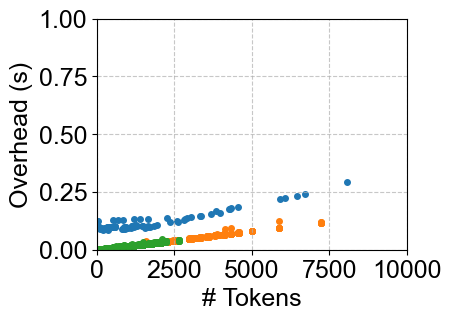

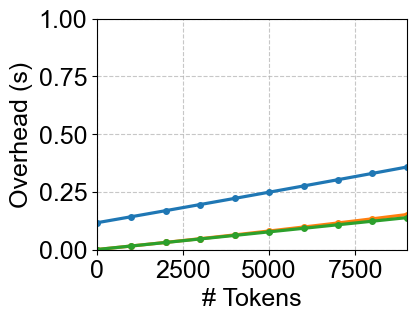

In [277]:
swapin_tokens = convert_block_token(swapin_blocks)
swapout_tokens = convert_block_token(swapout_blocks)
                                     
overhead_list = [(input_len, ttft, 'Recompute-A40'), 
                 (swapin_tokens, swapin_overheads, 'Swap in-A100'), 
                 (swapout_tokens, swapout_overheads, 'Swap out-A100')]
plot_overhead_len(overhead_list, 'real-phi-moe-a100')

num_tokens = range(-1000, 10000, 1000)
coefficients = np.polyfit(input_len, ttft, 2)
polynomial = np.poly1d(coefficients)
recompute_fit = polynomial(num_tokens)

coefficients = np.polyfit(swapin_tokens, swapin_overheads, 2)
polynomial = np.poly1d(coefficients)
swapin_fit = polynomial(num_tokens)

coefficients = np.polyfit(swapout_tokens, swapout_overheads, 2)
polynomial = np.poly1d(coefficients)
swapout_fit = polynomial(num_tokens)

overhead_list = [(num_tokens, recompute_fit, 'Recompute'), 
                 (num_tokens, swapin_fit, 'Swap in'), 
                 (num_tokens, swapout_fit, 'Swap out')]
plot_overhead_len(overhead_list, 'fit-phi-moe-a100', scatter=False, xrange=(0, 9000))

## User expected TDS - reading/speaking

In [278]:
ttft=[3.4969012120000116, 0.17820223399940005, 0.09578855200015823, 0.09564129299906199, 0.2208449859990651, 0.39164119199995184, 0.09377649599991855, 0.08576653499949316, 0.08543075999841676, 0.12197693599955528, 0.08791577299962228, 0.09557057100028032, 0.08936936999998579, 0.24142396800016286, 0.10048773000016809, 0.5397090599999501, 0.08953687900066143, 0.10233995899943693, 0.4762772819995007, 0.09818139799972414, 0.11807128299915348, 0.16018911600076535, 0.14429939799993008, 0.13949154399961117, 0.133361280999452, 0.9957470919998741, 0.8332660899995972, 0.09802553900044586, 0.13936225900033605, 0.100092749000396, 0.10514868100108288, 0.09397841999998491, 0.1014364860002388, 0.09839935200034233, 0.09351926199997251, 0.10171286400145618, 0.09907654400012689, 0.6213098850003007, 0.23447026500070933, 0.09603136000077939, 0.179573495999648, 0.1542179030002444, 0.09554408700023487, 0.0936813570006052, 0.10041995999927167, 0.12918559500030824, 0.09345395099990128, 0.12923944700014545, 0.13504261699927156, 0.12593083499996283, 0.12911010599964357, 0.12785805500061542, 0.12476121199870249, 0.13412041700030386, 0.13639405499998247, 0.13250503000017488, 0.6518467059995601, 0.10623427500104299, 0.0963186749995657, 0.09526813100092113, 0.09826663999956509, 0.09622233800109825, 0.09316252200005692, 0.09816514499834739, 0.09681902800002717, 0.1017930880007043, 0.09530546099995263, 0.8795799569998053, 0.17683078999834834, 0.45766854399880685, 0.18580655000005208, 0.10081986499972118, 0.0976347399991937, 0.09600959299859824, 0.09184571500009042, 0.1479119849991548, 0.09439711500090198, 0.29470552900056646, 0.10363641600088158, 0.09537245599858579, 0.22276025300016045, 0.09447344600084762, 0.09368343599999207, 0.09629555399988021, 0.10114201999931538, 0.09631871300007333, 0.09315982500083919, 0.12225983700045617, 0.1014489320004941, 0.0970045760004723, 0.16565687300135323, 0.09659534400088887, 0.100184752000132, 0.10270269799912057, 0.0948929180012783, 0.1024700269990717, 0.09277401200051827]
input_len=[1841, 4278, 18, 62, 5915, 10809, 1541, 344, 181, 2604, 892, 1111, 846, 6701, 1705, 15752, 809, 1141, 12840, 349, 2372, 3979, 3328, 3050, 2833, 30273, 25920, 352, 2915, 568, 1267, 15, 1119, 907, 127, 1230, 868, 18160, 6459, 990, 4312, 3671, 380, 26, 1633, 2811, 323, 507, 1662, 19, 847, 685, 45, 1211, 2246, 1381, 18539, 1924, 19, 16, 946, 499, 4, 528, 458, 1490, 243, 26683, 4252, 12363, 4549, 569, 55, 7, 115, 3356, 113, 8083, 1130, 17, 6063, 1, 29, 82, 1455, 421, 7, 2593, 1830, 576, 3856, 335, 1203, 1636, 79, 1290, 50]

In [279]:
plt.rcParams.update({'font.size': 19})
def plot_histogram(group_name, group_values, xlable, ylabel,file_name , yrange=(0,6)):

    # Plotting the histogram
    plt.figure(figsize=(6,4.5))
    plt.bar(group_name, group_values, color='grey', edgecolor='none')

    plt.xlabel(xlable)
    plt.ylabel(ylabel)
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.ylim(yrange)
        
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{file_name}-tds.pdf', metadata={"CreationDate": None})
    plt.show()
    

def wpc2tds(wpc):
    return [w/60*1.3 for w in wpc]

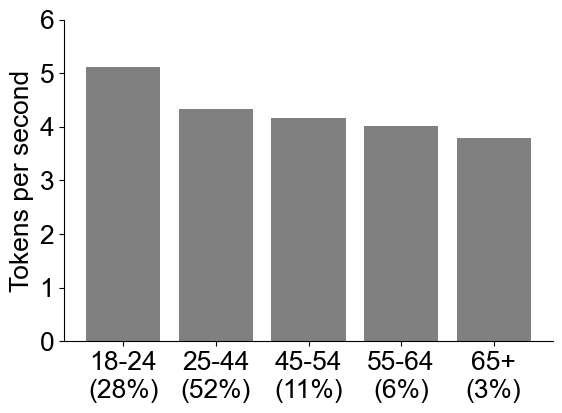

In [280]:
wps=[236, 200, 192, 185,175]
tds=wpc2tds(wps)
plot_histogram(['18-24\n(28%)', '25-44\n(52%)', '45-54\n(11%)', '55-64\n(6%)', '65+\n(3%)'], tds, '', 'Tokens per second', 'reading')
# Reading TDS v.s. Age Group

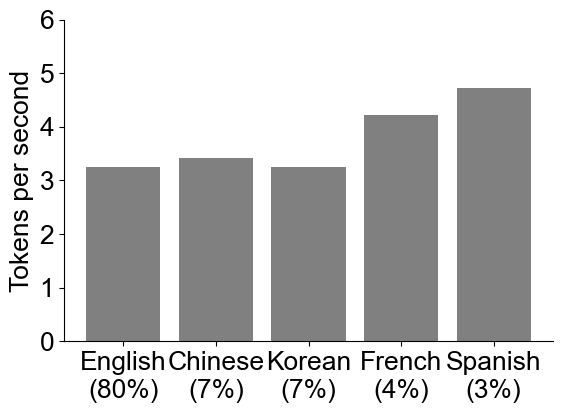

In [281]:
wps=[150, 158,150,195,218]
tds=wpc2tds(wps)
plot_histogram(['English\n(80%)', 'Chinese\n(7%)', 'Korean\n(7%)', 'French\n(4%)', 'Spanish\n(3%)'], tds, '', 'Tokens per second', 'speaking')

### Server TDS

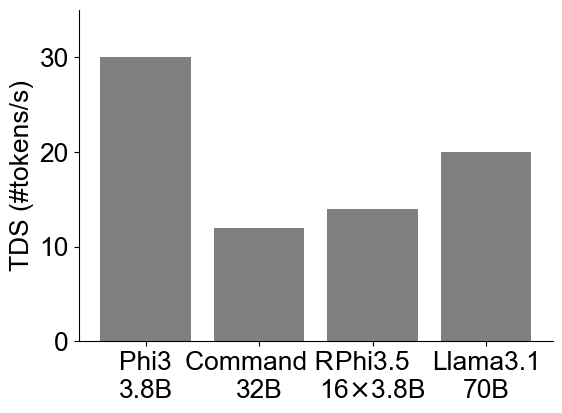

In [282]:
tds=[30, 12,14,20]
models=['Phi3\n3.8B','Command R\n32B', 'Phi3.5\n16$\\times$3.8B', 'Llama3.1\n70B']
plot_histogram(models, tds, '', 'TDS (#tokens/s)', 'server-tds-model',yrange=(0, 35))

# Evaluation


In [283]:
def arrival_rate_to_request_rate(arr_rate):
    return [ 1/i for i in arr_rate]

threshold = 0.9
def cal_qoe_improvement(qoe_list_1, qoe_list_2):
    impr = [round(q1/q2,3) if q1>threshold else 1 for q1, q2 in zip(qoe_list_1, qoe_list_2)]
    return max(impr)

from scipy.interpolate import interp1d
name_list = [SYS_NAME, f'{BASE}', 'LQF', 'Sarathi']
def get_int_x_value(x_list, y_list, target=0.95):
  x_value_list = []
  for i in range(len(x_list)):
      if all(y > target for y in y_list[i]):
        x_value = 3
      elif all(y < target for y in y_list[i]):
        x_value = 1
      else:
        interp_func = interp1d(y_list[i], x_list[i], kind='linear', fill_value='extrapolate')
        x_value = interp_func(target)    
      # print(f'max intensity for {name_list[i]} to get {target} QoE: {x_value}')
      x_value_list.append(x_value)
  res_saving = [round((x_value_list[0]-x_value)/x_value_list[0], 3) for x_value in x_value_list[1:]]
  print(f'To get QoE = {target}: Resource saving over baselines: {res_saving}')
  return res_saving

plt.rcParams.update({'font.size': 20})
def qoe_arrival(x_list, y_list, file_name='opt-a40.pdf', error_list = None, ylabel = 'Avg QoE', legend = False, xlabel='Duration (%)', xmin = 0.5):

  if legend:
    plt.figure(figsize=(10, 5), constrained_layout=True)
  else:
    plt.figure(figsize=(4, 3), constrained_layout=True)

  for i in range(len(x_list)):
    if i==0:
      plt.plot(x_list[i], y_list[i], marker='d', linestyle='-', label=f'{SYS_NAME}', color='orange')
    elif i==1:
      plt.plot(x_list[i], y_list[i], marker='o', linestyle='--', label=f'{BASE}', color='darkblue')
    elif i==2:
      plt.plot(x_list[i], y_list[i], marker='*', linestyle=':', label='LQSF', color='green')
    elif i==3:
      plt.plot(x_list[i], y_list[i], marker='.', linestyle='-.', label='Sarathi-Serve', color='gray')
  
  # Adding labels and title
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if 'Intensity' in xlabel:
    plt.axhline(y=0.95, color='r', linestyle=':')
  # plt.xscale('log')

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.ylim([xmin, 1.05])
  if legend:
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4, frameon=False)
  plt.savefig(f'e2e-{file_name}.pdf')
  if not legend:
    plt.show()


  qoe_impr_list = []
  res_saving = []
  for i in range(len(x_list)-1):
    qoe_impr_list.append(cal_qoe_improvement(y_list[0], y_list[i+1]))

  print(f'max QoE improvement over vllm: {qoe_impr_list[0]}')
  print(f'max QoE improvement over lqf: {qoe_impr_list[1]}')
  print(f'max QoE improvement over sarathi: {qoe_impr_list[2]}')
    
  # if 'Intensity' in xlabel:
    # get_int_x_value(x_list, y_list, 0.9)
  res_saving = get_int_x_value(x_list, y_list, 0.95) 
  
  return qoe_impr_list, res_saving
 


max QoE improvement over vllm: 1.0
max QoE improvement over lqf: 1.0
max QoE improvement over sarathi: 1.0
To get QoE = 0.95: Resource saving over baselines: [0.0, 0.0, 0.0]


([1.0, 1.0, 1.0], [0.0, 0.0, 0.0])

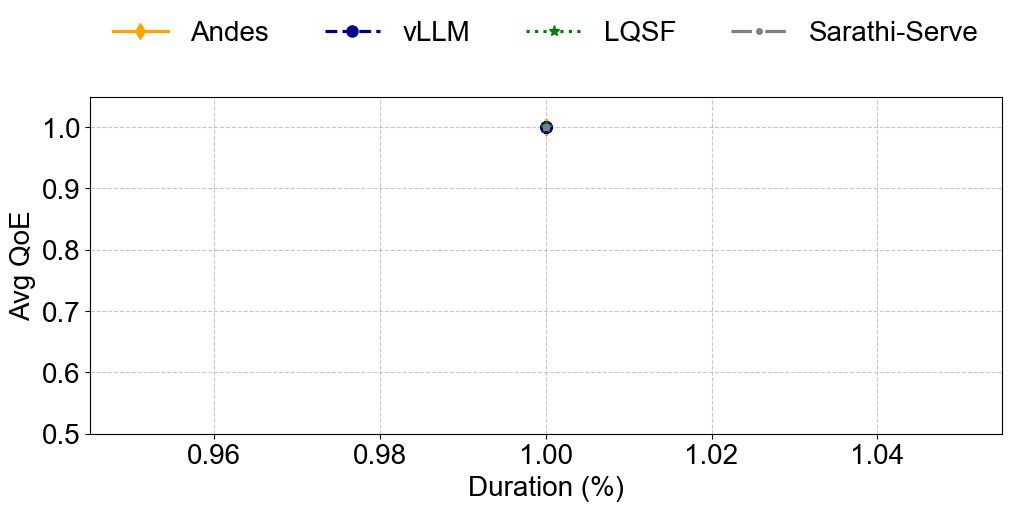

In [284]:
vllm_x = andes_x = [1,1,1,1,1]
vllm_y = [1,1,1,1,1]
andes_y = [1,1,1,1,1]
lqf= [1,1,1,1,1]
qoe_arrival([vllm_x,vllm_x,andes_x,andes_x],[vllm_y,andes_y,lqf,lqf],'legend', legend=True)


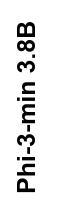

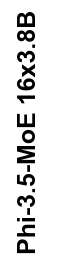

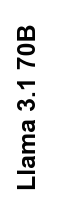

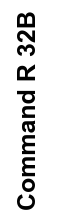

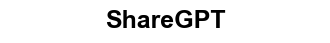

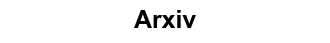

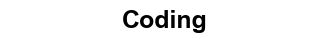

In [285]:
import matplotlib.pyplot as plt

# Sample text data to plot


def text_label(text, rotation=0):
    if rotation == 0:   
        fig, ax = plt.subplots(figsize=(4, .3)) 
    elif rotation == 90:
        fig, ax = plt.subplots(figsize=(.5, 2.5))
    ax.text(.5,.5, text, ha='center', va='center', fontsize=18, rotation=rotation, weight='bold')
    ax.axis('off') 
    plt.savefig(f'{text}.pdf')

text_label('Phi-3-min 3.8B', 90)
text_label('Phi-3.5-MoE 16x3.8B', 90)
text_label('Llama 3.1 70B', 90)
text_label('Command R 32B', 90)


text_label('ShareGPT', 0)
text_label('Arxiv', 0)
text_label('Coding', 0)


In [286]:
qoe_impr_vllm, qoe_impr_sara, qoe_impr_lqf = [], [], []
res_saving_vllm, res_saving_sara, res_saving_lqf = [], [], []
def collect_impr(qoe_impr_list, res_saving_list):

    qoe_impr_vllm.append(qoe_impr_list[0])
    qoe_impr_lqf.append(qoe_impr_list[1])
    qoe_impr_sara.append(qoe_impr_list[2])
    if res_saving_list:
        res_saving_vllm.append(res_saving_list[0])
        res_saving_lqf.append(res_saving_list[1])
        res_saving_sara.append(res_saving_list[2])



## E2E - Duration - A100

### Phi-MoE

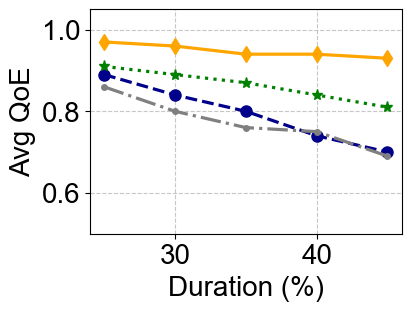

max QoE improvement over vllm: 1.329
max QoE improvement over lqf: 1.148
max QoE improvement over sarathi: 1.348
To get QoE = 0.95: Resource saving over baselines: [0.971, 0.971, 0.971]


In [287]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.89, 0.84, 0.8, 0.74, 0.7]
andes_y = [0.97, 0.96, 0.94, 0.94, 0.93]
lqf = [0.91, 0.89, 0.87, 0.84, 0.81]
sara = [0.86,0.8,0.76,0.75,0.69]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi-moe-arxiv-a100')
collect_impr(qoe_impr_list, res_saving_list )


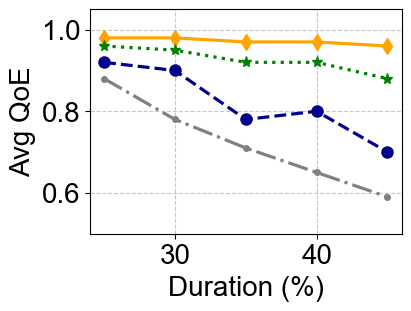

max QoE improvement over vllm: 1.371
max QoE improvement over lqf: 1.091
max QoE improvement over sarathi: 1.627
To get QoE = 0.95: Resource saving over baselines: [0.667, -9.0, 0.667]


In [288]:
vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.92, 0.9, 0.78, 0.8, 0.7]
andes_y = [0.98, 0.98, 0.97, 0.97, 0.96]
lqf=[0.96, 0.95, 0.92, 0.92, 0.88 ]
sara=[0.88, 0.78, 0.71, 0.65, 0.59]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi-moe-multishare-a100')
collect_impr(qoe_impr_list, res_saving_list )


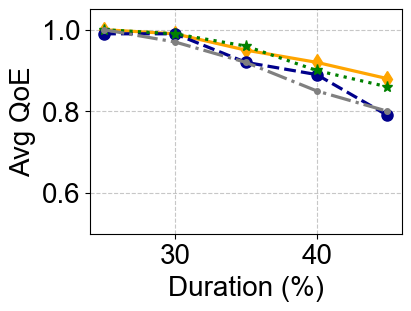

max QoE improvement over vllm: 1.034
max QoE improvement over lqf: 1.022
max QoE improvement over sarathi: 1.082
To get QoE = 0.95: Resource saving over baselines: [0.122, -0.024, 0.086]


In [289]:
vllm_x = andes_x = [25,30,35,40,45]

vllm_y =  [.99,.99,.92,.89,.79]
andes_y = [1,.99,.95,.92,.88]

lqf=[1,.99,.96,.9,.86]
sara=[1,.97,.92,.85,.8]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],
                                             [andes_y,vllm_y,lqf,sara],
                                             'phi-moe-code-a100')
collect_impr(qoe_impr_list, res_saving_list )



### Phi-7B

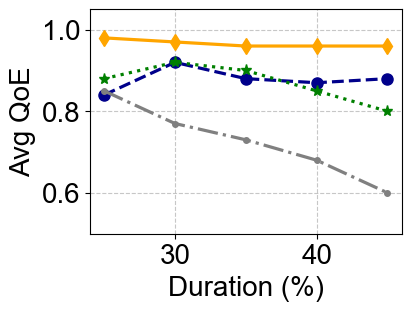

max QoE improvement over vllm: 1.167
max QoE improvement over lqf: 1.2
max QoE improvement over sarathi: 1.6
To get QoE = 0.95: Resource saving over baselines: [0.667, 0.667, 0.667]


In [290]:
vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.84,0.92, 0.88, 0.87, 0.88]
andes_y =  [0.98,0.97, 0.96, 0.96, 0.96]
lqf=[0.88,0.92,0.9,0.85,0.8]
sara = [0.85,0.77,0.73,0.68,0.6]


qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi7b-arxiv-a100')
collect_impr(qoe_impr_list, res_saving_list )



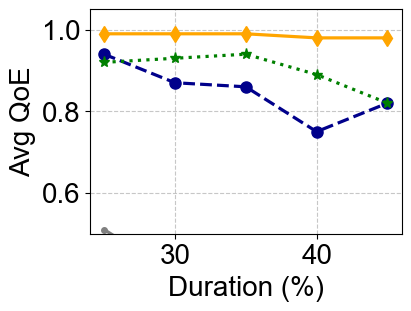

max QoE improvement over vllm: 1.307
max QoE improvement over lqf: 1.195
max QoE improvement over sarathi: 3.5
To get QoE = 0.95: Resource saving over baselines: [0.667, 0.667, 0.667]


In [291]:

# Data for the first curve
vllm_x = andes_x = [25,30,35,40,45]
vllm_y = [0.94, 0.87, 0.86, 0.75, 0.82]
andes_y = [0.99, 0.99, 0.99, 0.98, 0.98]
lqf=[0.92, 0.93, 0.94, 0.89, 0.82,]
sara=[0.51, 0.4, 0.34, 0.38, 0.28, ]
qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi7b-multishare-a100')
collect_impr(qoe_impr_list, res_saving_list )



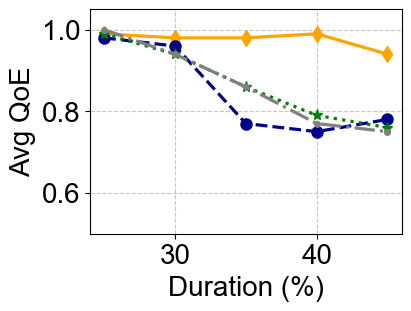

max QoE improvement over vllm: 1.32
max QoE improvement over lqf: 1.253
max QoE improvement over sarathi: 1.286
To get QoE = 0.95: Resource saving over baselines: [0.253, 0.297, 0.293]


In [292]:

# Data for the first curve
vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.98, 0.96, 0.77, 0.75, 0.78]
andes_y = [0.99, 0.98, 0.98, 0.99, 0.94]
lqf=[0.99, 0.94, 0.86, 0.79, 0.76]


sara=[1.0, 0.94, 0.86, 0.77, 0.75]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi7b-code-a100')
collect_impr(qoe_impr_list, res_saving_list )


### Llama3 - 70B

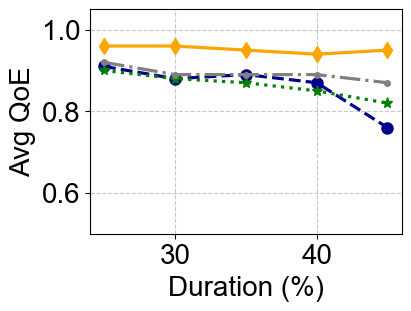

max QoE improvement over vllm: 1.25
max QoE improvement over lqf: 1.159
max QoE improvement over sarathi: 1.092
To get QoE = 0.95: Resource saving over baselines: [0.971, 0.971, 0.971]


In [293]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.91, 0.88, 0.89, 0.87, 0.76]
andes_y = [0.96, 0.96, 0.95, 0.94, 0.95]
lqf=[0.9, 0.88, 0.87, 0.85, 0.82]
sara=[0.92, 0.89, 0.89, 0.89, 0.87]


qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'llama3-arxiv-a100')
collect_impr(qoe_impr_list, res_saving_list )




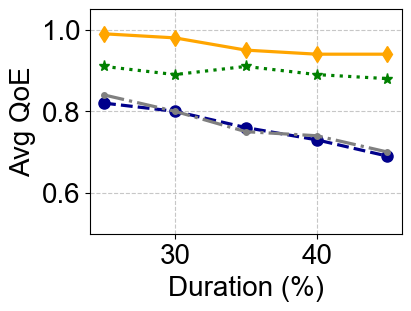

max QoE improvement over vllm: 1.362
max QoE improvement over lqf: 1.101
max QoE improvement over sarathi: 1.343
To get QoE = 0.95: Resource saving over baselines: [0.971, 0.971, 0.971]


In [294]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.82, 0.8, 0.76, 0.73, 0.69]
andes_y = [0.99, 0.98, 0.95, 0.94, 0.94]
lqf = [0.91, 0.89, 0.91, 0.89, 0.88]
sara=[0.84, 0.8, 0.75, 0.74, 0.7]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'llama3-multishare-a100')

collect_impr(qoe_impr_list, res_saving_list )


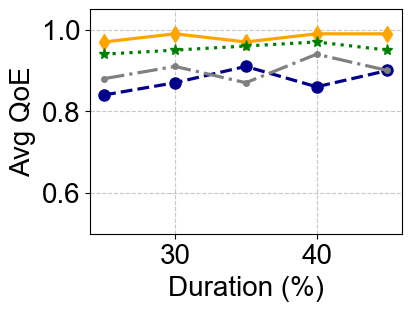

max QoE improvement over vllm: 1.155
max QoE improvement over lqf: 1.042
max QoE improvement over sarathi: 1.115
To get QoE = 0.95: Resource saving over baselines: [0.667, -9.0, 0.667]


In [295]:

# Data for the first curve
vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.84, 0.87, 0.91, 0.86, 0.9]
andes_y =  [0.97, 0.99, 0.97, 0.99, 0.99]
lqf=[0.94, 0.95, 0.96, 0.97, 0.95]
sara=[0.88, 0.91, 0.87, 0.94, 0.9]



qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'llama3-code-a100')
collect_impr(qoe_impr_list, res_saving_list )



### Command

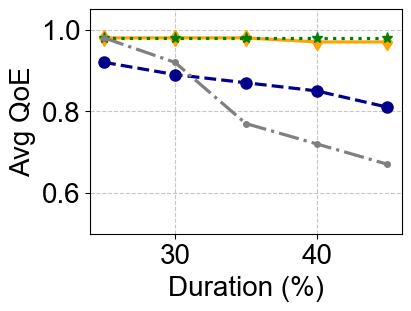

max QoE improvement over vllm: 1.198
max QoE improvement over lqf: 1.0
max QoE improvement over sarathi: 1.448
To get QoE = 0.95: Resource saving over baselines: [0.667, 0.0, -8.167]


In [296]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.92,0.89,0.87,0.85,0.81]
andes_y =[0.98,.98,.98,.97,.97]
lqf=[0.98,.98,.98,.98,.98]
sara=[0.98,0.92,0.77,0.72,0.67]
qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'command-arxiv-a100')
collect_impr(qoe_impr_list, res_saving_list )



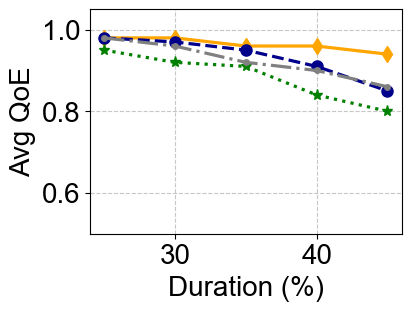

max QoE improvement over vllm: 1.106
max QoE improvement over lqf: 1.175
max QoE improvement over sarathi: 1.093
To get QoE = 0.95: Resource saving over baselines: [0.125, 0.375, 0.219]


In [297]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.98,0.97,0.95,0.91,0.85]
andes_y =[0.98,0.98,0.96,0.96,0.94]
lqf=[.95,.92,.91,.84,.8]
sara=[0.98,0.96,0.92,0.9,0.86]

qoe_impr_list, res_saving_list = qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'command-multishare-a100')
collect_impr(qoe_impr_list, res_saving_list )



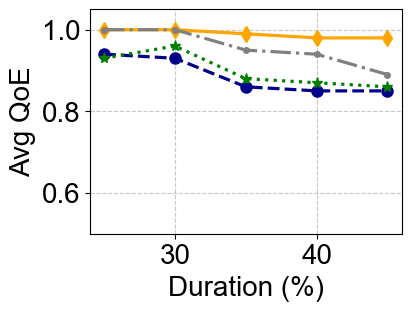

max QoE improvement over vllm: 1.153
max QoE improvement over lqf: 1.14
max QoE improvement over sarathi: 1.101
To get QoE = 0.95: Resource saving over baselines: [0.667, -8.444, -10.667]


In [298]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.94,0.93,0.86,0.85,0.85]
andes_y =[1,1,0.99,0.98,0.98]
lqf=[0.93,.96,.88,.87,.86]
sara=[1,1,0.95,0.94,0.89]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],
                                             'command-code-a100')
collect_impr(qoe_impr_list, res_saving_list )



### Summary

In [299]:
print(f'QoE improvement over vllm: max - {max(qoe_impr_vllm)}, avg - {sum(qoe_impr_vllm)/len(qoe_impr_vllm)} - min - {min(qoe_impr_vllm)}')
print(f'QoE improvement over lqf: max - {max(qoe_impr_lqf)}, avg - {sum(qoe_impr_lqf)/len(qoe_impr_lqf)} - min - {min(qoe_impr_lqf)}')
print(f'QoE improvement over sarathi: max - {max(qoe_impr_sara)}, avg - {sum(qoe_impr_sara)/len(qoe_impr_sara)} - min - {min(qoe_impr_sara)}')
print(f'Resource saving over vllm: max - {max(res_saving_vllm)}, avg - {sum(res_saving_vllm)/len(res_saving_vllm)} - min - {min(res_saving_vllm)}')
print(f'Resource saving over lqf: max - {max(res_saving_lqf)}, avg - {sum(res_saving_lqf)/len(res_saving_lqf)} - min - {min(res_saving_lqf)}')
print(f'Resource saving over sarathi: max - {max(res_saving_sara)}, avg - {sum(res_saving_sara)/len(res_saving_sara)} - min - {min(res_saving_sara)}')
qoe_impr_vllm, qoe_impr_sara, qoe_impr_lqf = [], [], []
res_saving_vllm, res_saving_sara, res_saving_lqf = [], [], []


QoE improvement over vllm: max - 1.371, avg - 1.2293333333333334 - min - 1.034
QoE improvement over lqf: max - 1.253, avg - 1.1271666666666669 - min - 1.0
QoE improvement over sarathi: max - 3.5, avg - 1.4695833333333332 - min - 1.082
Resource saving over vllm: max - 0.971, avg - 0.6179166666666666 - min - 0.122
Resource saving over lqf: max - 0.971, avg - -1.79575 - min - -9.0
Resource saving over sarathi: max - 0.971, avg - -1.0545833333333332 - min - -10.667


## E2E - Intensity - A100

### Phi - MoE

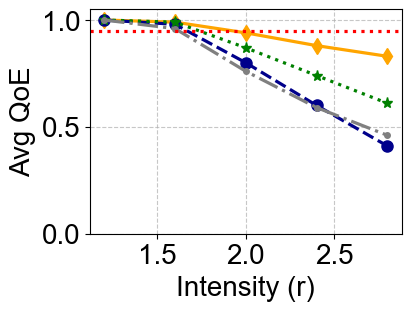

max QoE improvement over vllm: 1.175
max QoE improvement over lqf: 1.08
max QoE improvement over sarathi: 1.237
To get QoE = 0.95: Resource saving over baselines: [0.132, 0.097, 0.156]


In [300]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]
vllm_y = [1.0, 0.98, 0.8, 0.6, 0.41]
andes_y = [1.0, 0.99, 0.94, 0.88, 0.83]
lqf=[1,0.99,0.87,0.74,0.61]
sara=[1,0.96,0.76,0.59,0.46]
qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi-moe-arxiv-intensity-a100', xlabel='Intensity (r)',xmin=0)

collect_impr(qoe_impr_list, res_saving_list )


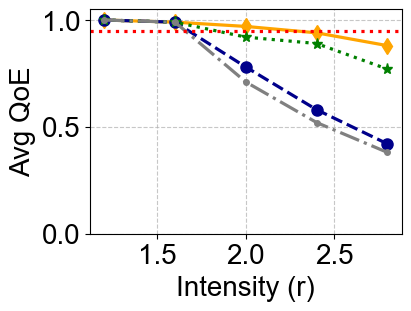

max QoE improvement over vllm: 1.621
max QoE improvement over lqf: 1.056
max QoE improvement over sarathi: 1.808
To get QoE = 0.95: Resource saving over baselines: [0.261, 0.193, 0.269]


In [301]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [1.0, 0.99, 0.78, 0.58, 0.42]
andes_y =  [1.0, 0.99, 0.97, 0.94, 0.88]
lqf=[1.0, 0.99, 0.92, 0.89, 0.77]
sara=[1.0, 0.99,0.71,0.52,0.38]



qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi-moe-multishare-intensity-a100', xlabel='Intensity (r)',xmin=0)
collect_impr(qoe_impr_list, res_saving_list )




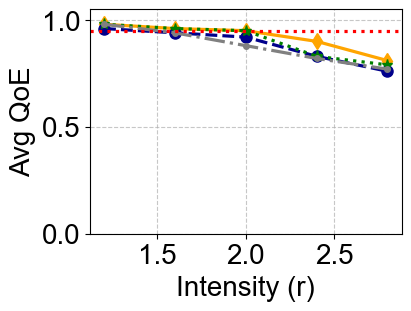

max QoE improvement over vllm: 1.033
max QoE improvement over lqf: 1.0
max QoE improvement over sarathi: 1.08
To get QoE = 0.95: Resource saving over baselines: [0.3, 0.0, 0.25]


In [302]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [0.96, .94, .92, .83, .76]
andes_y = [.98, .96, .95,.9, .81]
lqf=[.98,.96, .95,.83,.79]
sara=[.98,.94,.88,.82,.77]
 

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],
                                             [andes_y,vllm_y,lqf,sara],
                                             'phi-moe-code-intensity-a100', 
                                             xlabel='Intensity (r)',xmin=0)
collect_impr(qoe_impr_list, res_saving_list )




### Phi - 7B

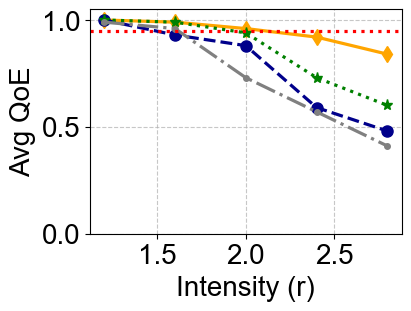

max QoE improvement over vllm: 1.559
max QoE improvement over lqf: 1.26
max QoE improvement over sarathi: 1.614
To get QoE = 0.95: Resource saving over baselines: [0.293, 0.086, 0.23]


In [303]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y =[1.0, 0.93, 0.88, 0.59, 0.48]
andes_y =  [1.0, 0.99, 0.96, 0.92, 0.84]
lqf=[1, 0.99,0.94,0.73,0.6]
sara = [0.99,0.96,0.73,0.57,0.41]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi7b-arxiv-intensity-a100', xlabel='Intensity (r)',xmin=0)
collect_impr(qoe_impr_list, res_saving_list )




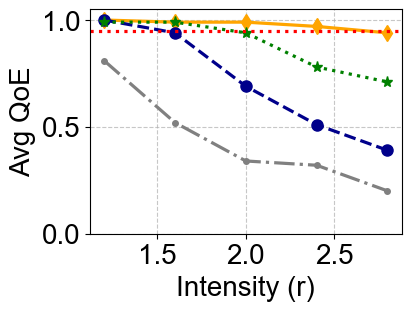

max QoE improvement over vllm: 2.41
max QoE improvement over lqf: 1.324
max QoE improvement over sarathi: 4.7
To get QoE = 0.95: Resource saving over baselines: [0.425, 0.31, 0.625]


In [304]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [1.0, 0.94, 0.69, 0.51, 0.39]
andes_y =  [1.0, 0.99, 0.99, 0.97, 0.94]
lqf=[0.99, 0.99, 0.94, 0.78, 0.71]
sara=[ 0.81, 0.52, 0.34, 0.32, 0.2]
qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi7b-multishare-intensity-a100', xlabel='Intensity (r)',xmin=0)
collect_impr(qoe_impr_list, res_saving_list )




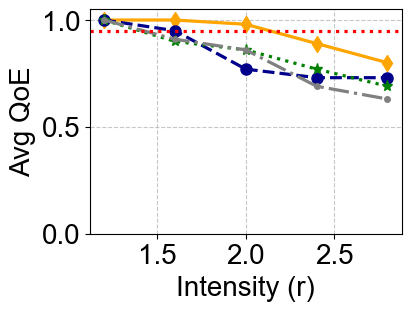

max QoE improvement over vllm: 1.273
max QoE improvement over lqf: 1.14
max QoE improvement over sarathi: 1.14
To get QoE = 0.95: Resource saving over baselines: [0.25, 0.344, 0.333]


In [305]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [1.0, 0.95, 0.77, 0.73, 0.73]
andes_y = [1.0, 1, 0.98, 0.89, 0.8]
lqf=[1.0, 0.9, 0.86, 0.77, 0.69]
sara=[1.0, 0.91, 0.86, 0.69, 0.63]


qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'phi7b-code-intensity-a100', xlabel='Intensity (r)',xmin=0)
collect_impr(qoe_impr_list, res_saving_list )




### Llama 3

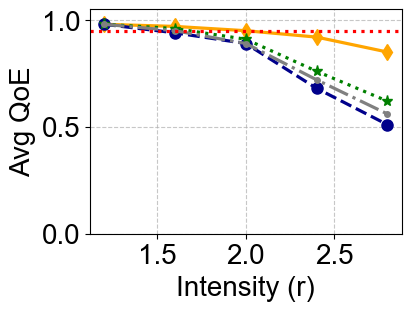

max QoE improvement over vllm: 1.353
max QoE improvement over lqf: 1.211
max QoE improvement over sarathi: 1.278
To get QoE = 0.95: Resource saving over baselines: [0.25, 0.16, 0.2]


In [306]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y =[0.98, 0.94, 0.89, 0.68, 0.51]
andes_y =  [0.98, 0.97, 0.95, 0.92, 0.85]
lqf=[0.98, 0.96, 0.91, 0.76, 0.62]
sara=[0.98, 0.95, 0.89, 0.72, 0.56]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'llama-arxiv-intensity-a100', xlabel='Intensity (r)',xmin=0)
collect_impr(qoe_impr_list, res_saving_list )




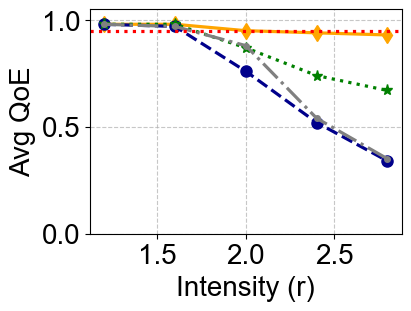

max QoE improvement over vllm: 2.735
max QoE improvement over lqf: 1.388
max QoE improvement over sarathi: 2.657
To get QoE = 0.95: Resource saving over baselines: [0.181, 0.291, 0.156]


In [307]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [0.98, 0.97, 0.76, 0.52, 0.34]
andes_y =  [0.98, 0.98, 0.95, 0.94, 0.93]
lqf=[0.98, 0.98, 0.87, 0.74, 0.67]
sara=[0.98, 0.97, 0.88, 0.54, 0.35]


qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara,],'llama-multishare-intensity-a100', xlabel='Intensity (r)',xmin=0)

collect_impr(qoe_impr_list, res_saving_list )



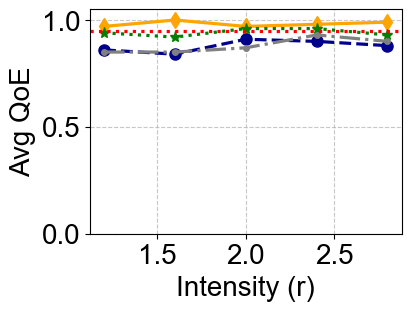

max QoE improvement over vllm: 1.19
max QoE improvement over lqf: 1.087
max QoE improvement over sarathi: 1.176
To get QoE = 0.95: Resource saving over baselines: [0.667, 0.467, 0.667]


In [308]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [0.86, 0.84, 0.91, 0.9, 0.88]
andes_y =  [0.97, 1.0, 0.97, 0.98, 0.99]
lqf=[0.94, 0.92, 0.96, 0.96, 0.93]
sara=[0.85, 0.85, 0.87, 0.93, 0.9]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'llama-code-intensity-a100', xlabel='Intensity (r)',xmin=0)

# collect_impr(qoe_impr_list, res_saving_list )



### Command

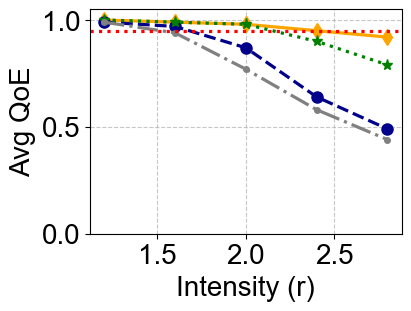

max QoE improvement over vllm: 1.878
max QoE improvement over lqf: 1.165
max QoE improvement over sarathi: 2.091
To get QoE = 0.95: Resource saving over baselines: [0.3, 0.104, 0.367]


In [309]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [0.99,0.97,0.87,0.64,0.49]
andes_y = [1,.99,.98,.95,.92]
lqf=[1,.99,.98,.9,.79]
sara= [0.99,0.94,0.77,0.58,0.44]
qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],
                                             [andes_y,vllm_y,lqf,sara],
                                             'command-arxiv-intensity-a100', 
                                             xlabel='Intensity (r)',xmin=0)

collect_impr(qoe_impr_list, res_saving_list )



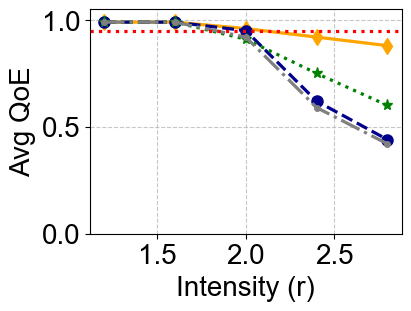

max QoE improvement over vllm: 1.484
max QoE improvement over lqf: 1.227
max QoE improvement over sarathi: 1.559
To get QoE = 0.95: Resource saving over baselines: [0.048, 0.238, 0.211]


In [310]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [0.99,0.99,0.95,0.62,0.44]
andes_y =  [0.99,0.99,0.96,0.92,0.88]
lqf=[0.99,.99,.91,.75,.6]
 
sara=[0.99,0.99,0.92,0.59,0.42]



qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],
                                             'command-multishare-intensity-a100', xlabel='Intensity (r)',xmin=0)

collect_impr(qoe_impr_list, res_saving_list )



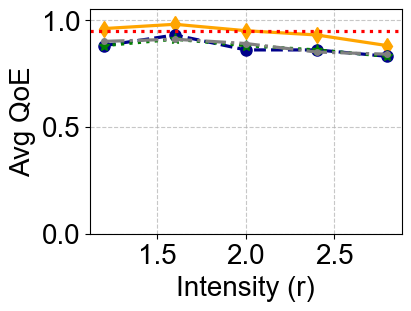

max QoE improvement over vllm: 1.105
max QoE improvement over lqf: 1.091
max QoE improvement over sarathi: 1.094
To get QoE = 0.95: Resource saving over baselines: [0.5, 0.5, 0.5]


In [311]:

# Data for the first curve
vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]

vllm_y = [0.88,0.93,0.86,0.86,0.83]
andes_y = [0.96,0.98,0.95,0.93,0.88]
lqf=[.88,.91,.88,.86,.83]
sara=[0.9,.91,.89,.85,.84]

qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],
                                             'command-code-intensity-a100', xlabel='Intensity (r)',xmin=0)

collect_impr(qoe_impr_list, res_saving_list )

## Summary

In [312]:
print(f'QoE improvement over vllm: max - {max(qoe_impr_vllm)}, avg - {sum(qoe_impr_vllm)/len(qoe_impr_vllm)} - min - {min(qoe_impr_vllm)}')
print(f'QoE improvement over lqf: max - {max(qoe_impr_lqf)}, avg - {sum(qoe_impr_lqf)/len(qoe_impr_lqf)} - min - {min(qoe_impr_lqf)}')
print(f'QoE improvement over sarathi: max - {max(qoe_impr_sara)}, avg - {sum(qoe_impr_sara)/len(qoe_impr_sara)} - min - {min(qoe_impr_sara)}')
      

QoE improvement over vllm: max - 2.735, avg - 1.6023636363636364 - min - 1.033
QoE improvement over lqf: max - 1.388, avg - 1.1765454545454543 - min - 1.0
QoE improvement over sarathi: max - 4.7, avg - 1.841636363636364 - min - 1.08


In [313]:
print(f'Resource saving over vllm: max - {max(res_saving_vllm)}, avg - {sum(res_saving_vllm)/len(res_saving_vllm)} - min - {min(res_saving_vllm)}')
print(f'Resource saving over lqf: max - {max(res_saving_lqf)}, avg - {sum(res_saving_lqf)/len(res_saving_lqf)} - min - {min(res_saving_lqf)}')
print(f'Resource saving over sarathi: max - {max(res_saving_sara)}, avg - {sum(res_saving_sara)/len(res_saving_sara)} - min - {min(res_saving_sara)}')


Resource saving over vllm: max - 0.5, avg - 0.2672727272727273 - min - 0.048
Resource saving over lqf: max - 0.5, avg - 0.21118181818181814 - min - 0.0
Resource saving over sarathi: max - 0.625, avg - 0.29972727272727273 - min - 0.156


## Possion

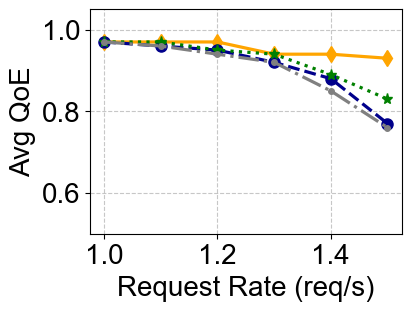

max QoE improvement over vllm: 1.208
max QoE improvement over lqf: 1.12
max QoE improvement over sarathi: 1.224
To get QoE = 0.95: Resource saving over baselines: [0.053, 0.053, 0.092]


In [314]:

# Data for the first curve
vllm_x = andes_x = [1,1.1,1.2,1.3,1.4,1.5]
vllm_y = [.97,.96,.95,.92,.88,.77]
andes_y = [.97,.97,.97,.94,.94,.93]
lqf=[.97,.97,.95,.94,.89,.83]
sara=[.97,.96,.94,.92,.85,.76]
qoe_impr_list, res_saving_list = qoe_arrival([andes_x,vllm_x,vllm_x,vllm_x],[andes_y,vllm_y,lqf,sara],'llama3-multishare-poisson-a100', xlabel='Request Rate (req/s)',xmin=0.5)

collect_impr(qoe_impr_list, res_saving_list )


## TTFT / TDS Mismatch


In [334]:

plt.rcParams.update({'font.size': 16})
def ttft_breakdown_arrival(x_list, y_list, file_name, metric_name = 'TTFT (s)', log_scale= True, yrange = None, horizontal = None):
  plt.figure(figsize=(4,3), constrained_layout=True)

  # plt.plot(x_list[1], y_list[1],label=f'{SYS_NAME}',marker='d',  markersize=5,linestyle='-', color='orange')
  plt.plot(x_list[0], y_list[0], label=f'{BASE}',marker='o', markersize=5, linestyle='--', color='darkblue')
  # plt.plot(x_list[2], y_list[2], marker='.',  markersize=5,linestyle='-.', label='Sarathi', color='gray')


  plt.xlabel('Burst duration (min)')
  plt.ylabel("Average TTFT (s)")

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  if log_scale:
    plt.yscale('log')
  plt.xlim((0,20))

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  if yrange:
    plt.ylim(yrange)
  if horizontal:
    for h in horizontal:
      plt.axhline(y=h, color='r', linestyle='--', linewidth=1)
  plt.text(8, 2.6,'Target TTFT (1.3 s)')
  # plt.legend( )
  metric_name = metric_name.replace(' ', '_')
  plt.savefig(f'{metric_name}-arrival-{file_name}.pdf')
  plt.show()



In [335]:
def tds_breakdown_arrival(x_list, y_list, file_name, metric_name = 'TDS (#tokens/s)', log_scale= True, yrange = None, horizontal = None):
  plt.figure(figsize=(4,3), constrained_layout=True)

  # plt.plot(x_list[1], y_list[1],label=f'{SYS_NAME}',marker='d',  markersize=5,linestyle='-', color='orange')
  plt.plot(x_list[0], y_list[0], label=f'{BASE}',marker='o',  markersize=5,linestyle='--', color='darkblue')
  # plt.plot(x_list[2], y_list[2], marker='.', linestyle='-.',  markersize=5,label='Sarathi', color='gray')

  plt.xlabel('Burst duration (min)')
  plt.ylabel('Average TDS (tokens/s)')

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  if log_scale:
    plt.yscale('log')
  plt.xlim((0,20))

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  if yrange:
    plt.ylim(yrange)
  if horizontal:
    for h in horizontal:
      plt.axhline(y=h, color='r', linestyle='--', linewidth=1)
  plt.text(2,5.5,'Reading speed (4.8 tok/s)')
  plt.text(2,1.6,'Listening speed (3.3 tok/s)')
  # plt.legend( )  #
  plt.savefig(f'{metric_name}-arrival-{file_name}.pdf')
  plt.show()



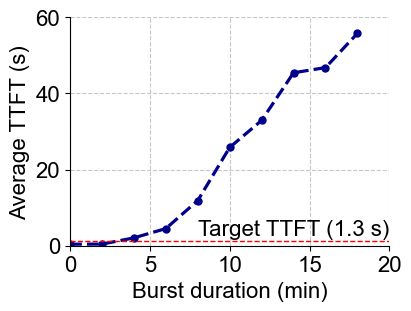

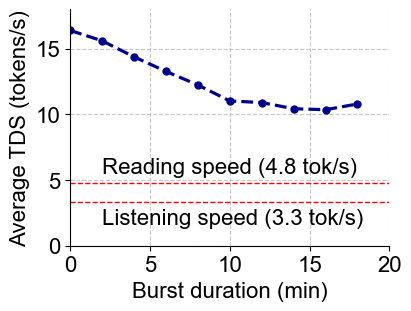

In [336]:
## phi-moe
vllm_x = andes_x = [0,10, 20, 25, 30,35,40,45, 50,60,70,80,90]
vllm_res =  [0.38, 0.4, 2.04, 3.73, 4.48, 13.59, 11.85, 21.88, 25.81, 32.91, 45.43, 55.79, 46.79]
andes_res =  [0.39, 0.39, 0.81, 1.01, 1.33, 2.0, 1.83, 3.79, 4.66, 5.84, 11.45, 11.83, 12.09]
sara_res =[0.43, 0.46, 4.51, 7.73, 17.03, 26.62, 35.73, 48.31, 62.68, 77.27, 89.78, 111.96, 130.6]
vllm_x = andes_x = [0,10, 20, 30 ,40,  50,60,70,80,90]

vllm_x = [a*20/100 for a in vllm_x]
vllm_res =  [0.38, 0.4, 2.04,   4.48,   11.85,   25.81, 32.91, 45.43, 46.79,55.79, ]
ttft_breakdown_arrival([vllm_x,andes_x,andes_x],[vllm_res,andes_res,sara_res], 'phi-moe-share-a100', 'TTFT (s)', log_scale=False, yrange=(0,60), horizontal=[1.3])


vllm_res = [16.39, 15.6, 14.38, 12.65, 13.27, 12.23, 12.24, 11.62, 11.02, 10.9, 10.429, 10.353, 10.79]
andes_res =  [15.65, 15.3, 14.5, 13.14, 12.54, 11.87, 11.11, 10.58, 10.22, 10.13, 9.29, 9.11, 9.25]
sara = [15.24, 13.76, 12.07, 11.23, 9.98, 9.78, 9.44, 9.06, 8.93, 8.87, 8.71, 8.69, 8.58]
vllm_res = [16.39, 15.6, 14.38,   13.27,  12.24,  11.02, 10.9, 10.429, 10.353, 10.79]

tds_breakdown_arrival([vllm_x,andes_x,andes_x],[vllm_res,andes_res, sara], 'phi-moe-share-a100', 'tds', horizontal=[ 3.3, 4.8],log_scale=False, yrange=(0,18))


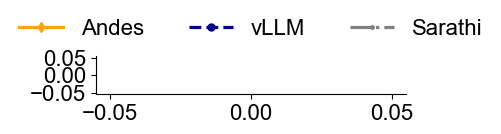

In [318]:
import matplotlib.pyplot as plt

def tds_legend_only(file_name=None, metric_name='TDS (#tokens/s)'):
    plt.figure(figsize=(4, 0.5))  # Set the height small since we're only showing the legend
    
    # Dummy plot lines to generate legend entries without plotting actual data
    plt.plot([], [], label=f'{SYS_NAME}', marker='d',  markersize=5,linestyle='-', color='orange')
    plt.plot([], [], label=f'{BASE}', marker='o',  markersize=5,linestyle='--', color='darkblue')
    plt.plot([], [], label='Sarathi', marker='.',  markersize=5,linestyle='-.', color='gray')
    
    # Create the legend only
    plt.legend(loc='center', bbox_to_anchor=(.5, 1.7), ncol=3, frameon=False)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # Save the legend as a file
    plt.savefig(f'mismatch-legend.pdf', bbox_inches='tight')
    plt.show()

# Call this function to save and display only the legend
tds_legend_only()


# Ablation 

## Preemption mode

In [319]:

plt.rcParams.update({'font.size': 18})
def preemption_qoe_arrival(x_list, y_list, file_name='opt-a40.pdf', error_list = None, ylabel = 'Avg QoE', xlabel='Duration(%)', ymin=0.5, legend=False):
  plt.figure(figsize=(4,3), constrained_layout=True)

  plt.plot(x_list[0], y_list[0],marker='o', linestyle='-', color='darkblue', label=f'{BASE}')
  plt.plot(x_list[1], y_list[1], marker='d', linestyle='-', label=f'{SYS_NAME} w/ recompute', color='orange')
  plt.plot(x_list[2], y_list[2], marker='.', linestyle='--', label=f'{SYS_NAME} w/ swap', color='orangered')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.axhline(y=0.9, color='r', linestyle=':')

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.ylim([ymin,1.05])
  if legend:
    plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.3), ncol=3, frameon=False)
  # plt.legend(loc='lower left', fontsize=18)
  plt.savefig(f'{file_name}.pdf', bbox_inches='tight')
  if not legend:
    plt.show()



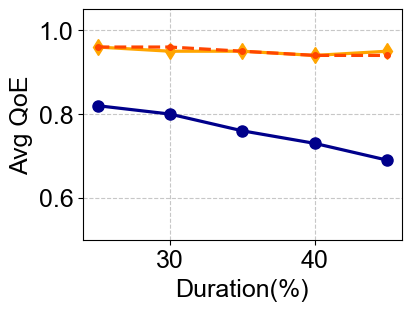

/var/folders/8f/d8w9w4r958zfd4m46fpqj4gr0000gp/T/ipykernel_15432/2960386608.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.gca().figure.savefig(modified_fname, *args, **kwargs)
/Users/amberljc/miniconda/envs/tsaas/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/amberljc/miniconda/envs/tsaas/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


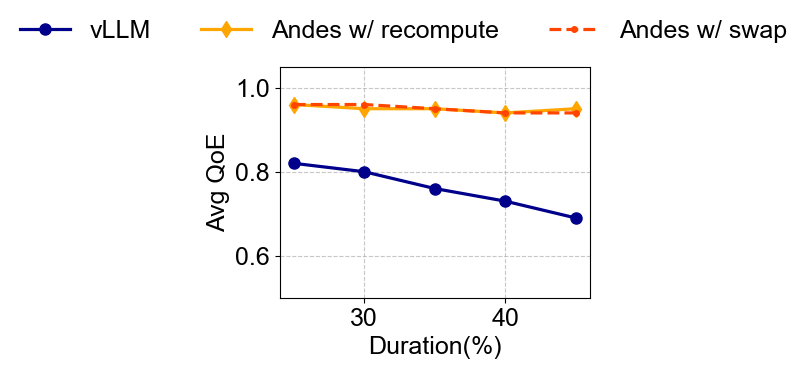

In [320]:

# Data for the first curve
vllm_x = andes_x = [25, 30, 35, 40, 45]

vllm_y = [0.82, 0.8, 0.76, 0.73, 0.69]
andes_y = [0.96, 0.95, 0.95, 0.94, 0.95]

swap_y=[0.96, 0.96, 0.95, 0.94, 0.94]


preemption_qoe_arrival([vllm_x,andes_x,andes_x],[vllm_y,andes_y,swap_y],'llama3-multi-a100-preemption')
preemption_qoe_arrival([vllm_x,andes_x,andes_x],[vllm_y,andes_y,swap_y],'llama3-multi-a100-preemption-legend', legend=True)



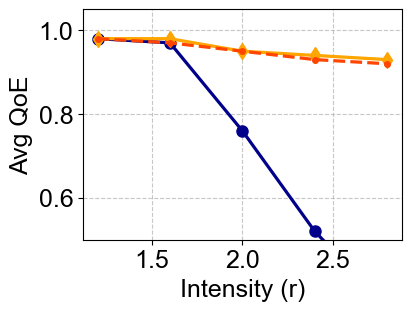

In [321]:

vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]
vllm_y = [0.98, 0.97, 0.76, 0.52, 0.34]
andes_y =  [0.98, 0.98, 0.95, 0.94, 0.93]
swap_y=[0.98, 0.97, 0.95, 0.93, 0.92]

preemption_qoe_arrival([vllm_x,andes_x,andes_x],[vllm_y,andes_y,swap_y],'llama3-multi-a100-intensity-preemption', ymin=0.5, xlabel='Intensity (r)')



## Overhead-Aware

/var/folders/8f/d8w9w4r958zfd4m46fpqj4gr0000gp/T/ipykernel_15432/320499251.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


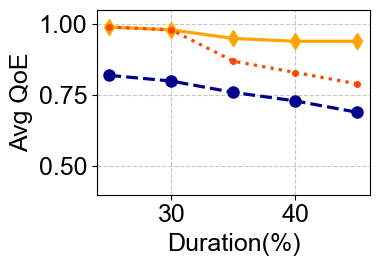

/var/folders/8f/d8w9w4r958zfd4m46fpqj4gr0000gp/T/ipykernel_15432/2960386608.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.gca().figure.savefig(modified_fname, *args, **kwargs)


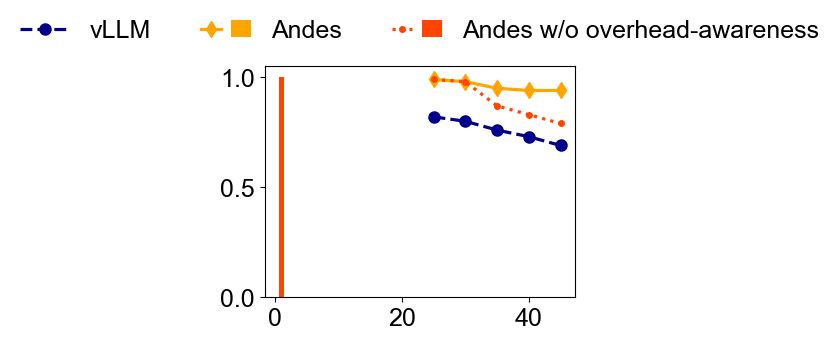

In [ ]:
plt.rcParams.update({'font.size': 18})
def overhead_qoe_arrival(x_list, y_list, file_name='opt-a40.pdf', error_list = None, ylabel = 'Avg QoE', xlabel='Duration(%)', ymin=0.4, legend=False):
  plt.figure(figsize=(4,3), constrained_layout=True)

  plt.plot(x_list[0], y_list[0],marker='o', linestyle='--', color='darkblue', label=f'{BASE}')
  plt.plot(x_list[1], y_list[1], marker='d', linestyle='-', label=f'{SYS_NAME}', color='orange')
  plt.plot(x_list[2], y_list[2], marker='.', linestyle=':', label=f'{SYS_NAME} w/o overhead-awareness', color='orangered')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.axhline(y=0.9, color='r', linestyle=':')

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.ylim([ymin,1.05])
  plt.tight_layout()
  if legend:
    plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.3), ncol=3, frameon=False)
  plt.savefig(f'{file_name}.pdf', format='pdf', bbox_inches='tight')
  if not legend:
    plt.show()


vllm_x = andes_x = [25, 30, 35, 40, 45]
vllm_y = [0.82, 0.8, 0.76, 0.73, 0.69]
andes_y = [0.99, 0.98, 0.95, 0.94, 0.94]
andes_wo_overhead = [.99, .98, .87, .83,.79]

overhead_qoe_arrival([vllm_x,andes_x,andes_x],[vllm_y,andes_y,andes_wo_overhead],'llama3-multi-a100-duration-overhead')
# overhead_qoe_arrival([vllm_x,andes_x,andes_x],[vllm_y,andes_y,andes_wo_overhead],'llama3-multi-a100-duration-overhead-legend', legend=True)


from matplotlib.legend_handler import HandlerTuple
def overhead_qoe_arrival_legend(x_list, y_list, file_name='opt-a40.pdf', error_list = None, ylabel = 'Avg QoE', xlabel='Duration(%)', ymin=0.4, legend=False):
  plt.figure(figsize=(4,3), constrained_layout=True)

  l1,=plt.plot(x_list[0], y_list[0],marker='o', linestyle='--', color='darkblue', label=f'{BASE}')
  b1, = plt.bar([1], [1], color="orange", label="")
  l2,=plt.plot(x_list[1], y_list[1], marker='d', linestyle='-', label=f'{SYS_NAME}', color='orange')
  b2, = plt.bar([1], [1], color="orangered", label="")
  l3,=plt.plot(x_list[2], y_list[2], marker='.', linestyle=':', label=f'{SYS_NAME} w/o overhead-awareness', color='orangered')
  
  first_row = plt.legend(
      handles=[l1, (l2, b1), (l3, b2)], 
      labels=[f'{BASE}', f'{SYS_NAME}', f'{SYS_NAME} w/o overhead-awareness'], 
      loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3, frameon=False,
      handler_map={tuple: HandlerTuple(ndivide=None)}
  )
  plt.savefig(f'{file_name}-legend.pdf', bbox_inches='tight')
  


overhead_qoe_arrival_legend([vllm_x,andes_x,andes_x],[vllm_y,andes_y,andes_wo_overhead],'llama3-multi-a100-duration-overhead')


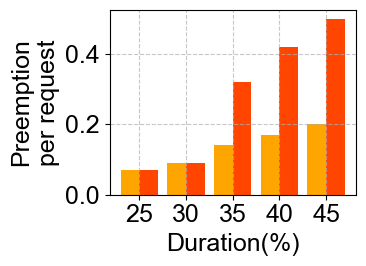

In [325]:

# Data
andes_x = [25, 30, 35, 40, 45]
andes_pre_freq = [0.07, 0.09, 0.14, 0.17, 0.2]
andes_pre_freq_wo = [0.07, 0.09, 0.32, 0.42, 0.5]

# Bar width
bar_width = 2
x_indexes = np.array(andes_x)

# Plotting
plt.figure(figsize=(4, 3))
plt.bar(x_indexes - bar_width / 2, andes_pre_freq, width=bar_width, label=f'{SYS_NAME} w/ Overhead-Aware',color='orange')
plt.bar(x_indexes + bar_width / 2, andes_pre_freq_wo, width=bar_width, label=f'{SYS_NAME} w/o Overhead-Aware',color='orangered')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Labels and legend
plt.xlabel('Duration(%)')
plt.ylabel('Preemption\nper request')

plt.xticks(andes_x)
# plt.legend()
plt.tight_layout()
plt.savefig('llama-share-preemption-freq.pdf')
plt.show()



## Prediction Timeframe

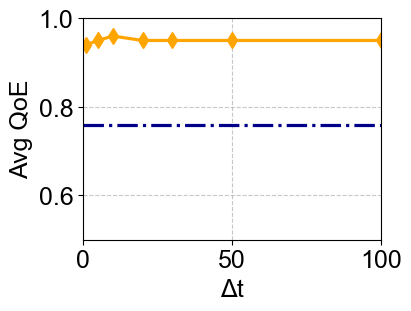

In [ ]:


plt.figure(figsize=(4,3), constrained_layout=True)

# Data for the first curve
x2 = [1,5, 10, 20, 30, 50,100]
y2 = [0.94,0.95, 0.96, 0.95, 0.95, 0.95,  0.95]



# Plotting the curves
plt.axhline(y=0.76, color='darkblue', linestyle='-.', label=f'{BASE}')
plt.plot(x2, y2, label=f'{SYS_NAME}',marker='d', color='orange')

# Adding labels and title
plt.xlabel('Δt')
plt.ylabel('Avg QoE')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.ylim((0.5, 1))
plt.xlim((0,100))
# plt.legend()
plt.savefig('delta-t-llama-multishare.pdf')
plt.show()



## DP v.s. Greedy

In [326]:

plt.rcParams.update({'font.size': 18})
def dp_qoe_arrival(x_list, y_list, file_name='opt-a40.pdf', error_list = None, ylabel = 'Avg QoE', xlabel='Duration(%)', ymin=0.5, legend=False):
  plt.figure(figsize=(4,3), constrained_layout=True)

  plt.plot(x_list[0], y_list[0],marker='o', linestyle='--', color='darkblue', label=f'{BASE}')
  plt.plot(x_list[1], y_list[1], marker='d', linestyle='-', label=f'{SYS_NAME} w/ Greedy', color='orange')
  plt.plot(x_list[2], y_list[2], marker='.', linestyle=':', label=f'{SYS_NAME} w/ DP', color='orangered')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.axhline(y=0.9, color='r', linestyle=':')

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.ylim([ymin,1.05])
  if legend:
    plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.3), ncol=3, frameon=False)

  plt.savefig(f'{file_name}.pdf', format='pdf', bbox_inches='tight')


/var/folders/8f/d8w9w4r958zfd4m46fpqj4gr0000gp/T/ipykernel_15432/2960386608.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.gca().figure.savefig(modified_fname, *args, **kwargs)


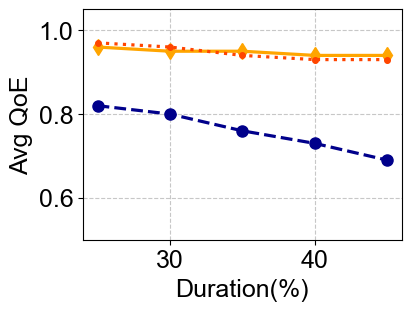

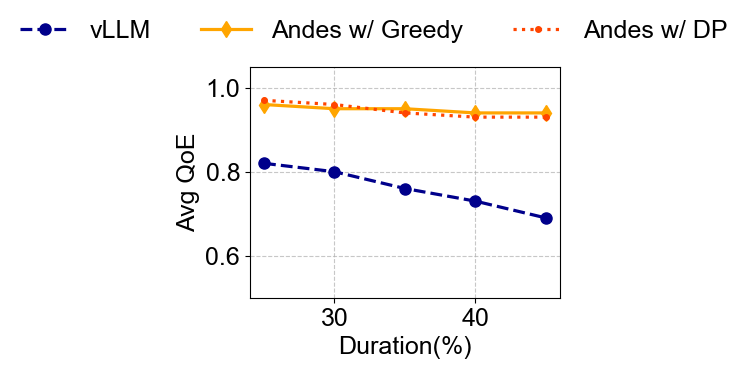

In [327]:

vllm_x = andes_x = [25,30,35,40,45]

vllm_y = [0.82, 0.8, 0.76, 0.73, 0.69]
andes_y = [0.96, 0.95, 0.95, 0.94, 0.94]

dp_y = [0.97, 0.96, 0.94, 0.93, 0.93]


dp_qoe_arrival ([vllm_x,andes_x,andes_x],[vllm_y,andes_y,dp_y],'llama3-multi-a100-duration-dp', ymin=0.5, xlabel='Duration(%)')
dp_qoe_arrival ([vllm_x,andes_x,andes_x],[vllm_y,andes_y,dp_y],'llama3-multi-a100-duration-dp-legend', ymin=0.5, xlabel='Duration(%)', legend=True)


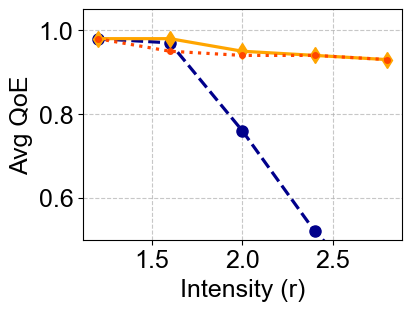

In [ ]:


vllm_x = andes_x = [1.2, 1.6, 2, 2.4, 2.8]
vllm_y = [0.98, 0.97, 0.76, 0.52, 0.34]
andes_y = [0.96, 0.95, 0.95, 0.94, 0.95]

vllm_y = [0.98, 0.97, 0.76, 0.52, 0.34]
andes_y =  [0.98, 0.98, 0.95, 0.94, 0.93]

dp_y=[0.98, 0.95, 0.94, 0.94, 0.93]

# [0.97, 0.96, 0.94, 0.93, 0.93, 0.98, 0.94, 0.94, 0.94, 0.93]



dp_qoe_arrival ([vllm_x,andes_x,andes_x],[vllm_y,andes_y,dp_y],'llama3-multi-a100-intensity-dp', ymin=0.5, xlabel='Intensity (r)')


## Max-Min scheduling objective

In [ ]:
max_min_qoe = [0.9217880450532264, 0.4272800024617309, 0.4843238173744199, 0.6021581861977916, 1, 0.9887403507674896, 0.471552333837439, 0.5128499449510413, 0.5578740715159975, 1, 0.9877318759315645, 0.826738499864215, 1, 1, 1, 1, 0.6886389134131363, 0.6077627549422466, 0.7205039732628206, 0.8057124825580425, 1, 0.7531376757406387, 0.0626909738952659, 0.7636479012379216, 0.7494664784399319, 0.8444681712504462, 1, 0.07662906614715115, 0.7577199357579903, 0.9874070082786759, 0.732231916250796, 1, 0.22587584045567166, 0.7492091974686276, 0.9931220483614779, 1, 0.693073709803623, 0.8196795165335747, 0.7354896157262858, 0.8838144001215922, 0.9283819074478614, 0.48100870510770743, 1, 1, 0.4045017182266233, 1, 1, 1, 0.9816011224493668, 0.962423351884854, 0.5890001675958918, 1, 0.41275611094139397, 0.8765588507500399, 0.44652357815027444, 1, 0.9767347728037323, 0.8146391053240114, 0.6606655784652581, 1, 1, 0.45761562721992766, 1, 0.6556219938938495, 0.6683879027294571, 1, 0.2624688294870382, 1, 0.7268651395697665, 0.39189539689841624, 0.7880061746796897, 1, 0.6165237217174462, 1, 0.8625118305943168, 1, 1, 1, 1, 1, 1, 1, 0.983372443333097, 0.31869963221485353, 0.9976818087911178, 0.9879750137777911, 1, 1, 1, 0.7447217168423794, 0.49157924415442644, 0.9686467501121538, 0.7506785114153084, 0.8809849200919682, 1, 1, 1, 1, 1, 0.6899743439392421, 0.8012919149738165, 1, 1, 1, 0.9958650609199955, 1, 0.6198331930814358, 1, 0.4146794901344705, 1, 1, 1, 0.6165207306362802, 0.7406366653732002, 1, 0.5611734123694769, 0.5126983737886216, 1, 0.9831254984109572, 0.959952574433912, 1, 1, 0.05540243385352295, 0.9992792807681378, 0.011375230391414082, 0.565428140849515, 1, 1, 1, 1, 1, 0.5664327662657875, 0.7079750357840842, 0.0619773699718521, 0.7739870271529201, 1, 1, 0.9864971284012419, 0.9949402250017053, 0.8217564547861946, 0.9911202162183363, 1, 1, 1, 0.7100255171073271, 0.9702759555462436, 1, 1, 1, 1, 1, 1, 0.9778825516750338, 1, 0.8605812777496131, 0.6740322627983979, 0.67341623178157, 0.9996318531730874, 1, 0.9957961166811053, 0.9352068567604497, 1, 1, 0.8765155122877907, 1, 1, 1, 1, 1, 1, 1, 0.9962097179546963, 1, 0.8254948147963818, 1, 0.24301617090730643, 1, 1, 1, 1, 1, 1, 0.3283993467431082, 1, 1, 0.36593060413843015, 1, 1, 0.3502173817768368, 1, 1, 1, 1, 1, 0.9804067519027557, 1, 1, 0.9354479273550447, 1, 0.9988388236497177, 1, 0.9986738734342091, 1, 0.9772964689532327, 1, 1, 0.48583618472624013, 0.5754183574699103, 1, 1, 1, 1, 1, 0.945802877688091, 1, 0.005841967026562922, 0.9960451742537678, 1, 0.40640934830352227, 1, 1, 1, 1, 1, 1, 0.9007943449770024, 1, 0.4966646197996303, 1, 1, 1, 0.8337622959527036, 0.6294007018259815, 1, 1, 1, 1, 1, 1, 0.4721713444323642, 1, 1, 0.8756901790228828, 1, 0.9904252932778728, 0.7587928171544362, 1, 1, 1, 0.21889377769201457, 0.2963439623317736, 1, 1, 1, 1, 1, 1, 1, 1, 0.004013263897178487, 1, 1, 1, 0.8938053907921906, 0.18139944386365725, 0.9697860243232173, 1, 0.02267323987705927, 0.9997660963592447, 1, 1, 1, 0.9743837319081057, 0.3016640923131346, 0.0734560883902522, 0.07874387013934003, 0.38806194373537684, 1, 1, 1, 1, 1, 0.5775109297317358, 1, 0.42789400469491823, 0.2913821585967751, 1, 1, 1, 1, 1, 0.9996055757049518, 0.9065542972559364, 0.09918217480557523, 1, 0.5087805640712726, 0.24036954659145238, 1, 0.9976393499852323, 0.007681784578589368, 1, 1, 1, 1, 1, 1, 1, 1, 0.9803975058632709, 1, 0.1974355275139621, 0.9923762113717328, 1, 1, 0.9638095599806777, 0.171821836923713, 0.7115505220167466, 0.895104652554969, 0.17872065125588565, 0.1116412436251637, 1, 1, 0.19541637283106916, 1, 0.9221630551100052, 0.33216225563211677, 0.021227873427663635, 1, 1, 0.9341795237069621, 0.5730294761529047, 1, 0.05887095983373036, 1, 0.995954832363932, 1, 1, 1, 1, 0.27454502216908583, 0.9147970801431561, 1, 0.9683540605382913, 1, 0.270855704204077, 0.32182682058625567, 0.15018931155194248, 1, 1, 1, 0.9983473842099633, 0.15808551841359297, 0.9942031841775045, 1, 1, 1, 0.3889249952968902, 1, 0.9525589137906754, 1, 1, 1, 0.4815452639990955, 0.32531652525064136, 1, 1, 0.9995519985456696, 1, 1, 1, 1, 0.9514887191181507, 0.36194106789419744, 0.26074458093729846, 1, 1, 1, 0.039946624740347825, 1, 0.35249894093581424, 0.4272450788801213, 1, 0.3186885774028282, 0.014150075792360495, 0.47473788825929264, 1, 0.9919572867746069, 1, 0.35573775064390945, 1, 1, 1, 0.4924652250212991, 1, 0.43699692669715207, 0.4027520953734224, 0.5020264249619895, 0.45391930492105526, 0.13641566029369023, 0.46849949961791804, 1, 0.18705090488514275, 1, 1, 0.4329017401346543, 1, 1, 0.5088181208456986, 0.9897259731771606, 0.3266033849042208, 0.27874007215430185, 1, 0.9957760756579463, 0.29312326542747424, 0.16943814287565206, 1, 0.3436289329252308, 1, 0.3581625349878609, 1, 1, 0.13623771642145166, 1, 0.9787820680464853, 1, 0.9919869385741064, 1, 1, 1, 0.463758917565651, 1, 0.35289488315764617, 1, 1, 0.5540616369898803, 0.4595767563399622, 0.9914738616446563, 0.549913848359298, 0.32588626749426597, 1, 0.5611027811147917, 1, 0.43433319411044224, 1, 1, 1, 0.9918593429558076, 0.33042997960135545, 0.5045435545221257, 0.4207359628283639, 0.371971781338447, 0.42257154146831544, 1, 1, 1, 0.42482739761000643, 1, 1, 0.9924434445585893, 0.5017906392452107, 1, 1, 1, 0.3847821702049069, 1, 0.3166712235328111, 0.4475879416573161, 1, 0.9934074868831366, 0.5155311476986504, 0.38302593747488256, 0.017410622154438338, 0.4089827692600516, 1, 1, 1, 1, 1, 0.19355942438140794, 1, 0.9926529075607687, 0.612633976433214, 1, 1, 1, 0.5739021055446051, 1, 0.17987540091822074, 0.07330528409604287, 0.08198448754420162, 1, 0.28433766534316085, 1, 1, 1, 1, 1, 1, 1, 1, 0.9075407288812185, 0.5028124251813451, 1, 1, 1, 0.9539749742853002, 0.5993569541583763, 1, 0.536319079447697, 1, 0.5202896327258977, 0.5108213313992188, 1, 1, 1, 1, 0.6423192625563454, 0.9621260448168512, 1, 0.6204291051625301, 0.5502540132605145, 0.5088306354896892, 1, 1, 1, 1, 0.9905714416878799, 1, 1, 1, 1, 1, 1, 1, 0.9141538306986104, 1, 0.9779938315808833, 1, 1, 0.7357634802588322, 0.9975111065647537, 0.7079801987960657, 1, 0.9795941496602188, 0.9700753406940197, 0.9798327483411897, 1, 0.4315584036700256, 1, 0.9493199433589815, 1, 0.9994670141994616, 1, 0.9780678889817236, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.8315456385704518, 0.9320899572948513, 1, 0.6926718862892021, 0.9930276698740379, 1, 1, 0.9787663560580154, 1, 0.9449027338237935, 1, 1, 1, 0.9988237846318881, 1, 1, 1, 1, 1, 1, 0.9996734734795623, 1, 1, 1, 0.9659753290580266, 1, 1, 1, 0.9651915645993955, 1, 1, 1, 0.9744883776939105, 0.9918047686355731, 1, 1, 1, 1, 1, 1, 1, 0.947903473232505, 1, 1, 1, 1, 1, 1, 1, 0.9990670617025698, 1, 0.9857354345269419, 1, 0.9977496065423146, 1, 1, 0.9497394926551633, 1, 1, 0.041894350065350805, 1, 0.10526357561301647, 1, 0.9757415800316523, 1, 1, 1, 0.9742587087164086, 1, 1, 1, 1, 1, 1, 0.29175086717158516, 1, 1, 1, 1, 1, 0.9948854960694865, 1, 1, 1, 1, 0.9977373328804839, 0.054687218989285746, 0.7820870919402493, 0.16374111656160006, 0.5204580015906608, 0.9928435377970278, 0.31346081154509986, 1, 0.9916100284870623, 1, 0.43560726927890214, 1, 1, 0.38851335765837236, 1, 0.8108308821510405, 1, 0.49338187535290956, 0.9179837739190915, 1, 1, 0.45715462689492514, 0.5178065070869746, 0.9959603922129507, 1, 1, 1, 1, 1, 1, 1, 0.5260795067836637, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9374269122031468, 1, 0.9400091862306678, 1, 1, 1, 1, 1, 1, 1, 1, 0.7761588408548112, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9791324114709236, 1, 1, 1, 0.9901533079708024, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9969354960861674, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9326381450817214, 1, 0.9695098754039516, 0.9467481663645495, 1, 1, 0.7130897171453043, 0.9426296416302292, 1, 1, 1, 0.9591559820753255, 1, 1, 1, 1, 0.9954250813939398, 1, 0.9280566277684894, 1, 1, 1, 1, 1, 0.9512795344469044, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.995567872817278, 1, 1, 0.9973873594797317, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9684416688212074, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9987000180227297, 0.9256199116124076, 1, 0.9967022424988763, 0.9010352422587541, 0.9452977211170304, 0.958127454362657, 0.77539129968409, 1, 0.9176795775715728, 0.9174328954882331, 1]
andes_avg_qoe = [0.9219796487153893, 0.36859026928768823, 0.5588362096514695, 0.35897660115242613, 1, 0.6318720316869253, 0.9870976714279036, 0.4862909317424098, 1, 0.6225400869380279, 0.5247662833779815, 0.5704026275641627, 0.9928746070582594, 0.8413246227994498, 1, 1, 1, 0.8119463101416124, 0.6998983814737896, 1, 0.6152490200558154, 0.7568495937033016, 0.7316006184251214, 0.849372781712442, 0.7624438899327979, 1, 0.9340820876344509, 0.7743982425622835, 0.7468650082623807, 0.8403153941388314, 0.8397685656043761, 0.7668990061523352, 0.910877391582918, 1, 0.738189413774632, 0.9206744004290773, 0.9577742324800542, 0.7542686486718839, 1, 0.990565334972822, 0.6072499037886719, 0.9923173627991604, 1, 1, 1, 1, 0.6955456913216171, 0.8203970442025159, 0.7395498697401137, 0.9323087169531253, 1, 1, 0.999340001434144, 0.9058574478021877, 1, 1, 1, 1, 1, 1, 0.9617403074892408, 0.8624736705168288, 0.8933215111606692, 0.999729501811191, 0.2448245316862223, 0.9454773223894112, 0.881127510539282, 1, 1, 0.9850678915993974, 0.9454563679000425, 0.8184312123157186, 1, 1, 1, 0.9967399183513642, 0.9766253121315815, 1, 1, 1, 0.79115877719597, 0.9948975112413528, 1, 1, 1, 0.9898685357174628, 0.8681481142528665, 1, 1, 0.9833997448096622, 1, 1, 1, 1, 1, 0.9559481107406353, 0.9898631213916299, 1, 1, 0.9906029324475334, 1, 0.7478048358444284, 1, 0.8841808432690421, 1, 1, 1, 1, 1, 1, 1, 0.9455723828424333, 1, 0.9194152659464107, 1, 1, 1, 1, 0.7613952980697636, 1, 0.6414833311231525, 0.9943516827354466, 1, 0.993255239358804, 1, 1, 1, 0.9347976496414253, 1, 1, 1, 1, 1, 1, 0.9823418482506691, 0.9973788416444933, 0.8247251896153605, 1, 1, 1, 0.6337686310843937, 0.8840370447049483, 1, 0.9412773502093057, 1, 1, 0.934752653791842, 0.8042414177415786, 1, 1, 1, 0.9924135226974907, 0.9099283241521926, 0.9939924116037392, 1, 1, 0.8151096546633919, 1, 0.7230413339781083, 0.22613874705109727, 1, 1, 1, 0.8555571464669388, 1, 1, 0.9127340488263587, 0.8972637812303517, 0.8623412293309112, 1, 0.9961023665053814, 0.9563340129503604, 1, 0.7669808739589947, 1, 0.9976347369287991, 1, 0.9379609675798207, 0.9923469187400508, 1, 1, 1, 1, 0.9663704332510779, 1, 1, 1, 1, 1, 1, 0.978277073618309, 1, 0.9798639296354967, 0.8819064313882286, 0.9910474315542622, 0.939096063934061, 0.9951013251321896, 1, 1, 1, 1, 0.9613275415275316, 0.9331661069752158, 0.6292175600650698, 1, 0.9972300154131553, 1, 1, 0.9879801150586813, 0.9749554011774325, 0.9260825534390469, 0.3334736315301755, 0.67740284903709, 0.9763681785330799, 1, 1, 0.3609710922523792, 1, 0.8893327175789022, 0.9763411739333606, 1, 0.9876137281115559, 0.9509764739357908, 1, 0.9243121504019816, 1, 0.9935842540661748, 0.9137817826299096, 1, 0.9799939616419749, 0.8408946496157007, 0.9960630834308394, 0.9950351951506369, 1, 1, 0.9892873806483045, 0.9863891953503253, 1, 1, 1, 1, 0.959031960664135, 0.9616475470626777, 1, 1, 0.999374488846179, 1, 1, 1, 0.9960231255951765, 1, 1, 0.9545793875869546, 1, 1, 1, 1, 0.9939969703331434, 1, 1, 1, 1, 1, 0.9862677255042679, 1, 0.9857931625215449, 1, 0.992019237120299, 1, 1, 1, 0.7585386809877952, 1, 1, 0.9839692152091963, 0.7380186227471265, 1, 0.9826291386614593, 1, 1, 1, 0.6137836323539589, 1, 1, 0.9877692331222713, 1, 0.991283231569763, 0.9740071182320453, 1, 0.9788887804926775, 1, 1, 1, 1, 1, 1, 0.9708523112494702, 0.9917157334380035, 1, 1, 0.9945393854702984, 1, 1, 1, 1, 1, 1, 1, 0.98825969443177, 1, 0.8668548972641696, 1, 1, 1, 1, 0.9589029406339057, 1, 1, 1, 1, 1, 1, 0.9999507173406117, 0.9803678664729016, 0.9807706323948671, 1, 0.9937781833914295, 0.9874613780791646, 1, 0.9877845754516047, 0.5049497820056312, 0.9647376377465674, 1, 1, 1, 1, 0.9797879781103371, 1, 0.7827270783804217, 1, 1, 1, 1, 0.9855847101699989, 1, 1, 0.9840184229498671, 1, 0.9775330904115198, 1, 1, 1, 1, 0.5760309743210971, 1, 1, 1, 0.9048241226655171, 1, 1, 1, 1, 0.9217546973652759, 0.817649516567367, 1, 1, 1, 0.9972370766867122, 0.987234647450555, 0.9807545272167459, 1, 1, 0.9585251494647167, 1, 0.9248999497786241, 0.9769864059795252, 1, 0.9837680302334717, 0.9835111902032091, 1, 1, 1, 0.8731767949878232, 0.9991658901089095, 0.8458295341423026, 1, 0.9751707072229177, 0.9154406091233956, 0.9606541526551499, 0.9946788082711204, 1, 1, 1, 1, 1, 1, 0.999073388545096, 1, 1, 1, 1, 0.9741608795960689, 0.9724148938209792, 0.9314735551050688, 1, 1, 0.9365217203323547, 1, 1, 1, 1, 0.46442363529989694, 0.9618477844742236, 1, 1, 0.9413265036446619, 0.9603435176633032, 0.9755401997976723, 1, 0.39875670040498956, 1, 1, 1, 0.9221381363976456, 1, 1, 0.9920855110916578, 1, 0.972239748452031, 1, 0.6751380927557383, 0.9607034769462628, 0.8939758556116408, 1, 0.2520135739248618, 1, 0.8499638162381209, 1, 0.9499057175884278, 1, 0.9815177818002367, 0.9082996758739115, 1, 1, 0.9484109893230552, 0.6479913733305503, 0.9819081807091351, 0.958009920388586, 1, 0.9969213422089791, 0.9646464597500972, 1, 0.9832332649631529, 1, 0.9644325440373855, 0.9704794227687176, 1, 1, 0.86593231635075, 1, 0.9899794737835318, 0.9790961366259902, 0.7660214304653259, 1, 0.9940099951540317, 0.9900887644112006, 0.9912619901753251, 1, 1, 1, 1, 0.5140815834261516, 1, 0.4367973591830113, 0.9481932049656128, 0.8998879609759269, 0.9908326909654445, 0.9448343219615223, 0.9976613998610305, 0.7569519769239542, 0.9958694486997263, 0.9606061173501085, 1, 0.9880883780387115, 0.9207993888406898, 1, 1, 0.9214204331092484, 1, 0.8803760368909903, 0.9423650915906562, 0.6242901971018242, 0.9550272626143826, 0.8231064877052402, 0.9105875050286918, 1, 1, 0.951189551229673, 0.9739154037930166, 0.9883712445708729, 0.13728894660248314, 0.873088581348894, 1, 1, 0.9636946299838643, 0.916444300480192, 1, 0.7446415014626842, 0.9274842447960397, 1, 0.9354040851170389, 1, 0.7041517044068344, 0.9103179533023499, 0.6426661334942457, 0.9851077245333626, 0.9900451853710799, 1, 0.9959647176482085, 0.9189886097936727, 1, 0.8712237969007375, 0.9482514619851098, 0.7887757977869048, 1, 0.8297333970547318, 0.9882490129879934, 0.7824958919659102, 0.7927807287638485, 1, 1, 1, 1, 1, 1, 0.8911698251089706, 1, 0.6514076592570821, 1, 1, 0.8997902276091927, 1, 1, 0.9278442452431379, 1, 0.9421568776789914, 1, 0.9404994464643494, 0.7829620806980683, 0.8289845703579812, 1, 0.9048129201317845, 0.9109993539915064, 0.9848150937633363, 1, 1, 0.9906106381079892, 1, 1, 1, 0.9433255969943696, 0.9771616652745799, 1, 1, 1, 0.9090147345235005, 0.059182563461736004, 1, 0.7898107104889704, 0.293842990564785, 0.8875874295579976, 0.8355050942057213, 0.9885303913621711, 0.8141286772876818, 0.8754482533061166, 0.48826633483063187, 0.14271957417363657, 1, 0.749633107189432, 0.7373909549620477, 0.8787844143806276, 0.9144744656778101, 0.8150921371530679, 1, 1, 0.9762671558280188, 0.9617398712514359, 1, 0.970470232859638, 1, 0.9578918856393942, 1, 0.8953577046223775, 0.7960671261408854, 0.9372164737902136, 0.8796061842140076, 0.7690686043606476, 1, 0.8360004677973459, 0.8523439413783483, 1, 0.9539270883214315, 0.9641356813343931, 1, 0.9177420620178617, 0.9119504168423743, 1, 0.9593774402872709, 1, 1, 1, 0.9982195046380996, 0.9089039057513062, 0.8990204165181358, 1, 0.9962312039673268, 0.6787992944812622, 1, 1, 0.789892400227336, 1, 1, 0.9955704925445548, 1, 0.9064971942514979, 1, 1, 1, 0.8604990953180821, 0.8026539145732682, 0.8784424709248433, 1, 0.8646803885933728, 0.8424246773118115, 1, 1, 0.902238492233727, 0.991448037215236, 0.9303785414029286, 1, 0.8418662287248846, 1, 0.07988010649485422, 0.9486781996323866, 0.7514056627352763, 0.9891184345349525, 1, 0.8865332534726378, 1, 0.9425966323697292, 0.9477155944610014, 0.8544823658681475, 0.9409675164314955, 0.7637724523618876, 0.9107989347275811, 0.6330561180861632, 0.9341430553677665, 0.9994921513074361, 0.9776847604620723, 0.6922804791970516, 0.9383971160419381, 0.8571354283832653, 1, 0.9325246479619176, 1, 0.3288648287554271, 0.9545586846839385, 0.36430432000550705, 0.951937749776283, 1, 1, 0.9575869215655919, 1, 0.9373251193363294, 1, 1, 0.9654963239213744, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.42075668979488967, 0.9443414273438585, 0.8043305955673026, 0.7888663919483897, 1, 1, 1, 0.9567616457065494, 1, 1, 0.9240026193963701, 1, 1, 0.9362365126681764, 1, 1, 1, 0.9859797914930462, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9790660158430983, 1, 1, 1, 0.9903212222889053, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9970177006831468, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9794472596081298, 1, 0.965472471032969, 0.9433893988651868, 1, 1, 0.9694899585882193, 0.8030036272771188, 1, 1, 1, 0.9574252959667968, 1, 1, 1, 1, 0.996041036757116, 1, 0.9419220984933743, 1, 1, 1, 0.9573504375537868, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9953583719781566, 1, 1, 0.9972281778760068, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9689764264434844, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9989813958462133, 0.934430709897747, 1, 0.9968746507892231, 0.9077620278472893, 0.9516420979245367, 0.9642396358916862, 0.7813991202663942, 1, 0.9222093042945143, 0.9211124643092823, 1]
vllm_qoe = [0.9512114337555763, 0.5033316732747473, 0.5455595071528363, 1, 0.6204969733617413, 0.9833640254819056, 0.5024340146302768, 0.5328898039271209, 0.5773511249912124, 0.9899050918729527, 0.8577705896333383, 0.14101899249037475, 0.7265381448457999, 0.6242153903100662, 0.7457067295633965, 0.37192995344456237, 0.10064193696941881, 0.7691620392046503, 0.794045247261146, 0.5949473107855872, 0.7555936578724372, 0.21781914570660088, 0.8449200788622845, 0.1484760828456544, 0.7836849252783524, 0.7401877707080884, 0.37068284345133373, 0.29569223012565393, 0.8320623282339566, 0.5280991555126167, 0.9986874037116547, 0.7567610680664565, 0.5968988117605563, 0.5797507452447062, 0.650190508125819, 0.8424707028847835, 0.9343509125958781, 0.6991624741789637, 0.748191371147282, 0.6414946060841269, 0.6295477490076826, 0.5512438787030385, 0.6334909726945349, 0.4497044537691751, 0.5982620496675972, 0.43256349398144156, 0.8804499390484284, 0.7769559016754041, 0.7717764451087779, 0.5163419846830446, 0.8205315394586101, 0.7394346440669188, 0.8203494387646779, 0.5425746819650616, 0.7176094980512082, 0.6304528083963769, 0.6831436024155556, 0.6894103058751637, 1, 0.7565610575939172, 0.6762780026422716, 0.8079907088900838, 0.8003504427833656, 0.742629499117263, 0.6721078835172782, 0.8272830550737075, 0.8235410799876666, 0.8759290300051237, 0.9869829130534287, 1, 1, 0.036416920595423674, 0.1522618136824071, 0.7972195831070514, 0.10900082671944178, 0.7703904466126668, 0.821524047236664, 0.6145417538382052, 0.19503207351835827, 0.8862545806928005, 0.7578219866144348, 0.8171920059373561, 0.7278220413321415, 0.4727761933396015, 0.35655298026610505, 0.5988870724517972, 0.820970721331026, 0.519557000755378, 0.8063829969363873, 0.4849890073967702, 0.8192233103227793, 0.9381468237954036, 0.8253043512744751, 0.8460095413320473, 0.7404306098037123, 0.7139253025181811, 0.848562141469264, 0.7721595151173966, 0.6755738690493223, 0.8903861132891172, 0.6911841134929795, 0.3118583060384531, 0.7862344995472773, 0.5215868582401756, 1, 0.8007192032360415, 0.2674573146834106, 0.7196045583640456, 0.7152733966465559, 0.36981983789386086, 0.3223891833296827, 0.8831658464519707, 0.5315173019878299, 0.7960343258557898, 0.6585866870393278, 0.6198849261749299, 0.9410823543694975, 0.4981539385364302, 0.42239504797539074, 0.782330999015498, 0.611776470391843, 0.5303685959371716, 0.4618986758717496, 0.7662320253482663, 0.9256178866112337, 0.5039620080015337, 0.7743489289880909, 0.630371454262024, 0.5921091581882976, 0.6553034551778564, 0.8672542232359162, 0.5300690578749283, 0.7690029450073794, 0.8493271823214602, 0.7764993610673223, 0.5015007558267786, 0.9150510390060986, 0.6411139621914439, 0.7105790797933171, 0.029664011151568026, 0.8110422072130485, 0.023303947104143408, 0.7052559641526435, 0.838464534213878, 0.8038896497418553, 0.7279614561176122, 0.8633079484885834, 0.6889025466317023, 0.8183408879876377, 0.9089038199773981, 0.7217417602779037, 0.8297596994980306, 0.799267023248419, 0.677962499850906, 0.6492144079522273, 0.01420380320343706, 0.2523734812024391, 0.7695531448800794, 0.8226260811110301, 0.8374925128405275, 0.30372241089355956, 0.24746389357849807, 0.7483581271986228, 0.25304270415005403, 0.7082904514094397, 0.7918559451135191, 0.8012323643248139, 0.7811090364757038, 0.8666542872198753, 0.0416241507899161, 0.8414998099896763, 0.18200239601700352, 0.8685763299380143, 0.08888186117431274, 0.13271312669898816, 0.703691448098738, 0.812244962191469, 0.4528612068629897, 0.4197436545227111, 0.8847147660868657, 0.8526930414465541, 0.8660251970071191, 0.29786833145609215, 0.47667769433507856, 0.26315143222868687, 0.8940227270434314, 0.874759062701598, 0.6673648709853175, 0.8324327700969015, 0.297945789696744, 0.4960174956919148, 0.48540145931811474, 0.8370988329517304, 0.762101241507442, 0.9203521832580162, 0.6521372066642923, 0.4920523006913018, 0.4931414213897263, 0.5366001229017554, 0.45104367191354755, 0.25994647842131224, 0.5645831876255715, 0.13580511897895686, 0.46544010980057327, 0.389805944988301, 0.8930231673764166, 0.9463304913380176, 0.8835215383590233, 0.6788018727911774, 0.4430866499916175, 0.8632456235935486, 0.5115928968959998, 0.02137965884882065, 0.5836052827873144, 0.8363999701428393, 0.5020382585421628, 0.8996926841056444, 0.8536993485620862, 0.7331430950327115, 0.5979331619085257, 0.7342331016898739, 0.5820523326146904, 0.19029623178707833, 0.3494912593212234, 0.5846279804866105, 0.8543357744467125, 0.7866175842387306, 0.41654356155552075, 0.7473688011584111, 0.8470851623989832, 0.4833941927137756, 0.8393448858811235, 0.021376759440642545, 0.5265844179037859, 0.6546214433087134, 0.6594445691785875, 0.35488844890259597, 0.7685582940471974, 0.7505076858017304, 0.28188926920131663, 0.5966173249647317, 0.2682816183647838, 0.6138356753759764, 0.5684145757518501, 0.4820650599215709, 0.5948834778582509, 0.6382678260737413, 0.39770617352702564, 0.3983061777743676, 0.6154808774381284, 0.27062267717188937, 0.7192668892471272, 0.800537967292223, 0.8238538056858478, 0.7333946016867371, 0.07362582476631763, 0.7853432067317444, 0.5724110801911676, 0.9191605828298266, 0.6502583582777173, 0.784511516242372, 0.7905003593239047, 0.044549909833871304, 0.15166795040945713, 0.3653783606671892, 0.7292445657242032, 0.6924742997554412, 0.5219316022341494, 0.806260900738418, 0.3863548880808194, 0.4057970700001827, 0.8014681264544079, 0.6067979452714889, 0.5670098275914934, 0.5761817459649667, 0.12394956268536683, 0.7488591272621719, 0.7447822949047729, 0.588310523019965, 0.5874132733584572, 0.5733526006928213, 0.6124475110861898, 0.69941770190744, 0.6149392496245508, 0.6830847915991494, 0.7450823784105546, 0.13353724541534717, 0.8414642683555767, 0.5551396271718252, 0.6515526274440296, 0.8268646896410125, 0.7448722787433897, 0.6556382262692427, 0.6709681017333637, 0.19179892264237242, 0.24470722398083422, 0.7538475377225091, 0.26074926913958885, 0.7359999401811577, 0.7054854944445546, 0.6822240651796809, 0.2345539625320282, 0.4608183211476419, 0.8056285699500703, 0.6604744306143764, 0.7990132895397407, 0.7301719153000963, 0.5852515858827994, 0.7689035214222901, 0.6137687779482506, 0.1119643382674953, 0.7843236501149777, 0.653936792320259, 0.5831683280431201, 0.7373776863125918, 0.7034317785594124, 0.668363560597919, 0.4720553142578575, 0.6457990337644723, 0.5769956437835382, 0.6441115314271482, 0.7801945272871229, 0.40834066800978785, 0.3270996028623495, 0.4097989286065906, 0.4988375816328735, 0.7702543062356556, 0.6693070317214493, 0.306179734090131, 0.734509021487306, 0.38969580434811224, 0.6861312900600753, 0.39353654820629913, 0.653364763714055, 0.030310703631984404, 0.8000184042534972, 0.09495807547363544, 0.09327607783561387, 0.6755439766125217, 0.7824015215711712, 0.5167613350305481, 0.35265541849290927, 0.5219112770585851, 0.5789284636373617, 0.7073722453616214, 0.7132555734260236, 0.485708341872625, 0.6185633516697082, 0.5477397680116136, 0.45706747115232016, 0.7421367299063102, 0.6772766157097266, 0.5139552855297533, 0.9582477026867294, 0.41813098491384093, 0.6421565672784612, 0.5499642384673136, 0.4062009151120798, 0.5034817528007971, 0.5251540481370011, 0.6982843127536373, 0.5811356600475066, 0.5914550588685051, 0.5491780730788993, 0.47868133790369183, 0.669752415205354, 0.7822092558638972, 0.6076512402204707, 0.7692231021333235, 0.5789442317781723, 0.7831107545602354, 0.7831282282058722, 0.5032030803526328, 0.7259748534908834, 0.41025095513206655, 0.4782646609331964, 0.6072798433061435, 0.7705982504164359, 0.7557871017254384, 0.6213200122351925, 0.8522094603876679, 0.7285223398677392, 0.6352295733576245, 0.6838877056143893, 0.5887020992346894, 0.6279504415653718, 0.7891669746260592, 0.6253060190086932, 0.6874915027754367, 0.5695189188646044, 0.5369330198119586, 0.7820976717644557, 0.7885952030484518, 0.699981828435974, 0.6334367231011111, 0.7278049299058065, 0.5694376053466728, 0.7841835635852763, 0.6493738104004303, 0.8486851218563476, 0.703195685501369, 0.774428901524812, 0.7990773619272062, 0.7139999782429381, 0.7718540667721041, 0.808094107022397, 0.7009131214394473, 0.7885429156687985, 0.6985785011587342, 0.2454160015459418, 0.617621670411169, 0.7980607197198801, 0.6772107705618169, 0.757799288298239, 0.5102229150402748, 0.6110229432531522, 0.8576186172329643, 0.7550702341645609, 0.5795511908025099, 0.8268581037301285, 0.8373574154447523, 0.65789605909808, 0.6529679142161766, 0.8771884918410314, 0.7833674098148578, 0.7369524598052151, 0.7992347930967201, 0.5782665597055737, 0.8458005223229471, 0.7750075098497262, 0.6988503856211228, 0.7694836045354567, 0.8283034664727589, 0.8089244878435651, 0.8200843401698008, 0.7640316226251562, 0.7856705227650416, 0.9110987877933292, 0.35248096054991385, 0.8495875384245601, 0.035060206562070984, 0.8244411436856264, 0.811713272543134, 0.831547001706519, 0.35914823344870606, 0.1709954025744862, 0.8425913494053416, 0.888087470768794, 0.2933549987718268, 0.35079875752300205, 0.800897918779927, 0.8178464755362754, 0.7303468498381078, 0.8479591157068007, 0.5272369274770183, 0.7919340628276705, 1, 0.397391023596945, 0.28545944304004334, 0.9225897451652809, 0.4716996421430151, 0.8887859339596159, 0.6165220035275774, 0.8014349939608673, 0.8633191945146379, 0.8079025252531449, 0.8052645871089316, 0.5707426801992932, 0.9539170337129631, 0.4937737889170417, 0.4283167790634138, 0.8077043108616988, 0.7278808598525692, 0.7477224070703163, 0.961748426218532, 0.5926112671981795, 0.758573650168091, 0.5478514050478248, 1, 0.7577739411334479, 0.856784142444483, 0.8403280875902954, 0.8218736600175427, 0.7054933644778013, 1, 0.730831226350942, 0.7106133215258463, 0.7199448700903586, 0.8255282749030768, 0.9040332221271307, 1, 0.7925405869679332, 1, 1, 1, 0.9451328665525214, 0.7744792578989814, 0.8437173609157932, 0.8185478608931919, 0.8204002886105853, 0.5855952998078535, 0.8370408365480284, 0.878387744296623, 0.6735168862107876, 0.9027764996649128, 0.9357887579538045, 0.5774724078262377, 0.8371169090545549, 0.7590912279125968, 1, 0.8388097048963387, 0.8848198244939276, 0.7971748052283484, 1, 1, 1, 0.7814055412148267, 1, 0.831071362852789, 1, 1, 0.9755718525217708, 0.09987924770744316, 1, 0.2952089235598103, 0.887175360881882, 1, 0.9118398704800154, 1, 0.8507975828022614, 1, 0.7545360995544991, 0.9177981107869344, 0.7022532792387846, 0.056848527355364165, 0.7420734689547042, 0.7949831859355596, 0.8800194216348816, 0.6241135023748627, 0.7987761948707011, 1, 0.8534464601656949, 0.9745776536680909, 0.9266245541254062, 1, 0.047861792410822224, 1, 0.15653842371528337, 0.3140061852961632, 0.918198856594784, 0.911197193513836, 0.1159493039057391, 0.10712557208624607, 0.8191799827681703, 0.3094198250690018, 0.3766946643615334, 1, 0.9264645473068635, 0.8758457337138906, 1, 0.8501270535367469, 0.8031761324406989, 0.4479282894068154, 0.7992579138771219, 0.22137528790363048, 0.7997326676430432, 1, 0.45736334534325684, 0.8860693264321418, 0.8965855665022688, 0.3686540473514389, 0.343140853805317, 0.9591161100230777, 0.6572649419946457, 0.4992156002364345, 0.8739340873445268, 0.709633292623614, 0.997832561442442, 0.5514269210713425, 0.513461272464806, 0.7403253840170667, 0.645585771527942, 1, 0.01971651403490493, 1, 0.8156449001773636, 0.8283350750990174, 0.1727345023792456, 0.8697448660388252, 0.8075587684568195, 1, 0.9211166120197501, 0.9073086503861783, 0.7000090722000741, 0.8092283870717591, 0.8738198701711385, 0.7905473965956593, 0.7267172016107635, 0.33783426959595053, 0.7595388611809721, 0.938444400182837, 0.8243861032186087, 0.875790892017621, 0.8422757913186097, 0.5024932057324223, 0.7336640378479126, 1, 0.8497115351609086, 0.8778166802548671, 0.7555562629702363, 0.09145205917122323, 0.8658486880598665, 0.5992011105990044, 0.7863501457802717, 0.7778488531718734, 0.1256789441040741, 0.31638877934539045, 0.4877607590715861, 0.811611528895113, 0.8163929329411203, 0.5756811446152376, 0.8956443304499765, 0.6192923723885737, 0.8716474785435814, 0.8525291358936288, 0.6447795685380013, 0.5822191237038365, 0.4783092214122997, 0.8832502977611095, 0.7547734386119215, 0.8154156479977948, 0.46856157460221604, 0.5504659294314024, 0.643601871459401, 0.8640753493066999, 0.8279950432298295, 0.9100192951171436, 0.6305946567686638, 0.48940174693734706, 0.49368572601430893, 0.5961765691578611, 0.8514405189299238, 0.40045847318081385, 0.717658362465799, 0.6962968652553997, 0.5219909321158032, 0.6585050876176026, 0.45143638379171347, 0.6026348314039227, 0.7483586752755763, 0.4842436212829967, 0.9076880305793358, 0.42286620950376097, 0.6358585731352877, 0.5274425953167465, 0.5306518421817378, 0.5369840716169483, 0.6159506147525682, 1, 0.7705183560386482, 0.6795830232091002, 0.655871761945946, 0.7841402916282065, 1, 0.8189798478330717, 0.8335498681144392, 0.8226789346412616, 0.8887275706475058, 0.7557553161062882, 1, 0.8279378296826838, 1, 0.8622423030766044, 1, 0.9699843220712536, 0.8705182037183867, 1, 1, 1, 0.862128762750212, 0.9706161723931647, 0.7433025994058091, 1, 1, 1, 1, 1, 1, 0.839701887240817, 0.7840956864312758, 1, 1, 1, 0.9359065460927403, 1, 1, 1, 1, 0.8077159501715954, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9998732209885616, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9785590118496481, 1, 1, 1, 0.9871771011901945, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9977769462253777, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9983862298459928, 1, 0.9730385275975554, 0.9496862520298539, 1, 1, 0.9802275077514689, 0.7153455454088432, 1, 1, 1, 0.9606670728949358, 1, 1, 1, 1, 0.9938505698409094, 0.9467675043187038, 1, 1, 1, 0.9589523065566149, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.994399071036154, 1, 1, 0.9965539324672629, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9676713168257149, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9983515427617827, 0.9268275771045591, 1, 0.9965106774933915, 0.901958789992966, 0.9461691091626812, 0.9589812806933724, 0.7748849698087252, 1, 0.9183020395320887, 0.9179469323091668, 1]


In [ ]:
plot_cdf([vllm_qoe, andes_avg_qoe,  max_min_qoe], 'CDF', 'QoE', 'max-min-qoe-cdf', 1,0, 
         [SYS_NAME, BASE, 'Max-Min QoE'],   fig_size=(4,4))


NameError: name 'plot_cdf' is not defined

# Toy Figures

## QoE Intuition

In [ ]:
# Placeholder time range for the x-axis (t)
time = np.linspace(0, 10, 100)

# Placeholder functions for each requirement and TTFT_Expected
# These are arbitrary functions just to mimic the trend of the lines in the given image.
def req1(t): return t * 3 - 3
def req2(t): return t * 2 - 3.5
def req3(t): return (t-2)*1.25
def req4(t): return (t - 2)*0.5*(t<=6) + (t * 2 - 10)*(t>6)
def TDT_Expected(t): return t * 2 - 4
plt.rcParams.update({'font.size': 20})

# Setting up the plot with the specified functions
fig, ax = plt.subplots(figsize=(6.5, 3))


# Adding arrows to the axes
ax.plot(time, req1(time), linestyle='-', color='orange', label='Request 1')
ax.plot(time, req2(time), linestyle='--', color='orange', label='Request 2')
ax.plot(time, req3(time), 'b-', label='Request 3')
ax.plot(time, req4(time), 'b--', label='Request 4')
ax.plot(time, TDT_Expected(time), 'k-', label='Expected TDT \n $TDS_{exp} (t-TTFT_{exp})$')

legend = ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5), ncol=1)
legend.set_frame_on(False)

# Setting x and y axis labels
ax.set_xlabel('Time')
ax.set_ylabel('#Tokens')

# Setting x and y axis limits
ax.set_xlim(0, max(time))
ax.set_ylim(0, max(req4(time)))

# Removing the top and right spines to create axes with arrows but not boxes
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# Moving bottom spine to zero position
ax.spines['bottom'].set_position(('data',0))
# Adding arrow to the bottom spine
ax.spines['bottom'].set_capstyle('projecting')
ax.plot((1), (0), ls="", marker=">", ms=10, color="k",
        transform=ax.get_yaxis_transform(), clip_on=False)

# Moving left spine to zero position
ax.spines['left'].set_position(('data',0))
# Adding arrow to the left spine
ax.spines['left'].set_capstyle('projecting')
ax.plot((0), (1), ls="", marker="^", ms=10, color="k",
        transform=ax.get_xaxis_transform(), clip_on=False)

# Hiding the axes ticks
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

# Hiding the axes tick labels
ax.set_xticklabels([])
ax.set_yticklabels([]) 
# Show the plot
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.4)
plt.savefig(f"qoe-intuition-toy.pdf",bbox_inches='tight')


## 4 QoE examples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
plt.rcParams.update({'font.size': 20})
color_list = ['k', 'peachpuff','peachpuff','orange']

name_dict = {'E': 'Expected Delivery D(t)',
             'A': 'Actual Consumption C(t)',
                'area': r'$S_{actual}$',
                'S': 'Server Generation Timeline',
                'delay': 'Token Delivery Delay',
            }

# Define a function to plot the graphs as shown in the example
def plot_qoe_graphs():
    # Create a figure and a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    # plt.subplots_adjust(top=0.9,bottom=0.3, left=0.1, right=0.98, hspace=0.1, wspace=0.1)
    
    # Common parameters for plots
    time = np.linspace(0, 10, 100)
    time_tdt = np.linspace(2, 8, 100)
    expected_TDT = time_tdt - 2
    pause_time = 5
# last one: server line
    # color_list = ['k', 'orange','#F5D1AE','#ED7D31']
    #TODO: change color
    # Plot (a) TTFT missed
    s_expected = (time-2)*(time<=8) + 6 * (time>=8)
    user_digest_speed = time - 4
    time_server = np.linspace(0, 9.9, 100)
    server_gen_speed = time_server - 3.9
    axs[0, 0].fill_between(time, s_expected,color=color_list[2], alpha=1, label=r'$S_{expected}$')
    axs[0, 0].fill_between(time, user_digest_speed,color=color_list[2], alpha=1, label=r'$S_{actual}$', edgecolor='black', hatch='\\')
    axs[0, 0].plot(time_tdt, expected_TDT, color=color_list[0], label=name_dict['E'])
    axs[0, 0].plot(time_server, server_gen_speed, color=color_list[3], label=name_dict['S'])
    axs[0, 0].plot(time, user_digest_speed, '--',color=color_list[0], label=name_dict['A'])
    axs[0, 0].set_title('(a) TTFT missed')

    # Plot (b) TDS missed
    server_gen_speed = time*0.75 - 1.5
    user_digest_speed = server_gen_speed - 0.1
    axs[0, 1].fill_between(time, s_expected,color=color_list[2], alpha=1, label=r'$S_{expected}$')
    axs[0, 1].fill_between(time, user_digest_speed,color=color_list[2], alpha=1, label=r'$S_{actual}$',edgecolor='black',  hatch='\\')
    axs[0, 1].plot(time_tdt, expected_TDT, color=color_list[0], label=name_dict['E'])
    axs[0, 1].plot(time, server_gen_speed, color=color_list[3], label=name_dict['S'])
    axs[0, 1].plot(time, user_digest_speed, '--', color=color_list[0], label=name_dict['A'])
    axs[0, 1].set_title('(b) TDS missed')

    # Plot (c) Perfect QoE
    time_server = np.linspace(0, 6.5, 100)
    s_expected = (time-2)*(time<=8)
    server_gen_speed = (time_server-2)*2*(time_server<=3.5) + 3*((time_server>3.5) & (time_server<=5)) + (time_server-3.5)*2*((time_server>5) & (time_server<=7.5))
    user_digest_speed = expected_TDT-0.1
    # axs[1, 0].fill_between(time_tdt, user_digest_speed,color=color_list[2], alpha=1, label=r'$S_{actual}$',edgecolor='black',  hatch='\\')
    axs[1, 0].plot(time_tdt, expected_TDT, color=color_list[0], label=name_dict['E'])
    axs[1, 0].plot(time_server, server_gen_speed, color=color_list[3], label=name_dict['S'])
    axs[1, 0].plot(time_tdt, user_digest_speed, '--', color=color_list[0], label=name_dict['A'])
    axs[1, 0].set_title('(c) Perfect QoE')
    axs[1, 0].fill_between(time, s_expected,color=color_list[2], alpha=1, label=r'$S_{expected}$')
    # axs[1, 0].annotate('Pause', xy=(0, 0), xytext=(0.5, 0.5), textcoords='data', arrowprops=dict(arrowstyle='->', color='black'), label='Delay')
    # Plot (d) Pause in the middle
    s_expected = (time-2)*(time<=8) + 6 * (time>=8)
    time_server = np.linspace(0, 8.5, 100)
    server_gen_speed = (time_server-2)*2*(time_server<=3.5) + 3*((time_server>3.5) & (time_server<=7)) + (time_server-5.5)*2*((time_server>7) & (time_server<=8.5))
    user_digest_speed = ((time-2)*(time<=5) + 3*((time>5) & (time<=7)) + (time-4)*((time>7) & (time<=10)))-0.1
    # axs[1, 1].fill_between(time, user_digest_speed,color=color_list[2], alpha=1, label=r'$S_{actual}$',edgecolor='black',  hatch='\\')
    axs[1, 1].plot(time_tdt, expected_TDT, color='k', label=name_dict['E'])
    axs[1, 1].plot(time_server, server_gen_speed, color=color_list[3], label=name_dict['S'])
    axs[1, 1].fill_between(time, s_expected,color=color_list[2], alpha=1, label=name_dict['area'])
    axs[1, 1].plot(time, user_digest_speed, '--', color=color_list[0], label=name_dict['A'])
    axs[1, 1].set_title('(d) Pause in the middle')
    # axs[1, 1].annotate('Pause', xy=(0, 0), xytext=(1.5, 1.5), textcoords='data', arrowprops=dict(arrowstyle='->', color='black'), label='Delay')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        # ax.label_outer()
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_xlabel("Time")
        # ax.set_ylabel("#Tokens")
        ax.set_xlim(0,11)
        ax.set_ylim(0,6.5)
        # ax.legend()
    handle1, label1 = [],[]
    handle2, label2 = [],[]
    custom_lines = [
    plt.Line2D([0], [0], color='grey', lw=1.8, marker=r'${<->}$', 
                 markevery=2, markersize=45), 
    ]
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label == name_dict['E'] or label == name_dict['A'] or label == name_dict['area']:
            if label not in label1:  # Check to avoid duplicate labels in the legend
                handle1.append(handle)
                label1.append(label)
        else:
            if label not in label2:  # Check to avoid duplicate labels in the legend
                handle2.append(handle)
                label2.append(label)

    handle2.append(custom_lines[0])
    label2.append('Token Delivery Delay')
     
    # Adjusting the legend to be at the bottom of the figure
    legend = ax.legend(handle1, label1, loc='lower center', bbox_to_anchor=(-.28, -0.7), ncol=3, columnspacing=0.8)
    legend.set_frame_on(False)
    ax.add_artist(legend)
    

    legend = ax.legend(handle2, label2, loc='lower center', bbox_to_anchor=(-.3, -1.1), ncol=2,columnspacing=0.8)
    
    legend.set_frame_on(False)
    fig.tight_layout() 
    fig.savefig(f'qoe-example.pdf', bbox_inches='tight')

plot_qoe_graphs()

In [ ]:
class AnnotationHandler(mpl.legend_handler.HandlerLine2D):
    def __init__(self, ms, *args, **kwargs):
        self.ms = ms
        super().__init__(self, *args, **kwargs)
        
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        # Coordinates for the arrow
        xdata = [xdescent + width * 0.1, xdescent + width * 0.9]
        ydata = [ydescent + height / 2] * 2

        # Create the gray background rectangle with rounded corners
        bg_rect = mpl.patches.FancyBboxPatch(
            (xdata[0] - 5, ydata[0] - height * 0.6 - 5),  # Bottom-left corner
            xdata[-1] - xdata[0] + 10,                # Width
            height * 0.8,                        # Height
            boxstyle="round,pad=0.1",
            transform=trans,
            color="grey",
            alpha=0.3,  # Slightly lighter gray for better contrast
            zorder=0
        )

        # Create the orange arrow
        arrow = mpl.patches.FancyArrowPatch(
            posA=(xdata[0] - 4, ydata[0] - 9),  # Add padding for aesthetics
            posB=(xdata[-1] + 6, ydata[-1] - 9),
            mutation_scale=self.ms,
            **orig_handle.arrowprops
        )

        return [bg_rect, arrow]
        
def plot_qoe_legend():
    fig, ax = plt.subplots(figsize=(0, 0), tight_layout=True)
    legend_fig, legend_ax = plt.subplots(figsize=(10, 1.2), tight_layout=True)

    idt = ax.plot([0], [0], color="black", linestyle="--", label=r"Ideal Consumption Timeline ($T^\text{Ideal}$)")[0]
    act = ax.plot([0], [0], color="#FF914D", label=r"Actual Consumption Timeline ($T^\text{Actual}$)")[0]
    adt = ax.plot([0], [0], color="black", label="Actual Delivery Timeline")[0]
    #delay = ax.arrow(0, 0, 10, 0, head_width=0.4, shape="full", color="grey", label="Token delivery delay")
    delay = ax.annotate("", xy=(0, 0), arrowprops={"arrowstyle": "-|>", "color": "#FF914D", "linewidth": 2}, label="Token Delivery Delay")
    handles, labels = ax.get_legend_handles_labels()

    legend = legend_ax.legend(handles + [delay], labels + ["Token Delivery Delay"], loc="center", ncol=2, handler_map={type(delay) : AnnotationHandler(15)}, handleheight=1.5, frameon=False)
    legend_ax.xaxis.set_visible(False)
    legend_ax.yaxis.set_visible(False)
    for spine in legend_ax.spines.values():
        spine.set_visible(False)

    legend_fig.savefig("qoe-example-legend.pdf", metadata={"CreationDate": None})


plot_qoe_legend()

In [ ]:
plt.rcParams.update({'font.size': 16})
def plot_qoe_graphs_individual():
    # Common parameters for plots
    time = np.linspace(0, 10, 100)
    time_tdt = np.linspace(2, 8, 100)
    expected_TDT = time_tdt - 2
    # color_list = ['k', 'orange','#F5D1AE','#ED7D31']

    handles, labels = [], []
    # Define function to create each plot
    def create_subplot(time, time_server, s_expected, server_gen_speed, user_digest_speed, filename, arrows = None):
        fig, ax = plt.subplots(figsize=(4, 3.3), tight_layout=True)
        #ax.fill_between(time, s_expected, color="grey", alpha=0.3, label='S_expected')
        #ax.fill_between(time, user_digest_speed, color="grey", alpha=1, label='S_actual', edgecolor='black', hatch='\\')
        ax.fill_between(time, s_expected, user_digest_speed, color="grey", alpha=0.3)  #, hatch="\\", edgecolor="#FF914D", )
        ax.plot(time_tdt, expected_TDT, color="black", linestyle="--", label='Ideal delivery timeline', linewidth=1.5)
        ax.plot(time_server, server_gen_speed, color="black", label='Actual delivery timeline', linewidth=1.5)
        ax.plot(time, user_digest_speed, color="#FF914D", label='Actual consumption timeline', linewidth=2)
        # ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("Time")
        ax.set_ylabel("Tokens")
        ax.set_xlim(0, 11)
        ax.set_ylim(0, 6.5)
            # ax.legend()
            # Removing the top and right spines to create axes with arrows but not boxes
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        
        # Moving bottom spine to zero position
        ax.spines['bottom'].set_position(('data',0))
        # Adding arrow to the bottom spine
        ax.spines['bottom'].set_linewidth(1)  
        ax.spines['bottom'].set_capstyle('projecting')
        ax.plot((1), (0), ls="", marker=">", ms=10, color="k",
                transform=ax.get_yaxis_transform(), clip_on=False)
        
        # Moving left spine to zero position
        ax.spines['left'].set_position(('data',0))
        # Adding arrow to the left spine
        ax.spines['left'].set_capstyle('projecting')
        ax.spines['left'].set_linewidth(1)  
        ax.plot((0), (1), ls="", marker="^", ms=10, color="k",
                transform=ax.get_xaxis_transform(), clip_on=False)
        
        # Hiding the axes ticks
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        
        if arrows:
            for arrow in arrows:
                ax.annotate('', xytext=(arrow[0], arrow[1]), xy=(arrow[2], arrow[3]), arrowprops=dict(arrowstyle='-|>', color="#FF914D", linewidth=2))
        
        # Hiding the axes tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.legend()
        fig.savefig(f'{filename}.pdf', metadata={"CreationDate": None})
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:  # Check to avoid duplicate labels in the legend
                handles.append(handle)
                labels.append(label)

        return fig, ax
    
    # Plot definitions for each subplot
    time_server = np.linspace(0, 9.85, 100)
    arrows_a = [(2.5,.5,4.5,.5), (3.5,1.5,5.5,1.5), (4.5,2.5,6.5,2.5), (5.5,3.5,7.5,3.5), (6.5,4.5,8.5,4.5), (7.5,5.5,9.5,5.5)]
    create_subplot(time,time_server, (time-2)*(time<=8) + 6 * (time>=8), time_server - 3.85, time - 4, 'TTFT_missed', arrows_a)
    
    arrows_b = [(4.5, 2.5, 5.45, 2.5), (5.3,3.5,6.8,3.5), (6.5,4.5,8.15,4.5), (7.5,5.5,9.45,5.5)]
    create_subplot(time,time_server, (time-2)*(time<=8) + 6 * (time>=8), time*0.75 - 1.5, time*0.75 - 1.6, 'TDS_missed', arrows_b)
    
    time_server = np.linspace(0, 6.5, 100)
    server_gen_speed = (time_server-2)*2*(time_server<=3.5) + 3*((time_server>3.5) & (time_server<=5)) + (time_server-3.5)*2*((time_server>5) & (time_server<=7.5))
    fig, ax = create_subplot(time_tdt,time_server, (time_tdt-2), server_gen_speed, expected_TDT-0.15, 'Perfect_QoE')
    #ax.annotate(" Slope:\n Reading speed", xytext=(5.1, 1), xy=(3.6, 1.2), color="#FF914D", fontsize=17, arrowprops=dict(arrowstyle="->", color="#FF914D", linewidth=1.5))
    #fig.savefig("Perfect_QoE.pdf", metadata={"CreationDate": None})
    
    #time_server = np.linspace(0, 8.2, 100)
    #server_gen_speed = (time_server-2)*2*(time_server<=3.5) + 3*((time_server>3.5) & (time_server<=7)) + (time_server-5.7)*2.4*((time_server>7) & (time_server<=8.2))
    #user_digest_speed = ((time-2)*(time<=5) + 3*((time>5) & (time<=7)) + (time-4)*((time>7) & (time<=10)))-0.1
    #arrows_d = [  (5.5,3.5,7.5,3.5), (6.5,4.5,8.5,4.5), (7.5,5.5,9.5,5.5)]
    #create_subplot(time,time_server, (time-2)*(time<=8) + 6 * (time>=8), server_gen_speed, user_digest_speed, 'Pause_in_middle', arrows_d)

    time = np.linspace(0, 9.5, 100)
    time_server = np.linspace(0, 8, 100)
    server_gen_speed = (time_server-2)*2*(time_server<=3.5) + 3*((time_server>3.5) & (time_server<=6.5)) + (time_server-5)*2*((time_server>6.5) & (time_server<=8))
    user_digest_speed = ((time-2)*(time<=5) + 3*((time>5) & (time<=6.5)) + (time-3.5)*((time>6.5) & (time<=9.5))) + 6.1 * (time > 9.5) -0.1
    arrows_d = [  (5.5,3.5,7.2,3.5), (6.5,4.5,8.2,4.5), (7.5,5.5,9.2,5.5)]
    create_subplot(time, time_server, (time-2)*(time<=8) + 6 * (time>=8), server_gen_speed, user_digest_speed, 'Pause_in_middle', arrows_d)

plot_qoe_graphs_individual()

## Visualize cyclic bursty arrival

In [ ]:
arr_list=[0.042945731206851516, 0.6059712902100841,0.6059712902100841, 0.9092202918815637, 1.813323897846252, 2.011473972021972, 2.493698339111975, 2.6143745149385866, 3.6925896873724584, 3.9688095497101177, 5.051823544798122, 6.368590289471964,6.368590289471964, 8.0066953437802,8.0066953437802, 9.927398136579228, 10.506292881631104, 10.86071393499552, 11.109999371147163, 11.13981700162672, 11.269441650160426, 11.428256365330117, 12.354968258487846, 13.471627996697405, 13.598416336867109, 13.965790830413779, 14.207381869722523, 14.436578658084944,14.207381869722523, 14.436578658084944, 14.597237197968745, 15.024835528354366, 15.15596961361201, 15.183456653669829, 15.912028024774003, 16.031432816231668, 17.16350699271832, 18.05462073804567, 19.338741149560143, 19.831237082258102, 19.928013716220725, 21.039715038138315, 21.941778350475484, 22.086820711770766, 22.303466478384877, 23.89081009581325, 24.008667199575257, 24.297897799065254, 24.708025744414552, 25.408755297655237, 25.502601181243943, 25.799324686619375, 26.099686175783255, 26.720185145400087, 26.88313795816716, 28.409032346005205, 29.179030958996055, 30.017819278261534, 30.369822787497466, 30.41456905831978, 32.33883445286458, 32.94310769162488, 32.96440105086017, 33.339830808690735, 33.56900027071544, 33.6580461496157, 34.08582951149293, 34.60281399090561, 35.07470846278547, 36.62033419629907,  35.07470846278547, 36.62033419629907, 38.173489028308765, 38.46293424634715, 38.5231799909632, 38.68422148515323, 39.58006962789527, 43.21231248890923, 39.58006962789527, 43.21231248890923, 43.9290652898371, 45.5997891286795, 50.44902441131089, 52.963137936726525, 54.40930092491525, 57.434404613009214, 58.36468193011028, 59.991830988866546, 61.743235265345774, 62.079686594962666, 64.88707413641959, 68.22677273797522, 70.21485152600305, 74.44549324192839, 77.71532429580884, 78.7539039055184, 80.67187338765741, 86.82120297774395, 89.07998756919915, 95.4670665852793, 96.80468572028649, 97.40700570778263, 98.26753112077127, 98.60617376578381, 99.41358955478903, 103.55541807682334, 105.08631613296913, 105.94045408256089, 109.14345038637381, 109.75774430187514, 111.44335240679081, 115.54345431306544, 116.40604911307419, 117.98239997092759, 119.49603362997922, 121.2943590753945, 126.43724930718902, 128.4858317021604, 128.63490877753918, 129.54881712534126, 132.99169597579927, 133.67172283218204, 137.7071511895386]

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,3))
res = plt.hist(arr_list, bins=20, color='grey', alpha=0.7)
avg_arr = np.mean(res[0])
plt.axhline(y=avg_arr, color='dimgray', linestyle='--', alpha=0.5, linewidth=1.5)
plt.text(90, avg_arr+1, f'Average Rate $r$', color='dimgray' )
ax.annotate('', xy=(.35,0.95), xytext=(.35,.65), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
ax.annotate('', xy=(.35,0.02), xytext=(.35,.4), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
plt.text(0.27, 0.55, 'Intensity',   color='black', transform=ax.transAxes)
plt.text(0.33, 0.45, '2$r$',  color='black', transform=ax.transAxes)

ax.annotate('', xy=(.0,0.96), xytext=(.07,.96), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
ax.annotate('', xy=(.3,0.96), xytext=(.23,.96), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
plt.text(0.06, 0.98, 'Duration', color='black', transform=ax.transAxes)
plt.text(0.09, 0.89,'35% T',   color='black', transform=ax.transAxes)

plt.xlabel('Time')
plt.ylabel('Request Rate')
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add arrows on the x-axis and y-axis using annotate
ax.annotate('', xy=(1.1, 0), xytext=(-0.05, 0), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))


ax.annotate('', xy=(0, 1.1), xytext=(0, -.05), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

plt.text(0.8, -0.1, 'Period $T$',   color='black', transform=ax.transAxes)
plt.xlim(0, 140)
plt.ylim(0, 18)
plt.xticks([])  # Removes x-axis numbers
plt.yticks([])  # Removes y-axis numbers
plt.grid(True, linestyle='--', alpha=0.6)

# plt.tight_layout()
plt.savefig('cyclic_burst.pdf')
plt.show()

## Client Buffer

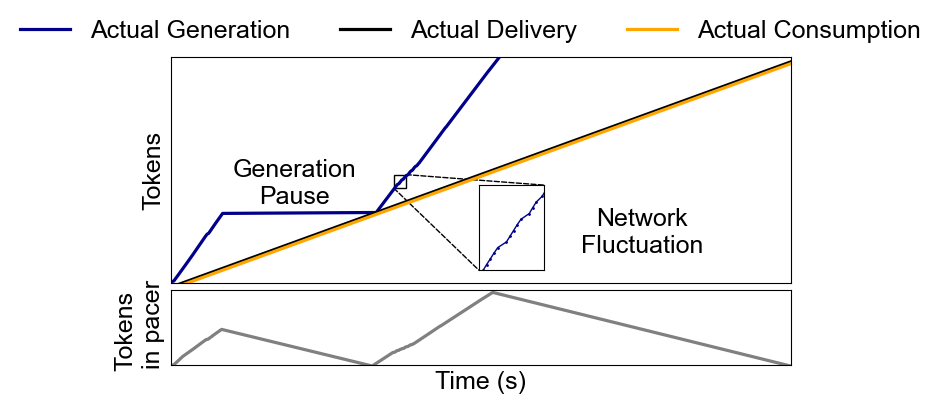

In [ ]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, ConnectionPatch

# Generate some data points for x

# Plot the line y=x
y =  [0.0, 0.2644484043121338, 0.31870079040527344, 0.37123751640319824, 0.42342138290405273, 0.4764211177825928, 0.5293347835540771, 0.5811166763305664, 0.6346497535705566, 0.6875312328338623, 0.73905348777771, 0.7927870750427246, 0.8460803031921387, 0.8983900547027588, 0.950850248336792, 1.0030937194824219, 1.0554780960083008, 1.1074001789093018, 1.1611249446868896, 1.214198350906372, 1.2668516635894775, 1.3215579986572266, 1.3747117519378662, 1.4290452003479004, 1.4811718463897705, 1.5368030071258545, 1.5851962566375732, 1.6337604522705078, 1.684621810913086, 1.7341198921203613, 1.7839317321777344, 1.834000587463379, 1.8841145038604736, 1.9347684383392334, 1.9839041233062744, 2.033694267272949, 2.084892511367798, 2.134355306625366, 2.1841835975646973, 2.232971429824829, 2.2817509174346924, 2.331300735473633, 2.3813960552215576, 2.4335708618164062, 2.4829249382019043, 2.5329318046569824, 2.5836968421936035, 2.6342082023620605, 2.685338020324707, 2.7349677085876465, 2.786302328109741, 2.8372890949249268, 2.89133882522583, 2.9551842212677, 3.0782310962677, 3.127190589904785, 3.1768529415130615, 3.226569652557373, 3.2767252922058105, 3.3264715671539307, 3.378923177719116, 3.430767297744751, 3.476815700531006, 3.5249643325805664, 3.5756642818450928, 3.6269869804382324, 3.6785969734191895, 3.729146957397461, 3.7801599502563477, 3.830235481262207, 3.885206460952759, 3.9377574920654297, 3.9889345169067383, 4.0399253368377686, 4.091241836547852, 4.142197847366333, 4.19888973236084, 18.584244966506958, 18.63931918144226, 18.693372011184692, 18.747600317001343, 18.812041521072388, 18.86516571044922, 18.919652462005615, 18.974390506744385, 19.02750849723816, 19.08543610572815, 19.13785457611084, 19.192582607269287, 19.246132373809814, 19.300373315811157, 19.357534646987915, 19.41252565383911, 19.46761465072632, 19.52255940437317, 19.57678532600403, 19.630303382873535, 19.685672521591187, 19.74120569229126, 19.796361684799194, 19.8502299785614, 19.903095722198486, 19.95663571357727, 20.009281635284424, 20.063119888305664, 20.11596965789795, 20.173097372055054, 20.227752208709717, 20.288177490234375, 20.421466588974, 20.476258277893066, 20.532106161117554, 20.584787607192993, 20.64569902420044, 20.77181363105774, 20.823373794555664, 20.877368688583374, 20.966794967651367, 21.02109932899475, 21.155808448791504, 21.207931995391846, 21.262121200561523, 21.318182468414307, 21.383052110671997, 21.509653329849243, 21.563549041748047, 21.617269039154053, 21.669464826583862, 21.73719358444214, 21.865957021713257, 21.918617963790894, 21.979193210601807, 22.05140495300293, 22.105875253677368, 22.167227745056152, 22.221199989318848, 22.274949073791504, 22.328491926193237, 22.382081985473633, 22.435351610183716, 22.488133192062378, 22.54305672645569, 22.596625804901123, 22.649171352386475, 22.703455924987793, 22.756541967391968, 22.810527086257935, 22.864035844802856, 22.91715359687805, 22.971079111099243, 23.025012016296387, 23.07892894744873, 23.13228154182434, 23.18817925453186, 23.242366790771484, 23.29576301574707, 23.35009503364563, 23.403778314590454, 23.45712399482727, 23.511434316635132, 23.564078092575073, 23.61734414100647, 23.670013666152954, 23.723449230194092, 23.778292417526245, 23.832857608795166, 23.886465787887573, 23.940610647201538, 23.993245363235474, 24.04735517501831, 24.101349115371704, 24.15698790550232, 24.230483770370483, 24.28537631034851, 24.33960199356079, 24.39522695541382, 24.45059084892273, 24.50645089149475, 24.562068700790405, 24.617408514022827, 24.67206311225891, 24.72747802734375, 24.782461404800415, 24.83691668510437, 24.892199993133545, 24.946979999542236, 25.002034664154053, 25.056904315948486, 25.11119294166565, 25.16930389404297, 25.22425889968872, 25.278481006622314, 25.33417844772339, 25.38856601715088, 25.445439100265503, 25.498509883880615, 25.553733587265015, 25.60774564743042, 25.6616792678833, 25.7162868976593, 25.77038836479187, 25.82517409324646, 25.879368543624878, 25.938369750976562, 25.993099212646484, 26.047520875930786, 26.101675987243652, 26.15593409538269, 26.20941686630249, 26.26334023475647, 26.317586660385132, 26.3730366230011, 26.427546501159668, 26.481577157974243, 26.536362171173096, 26.59119701385498, 26.651740789413452, 26.705116748809814, 26.760657787322998, 26.815362691879272, 26.870508193969727, 26.924920320510864, 26.98167872428894, 27.03633737564087, 27.091410160064697, 27.145990133285522, 27.201027393341064, 27.254996061325073, 27.309513807296753, 27.364240884780884, 27.418957948684692, 27.474806547164917, 27.53251338005066, 27.590914011001587, 27.647451639175415, 27.702051639556885, 27.757487058639526, 27.81410837173462, 27.883631229400635, 27.9389910697937, 27.994861364364624, 28.049808263778687, 28.105414390563965, 28.16076946258545, 28.215137004852295, 28.27103018760681, 28.326946258544922, 28.382823944091797, 28.439309120178223, 28.494550466537476, 28.550193548202515, 28.604962825775146, 28.660572052001953, 28.725491285324097, 28.780985832214355, 28.838228702545166, 28.89380955696106, 28.94889998435974, 29.003258228302002, 29.058659076690674, 29.113554000854492, 29.16751527786255, 29.2218177318573, 29.275195598602295, 29.330005407333374, 29.385558366775513, 29.440696001052856, 29.495007276535034, 29.549872398376465, 29.60498571395874, 29.660120487213135, 29.714629888534546, 29.769941568374634, 29.825662851333618, 29.880558967590332, 29.935288190841675, 29.99117684364319, 30.07852554321289, 30.135063409805298, 30.189195156097412, 30.24858570098877, 30.314919471740723, 30.369575023651123, 30.4232656955719, 30.47732949256897, 30.53447437286377, 30.58935236930847, 30.645745277404785, 30.696444272994995, 30.744497060775757, 30.7937433719635, 30.847127199172974, 30.90136480331421, 30.95526647567749, 31.01121234893799, 31.06601905822754, 31.119609594345093, 31.17314600944519, 31.227880001068115, 31.287527084350586, 31.34228825569153, 31.39756488800049, 31.449249744415283, 31.503031253814697, 31.556398391723633, 31.609501123428345, 31.663938760757446, 31.718099355697632, 31.771275520324707, 31.824162006378174, 31.88542079925537, 31.93865203857422, 31.992380380630493, 32.056337118148804, 32.1935818195343, 32.24642014503479, 32.30162763595581, 40.20069169998169, 40.25440788269043, 40.306936740875244, 40.361368894577026, 40.41543793678284, 40.468801498413086, 40.522491216659546, 40.574836015701294, 40.62721228599548, 40.6801598072052, 40.73383188247681, 40.78642272949219, 40.83841156959534, 40.89163565635681, 40.96046733856201, 41.01461458206177, 41.0682418346405, 41.12147092819214, 41.17489814758301, 41.22739052772522, 41.2813024520874, 41.33739495277405, 41.391388177871704, 41.44533586502075, 41.53843092918396, 41.58963322639465, 41.642497062683105, 41.69558930397034, 41.74840831756592, 41.802820682525635, 41.86537051200867, 41.92048215866089, 41.97823190689087, 42.030900716781616, 42.084555864334106, 42.137638092041016, 42.194246768951416, 42.2506799697876, 42.30449652671814, 42.35849714279175, 42.41318678855896, 42.46705627441406, 42.520910024642944, 42.574641704559326, 42.634117603302, 42.69669771194458, 42.74986433982849, 42.80332636833191, 42.85614013671875, 42.908875942230225, 42.962159633636475, 43.015992879867554, 43.06801795959473, 43.12057709693909, 43.1738805770874, 43.22377347946167, 43.27471160888672, 43.323253870010376, 43.37378120422363, 43.42242360115051, 43.472275495529175, 43.52277135848999, 43.60935163497925, 43.66264796257019, 43.71211123466492, 43.7628059387207, 43.814430713653564, 43.86375117301941, 43.91490125656128, 43.964898109436035, 44.022539138793945, 44.072057485580444, 44.122116804122925, 44.17161202430725, 44.22296166419983, 44.273749351501465, 44.3233540058136, 44.38298964500427, 44.43352222442627, 44.48334550857544, 44.53429388999939, 44.583415508270264, 44.63337063789368, 44.684433460235596, 44.73455095291138, 44.795086145401, 44.916592836380005, 44.96688151359558, 45.01748728752136, 45.06671118736267, 45.117326498031616, 45.16866326332092, 45.22405767440796, 45.29153275489807, 45.345925092697144, 45.395447969436646, 45.44470477104187, 45.49359059333801, 45.54339551925659, 45.59350562095642, 45.642435789108276, 45.69299936294556, 45.742430448532104, 45.79319715499878, 45.84307885169983, 45.89435434341431, 45.95031929016113, 46.0032799243927, 46.05550575256348, 46.10883641242981, 46.16279864311218, 46.21616768836975, 46.268030643463135, 46.321256160736084, 46.37455701828003, 46.427902698516846, 46.48072099685669, 46.53468108177185, 46.58657956123352, 46.63967275619507, 46.69282865524292, 46.74510860443115, 46.7979052066803, 46.849791049957275, 46.90282845497131, 46.95677471160889, 47.00900745391846, 47.0624213218689, 47.11539316177368, 47.16875982284546, 47.22100114822388, 47.27455377578735, 47.325966596603394, 47.37868046760559, 47.43367648124695, 47.4856173992157, 47.53854203224182, 47.591532707214355, 47.64484763145447, 47.70183181762695, 47.7605664730072, 47.81348633766174, 47.86697268486023, 47.92078495025635, 47.97858643531799, 48.030487298965454, 48.08364963531494, 48.137869119644165, 48.194658517837524, 48.25154519081116, 48.30547833442688, 48.359721660614014, 48.41255784034729, 48.46535301208496, 48.518574476242065, 48.57215690612793, 48.62556195259094, 48.67943525314331, 48.73237943649292, 48.78566360473633, 48.83929967880249, 48.89395594596863, 48.948153495788574, 49.00214457511902, 49.05531668663025, 49.10873508453369, 49.1622109413147, 49.21538233757019, 49.26981449127197, 49.32264947891235, 49.376235008239746, 49.429696559906006, 49.48248791694641, 49.53969192504883, 49.590715408325195, 49.64340615272522, 49.697099924087524, 49.74924659729004, 49.801154375076294, 49.854910373687744, 49.91001272201538, 49.96452498435974, 50.01739263534546, 50.06944513320923, 50.122833251953125, 50.17619872093201, 50.229719400405884, 50.28317165374756, 50.33621859550476, 50.38909316062927, 50.445889949798584, 50.50339603424072, 50.55808186531067, 50.611438035964966, 50.664344787597656, 50.71752643585205, 50.771432876586914, 50.82419300079346, 50.878453731536865, 50.93243217468262, 50.98653841018677, 51.04022264480591, 51.093342781066895, 51.146607398986816, 51.200162410736084, 51.25315260887146, 51.30521297454834, 51.36000728607178, 51.41352033615112, 51.46791648864746, 51.519514083862305, 51.5756311416626, 51.627691984176636, 51.68036937713623, 51.73250913619995, 51.78527331352234, 51.83641076087952, 51.8872857093811, 51.939631938934326, 51.9980845451355, 52.05063056945801, 52.10634255409241, 52.15716552734375, 52.20949983596802, 52.26135993003845, 52.313679456710815, 52.36494421958923, 52.41711616516113, 52.47207450866699, 52.523900508880615, 52.574427366256714, 52.62591290473938, 52.67727613449097, 52.72922968864441, 52.78175616264343, 52.83416485786438, 52.887956619262695, 52.93661379814148, 52.989581823349, 53.04107069969177, 53.09295177459717, 53.14464998245239, 53.19658160209656, 53.249162435531616, 53.30125975608826, 53.35606646537781, 53.41151475906372, 53.46349835395813, 53.515790700912476, 53.567822217941284, 53.61981272697449, 53.67185139656067, 53.72439479827881, 53.779327392578125, 53.83535718917847, 53.8874249458313, 53.93919062614441, 53.99266028404236, 54.04555892944336, 54.09822344779968, 54.154998540878296, 54.20931339263916, 54.26244282722473, 54.31575870513916, 54.36893916130066, 54.42134976387024, 54.47348070144653, 54.52578115463257, 54.578471660614014, 54.63154602050781, 54.68501257896423, 54.73808765411377, 54.81352257728577, 54.866867780685425, 54.921786069869995, 54.97806477546692, 55.03134512901306, 55.083486795425415, 55.14749264717102, 55.20018458366394, 55.25201869010925, 55.304287910461426, 55.35682916641235, 55.40896677970886, 55.462196588516235, 55.51483488082886, 55.56666326522827, 55.619051456451416, 55.67179489135742, 55.72350335121155, 55.77587080001831, 55.82744097709656, 55.88021802902222, 55.93250751495361, 55.98812913894653, 56.03939962387085, 56.0925178527832, 56.146634578704834, 56.19886803627014, 56.253732681274414, 56.30526304244995, 56.3568811416626, 56.409913063049316, 56.46217465400696, 56.514098167419434, 56.566866636276245, 56.619030714035034, 56.6710844039917, 56.723368406295776, 56.7755286693573, 56.82818412780762, 56.87922191619873, 56.93089246749878, 56.983582973480225, 57.0356662273407, 57.092222452163696, 57.14687514305115, 57.1997926235199, 57.253316164016724, 57.305633544921875, 57.357996225357056, 57.41116404533386, 57.46371054649353, 57.517685651779175, 57.56994342803955, 57.62279534339905, 57.675750494003296, 57.72823095321655, 57.78147625923157, 57.83491039276123, 57.88740634918213, 57.94019317626953, 57.995251417160034, 58.04425930976868, 58.09345054626465, 58.14211654663086, 58.1905357837677, 58.240442991256714, 58.290210485458374, 58.33924436569214, 58.3882372379303, 58.436065435409546, 58.48586106300354, 58.535669803619385, 58.58490610122681, 58.63328409194946, 58.68321490287781, 58.73202133178711, 58.780351400375366, 58.82833528518677, 58.87677001953125, 58.92445611953735, 58.97107553482056, 59.01952624320984, 59.07040286064148, 59.11686110496521, 59.17190384864807, 59.220475912094116, 59.26781940460205, 59.319303035736084, 59.36818289756775, 59.4155650138855, 59.4687705039978, 59.52565240859985, 59.57687830924988, 59.62495040893555, 59.675201654434204, 59.72395038604736, 59.772297620773315, 59.820897579193115, 59.868460178375244, 59.916210889816284, 59.96382284164429, 60.01339793205261, 60.061517000198364, 60.11014699935913, 60.15762424468994, 60.20569849014282, 60.253371715545654, 60.30050325393677, 60.35011410713196, 60.396075963974, 60.441230058670044, 60.48700308799744, 60.53352880477905, 60.57820916175842, 60.62557101249695, 60.671147108078, 60.71697425842285, 60.76275277137756, 60.80939197540283, 60.854787826538086, 60.89989447593689, 60.945029735565186, 60.99101424217224, 61.035627126693726, 61.081665992736816, 61.126978635787964, 61.17214870452881, 61.21989989280701, 61.26537537574768, 61.31092715263367, 61.356621503829956, 61.40242600440979, 61.44812369346619, 61.494110107421875, 61.53863859176636, 61.5836238861084, 61.63623666763306, 61.681166648864746, 61.72711110115051, 61.772743225097656, 61.81808114051819, 61.863144636154175, 61.90888953208923, 61.95498085021973, 62.000683307647705, 62.046244621276855, 62.09303259849548, 62.138962268829346, 62.183356046676636, 62.228673219680786, 62.2746479511261, 62.3195743560791, 62.36484909057617, 62.41080355644226, 62.4562406539917, 62.50057768821716, 62.545981884002686, 62.59129309654236, 62.63688898086548, 62.682286500930786, 62.72793483734131, 62.77423334121704, 62.82076048851013, 62.867618560791016, 62.913424253463745, 62.95927405357361, 63.00614666938782, 63.050962924957275, 63.09653186798096, 63.14230513572693, 63.187326431274414, 63.23259162902832, 63.28428840637207, 63.329505443573, 63.37528467178345, 63.4199001789093, 63.46433234214783, 63.50899052619934, 63.555700063705444, 63.600507736206055, 63.6682391166687, 63.749202251434326, 63.79675030708313, 63.8431031703949, 63.88975477218628, 63.93701648712158, 63.98389530181885, 64.0314040184021, 64.07829117774963, 64.1245653629303, 64.17190599441528, 64.2201337814331, 64.26669144630432, 64.31250596046448, 64.35827660560608, 64.4065477848053, 64.45104551315308, 64.49698305130005, 64.54314541816711, 64.58827304840088, 64.63276743888855, 64.67759299278259, 64.72102093696594, 64.76597285270691, 64.82757234573364, 64.87401103973389, 64.9234893321991, 64.9703733921051, 65.01742053031921, 65.06271624565125, 65.10712480545044, 65.15463709831238, 65.1986951828003, 65.24314785003662, 65.2881371974945, 65.33240675926208, 65.37704086303711, 65.42184972763062, 65.46658158302307, 65.51114177703857, 65.55615305900574, 65.60101652145386, 65.6468768119812, 65.69129419326782, 65.73527407646179, 65.7791497707367, 65.82322812080383, 65.86795353889465, 65.91207075119019, 65.95666146278381, 66.00059819221497, 66.04699540138245, 66.09079909324646, 66.13658881187439, 66.18088698387146, 66.22556018829346, 66.27058124542236, 66.31499195098877, 66.3598084449768, 66.40587639808655, 66.45057964324951, 66.49481844902039, 66.53878617286682, 66.58305144309998, 66.62723445892334, 66.671541929245, 66.71544051170349, 66.76110792160034, 66.80710816383362, 66.85225367546082, 66.89794158935547, 66.94254684448242, 66.9880211353302, 67.03271150588989, 67.07778263092041, 67.12476658821106, 67.16987562179565, 67.22375392913818, 67.26913976669312, 67.31445789337158, 67.35929322242737, 67.40556049346924, 67.4505558013916, 67.49558782577515, 67.54046201705933, 67.58602094650269, 67.63114285469055, 67.67682600021362, 67.72217178344727, 67.76752305030823, 67.81390118598938, 67.86003160476685, 67.9063310623169, 67.95386338233948, 67.99959135055542, 68.04666471481323, 68.09351539611816, 68.13971519470215, 68.18511509895325, 68.2330436706543, 68.27645087242126, 68.32001876831055, 68.36394715309143, 68.40819597244263, 68.46246457099915, 68.53557705879211, 68.58218836784363, 68.62844014167786, 68.6747682094574, 68.71973657608032, 68.76651191711426, 68.81245040893555, 68.85975384712219]

temp_y = []
for i in y:
    if i < 5:
        temp_y.append(i)
    else:
        temp_y.append(i-2)
y = temp_y

fig = plt.figure(figsize=(8, 4))
color='darkblue'

plt.rcParams.update({'font.size': 18})
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1], hspace=0.05) 
# Add subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax = ax1
x = np.arange(1, len(y) + 1)
ax.plot(y, x,label='Actual Generation',color=color, linestyle='-')
x = np.linspace(0, 50, 100)
ax.plot(x, 5 * (x - 1), linestyle='-', color='black', label='Actual Delivery')
ax.plot(x, 5 * (x - 1)-2, linestyle='-', color='orange', label='Actual Consumption')
# plt.xlabel('Time (s)')
ax.set_xticks([])
ax.set_ylabel('Tokens')
ax.set_xlim(0, 50)
ax.set_ylim(0, 250)
# Annotations
ax.text(10, 110, "Generation\nPause", horizontalalignment='center', verticalalignment='center', fontsize=18)
ax.text(38, 55, "Network\nFluctuation", horizontalalignment='center', verticalalignment='center', fontsize=18)


# Remove x-axis and y-axis numbers for ax1
ax1.set_xticks([])  # Removes x-axis numbers
ax1.set_yticks([])  # Removes y-axis numbers

# Draw rectangle on the main plot to indicate zoom area
rect = Rectangle((18, 105), 1, 15, linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

x = np.arange(1, len(y) + 1)
ax_inset = inset_axes(ax1, width='7%', height='42%', loc='lower center',
                      bbox_to_anchor=(-0.2, 0, 1.5, 0.9), bbox_transform=ax1.transAxes)
ax_inset.plot(y, x, markersize=1, marker='o',color=color, linewidth=1)
ax_inset.set_xlim(18, 19)
ax_inset.set_ylim(105, 120)
ax_inset.xaxis.set_visible(False)
ax_inset.yaxis.set_visible(False)

# zoom in lines
con1 = ConnectionPatch(xyA=(18, 105), coordsA='data', xyB=(0, 0), coordsB='axes fraction',
                       axesA=ax1, axesB=ax_inset, color='k', linestyle="--")
ax.add_artist(con1)
con2 = ConnectionPatch(xyA=(19, 120), coordsA='data', xyB=(1,1), coordsB='axes fraction',
                       axesA=ax1, axesB=ax_inset, color='k', linestyle="--")
ax.add_artist(con2)

# plt.savefig("big_fig.pdf")
ax = ax2
time = y[:250]
buffer_occupation = []
for i in range(len(time)):
    target_tokens = 5 * (time[i] - 1) if time[i] > 1 else 0
    buffer_occupation.append(i - target_tokens)

time.append(26.5)
buffer_occupation.append(buffer_occupation[-1])
time_step = 24.5/250
buffer_step = time_step * 5
for _ in range(250):
    time.append(time[-1] + time_step)
    buffer_occupation.append(buffer_occupation[-1] - buffer_step)


# ax.figure(figsize=(9, 3), constrained_layout=True)
x = np.arange(1, len(y) + 1)
ax.plot(time, buffer_occupation,color='grey')
ax.set_xlim(0, 51)
ax.set_ylim(0, 125)
ax.set_ylabel('Tokens \n in pacer')
ax.set_xlabel('Time (s)')

# Remove x-axis and y-axis numbers for ax1
ax2.set_xticks([])  # Removes x-axis numbers
ax2.set_yticks([])  # Removes y-axis numbers

# plt.legend()
# plt.savefig("buffer_ocupation.png")
handles,labels = [],[]
for ax in [ax1,ax2]:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:  # Check to avoid duplicate labels in the legend
                handles.append(handle)
                labels.append(label)

legend = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03))
legend.set_frame_on(False)
# plt.tight_layout()
plt.savefig(f"new_client_buffer.pdf", bbox_inches='tight')
plt.show()

# Preemption Freq Calculator


In [ ]:
import numpy as np
from scipy.optimize import fsolve

# Define a function that performs the calculation based on input parameters
def calculate_effective_time(t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len):
    """
    Calculate the effective time, preemption frequency, and max burstiness based on given parameters.

    Args:
    t_exp (float): Expected time for processing.
    t_act (float): Actual time for Phi-MoE.
    gpu_kv_entry (int): GPU key-value entry.
    thpt_per_s (int): Throughput per second.
    output_len (int): Output length.
    input_len (int): Input length.

    Returns:
    tuple: (t_effective, preemption_freq, max_burstiness)
    """

    # Calculate the context length and batch size
    context_len = input_len + output_len
    batch_size = gpu_kv_entry / context_len
    overhead_param = batch_size * context_len / thpt_per_s

    # Define the equation to solve for T_effective
    def equation(x):
        return x - output_len / (output_len / t_act + overhead_param * (x / t_exp - 1))

    # Use fsolve to solve for T_effective with an initial guess
    x_initial_guess = 10
    t_effective = fsolve(equation, x_initial_guess)[0]

    # Calculate preemption frequency and max burstiness
    preemption_freq = t_effective / t_exp - 1
    max_burstiness = 1 / (preemption_freq**2)

    print(f'T_effective: {round(t_effective,2)};')
    print(f'Preemption Frequency: {round(preemption_freq,2)};')

    # Return the calculated values
    return t_effective, preemption_freq, max_burstiness


In [ ]:
print("Phi-MoE on Arxiv dataset.")
# Example usage: Pass different constants as arguments to the function
t_exp = 5
t_act = 20
gpu_kv_entry = 54126 * 16
thpt_per_s = 5000
output_len = 600
input_len = 18000

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)
print("Phi-MoE on ShareGPT-Multi dataset.")
output_len = 400
input_len = 3000

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)
print("Phi-MoE on Code dataset.")
output_len = 2400
input_len = 800

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)

# Output the results
print(f'T_effective: {t_effective};')
print(f'Preemption Frequency: {preemption_freq};')
# print(f'Max Burstiness: {max_burstiness};')


In [ ]:
print("Phi-7B on Arxiv dataset.")
# Example usage: Pass different constants as arguments to the function
t_exp = 5
t_act = 20
gpu_kv_entry = 15638 * 16
thpt_per_s = 5000
output_len = 600
input_len = 18000

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)
print("Phi-7B on ShareGPT-Multi dataset.")
input_len = 3000
output_len = 400

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)

# print(f'Max Burstiness: {max_burstiness};')
print("Phi-7B on Code dataset.")
input_len = 800
output_len = 2400

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)


In [ ]:
# Example usage: Pass different constants as arguments to the function
t_exp = 5
t_act = 20
gpu_kv_entry = 11847 * 16
thpt_per_s = 5000
print("llama3-70B on Arxiv dataset.")
output_len = 600
input_len = 18000

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)
print("llama3-70B on sharegpt dataset.")

output_len =400
input_len = 3000

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)
print("llama3-70B on code dataset.")

output_len =2400
input_len = 800

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
)

In [ ]:
# Example usage: Pass different constants as arguments to the function
t_exp = 5
t_act = 16
gpu_kv_entry = 19941 * 16
thpt_per_s = 5000
print("phi-7B on Arxiv dataset, A40")
output_len = 600
input_len = 16000

# Call the function with these constants
t_effective, preemption_freq, max_burstiness = calculate_effective_time(
    t_exp, t_act, gpu_kv_entry, thpt_per_s, output_len, input_len
) 

# Request logging analysis

In [ ]:
from analyze_perf import analyze_one_trace, plot_cdf_together

In [ ]:
# DIR = '/Users/amberljc/Desktop/andes_log-10-11/request_logs/'
# file_list = [
# '2024-10-08 14:07-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1735-1.0(0.2)-hour-453-fcfs.json',
# '2024-10-08 16:10-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1735-1.0(0.2)-hour-453-qoe-avg.json'
# ]
# log_dict = {}
# for file in file_list:
#     file = DIR + file
#     metric_dict = analyze_one_trace(file)
#     log_dict[file] = metric_dict 
# # plot_cdf_together(log_dict, ''.join(file_list[0].split('-')[3:9]))#


# Archived 

In [ ]:
arrival_list=[1, 1, 1, 3, 2, 0, 1, 1, 2, 0, 0, 1, 6, 0, 4, 2, 2, 1, 0, 2, 5, 0, 1, 4, 2, 2, 1, 3, 0, 2, 1, 0, 1, 5, 0, 3, 0, 3, 0, 2, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 5, 0, 1, 1, 3, 0, 2, 3, 1, 0, 4, 0, 3, 1, 0, 3, 1, 1, 1, 0, 3, 2, 1, 2, 0, 1, 4, 0, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 3, 1, 1, 2, 3, 1, 2, 2, 0, 4, 1, 1, 1, 3, 1, 3, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 4, 0, 5, 2, 3, 1, 2, 3, 0, 1, 1, 1, 1, 2, 0, 2, 0, 4, 2, 2, 1, 2, 2, 3, 2, 0, 0, 4, 1, 3, 1, 1, 1, 0, 3, 2, 0, 0, 1, 3, 0, 1, 2, 1, 1, 2, 2, 0, 2, 0, 3, 1, 0, 3, 0, 2, 1, 0, 0, 4, 1, 2, 0, 2, 1, 1, 2, 3, 2, 1, 3, 0, 4, 0, 3, 0, 0, 2, 2, 1, 0, 4, 0, 2, 1, 1, 1, 1, 0, 2, 3, 3, 0, 0, 3, 2, 3, 2, 2, 1, 0, 3, 1, 2, 2, 0, 1, 2, 1, 2, 3, 1, 1, 1, 3, 2, 1, 0, 4, 0, 1, 2, 1, 2, 0, 0, 0, 6, 2, 2, 0, 2, 1, 3, 0, 1, 2, 1, 3, 1, 0, 1, 2, 1, 6, 2, 4, 3, 0, 1, 0, 3, 1, 1, 2, 2, 2, 2, 3, 1, 0, 3, 2, 1, 3, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 3, 0, 4, 1, 2, 1, 3, 2, 3, 1, 0, 2, 0, 1, 0, 2, 3, 0, 0, 3, 0, 2, 2, 1, 0, 3, 0, 0, 1, 0, 4, 0, 3, 0, 3, 0, 3, 0, 1, 2, 0, 1, 2, 6, 0, 3, 1, 0, 1, 1, 1, 4, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 7, 4, 2, 2, 1, 3, 3, 2, 2, 2, 2, 1, 0, 2, 2, 0, 1, 1, 2, 0, 2, 1, 4, 1, 1, 1, 1, 3, 2, 1, 1, 2, 0, 1, 1, 1, 2, 0, 2, 1, 0, 2, 2, 1, 3, 0, 3, 3, 3, 0, 1, 1, 0, 2, 0, 2, 1, 1, 3, 3, 3, 1, 1, 0, 6, 1, 2, 5, 1, 1, 0, 1, 2, 0, 0, 5, 0, 1, 1, 3, 2, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 3, 0, 0, 3, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 3, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 3, 3, 0, 2, 3, 0, 2, 2, 0, 1, 1, 3, 3, 2, 0, 2, 2, 2, 2, 3, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 0, 4, 0, 1, 3, 2, 2, 2, 1, 0, 4, 4, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 3, 0, 0, 3, 0, 2, 3, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 1, 3, 1, 2, 1, 2, 2, 1, 3, 0, 2, 4, 1, 1, 4, 0, 4, 1, 1, 2, 1, 3, 0, 4, 1, 2, 2, 3, 1, 2, 0, 1, 2, 3, 1, 0, 2, 2, 0, 3, 2, 0, 1, 2, 2, 1, 1, 0, 3, 2, 5, 2, 3, 1, 4, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 1, 4, 0, 1, 8, 2, 2, 2, 1, 13, 0, 0, 1, 3, 0, 0, 9, 0, 4, 0, 0, 4, 2, 24, 8, 0, 0, 0, 11, 2, 3, 5, 1, 4, 1, 3, 2, 3, 6, 3, 6, 25, 7, 4, 1, 4, 5, 0, 2, 22, 2, 7, 5, 9, 5, 4, 5, 0, 19, 3, 22, 3, 6, 3, 0, 1, 4, 11, 7, 30, 5, 4, 4, 38, 10, 0, 5, 4, 4, 7, 17, 24, 5, 4, 4, 14, 21, 13, 5, 3, 1, 5, 17, 5, 25, 5, 4, 5, 8, 35, 4, 1, 4, 4, 5, 4, 8, 11, 6, 18, 6, 4, 4, 47, 6, 4, 4, 3, 2, 1, 26, 1, 2, 13, 5, 4, 4, 13, 35, 5, 2, 2, 4, 19, 29, 5, 4, 2, 2, 1, 47, 1, 4, 4, 5, 37, 10, 6, 3, 5, 12, 20, 0, 1, 5, 5, 3, 2, 2, 1, 0, 4, 0, 11, 0, 1, 4, 5, 1, 0, 3, 1, 6, 3, 0, 4, 0, 4, 0, 1, 0, 3, 0, 6, 1, 1, 5, 13, 9, 6, 6, 1, 1, 12, 6, 1, 24, 11, 18, 2, 5, 1, 4, 0, 0, 0, 7, 4, 2, 0, 1, 5, 3, 3, 0, 3, 2, 1, 1, 2, 1, 0, 1, 7, 5, 2, 0, 0, 0, 3, 1, 4, 6, 3, 1, 2, 4, 0, 1, 1, 2, 6, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 7, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 3, 2, 1, 2, 1, 2, 1, 3, 2, 2, 0, 0, 3, 0, 13, 1, 2, 1, 2, 3, 0, 0, 1, 3, 1, 0, 2, 2, 0, 2, 7, 0, 3, 3, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 2, 3, 1, 0, 2, 1, 2, 2, 0, 1, 1, 4, 2, 4, 2, 3, 4, 0, 4, 1, 1, 0, 0, 0, 2, 1, 4, 2, 1, 1, 1, 6, 2, 1, 2, 0, 32, 5, 21, 3, 0, 0, 17, 1, 4, 11, 0, 1, 2, 3, 1, 8, 25, 11, 5, 8, 3, 1, 8, 19, 1, 2, 0, 2, 1, 1, 1, 3, 12, 1, 1, 3, 2, 4, 0, 2, 0, 1, 3, 0, 0, 2, 0, 0, 2, 17, 18, 17, 4, 1, 2, 0, 2, 4, 47, 8, 0, 2, 4, 9, 46, 1, 1, 4, 8, 7, 15, 5, 20, 1, 0, 1, 4, 42, 14, 0, 2, 3, 15, 5, 26, 10, 0, 2, 3, 6, 50, 0, 2, 3]
timestamps, running, swapped, waiting, gpu_cache_usage = extract_system_stats_from_log('results/2024-10-08 15:08-sys-stats.txt')
plot_system_stats(timestamps, running, swapped, waiting, gpu_cache_usage, arrival_list, 130, 'burst-fcfs')
print(f'GPU utilization: {np.mean(gpu_cache_usage)}')

In [ ]:
timestamps, running, swapped, waiting, gpu_cache_usage = extract_system_stats_from_log('results/2024-10-08 16:09-sys-stats.txt')
plot_system_stats(timestamps, running, swapped, waiting, gpu_cache_usage, arrival_list, 130, 'burst-qoe')
print(f'GPU utilization: {np.mean(gpu_cache_usage)}')

In [ ]:
qoe_burstgpt_file = 'results/2024-10-08 16:10-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1735-1.0(0.2)-hour-453-qoe-avg.json'
fcfs_burstgpt_file = 'results/2024-10-08 15:09-meta-llama-Meta-Llama-3.1-70B-sharegpt-multi-burstgpt*1735-1.0(0.2)-hour-453-fcfs.json'
plot_cdf([fcfs_ttft_list, qoe_ttft_list], 'CDF', 'TTFT (s)',
            'ttft-cdf', 100,0, [BASE,  SYS_NAME], fig_size=(4,4))
fcfs_p90_cdf_list = [1/t  for t in fcfs_token_latency_p90_list]
qoe_p90_cdf_list = [1/t  for t in qoe_token_latency_p90_list]
plot_cdf([fcfs_p90_cdf_list, qoe_p90_cdf_list], 'CDF', 'P90 TDS (#Token/s)', 
         'p90-tds-cdf', 50,0, label=['FCFS', 'QoE'], vline=5, fig_size=(4,4))
plot_cdf([fcfs_qoe_list, qoe_qoe_list], 'CDF', 'QoE', 'qoe-cdf', 1,0, 
         [BASE,  SYS_NAME], fig_size=(4,4))

In [ ]:
# llama
vllm_x = andes_x = [0,5,10,15, 20, 25, 30,35,40,45]
vllm_res = [0.96,1.88,3.59,5.92,8.68, 9.96,10.52,12.10,13.73,16.12]
andes_res = [0.93,1.16,1.46,1.68,1.89,2.07,2.36,2.76,3.12,3.34]
sara_res =  [0.95,1.85,3.68,6.13,8.12,8.5,10.08,12.78,12.84,15.26]
ttft_breakdown_arrival([vllm_x,andes_x,andes_x],[vllm_res,andes_res,sara_res], 'llama-share-a100', 'TTFT (s)', log_scale=False, yrange=(0,20))


vllm_x = andes_x = [0,5,10,15, 20,    25, 30,35,40,45]
vllm_res =  [20.4, 19.4,18.8,18.4,18.7,   18.23, 18.07,18.23,17.37,16.39]
andes_res =  [19.2, 19.8,19.1,18.4,17.9,   17.55,17.39,16.51,16.21,15.54]
sara = [20.5,19.3,18.5,18.5,18.7, 18.67, 18.14, 17.79,17.32,16.26  ]
 
tds_breakdown_arrival([vllm_x,andes_x,andes_x],[vllm_res,andes_res, sara], 'llama-share-a100', 'tds', horizontal=[ 3.3, 4.8],log_scale=False, yrange=(0,25))
